In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as spstats
import statsmodels.api as sm
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
#import locale
#locale.setlocale(locale.LC_ALL, 'C')
from scipy import stats
from gprofiler import GProfiler
from matplotlib_venn import venn2, venn2_circles
import altair as alt
# Habilitar VegaFusion para lidar com grandes conjuntos de dados
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
def check_dir(dir: str):
    if os.path.exists(dir) and os.path.isdir(dir):
        pass
    else:
        os.makedirs(dir)

In [3]:
datadir = "data/"
shuffledir = datadir + "shuffle/"
check_dir(datadir)
check_dir(shuffledir)

In [4]:
networks = ["biogrid", "apid", "huri", "string", "omnipath"]

# Functions

In [5]:
def drivergroups(x):
    if x.n_dints == 0:
        return "non_sign"
    else:
        if x.neg_dints == 0:
            return "pos"
        elif x.pos_dints == 0:
            return "neg"
        else:
            if x.neg_dints > x.pos_dints:
                return "more_neg"
            elif x.pos_dints > x.neg_dints:
                return "more_pos"
            else:
                return "neutral"


def labeldrivers(
    df: pd.DataFrame,
    output=None
):
    if output is None:
        output = []

    if len(output) == len(df):
        return output
    else:
        x = df.iloc[len(output)]
        return labeldrivers(df, output=output+[drivergroups(x)])


def labelneighbours(df):
    labels = []
    for i in range(len(df)):
        x = df.iloc[i]
        if x.n_dints == 0:
            labels.append("non_sign")
        else:
            if x.neg_dints == 0:
                labels.append("pos")
            elif x.pos_dints == 0:
                labels.append("neg")
            else:
                labels.append("neutral")
    return labels

# Driver Neighbour analysis

## Load Datasets

In [6]:
mutationtab = pd.read_feather(datadir+"mutation.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(mutationtab.shape)
display(mutationtab.head(2))
neighbourtab = pd.read_feather(datadir+"neighbours.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(neighbourtab.shape)
display(neighbourtab.head(2))

(8404, 2570)


A1CF  A2ML1  ABCA10  ABCA13  ABCA7  ABCB1  ABCB5  \
patient      cancer_type                                                     
TCGA-02-0047 GBM             0      0       0       0      0      0      0   
TCGA-02-0055 GBM             0      0       0       0      0      0      0   

                          ABCC3  ABCC5  ABCC9  ...  ZPBP2  ZRANB3  ZRSR2  \
patient      cancer_type                       ...                         
TCGA-02-0047 GBM              0      0      0  ...      0       0      0   
TCGA-02-0055 GBM              0      0      0  ...      0       0      0   

                          ZSCAN31  ZSCAN4  ZSWIM3  ZSWIM6  ZWILCH  ZWINT  \
patient      cancer_type                                                   
TCGA-02-0047 GBM                0       0       0       0       0      0   
TCGA-02-0055 GBM                0       0       0       0       0      0   

                          ZZEF1  
patient      cancer_type         
TCGA-02-0047 GBM              0  
TCGA-02-0055 GBM              0  

[2 rows x 2570 columns]

(15206, 2570)


driver      A1CF  A2ML1  ABCA10  ABCA13  ABCA7  ABCB1  ABCB5  ABCC3  ABCC5  \
neighbour                                                                    
A1BG       False  False   False   False  False  False  False  False  False   
A1CF       False  False   False   False  False  False  False  False  False   

driver     ABCC9  ...  ZPBP2  ZRANB3  ZRSR2  ZSCAN31  ZSCAN4  ZSWIM3  ZSWIM6  \
neighbour         ...                                                          
A1BG       False  ...  False   False  False    False   False   False   False   
A1CF       False  ...  False   False  False    False   False   False   False   

driver     ZWILCH  ZWINT  ZZEF1  
neighbour                        
A1BG        False  False  False  
A1CF        False  False  False  

[2 rows x 2570 columns]

In [7]:
tumourexp = pd.read_feather(datadir+"tumour_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(tumourexp.shape)
display(tumourexp.head(2))
normalexp = pd.read_feather(datadir+"normal_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(normalexp.shape)
display(normalexp.head(2))

(8404, 15206)


A1BG  A1CF    A2M  A2ML1  A4GALT  A4GNT  AAAS  AACS  \
patient      cancer_type                                                        
TCGA-02-0047 GBM          6.98   0.0  15.05   5.40    5.22   1.16  8.87  8.92   
TCGA-02-0055 GBM          8.62   0.0  15.39   1.42    8.93   0.64  9.22  8.31   

                          AADAT  AAGAB  ...  ZWILCH  ZWINT  ZXDA  ZXDB   ZXDC  \
patient      cancer_type                ...                                     
TCGA-02-0047 GBM           7.87  10.01  ...    8.03   8.66  6.05  8.48  10.12   
TCGA-02-0055 GBM           6.66  10.41  ...    8.87   7.95  5.45  8.14   9.25   

                          ZYG11A  ZYG11B    ZYX  ZZEF1  ZZZ3  
patient      cancer_type                                      
TCGA-02-0047 GBM            0.69   10.24  11.92  10.45  9.24  
TCGA-02-0055 GBM            2.60    9.85  13.49   9.25  9.49  

[2 rows x 15206 columns]

(665, 15206)


A1BG  A1CF    A2M  A2ML1  A4GALT  A4GNT  AAAS  AACS  \
patient      cancer_type                                                        
TCGA-22-4593 LUSC         5.66   0.0  17.08   0.00    8.60   1.62  9.13  9.96   
TCGA-22-4609 LUSC         6.12   0.0  16.80   2.28    8.59   0.76  8.83  9.60   

                          AADAT  AAGAB  ...  ZWILCH  ZWINT  ZXDA  ZXDB   ZXDC  \
patient      cancer_type                ...                                     
TCGA-22-4593 LUSC          7.28   9.97  ...    7.60   7.19  5.22  8.32   9.63   
TCGA-22-4609 LUSC          6.89   9.41  ...    7.29   5.59  6.04  9.02  10.24   

                          ZYG11A  ZYG11B    ZYX  ZZEF1  ZZZ3  
patient      cancer_type                                      
TCGA-22-4593 LUSC           0.83    9.89  12.92  10.51  8.83  
TCGA-22-4609 LUSC           1.03    9.87  12.66  11.12  9.19  

[2 rows x 15206 columns]

# DINTs

In [8]:
results = pd.read_csv(datadir + "results.csv")
print("# of interactions in maingraph:", len(results))
print("# of drivers in maingraph:", results.driver.nunique())
print("# of neighbours in maingraph:", results.neighbour.nunique())
results.dropna(inplace=True)
print("# of interactions with results:", len(results))
print("# of drivers with results:", results.driver.nunique())
print("# of neighbours with results:", results.neighbour.nunique())

# of interactions in maingraph: 383337
# of drivers in maingraph: 2570
# of neighbours in maingraph: 15206
# of interactions with results: 361705
# of drivers with results: 2565
# of neighbours with results: 13064


In [9]:
dints = pd.read_csv(datadir + "DINTs.csv")
print(len(dints))  # Number of significant interactions after the initial filter

14197


In [10]:
n_neighbours = results.groupby(["driver"]).size().rename("n_neighbours")
alldints = dints[["driver", "neighbour"]].assign(significant=[1]*len(dints))
drivers = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="neighbour")
    # compute number of positive and negative DINTs by driver
    .groupby(["driver", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_neighbours, left_on="driver", right_index=True)
    # calculate percentage of positive and negative DINTs per driver
    .pivot(index=["driver", "n_neighbours"], columns="signal",
           values="significant")
    # fill 0 in drivers that have neighbours with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
        neg_pct=lambda x: x.neg_dints/x.n_neighbours,
        pos_pct=lambda x: x.pos_dints/x.n_neighbours,
    )
    .fillna(0)
)
drivers = drivers.assign(group=labeldrivers(drivers))

filt_drivers = drivers.copy()
filt_drivers.loc[(filt_drivers.n_dints == 1), "group"] = "non_sign"
filt_drivers

driver  n_neighbours  neg_dints  pos_dints  n_dints   neg_pct   pos_pct  \
0       A1CF            39          0          0        0  0.000000  0.000000   
1      A2ML1            91          3          4        7  0.032967  0.043956   
2     ABCA10             5          0          0        0  0.000000  0.000000   
3     ABCA13             9          1          3        4  0.111111  0.333333   
4      ABCA7            16          0          0        0  0.000000  0.000000   
...      ...           ...        ...        ...      ...       ...       ...   
2560  ZSWIM3             6          0          0        0  0.000000  0.000000   
2561  ZSWIM6            22          0          0        0  0.000000  0.000000   
2562  ZWILCH            22          0          1        1  0.000000  0.045455   
2563   ZWINT           136          0         22       22  0.000000  0.161765   
2564   ZZEF1            89          2          8       10  0.022472  0.089888   

         group  
0     non_sign  
1     more_pos  
2     non_sign  
3     more_pos  
4     non_sign  
...        ...  
2560  non_sign  
2561  non_sign  
2562  non_sign  
2563       pos  
2564  more_pos  

[2565 rows x 8 columns]

In [11]:
# Lista de drivers com group diferente de 'non_sign'
significant_drivers_filt = filt_drivers[filt_drivers['group'] != 'non_sign']['driver'].tolist()

# Lista de drivers com group igual a 'non_sign'
non_significant_drivers_filt = filt_drivers[filt_drivers['group'] == 'non_sign']['driver'].tolist()

# Exibindo as listas
print(f"Drivers com group diferente de 'non_sign': {len(significant_drivers_filt)}")
print(significant_drivers_filt)

print(f"Drivers com group igual a 'non_sign': {len(non_significant_drivers_filt)}")
print(non_significant_drivers_filt)


Drivers com group diferente de 'non_sign': 1271
['A2ML1', 'ABCA13', 'ABCB1', 'ABCC5', 'ABCC9', 'ABCD1', 'ABCF1', 'ABCG2', 'ABI1', 'ABL1', 'ABL2', 'ABLIM2', 'ACAN', 'ACO1', 'ACTB', 'ACTL6B', 'ACVR2A', 'ADAM22', 'ADAMTS12', 'ADAMTS18', 'ADCK1', 'ADCY3', 'ADCY5', 'ADD2', 'ADD3', 'ADNP', 'AFF2', 'AFF3', 'AFF4', 'AGO4', 'AHCTF1', 'AHI1', 'AHNAK', 'AHNAK2', 'AHSA1', 'AJUBA', 'AKAP11', 'AKAP13', 'AKAP6', 'AKAP9', 'AKT1', 'AKT2', 'ALB', 'ALDH5A1', 'ALK', 'ALMS1', 'ALOX12B', 'ALPK2', 'AMER1', 'AMOT', 'AMPH', 'ANK1', 'ANK2', 'ANK3', 'ANKLE2', 'ANKRD12', 'ANKRD17', 'ANKRD26', 'ANKRD36', 'ANKRD50', 'ANLN', 'ANPEP', 'AP1B1', 'AP2A1', 'AP3D1', 'APC', 'API5', 'APLNR', 'APOB', 'APOBEC3B', 'APOBR', 'AR', 'ARAF', 'ARHGAP32', 'ARHGAP35', 'ARHGAP5', 'ARHGEF10', 'ARHGEF10L', 'ARHGEF11', 'ARHGEF12', 'ARHGEF18', 'ARHGEF6', 'ARID1A', 'ARID1B', 'ARID3B', 'ARNT', 'ARNT2', 'ASAP2', 'ASCC2', 'ASCC3', 'ASH1L', 'ASPM', 'ASXL1', 'ASXL2', 'ASXL3', 'ATAD2', 'ATF7IP', 'ATG2A', 'ATM', 'ATP10A', 'ATP10D', 'ATP1A1', 'ATP2

In [12]:
significant_drivers = drivers[drivers['group'] != 'non_sign']['driver'].tolist()
non_significant_drivers = drivers[drivers['group'] == 'non_sign']['driver'].tolist()

print(f"Drivers com group diferente de 'non_sign': {len(significant_drivers)}")
print(significant_drivers)

print(f"Drivers com group igual a 'non_sign': {len(non_significant_drivers)}")
print(non_significant_drivers)

Drivers com group diferente de 'non_sign': 1655
['A2ML1', 'ABCA13', 'ABCB1', 'ABCC3', 'ABCC5', 'ABCC9', 'ABCD1', 'ABCF1', 'ABCG2', 'ABCG8', 'ABI1', 'ABL1', 'ABL2', 'ABLIM2', 'ACAN', 'ACKR3', 'ACO1', 'ACTB', 'ACTL6B', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ADAM10', 'ADAM22', 'ADAM7', 'ADAMTS12', 'ADAMTS18', 'ADAMTS5', 'ADAMTSL3', 'ADCK1', 'ADCY1', 'ADCY3', 'ADCY5', 'ADCY8', 'ADD2', 'ADD3', 'ADNP', 'AFF2', 'AFF3', 'AFF4', 'AGBL2', 'AGGF1', 'AGO4', 'AHCTF1', 'AHCYL2', 'AHI1', 'AHNAK', 'AHNAK2', 'AHSA1', 'AJUBA', 'AKAP11', 'AKAP13', 'AKAP6', 'AKAP9', 'AKT1', 'AKT2', 'ALB', 'ALDH5A1', 'ALDOA', 'ALK', 'ALMS1', 'ALOX12B', 'ALPK1', 'ALPK2', 'AMER1', 'AMOT', 'AMOTL1', 'AMPH', 'ANK1', 'ANK2', 'ANK3', 'ANKLE2', 'ANKRD12', 'ANKRD13A', 'ANKRD17', 'ANKRD26', 'ANKRD36', 'ANKRD50', 'ANLN', 'ANPEP', 'AP1B1', 'AP2A1', 'AP3D1', 'APC', 'API5', 'APLNR', 'APMAP', 'APOB', 'APOBEC3B', 'APOBR', 'AR', 'ARAF', 'ARHGAP26', 'ARHGAP32', 'ARHGAP35', 'ARHGAP5', 'ARHGEF10', 'ARHGEF10L', 'ARHGEF11', 'ARHGEF12', 'ARHGEF18', 'ARH

In [13]:
# stats
for label, df in zip(["Unfiltered stats", "Filtered stats"], [drivers, filt_drivers]):
    print(label)
    print("----------------")
    print(f"{'':^11}# DINTs: {df.n_dints.sum()}")
    print(f"{'':^4}# sign drivers: {(df.group != 'non_sign').sum()}")
    print(f"{'':^5}# pos drivers: {(df.group == 'pos').sum()}")
    print(f"{'':^5}# neg drivers: {(df.group == 'neg').sum()}")
    print(f"{'':^0}# more pos drivers: {(df.group == 'more_pos').sum()}")
    print(f"{'':^0}# more neg drivers: {(df.group == 'more_neg').sum()}")
    print(f"{'':^1}# neutral drivers: {(df.group == 'neutral').sum()}")
    print(f"{'':^1}# nonsign drivers: {(df.group == 'non_sign').sum()}")
    print()


Unfiltered stats
----------------
           # DINTs: 14197
    # sign drivers: 1655
     # pos drivers: 489
     # neg drivers: 254
# more pos drivers: 576
# more neg drivers: 185
 # neutral drivers: 151
 # nonsign drivers: 910

Filtered stats
----------------
           # DINTs: 14197
    # sign drivers: 1271
     # pos drivers: 274
     # neg drivers: 85
# more pos drivers: 576
# more neg drivers: 185
 # neutral drivers: 151
 # nonsign drivers: 1294



In [14]:
meanexp = tumourexp.reset_index(drop=True).median().rename("expression")
meanexp.head()

A1BG       6.25
A1CF       0.00
A2M       13.21
A2ML1      2.39
A4GALT     8.67
Name: expression, dtype: float64

In [15]:
n_inters = results.groupby(["neighbour"]).size().rename("n_inters")
alldints = dints[["driver", "neighbour"]].assign(significant=[1]*len(dints))
neighbours = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="driver")
    # compute number of positive and negative DINTs by neighbour
    .groupby(["neighbour", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_inters, left_on="neighbour", right_index=True)
    # calculate percentage of positive and negative DINTs per neighbour
    .pivot(index=["neighbour", "n_inters"], columns="signal",
           values="significant")
    # fill 0 in neighbours that have DINTs with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
    )
)

neighbours = (
    neighbours
    .assign(group=labelneighbours(neighbours))
    .merge(meanexp, how="left", left_on="neighbour", right_index=True)
)

filt_neighbours = neighbours.copy()
filt_neighbours.loc[(filt_neighbours.n_dints == 1), "group"] = "non_sign"
filt_neighbours

neighbour  n_inters  neg_dints  pos_dints  n_dints     group  expression
0          A1BG        13          0          0        0  non_sign        6.25
1           A2M        51          1          0        1  non_sign       13.21
2         A2ML1        18          0          0        0  non_sign        2.39
3        A4GALT         3          0          0        0  non_sign        8.67
4          AAAS        49          0          0        0  non_sign        9.63
...         ...       ...        ...        ...      ...       ...         ...
13059    ZYG11A         3          0          0        0  non_sign        3.75
13060    ZYG11B        14          0          0        0  non_sign        9.69
13061       ZYX       109          0          0        0  non_sign       11.93
13062     ZZEF1        15          0          0        0  non_sign       10.19
13063      ZZZ3        36          0          0        0  non_sign        9.46

[13064 rows x 7 columns]

In [331]:
#média de n_inters em filt_neighbours
mean_n_inters = filt_neighbours['n_inters'].mean()
print(f"Média de interações por vizinho: {mean_n_inters}")
#média de n_dints em filt_neighbours
mean_n_dints = filt_neighbours['n_dints'].mean()
print(f"Média de interações significativas por vizinho: {mean_n_dints}")

Média de interações por vizinho: 27.687155541947337
Média de interações significativas por vizinho: 1.0867268830373547


In [16]:
#valores diferentes que há em group 
filt_neighbours.group.unique()


array(['non_sign', 'pos', 'neg', 'neutral'], dtype=object)

In [17]:
# Lista de vizinhos com group diferente de 'non_sign'
significant_neighbours = neighbours[neighbours['group'] != 'non_sign']['neighbour'].tolist()

# Lista de vizinhos com group igual a 'non_sign'
non_significant_neighbours = neighbours[neighbours['group'] == 'non_sign']['neighbour'].tolist()

# Exibindo as listas
print(f"Vizinhos com group diferente de 'non_sign': {len(significant_neighbours)}")
print(significant_neighbours)

print(f"Vizinhos com group igual a 'non_sign': {len(non_significant_neighbours)}")
print(non_significant_neighbours)


Vizinhos com group diferente de 'non_sign': 3120
['A2M', 'AAGAB', 'AAK1', 'AASS', 'ABCA1', 'ABCA2', 'ABCD1', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCG2', 'ABHD12', 'ABI2', 'ABL2', 'ABLIM3', 'ABT1', 'ACACA', 'ACACB', 'ACAD10', 'ACAD11', 'ACBD3', 'ACCS', 'ACOT7', 'ACP1', 'ACSS3', 'ACTB', 'ACTG1', 'ACTL6A', 'ACTN2', 'ACTN4', 'ACTR10', 'ACTR2', 'ACTR3', 'ACTR5', 'ADAM9', 'ADAMTS1', 'ADAMTS10', 'ADAMTS13', 'ADARB1', 'ADCY2', 'ADCY9', 'ADD1', 'ADD2', 'ADRA1D', 'ADRB2', 'AEN', 'AFF3', 'AGAP11', 'AGAP3', 'AGBL4', 'AGMAT', 'AGR2', 'AGT', 'AGTR1', 'AHCTF1', 'AHCY', 'AHNAK', 'AHR', 'AHSA1', 'AIF1', 'AIM2', 'AIMP1', 'AIMP2', 'AK2', 'AKAP11', 'AKAP9', 'AKR7A3', 'AKT3', 'AKTIP', 'ALAS1', 'ALB', 'ALDH18A1', 'ALDH1L1', 'ALDH9A1', 'ALDOA', 'ALG11', 'ALKBH3', 'AMIGO1', 'AMOT', 'AMOTL1', 'AMOTL2', 'AMPH', 'AMY2B', 'ANAPC1', 'ANAPC10', 'ANK2', 'ANK3', 'ANKAR', 'ANKFY1', 'ANKH', 'ANKRA2', 'ANKRD13A', 'ANKRD39', 'ANKRD52', 'ANKRD6', 'ANKS1B', 'ANKS6', 'ANLN', 'ANO5', 'ANP32A', 'ANP32B', 'ANP32E', 'ANXA1', 'ANXA2', '

In [18]:
# Lista de vizinhos com group diferente de 'non_sign'
significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] != 'non_sign']['neighbour'].tolist()

# Lista de vizinhos com group igual a 'non_sign'
non_significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] == 'non_sign']['neighbour'].tolist()

# Exibindo as listas
print(f"Vizinhos com group diferente de 'non_sign': {len(significant_neighbours_filt)}")
print(significant_neighbours_filt)

print(f"Vizinhos com group igual a 'non_sign': {len(non_significant_neighbours_filt)}")
print(non_significant_neighbours_filt)


Vizinhos com group diferente de 'non_sign': 1614
['ABCE1', 'ABCF2', 'ABCG2', 'ABLIM3', 'ABT1', 'ACACB', 'ACAD11', 'ACOT7', 'ACTB', 'ACTG1', 'ACTL6A', 'ACTN2', 'ACTR2', 'ACTR3', 'ACTR5', 'ADAMTS1', 'ADAMTS13', 'ADARB1', 'ADCY9', 'ADD1', 'ADRB2', 'AGAP11', 'AGBL4', 'AGR2', 'AGT', 'AGTR1', 'AHCTF1', 'AHSA1', 'AIM2', 'AIMP2', 'AKT3', 'ALAS1', 'ALB', 'ALDH18A1', 'AMOT', 'AMOTL1', 'ANAPC1', 'ANK2', 'ANK3', 'ANKRD6', 'ANKS1B', 'ANLN', 'ANP32B', 'ANXA1', 'ANXA2', 'AP2A2', 'AP3B2', 'APBA1', 'APBB1', 'APH1B', 'APLP2', 'APOB', 'APP', 'AQP1', 'AQP4', 'AR', 'ARHGAP11A', 'ARHGAP11B', 'ARHGAP24', 'ARHGEF17', 'ARHGEF9', 'ARID3A', 'ARMC7', 'ARPC3', 'ARPC5L', 'ARSG', 'ASAP3', 'ASF1B', 'ASNS', 'ASPM', 'ATAD3A', 'ATAD3B', 'ATG2B', 'ATG5', 'ATIC', 'ATL1', 'ATM', 'ATP1A2', 'ATP1B2', 'ATP1B3', 'ATP2B2', 'ATP8A2', 'ATXN1', 'AURKA', 'AURKAIP1', 'AURKB', 'AXL', 'BACE1', 'BAIAP2L1', 'BAK1', 'BBS1', 'BCAS3', 'BCL2', 'BCL6', 'BECN1', 'BEND3', 'BEX1', 'BIN1', 'BIRC5', 'BLM', 'BMI1', 'BMPR2', 'BMS1', 'BRCA1', 'BRCA2

In [19]:
# stats
for label, df in zip(["Unfiltered stats", "Filtered stats"], [neighbours, filt_neighbours]):
    print(label)
    print("----------------")
    print(f"{'':^13}# DINTs: {df.n_dints.sum()}")
    print(f"{'':^3}# sign neighbours: {(df.group != 'non_sign').sum()}")
    print(f"{'':^4}# pos neighbours: {(df.group == 'pos').sum()}")
    print(f"{'':^4}# neg neighbours: {(df.group == 'neg').sum()}")
    print(f"{'':^0}# neutral neighbours: {(df.group == 'neutral').sum()}")
    print(f"{'':^0}# nonsign neighbours: {(df.group == 'non_sign').sum()}")
    print()


Unfiltered stats
----------------
             # DINTs: 14197
   # sign neighbours: 3120
    # pos neighbours: 1727
    # neg neighbours: 1378
# neutral neighbours: 15
# nonsign neighbours: 9944

Filtered stats
----------------
             # DINTs: 14197
   # sign neighbours: 1614
    # pos neighbours: 1013
    # neg neighbours: 586
# neutral neighbours: 15
# nonsign neighbours: 11450



In [20]:
""" # Obter os vizinhos significativos do DataFrame `dints`
significant_neighbours_dints = dints['neighbour'].unique()
print(len(significant_neighbours_dints))  # Número de vizinhos significativos

# Obter os vizinhos não significativos (presentes em `results`, mas não em `dints`)
non_significant_neighbours_dints = np.setdiff1d(results['neighbour'].unique(), significant_neighbours_dints)
print(len(non_significant_neighbours_dints))  # Número de vizinhos não significativos

# Filtrar interações com vizinhos não significativos
nonsignificant_neigh_dints_df = results[results['neighbour'].isin(non_significant_neighbours_dints)].copy()  # Fazer uma cópia explícita
print(len(nonsignificant_neigh_dints_df))  # Número de interações com vizinhos não significativos

# Adicionar a coluna 'significance' para as interações significativas e não significativas
dints['significance'] = 'significant'  # Adicionar coluna 'significance' com valor 'significant'

# Usar .loc[] para evitar o SettingWithCopyWarning ao adicionar a coluna de significância
nonsignificant_neigh_dints_df['significance'] = 'non-significant'  # Adicionar valor 'non-significant' para interações não significativas

# Combinar as interações significativas e não significativas em um DataFrame final
results_final = pd.concat([dints, nonsignificant_neigh_dints_df], ignore_index=True)
print(len(results_final))  # Número total de interações combinadas

# Exibir as primeiras linhas para verificar se a coluna 'significance' foi adicionada corretamente
print(results_final.head())
 """

" # Obter os vizinhos significativos do DataFrame `dints`\nsignificant_neighbours_dints = dints['neighbour'].unique()\nprint(len(significant_neighbours_dints))  # Número de vizinhos significativos\n\n# Obter os vizinhos não significativos (presentes em `results`, mas não em `dints`)\nnon_significant_neighbours_dints = np.setdiff1d(results['neighbour'].unique(), significant_neighbours_dints)\nprint(len(non_significant_neighbours_dints))  # Número de vizinhos não significativos\n\n# Filtrar interações com vizinhos não significativos\nnonsignificant_neigh_dints_df = results[results['neighbour'].isin(non_significant_neighbours_dints)].copy()  # Fazer uma cópia explícita\nprint(len(nonsignificant_neigh_dints_df))  # Número de interações com vizinhos não significativos\n\n# Adicionar a coluna 'significance' para as interações significativas e não significativas\ndints['significance'] = 'significant'  # Adicionar coluna 'significance' com valor 'significant'\n\n# Usar .loc[] para evitar o Set

In [21]:
#non_significant_neighbours = results[(results['rho_pval'] >= 0.05) | (results['coef_pval'] >= 0.05)]
#non_significant_neighbours = non_significant_neighbours.neighbour.unique() 
#print(len(non_significant_neighbours))  # Number of non-significant neighbours
#non_significant_dints =  nonsignificant[nonsignificant['neighbour'].isin(non_significant_neighbours_dints)]

In [22]:
#combined_results = pd.concat([dints, non_significant_dints], ignore_index=True)
#print(len(combined_results))  # Número total de interações combinadas

In [23]:
""" def count_significant_interactions(df):
    significant = df[(df['rho_pval'] < 0.05) & (df['coef_pval'] < 0.05)]
    positive = significant[significant['rho'] > 0]
    negative = significant[significant['rho'] < 0]
    return len(significant), len(positive), len(negative)

# Count for interactions in `results`
total_sig, total_pos, total_neg = count_significant_interactions(results)
print(total_sig, total_pos, total_neg)  # Total count, positive and negative

filtered_sig, filtered_pos, filtered_neg = count_significant_interactions(dints)
print(filtered_sig, filtered_pos, filtered_neg)  # Count after filtering, positive and negative """

" def count_significant_interactions(df):\n    significant = df[(df['rho_pval'] < 0.05) & (df['coef_pval'] < 0.05)]\n    positive = significant[significant['rho'] > 0]\n    negative = significant[significant['rho'] < 0]\n    return len(significant), len(positive), len(negative)\n\n# Count for interactions in `results`\ntotal_sig, total_pos, total_neg = count_significant_interactions(results)\nprint(total_sig, total_pos, total_neg)  # Total count, positive and negative\n\nfiltered_sig, filtered_pos, filtered_neg = count_significant_interactions(dints)\nprint(filtered_sig, filtered_pos, filtered_neg)  # Count after filtering, positive and negative "

In [24]:
""" resultsfiltered = dints.copy() """

' resultsfiltered = dints.copy() '

In [25]:
""" # Filtrando vizinhos com pelo menos 2 interações significativas com drivers
def filter_significant_neighbours_and_drivers(resultsfiltered):
    changed = True

    while changed:
        # Contar o número de drivers únicos por vizinho
        neighbour_driver_counts = resultsfiltered.groupby('neighbour')['driver'].nunique().reset_index()
        neighbour_driver_counts.columns = ['neighbour', 'unique_drivers_count']

        # Filtrar vizinhos que têm pelo menos 2 interações significativas com drivers
        neighbours_with_sufficient_interactions = neighbour_driver_counts[neighbour_driver_counts['unique_drivers_count'] >= 2]

        # Filtrar os resultados para manter apenas interações com esses vizinhos
        filtered_results = resultsfiltered[resultsfiltered['neighbour'].isin(neighbours_with_sufficient_interactions['neighbour'])]

        # Contar o número de vizinhos únicos por driver
        driver_neighbour_counts = filtered_results.groupby('driver')['neighbour'].nunique().reset_index()
        driver_neighbour_counts.columns = ['driver', 'unique_neighbours_count']

        # Filtrar drivers que têm mais de 1 vizinho significativo
        drivers_with_multiple_neighbours = driver_neighbour_counts[driver_neighbour_counts['unique_neighbours_count'] > 1]

        # Aplicar o filtro final
        final_results = filtered_results[filtered_results['driver'].isin(drivers_with_multiple_neighbours['driver'])]

        # Verificar se o DataFrame mudou em relação à iteração anterior
        if final_results.shape == resultsfiltered.shape:
            changed = False  # Se não houver mudanças, interrompa o loop
        else:
            resultsfiltered = final_results  # Caso contrário, continue iterando

    return final_results

# Aplicar a função de filtragem
resultsfiltered = filter_significant_neighbours_and_drivers(resultsfiltered)

# Contagem final de interações significativas, positivas e negativas
filtered_sig, filtered_pos, filtered_neg = count_significant_interactions(resultsfiltered)
print(filtered_sig, filtered_pos, filtered_neg)  # Interações significativas, positivas e negativas após o filtro

# Contagem final de drivers e vizinhos
final_drivers = resultsfiltered['driver'].nunique()
final_neighbours = resultsfiltered['neighbour'].nunique()

#print(f"Final Drivers: {final_drivers}")
#print(f"Final Neighbours: {final_neighbours}")
final_drivers_list = resultsfiltered['driver'].unique().tolist()
final_neighbours_list = resultsfiltered['neighbour'].unique().tolist()

print(f"Final Drivers: {final_drivers_list}")
print(f"Final Neighbours: {final_neighbours_list}")
print(len(final_drivers_list))
print(len(final_neighbours_list)) """

' # Filtrando vizinhos com pelo menos 2 interações significativas com drivers\ndef filter_significant_neighbours_and_drivers(resultsfiltered):\n    changed = True\n\n    while changed:\n        # Contar o número de drivers únicos por vizinho\n        neighbour_driver_counts = resultsfiltered.groupby(\'neighbour\')[\'driver\'].nunique().reset_index()\n        neighbour_driver_counts.columns = [\'neighbour\', \'unique_drivers_count\']\n\n        # Filtrar vizinhos que têm pelo menos 2 interações significativas com drivers\n        neighbours_with_sufficient_interactions = neighbour_driver_counts[neighbour_driver_counts[\'unique_drivers_count\'] >= 2]\n\n        # Filtrar os resultados para manter apenas interações com esses vizinhos\n        filtered_results = resultsfiltered[resultsfiltered[\'neighbour\'].isin(neighbours_with_sufficient_interactions[\'neighbour\'])]\n\n        # Contar o número de vizinhos únicos por driver\n        driver_neighbour_counts = filtered_results.groupby(\'d

In [26]:
""" #nonsignificant = results[(results['rho_pval'] >= 0.05) | (results['coef_pval'] >= 0.05)]
#print(len(nonsignificant))  # Número de interações não significativas
significant_neighbours_sig = resultsfiltered['neighbour'].unique()
print(len(significant_neighbours_sig))  # Número de vizinhos significativos
non_significant_neighbours_sig = np.setdiff1d(results.neighbour.unique(), significant_neighbours_sig)
print(len(non_significant_neighbours_sig))  # Número de vizinhos não significativo
 """

" #nonsignificant = results[(results['rho_pval'] >= 0.05) | (results['coef_pval'] >= 0.05)]\n#print(len(nonsignificant))  # Número de interações não significativas\nsignificant_neighbours_sig = resultsfiltered['neighbour'].unique()\nprint(len(significant_neighbours_sig))  # Número de vizinhos significativos\nnon_significant_neighbours_sig = np.setdiff1d(results.neighbour.unique(), significant_neighbours_sig)\nprint(len(non_significant_neighbours_sig))  # Número de vizinhos não significativo\n "

In [27]:
""" nonsignificant_neigh_sig_df = results[results['neighbour'].isin(non_significant_neighbours_sig)]
print(len(nonsignificant_neigh_sig_df)) # Número de interações com vizinhos não significativos  """

" nonsignificant_neigh_sig_df = results[results['neighbour'].isin(non_significant_neighbours_sig)]\nprint(len(nonsignificant_neigh_sig_df)) # Número de interações com vizinhos não significativos  "

In [28]:
""" # Fazer uma cópia explícita para evitar o SettingWithCopyWarning
nonsignificant_neigh_sig_df = nonsignificant_neigh_sig_df.copy()

# Adicionar uma coluna para indicar se a interação é significativa
resultsfiltered.loc[:, 'significance'] = 'significant'
nonsignificant_neigh_sig_df.loc[:, 'significance'] = 'non-significant'

# Combinar as interações significativas e não significativas
combined_results_sig = pd.concat([resultsfiltered, nonsignificant_neigh_sig_df], ignore_index=True)

# Exibir o número total de interações combinadas
print(len(combined_results_sig))  # Número total de interações combinadas

# Verificar a contagem de interações significativas e não significativas
print(combined_results_sig['significance'].value_counts())
 """

" # Fazer uma cópia explícita para evitar o SettingWithCopyWarning\nnonsignificant_neigh_sig_df = nonsignificant_neigh_sig_df.copy()\n\n# Adicionar uma coluna para indicar se a interação é significativa\nresultsfiltered.loc[:, 'significance'] = 'significant'\nnonsignificant_neigh_sig_df.loc[:, 'significance'] = 'non-significant'\n\n# Combinar as interações significativas e não significativas\ncombined_results_sig = pd.concat([resultsfiltered, nonsignificant_neigh_sig_df], ignore_index=True)\n\n# Exibir o número total de interações combinadas\nprint(len(combined_results_sig))  # Número total de interações combinadas\n\n# Verificar a contagem de interações significativas e não significativas\nprint(combined_results_sig['significance'].value_counts())\n "

In [29]:
""" print(f"Total de interações em 'results': {len(results)}")
print(f"Total de interações em 'dints': {len(dints)}")
print(f"Total de interações em 'resultsfiltered': {len(resultsfiltered)}")
print(f"Total de interações não significativas (sig_df): {len(nonsignificant_neigh_sig_df)}") """


' print(f"Total de interações em \'results\': {len(results)}")\nprint(f"Total de interações em \'dints\': {len(dints)}")\nprint(f"Total de interações em \'resultsfiltered\': {len(resultsfiltered)}")\nprint(f"Total de interações não significativas (sig_df): {len(nonsignificant_neigh_sig_df)}") '

In [30]:
""" # Comparar interações comuns
common_interactions = pd.merge(combined_results_sig, results_final, on=['driver', 'neighbour'], how='inner')
print(f"Interações comuns entre combined_results_sig e results_final: {len(common_interactions)}")
 """

' # Comparar interações comuns\ncommon_interactions = pd.merge(combined_results_sig, results_final, on=[\'driver\', \'neighbour\'], how=\'inner\')\nprint(f"Interações comuns entre combined_results_sig e results_final: {len(common_interactions)}")\n '

In [31]:
""" print(f"Duplicatas em combined_results_sig: {combined_results_sig.duplicated(subset=['driver', 'neighbour']).sum()}")
print(f"Duplicatas em results_final: {results_final.duplicated(subset=['driver', 'neighbour']).sum()}")
 """

' print(f"Duplicatas em combined_results_sig: {combined_results_sig.duplicated(subset=[\'driver\', \'neighbour\']).sum()}")\nprint(f"Duplicatas em results_final: {results_final.duplicated(subset=[\'driver\', \'neighbour\']).sum()}")\n '

In [32]:
""" # Contagem de drivers e vizinhos em `results`
initial_drivers = results['driver'].nunique()
initial_neighbours = results['neighbour'].nunique()

# Contagem de drivers e vizinhos no conjunto filtrado
final_drivers = dints['driver'].nunique()
final_neighbours = dints['neighbour'].nunique()

print(f"Initial Drivers: {initial_drivers}, Final Drivers: {final_drivers}")
print(f"Initial Neighbours: {initial_neighbours}, Final Neighbours: {final_neighbours}")
 """

' # Contagem de drivers e vizinhos em `results`\ninitial_drivers = results[\'driver\'].nunique()\ninitial_neighbours = results[\'neighbour\'].nunique()\n\n# Contagem de drivers e vizinhos no conjunto filtrado\nfinal_drivers = dints[\'driver\'].nunique()\nfinal_neighbours = dints[\'neighbour\'].nunique()\n\nprint(f"Initial Drivers: {initial_drivers}, Final Drivers: {final_drivers}")\nprint(f"Initial Neighbours: {initial_neighbours}, Final Neighbours: {final_neighbours}")\n '

In [33]:
# Ordenar o DataFrame pelo valor da coluna 'rho_pval' do menor para o maior
sorted_combined_results = dints.sort_values(by='rho_pval', ascending=True)

# Exibir o DataFrame ordenado
print(sorted_combined_results)


        driver neighbour       rho      rho_pval      coef     coef_pval  \
5398     FBXW7     SNRPF  0.896104  3.953026e-08  0.114823  1.160621e-03   
658        APC    RNF146 -0.836386  5.518993e-08 -0.069335  7.244011e-03   
1519     BRCA1      TUBB  0.890909  6.153862e-08  0.103933  7.919195e-03   
9581   PDE4DIP       TK1  0.827228  1.034358e-07  0.256100  7.517461e-06   
12750     TP53      CDK8  0.785081  1.701264e-07  0.203701  4.808826e-17   
...        ...       ...       ...           ...       ...           ...   
10526     PTEN      TP53  0.396154  4.994695e-02  0.155076  6.161770e-04   
117     ACVR2A      RHOQ -0.443776  4.999279e-02 -0.174597  1.557901e-04   
3353     CUL4B     CDCA8  0.443776  4.999279e-02  0.221758  1.806704e-02   
7971      MCM5      CDT1  0.443776  4.999279e-02  0.316692  1.277641e-02   
3420      CUL7     PSMD6  0.443776  4.999279e-02  0.104138  1.707417e-03   

       coef_diff  coef_diff_pval  
5398   -0.343596        0.048057  
658     0.008945 

In [34]:
# Filtrar para manter apenas as linhas onde o driver é PIK3CA
pik3ca_results = dints[dints['driver'] == 'FBXW7']

# Limitar (clipping) os coef_pval para um mínimo de 1e-16
pik3ca_results['coef_pval_clipped'] = pik3ca_results['coef_pval'].clip(lower=1e-16)

# Filtrar para coef > 0 e ordenar pelo coef_pval_clipped do menor para o maior
filtered_pik3ca_results = pik3ca_results[pik3ca_results['coef'] > 0]
sorted_pik3ca_results = filtered_pik3ca_results.sort_values(by='coef_pval_clipped', ascending=True)

# Exibir o DataFrame ordenado
print(sorted_pik3ca_results)



     driver neighbour       rho      rho_pval      coef     coef_pval  \
5307  FBXW7      LYAR  0.867532  3.540621e-07  0.266905  6.709741e-16   
5325  FBXW7       NCL  0.709091  3.195131e-04  0.188853  4.259419e-15   
5235  FBXW7      CCT8  0.687013  5.809898e-04  0.173762  1.055589e-12   
5275  FBXW7      GART  0.712987  2.859228e-04  0.187983  9.288954e-12   
5338  FBXW7     PGAM5  0.755844  7.403635e-05  0.221524  3.671999e-11   
...     ...       ...       ...           ...       ...           ...   
5268  FBXW7    FBXO45  0.590909  4.791421e-03  0.062038  4.641101e-02   
5413  FBXW7     TUBG1  0.453247  3.906675e-02  0.060904  4.673968e-02   
5372  FBXW7     RPLP2  0.641558  1.720068e-03  0.082567  4.812059e-02   
5343  FBXW7     PRKDC  0.650649  1.403863e-03  0.081673  4.908808e-02   
5397  FBXW7    SNRPD3  0.749351  9.239645e-05  0.051459  4.995179e-02   

      coef_diff  coef_diff_pval  coef_pval_clipped  
5307   0.064701        0.740731       6.709741e-16  
5325   0.132945  

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/3292602747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pik3ca_results['coef_pval_clipped'] = pik3ca_results['coef_pval'].clip(lower=1e-16)


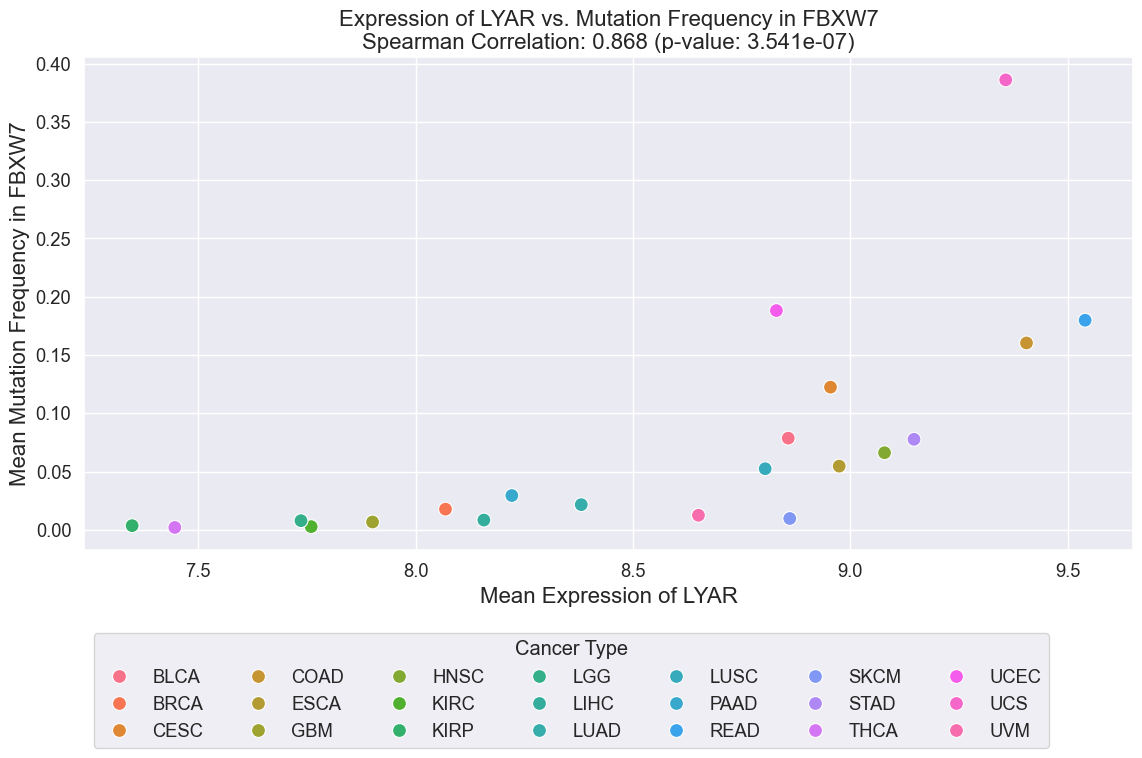

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr

def create_spearman_plot(driver, neighbor_gene, mutationtab, tumourexp):
    # Filtrar por cancer_type que tenha pelo menos uma mutação no driver
    mutationtab_filtered = mutationtab.groupby('cancer_type').filter(lambda x: x[driver].sum() > 0)
    tumourexp_filtered = tumourexp.loc[mutationtab_filtered.index]

    # Obter as médias das mutações e expressão por tipo de câncer
    grouped_data_mut = mutationtab_filtered.groupby('cancer_type')[driver].mean()
    grouped_data_exp = tumourexp_filtered.groupby('cancer_type')[neighbor_gene].mean()

    # Combinar os dados em um DataFrame
    grouped_data = pd.DataFrame({
        'mean_mutation': grouped_data_mut,
        'mean_expression': grouped_data_exp
    }).reset_index()

    # Calcular a correlação de Spearman
    correlation, p_value = spearmanr(grouped_data['mean_expression'], grouped_data['mean_mutation'])

    # Plotar os dados
    plt.figure(figsize=(12, 8))
    sns.set(font_scale=1.2)  

    sns.scatterplot(x='mean_expression', y='mean_mutation', data=grouped_data, hue='cancer_type', s=100)

    plt.title(f'Expression of {neighbor_gene} vs. Mutation Frequency in {driver}\n'
              f'Spearman Correlation: {correlation:.3f} (p-value: {p_value:.3e})', fontsize=16)
    plt.xlabel(f'Mean Expression of {neighbor_gene}', fontsize=16)
    plt.ylabel(f'Mean Mutation Frequency in {driver}', fontsize=16)

    plt.legend(title='Cancer Type', bbox_to_anchor=(0, -0.15), loc='upper left', ncol=7)

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
create_spearman_plot('FBXW7', 'LYAR', mutationtab, tumourexp)


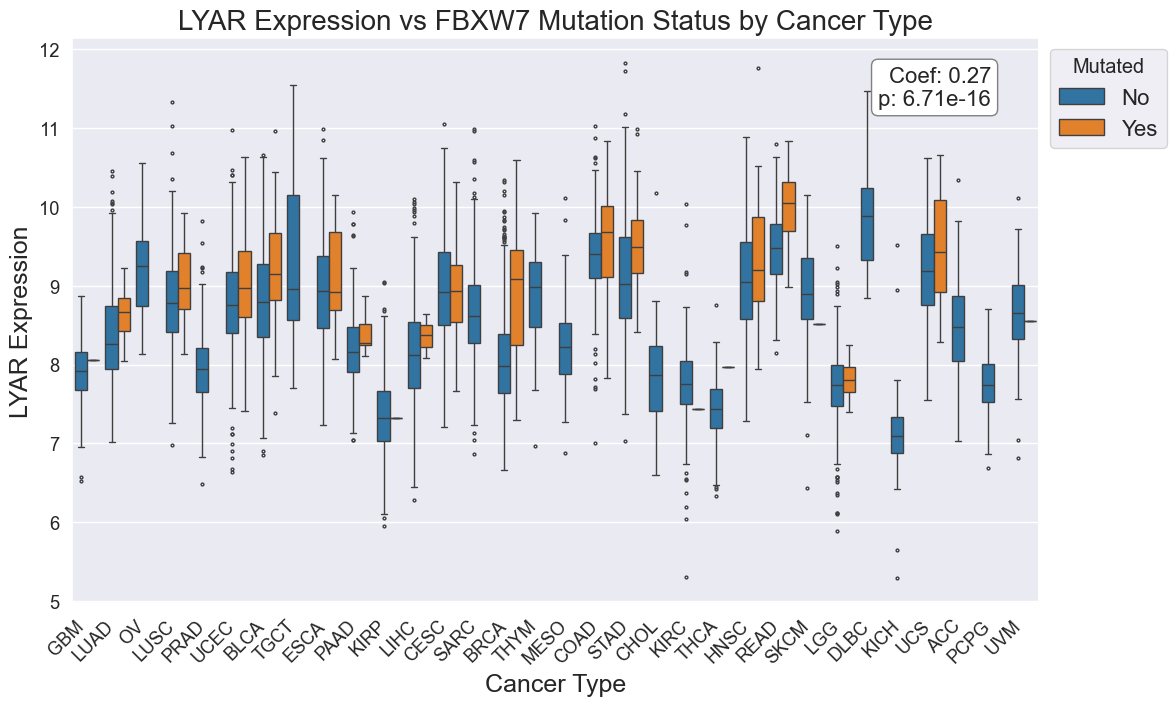

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_ols_boxplots(driver, neighbor_gene, coef, p_value, mutationtab, tumourexp):
    # Verificar se as colunas driver e neighbor_gene estão nos DataFrames
    if driver not in mutationtab.columns or neighbor_gene not in tumourexp.columns:
        print(f"Erro: {driver} ou {neighbor_gene} não encontrados nos dados.")
        return
    
    # Extrair a coluna de status de mutação do gene driver e a expressão do gene vizinho
    mutation_status = mutationtab[driver]
    gene_expression = tumourexp[neighbor_gene]
    
    # Criar um DataFrame combinando a expressão, status de mutação, e tipo de câncer
    combined_data = pd.DataFrame({
        'cancer_type': mutationtab.index.get_level_values('cancer_type'),
        'expression': gene_expression,
        'mutated': mutation_status
    })

    # Plotar os dados
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e']
    
    sns.boxplot(x='cancer_type', y='expression', hue='mutated', data=combined_data, palette=colors, fliersize=2, ax=ax)
    
    ax.set_title(f'{neighbor_gene} Expression vs {driver} Mutation Status by Cancer Type', fontsize=20)
    ax.set_xlabel('Cancer Type', fontsize=18)
    ax.set_ylabel(f'{neighbor_gene} Expression', fontsize=18)
    plt.xticks(rotation=45, ha='right')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['No', 'Yes'], title='Mutated', loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    
    # Adicionar a anotação com o coeficiente e o p-valor fornecidos
    ax.annotate(f'Coef: {coef:.2f}\np: {p_value:.2e}', 
                xy=(0.95, 0.95), 
                xycoords='axes fraction',
                ha='right', 
                va='top', 
                fontsize=16, 
                bbox=dict(boxstyle='round', fc='white', ec='gray'))
    
    plt.show()

# Exemplo de uso:
# Assumindo que você tem um DataFrame `results` com os valores calculados
# E que você quer filtrar os resultados para obter coeficiente e p-valor para 'FBXW7' e 'LYAR'

# Filtrando o DataFrame `results`
filtered_result = dints[(dints['driver'] == 'FBXW7') & (dints['neighbour'] == 'LYAR')]

# Extraindo o coeficiente e o p-valor
coef = filtered_result['coef'].values[0]
p_value = filtered_result['coef_pval'].values[0]

# Usar a função com os dados filtrados
create_ols_boxplots('FBXW7', 'LYAR', coef, p_value, mutationtab, tumourexp)

In [37]:
""" import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

# Função para contar interações significativas
def count_significant_interactions(df):
    significant = df[(df['rho_pval'] < 0.05) & (df['coef_pval'] < 0.05)]
    positive = significant[significant['rho'] > 0]
    negative = significant[significant['rho'] < 0]
    return len(significant), len(positive), len(negative)

# Contar interações para resultados não filtrados
total_sig, total_pos, total_neg = count_significant_interactions(results)

# Aplicar filtros
rhosign = results.rho_pval < 0.05
coefsign = results.coef_pval < 0.05
#equalsignal = (results.rho/results.rho.abs()) == (results.coef/results.coef.abs())
#coefdiffnotsign = results.coef_diff_pval >= 0.05
#distinctsign = (results.coef/results.coef.abs()) != (results.coef_diff/results.coef_diff.abs())

resultsfilt = results[rhosign & coefsign]

# Contar interações para resultados filtrados
filtered_sig, filtered_pos, filtered_neg = count_significant_interactions(resultsfilt)

# Filtrar resultados combinados
nonsignificant = results[(results['rho_pval'] >= 0.05) | (results['coef_pval'] >= 0.05)]

neighbour_driver_counts = resultsfiltered.groupby('neighbour')['driver'].nunique().reset_index()
neighbour_driver_counts.columns = ['neighbour', 'unique_drivers_count']

neighbours_with_sufficient_interactions = neighbour_driver_counts[neighbour_driver_counts['unique_drivers_count'] >= 2]

filtered_resultsfiltered_initial = resultsfiltered[resultsfiltered['neighbour'].isin(neighbours_with_sufficient_interactions['neighbour'])]

driver_neighbour_counts = filtered_resultsfiltered_initial.groupby('driver')['neighbour'].nunique().reset_index()
driver_neighbour_counts.columns = ['driver', 'unique_neighbours_count']

drivers_with_multiple_neighbours = driver_neighbour_counts[driver_neighbour_counts['unique_neighbours_count'] > 1]

filtered_resultsfiltered_initial = filtered_resultsfiltered_initial[filtered_resultsfiltered_initial['driver'].isin(drivers_with_multiple_neighbours['driver'])]

combined_results = pd.concat([filtered_resultsfiltered_initial, nonsignificant], ignore_index=True)

# Função para criar diagrama de Venn
def create_venn(ax, subsets, labels, title, total=None):
    v = venn2(subsets=subsets, set_labels=labels, ax=ax, 
              set_colors=('#1b9e77', '#d95f02'), alpha=0.7)
    venn2_circles(subsets, ax=ax, linestyle='solid', linewidth=2, color='gray')
    
    if v.patches[2]:
        v.patches[2].set_color('#7570b3')
    
    for text in v.set_labels:
        text.set_fontsize(16)
    
    for i, text in enumerate(v.subset_labels):
        if text:
            count = int(text.get_text())
            if total and i < 2:
                percentage = (count / total) * 100
                text.set_text(f'{count}\n({percentage:.1f}%)')
            text.set_fontsize(14)
    
    ax.set_title(title, fontsize=18, fontweight='bold')

# Criar a figura
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))

# Diagramas para resultados não filtrados
create_venn(ax1, (total_pos, total_neg, 0), ('Positive', 'Negative'), 'Unfiltered Significant Interactions', total_sig)
create_venn(ax2, (total_sig, len(results) - total_sig, 0), ('Significant', 'Non-significant'), 'Unfiltered Total Interactions', len(results))

# Diagramas para resultados filtrados
filtered_sig, filtered_pos, filtered_neg = count_significant_interactions(combined_results)

create_venn(ax3, (filtered_pos, filtered_neg, 0), ('Positive', 'Negative'), 'Filtered Significant Interactions', filtered_sig)
create_venn(ax4, (filtered_sig, len(resultsfilt) - filtered_sig, 0), ('Significant', 'Non-significant'), 'Filtered Total Interactions', len(resultsfilt))

plt.tight_layout()
plt.show() """

" import pandas as pd\nimport matplotlib.pyplot as plt\nfrom matplotlib_venn import venn2, venn2_circles\n\n# Função para contar interações significativas\ndef count_significant_interactions(df):\n    significant = df[(df['rho_pval'] < 0.05) & (df['coef_pval'] < 0.05)]\n    positive = significant[significant['rho'] > 0]\n    negative = significant[significant['rho'] < 0]\n    return len(significant), len(positive), len(negative)\n\n# Contar interações para resultados não filtrados\ntotal_sig, total_pos, total_neg = count_significant_interactions(results)\n\n# Aplicar filtros\nrhosign = results.rho_pval < 0.05\ncoefsign = results.coef_pval < 0.05\n#equalsignal = (results.rho/results.rho.abs()) == (results.coef/results.coef.abs())\n#coefdiffnotsign = results.coef_diff_pval >= 0.05\n#distinctsign = (results.coef/results.coef.abs()) != (results.coef_diff/results.coef_diff.abs())\n\nresultsfilt = results[rhosign & coefsign]\n\n# Contar interações para resultados filtrados\nfiltered_sig, fil

In [38]:
# Função para criar diagrama de Venn
def create_venn(ax, subsets, labels, title, total=None):
    v = venn2(subsets=subsets, set_labels=labels, ax=ax, 
              set_colors=('#1b9e77', '#d95f02'), alpha=0.7)
    venn2_circles(subsets, ax=ax, linestyle='solid', linewidth=2, color='gray')
    
    if v.patches[2]:
        v.patches[2].set_color('#7570b3')
    
    for text in v.set_labels:
        text.set_fontsize(16)
    
    for i, text in enumerate(v.subset_labels):
        if text:
            count = int(text.get_text())
            if total and i < 2:
                percentage = (count / total) * 100
                text.set_text(f'{count}\n({percentage:.1f}%)')
            text.set_fontsize(14)
    
    ax.set_title(title, fontsize=18, fontweight='bold')

# Criar a figura
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))

# Diagramas para resultados não filtrados
create_venn(ax1, (total_pos, total_neg, 0), ('Positive', 'Negative'), 'Unfiltered Significant Interactions', total_sig)
create_venn(ax2, (total_sig, len(results) - total_sig, 0), ('Significant', 'Non-significant'), 'Unfiltered Total Interactions', len(results))

# Diagramas para resultados filtrados
filtered_sig, filtered_pos, filtered_neg = count_significant_interactions(dints)

create_venn(ax3, (filtered_pos, filtered_neg, 0), ('Positive', 'Negative'), 'Filtered Significant Interactions', filtered_sig)
create_venn(ax4, (filtered_sig, len(results) - filtered_sig, 0), ('Significant', 'Non-significant'), 'Filtered Total Interactions', len(results))

plt.tight_layout()
plt.show()

" # Função para criar diagrama de Venn\ndef create_venn(ax, subsets, labels, title, total=None):\n    v = venn2(subsets=subsets, set_labels=labels, ax=ax, \n              set_colors=('#1b9e77', '#d95f02'), alpha=0.7)\n    venn2_circles(subsets, ax=ax, linestyle='solid', linewidth=2, color='gray')\n    \n    if v.patches[2]:\n        v.patches[2].set_color('#7570b3')\n    \n    for text in v.set_labels:\n        text.set_fontsize(16)\n    \n    for i, text in enumerate(v.subset_labels):\n        if text:\n            count = int(text.get_text())\n            if total and i < 2:\n                percentage = (count / total) * 100\n                text.set_text(f'{count}\n({percentage:.1f}%)')\n            text.set_fontsize(14)\n    \n    ax.set_title(title, fontsize=18, fontweight='bold')\n\n# Criar a figura\nfig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))\n\n# Diagramas para resultados não filtrados\ncreate_venn(ax1, (total_pos, total_neg, 0), ('Positive', 'Negative

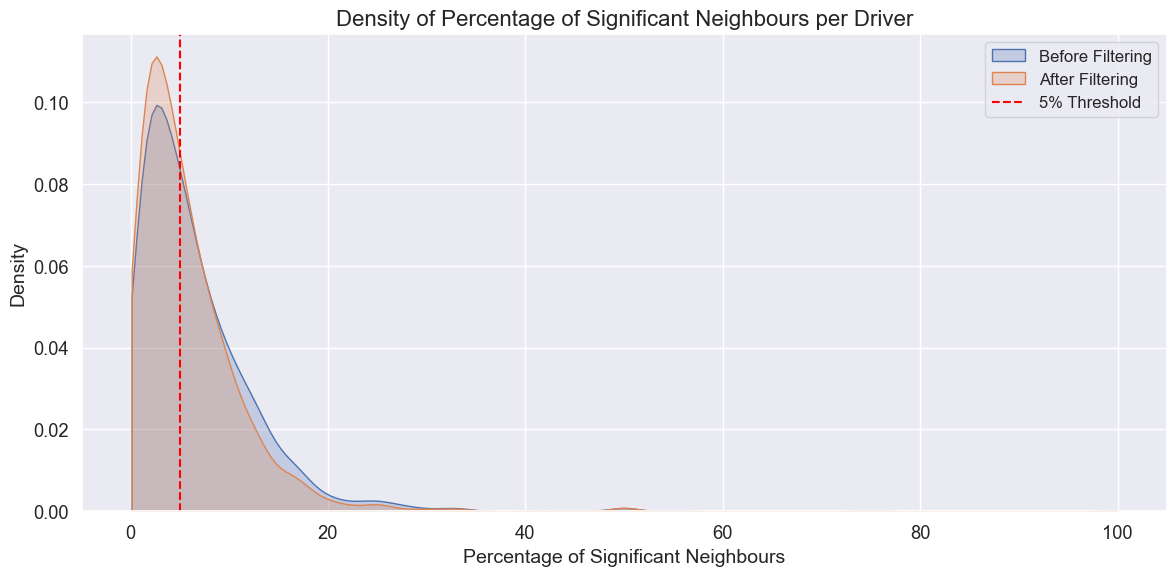

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define significant neighbors before filtering
rhosign = results.rho_pval < 0.05
coefsign = results.coef_pval < 0.05
equalsignal = (results.rho / results.rho.abs()) == (results.coef / results.coef.abs())
significant_before = results[rhosign & coefsign & equalsignal]

# Calculate percentage of significant neighbors per driver
total_neighbors = results.groupby('driver').size()
significant_neighbors_before = significant_before.groupby('driver').size()
significant_neighbors_after = dints.groupby('driver').size()

# Calculate percentages
percentage_before = (significant_neighbors_before / total_neighbors) * 100
percentage_after = (significant_neighbors_after / total_neighbors) * 100

# Create the density plot
plt.figure(figsize=(12, 6))

sns.kdeplot(percentage_before, fill=True, label='Before Filtering', cut=0)
sns.kdeplot(percentage_after, fill=True, label='After Filtering', cut=0)

plt.title('Density of Percentage of Significant Neighbours per Driver', fontsize=16)
plt.xlabel('Percentage of Significant Neighbours', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)

# Add a vertical line at 5%
plt.axvline(x=5, color='red', linestyle='--', label='5% Threshold')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


## Significant DINTs

In [40]:
hallmarks_df = pd.read_excel('hallmarks_to_goterms.xlsx')
hallmarks_df['Hallmarks'] = hallmarks_df['Hallmarks'].str.strip()
hallmarks_df['GO terms'] = hallmarks_df['GO terms'].str.strip()
hallmarks_df['Term name'] = hallmarks_df['Term name'].str.strip()

In [41]:
background = []
for net in networks:
    ppi = pd.read_csv(datadir + f"{net}_graph.csv")
    # Extract unique proteins from both columns of the PPI network
    gene_names = pd.concat([ppi.iloc[:, 0], ppi.iloc[:, 1]]).drop_duplicates().tolist()
    background.extend(gene_names)

# Remove duplicates to get the final background set
background = list(set(background))

print(f'Total number of unique proteins in background: {len(background)}')

Total number of unique proteins in background: 20142


## Expression Analysis

### POS VS NEG

In [42]:
""" # Contar o número único de drivers para cada vizinho, sem filtrar
vizinho_contagem = dints.groupby('neighbour')['driver'].nunique()

# Filtrar apenas os vizinhos que estão na lista final_neighbours_list
vizinho_contagem_filtrado = vizinho_contagem[vizinho_contagem.index.isin(final_neighbours_list)]

# Calcular a média de vezes que os vizinhos da lista final_neighbours_list são vizinhos de drivers
media_vizinho_drivers = vizinho_contagem_filtrado.mean()

print(f"A média de vezes que os vizinhos da lista final são vizinhos de drivers é: {media_vizinho_drivers:.2f}") """

' # Contar o número único de drivers para cada vizinho, sem filtrar\nvizinho_contagem = dints.groupby(\'neighbour\')[\'driver\'].nunique()\n\n# Filtrar apenas os vizinhos que estão na lista final_neighbours_list\nvizinho_contagem_filtrado = vizinho_contagem[vizinho_contagem.index.isin(final_neighbours_list)]\n\n# Calcular a média de vezes que os vizinhos da lista final_neighbours_list são vizinhos de drivers\nmedia_vizinho_drivers = vizinho_contagem_filtrado.mean()\n\nprint(f"A média de vezes que os vizinhos da lista final são vizinhos de drivers é: {media_vizinho_drivers:.2f}") '

In [43]:
""" # Contar o número único de drivers para cada vizinho
vizinho_contagem = dints.groupby('neighbour')['driver'].nunique()

# Identificar vizinhos significativos (aqueles com pelo menos um DINT)
vizinhos_significativos = filt_neighbours[filt_neighbours['n_dints'] > 1]['neighbour']

# Filtrar apenas os vizinhos significativos
vizinho_contagem_filtrado = vizinho_contagem[vizinho_contagem.index.isin(vizinhos_significativos)]

# Calcular a média de vezes que os vizinhos significativos são vizinhos de drivers
media_vizinho_drivers = vizinho_contagem_filtrado.mean()

print(f"A média de vezes que os vizinhos significativos são vizinhos de drivers é: {media_vizinho_drivers:.2f}")
 """

A média de vezes que os vizinhos significativos são vizinhos de drivers é: 7.86


In [44]:
""" # Contar o número único de drivers para cada vizinho
vizinho_contagem = dints.groupby('neighbour')['driver'].nunique()

# Identificar vizinhos significativos (aqueles com pelo menos um DINT)
vizinhos_significativos = filt_neighbours[filt_neighbours['n_dints'] > 0]['neighbour']

# Filtrar apenas os vizinhos significativos
vizinho_contagem_filtrado = vizinho_contagem[vizinho_contagem.index.isin(vizinhos_significativos)]

# Calcular a média de vezes que os vizinhos significativos são vizinhos de drivers
media_vizinho_drivers = vizinho_contagem_filtrado.mean()

print(f"A média de vezes que os vizinhos significativos são vizinhos de drivers é: {media_vizinho_drivers:.2f}") """

A média de vezes que os vizinhos significativos são vizinhos de drivers é: 4.55


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/3631682388.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neighbour_consistency = dints.groupby('neighbour').apply(check_sign_consistency)


1727
1378
Shapiro-Wilk Test: Statistics=0.7582512205459512, p-value=1.0641557582338755e-44
Shapiro-Wilk Test: Statistics=0.9307081353097414, p-value=9.164445418586214e-25
Levene's Test: Statistics=72.54611114413035, p-value=2.505923404728892e-17

P-value for normality for positive neighbours: 1.0641557582338755e-44
P-value for normality for negative neighbours: 9.164445418586214e-25
P-value for homoscedasticity: 2.505923404728892e-17


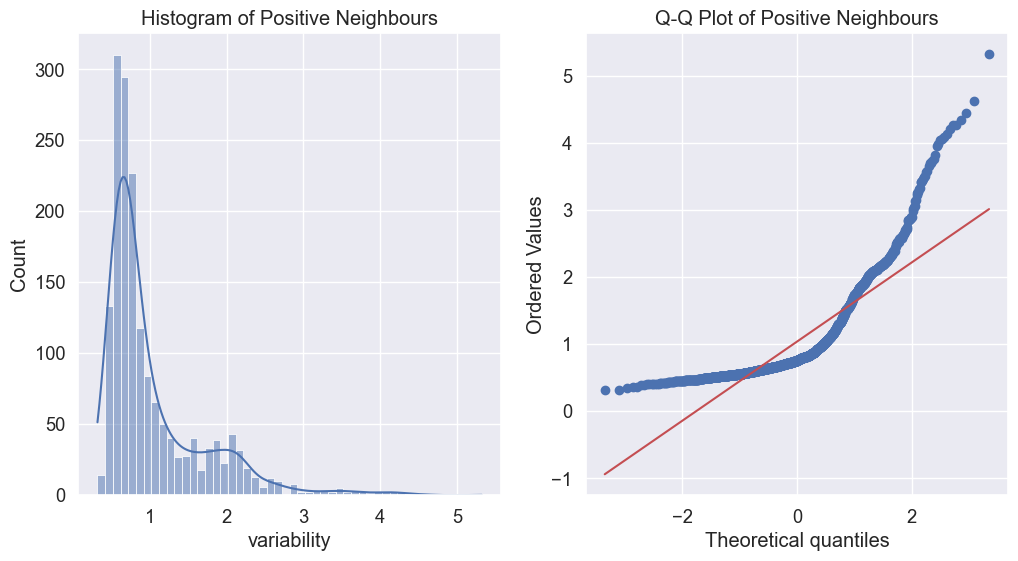

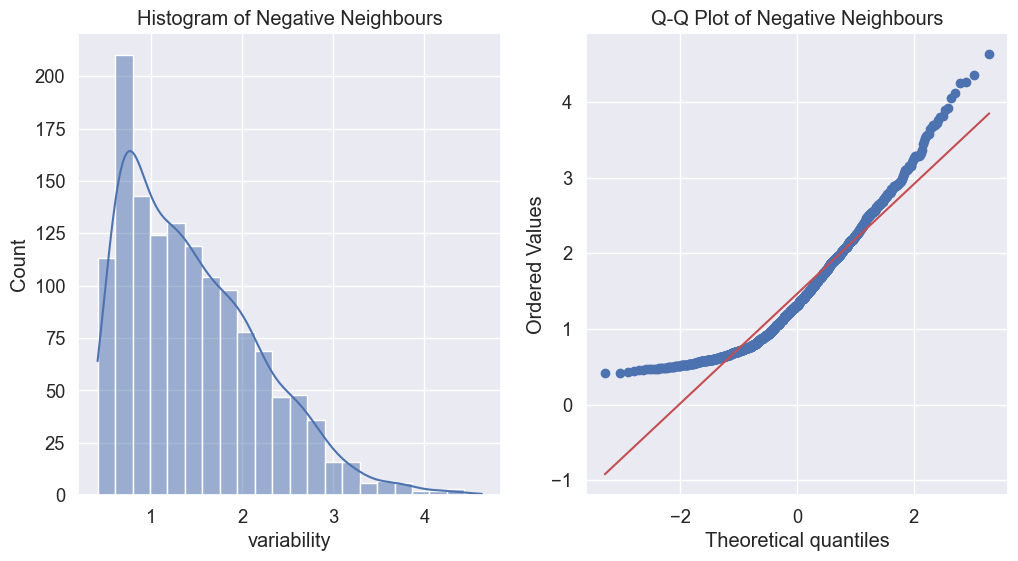


Using the Mann-Whitney U test:
U Statistic: 716592.0
P-value: 4.428553246089881e-81

Correlation between gene expression variability and number of associated drivers for positive neighbours: 0.07798067503135232
Correlation between gene expression variability and number of associated drivers for negative neighbours: 0.06576893239751627


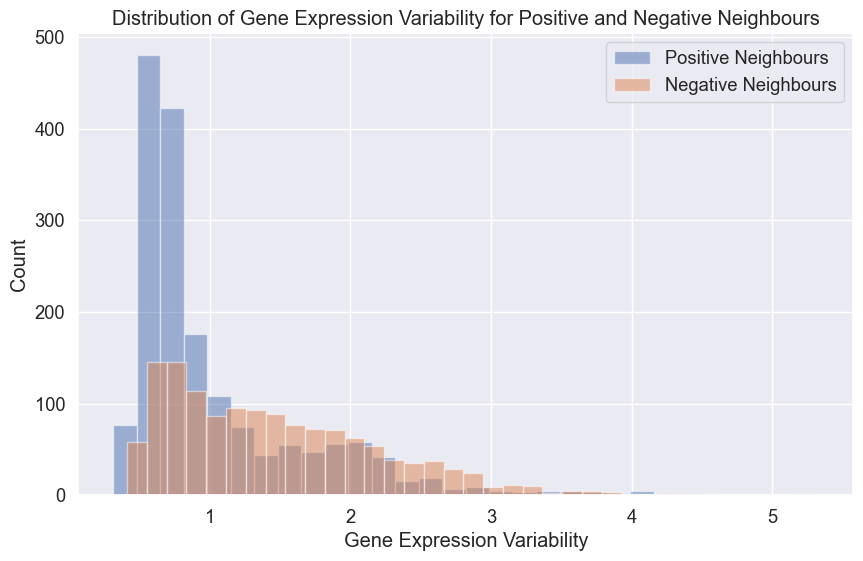

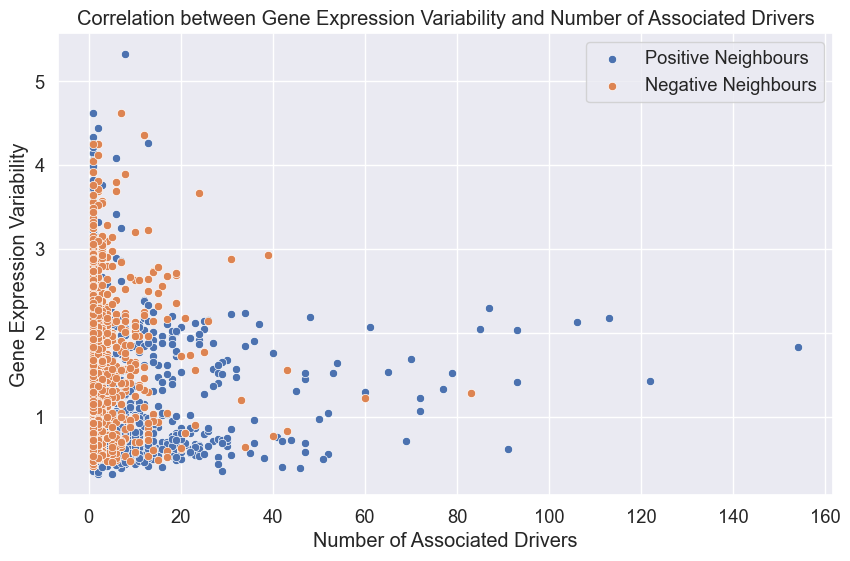

In [45]:
# Auxiliary Functions
def check_sign_consistency(group):
    signs = np.sign(group['coef'])
    return (signs == signs.iloc[0]).all()

def calculate_variability(df, neighbour):
    return df[neighbour].std()

def get_association_type(neighbour, filtered_results):
    coef = filtered_results[filtered_results['neighbour'] == neighbour]['coef'].iloc[0]
    return 'Positive' if coef > 0 else 'Negative'

def check_normality(data):
    stat, p_value = stats.shapiro(data)
    print(f"Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}")
    return p_value

def check_homogeneity_of_variances(group1, group2):
    stat, p_value = stats.levene(group1, group2)
    print(f"Levene's Test: Statistics={stat}, p-value={p_value}")
    return p_value

def plot_normality(data, label):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {label}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {label}')
    plt.show()

# Analysis of Consistent Neighbours
neighbour_consistency = dints.groupby('neighbour').apply(check_sign_consistency)
driver_counts = dints.groupby('neighbour')['driver'].nunique()

neighbour_analysis = pd.DataFrame({
    'num_associated_drivers': driver_counts,
    'is_consistent': neighbour_consistency
})

consistent_neighbours = neighbour_analysis[neighbour_analysis['is_consistent']].copy()
consistent_neighbours['association_type'] = consistent_neighbours.index.map(lambda x: get_association_type(x, dints))
consistent_neighbours = consistent_neighbours.reset_index()

# Calculation of Variability
variability_list = [calculate_variability(tumourexp, neighbour) for neighbour in consistent_neighbours['neighbour']]
variability_df = pd.DataFrame(variability_list, index=consistent_neighbours['neighbour'], columns=['variability'])

variability_df['association_type'] = variability_df.index.map(lambda x: get_association_type(x, dints))
variability_df['num_associated_drivers'] = consistent_neighbours.set_index('neighbour')['num_associated_drivers']

only_pos_variability = variability_df[variability_df['association_type'] == 'Positive']
print(len(only_pos_variability))
only_neg_variability = variability_df[variability_df['association_type'] == 'Negative']
print(len(only_neg_variability))

# Statistical Tests
p_value_pos_normality = check_normality(only_pos_variability['variability'])
p_value_neg_normality = check_normality(only_neg_variability['variability'])
p_value_pos_variance = check_homogeneity_of_variances(only_pos_variability['variability'], only_neg_variability['variability'])

print(f"\nP-value for normality for positive neighbours: {p_value_pos_normality}")
print(f"P-value for normality for negative neighbours: {p_value_neg_normality}")
print(f"P-value for homoscedasticity: {p_value_pos_variance}")

plot_normality(only_pos_variability['variability'], 'Positive Neighbours')
plot_normality(only_neg_variability['variability'], 'Negative Neighbours')

# Use Mann-Whitney U if normality is not met or variances are different
if p_value_pos_normality < 0.05 or p_value_neg_normality < 0.05 or p_value_pos_variance < 0.05:
    u_stat, u_p_value = stats.mannwhitneyu(only_pos_variability['variability'], only_neg_variability['variability'])
    print(f"\nUsing the Mann-Whitney U test:")
    print(f"U Statistic: {u_stat}")
    print(f"P-value: {u_p_value}")
else:
    t_stat, t_p_value = stats.ttest_ind(only_pos_variability['variability'], only_neg_variability['variability'])
    print(f"\nUsing the t-test:")
    print(f"t Statistic: {t_stat}")
    print(f"P-value: {t_p_value}")

# Correlation between variability and number of associated drivers
correlation_pos = only_pos_variability['variability'].corr(only_pos_variability['num_associated_drivers'])
correlation_neg = only_neg_variability['variability'].corr(only_neg_variability['num_associated_drivers'])

print(f"\nCorrelation between gene expression variability and number of associated drivers for positive neighbours: {correlation_pos}")
print(f"Correlation between gene expression variability and number of associated drivers for negative neighbours: {correlation_neg}")

# Visualisation of variability
plt.figure(figsize=(10, 6))
plt.hist(only_pos_variability['variability'], bins=30, alpha=0.5, label='Positive Neighbours')
plt.hist(only_neg_variability['variability'], bins=30, alpha=0.5, label='Negative Neighbours')
plt.xlabel('Gene Expression Variability')
plt.ylabel('Count')
plt.title('Distribution of Gene Expression Variability for Positive and Negative Neighbours')
plt.legend()
plt.show()

# Visualisation of correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=only_pos_variability['num_associated_drivers'], y=only_pos_variability['variability'], label='Positive Neighbours')
sns.scatterplot(x=only_neg_variability['num_associated_drivers'], y=only_neg_variability['variability'], label='Negative Neighbours')
plt.xlabel('Number of Associated Drivers')
plt.ylabel('Gene Expression Variability')
plt.title('Correlation between Gene Expression Variability and Number of Associated Drivers')
plt.legend()
plt.show()


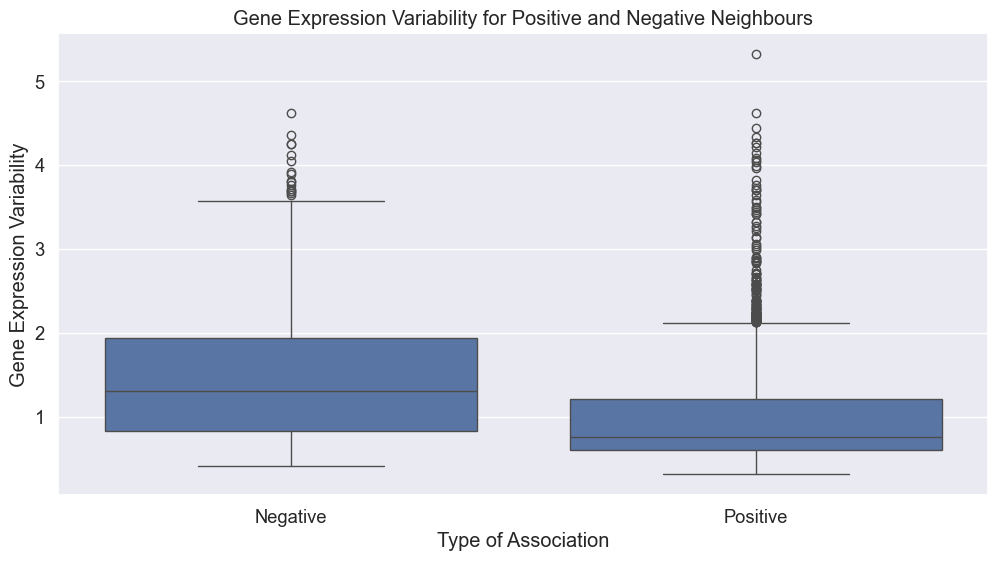

In [46]:
variability_df['association_type'] = variability_df['association_type'].map(lambda x: 'Positive' if x == 'Positive' else 'Negative')

# Plot box plot for variability
plt.figure(figsize=(12, 6))
sns.boxplot(x='association_type', y='variability', data=variability_df)
plt.xlabel('Type of Association')
plt.ylabel('Gene Expression Variability')
plt.title('Gene Expression Variability for Positive and Negative Neighbours')
plt.show()


In [338]:
# Calculando as expressões médias e medianas para os vizinhos positivos e negativos
mean_expression_positive = tumourexp[only_pos_variability.index].mean(axis=0)
mean_expression_negative = tumourexp[only_neg_variability.index].mean(axis=0)

mean_pos_exp = np.mean(mean_expression_positive)
mean_neg_exp = np.mean(mean_expression_negative)
median_pos_exp = np.median(mean_expression_positive)
median_neg_exp = np.median(mean_expression_negative)

print(f"\nMean gene expression (Positive Neighbours): {mean_pos_exp:.4f}")
print(f"Mean gene expression (Negative Neighbours): {mean_neg_exp:.4f}")
print(f"Median gene expression (Positive Neighbours): {median_pos_exp:.4f}")
print(f"Median gene expression (Negative Neighbours): {median_neg_exp:.4f}")

# Teste estatístico para comparar as expressões génicas entre positivos e negativos
u_stat_exp, p_value_exp = stats.mannwhitneyu(mean_expression_positive, mean_expression_negative)
print(f"\nU-statistic for gene expression comparison: {u_stat_exp}")
print(f"P-value for gene expression comparison: {p_value_exp}")
if p_value_exp < 0.05:
    print("There is a statistically significant difference in mean gene expression levels between positive and negative neighbours.")
else:
    print("No statistically significant difference in mean gene expression levels between positive and negative neighbours.")


Mean gene expression (Positive Neighbours): 9.4254
Mean gene expression (Negative Neighbours): 8.1843
Median gene expression (Positive Neighbours): 9.6891
Median gene expression (Negative Neighbours): 8.5619

U-statistic for gene expression comparison: 1530654.0
P-value for gene expression comparison: 6.757185720072671e-43
There is a statistically significant difference in mean gene expression levels between positive and negative neighbours.


### SIG VS NON SIG

#### Filtered

P-value for homoscedasticity: 1.0140250614527672e-05


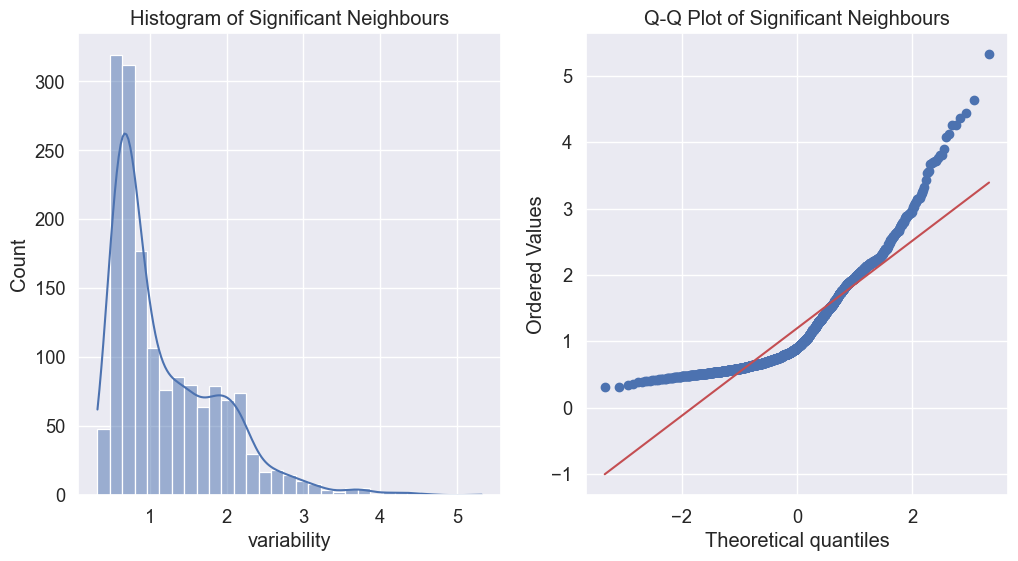

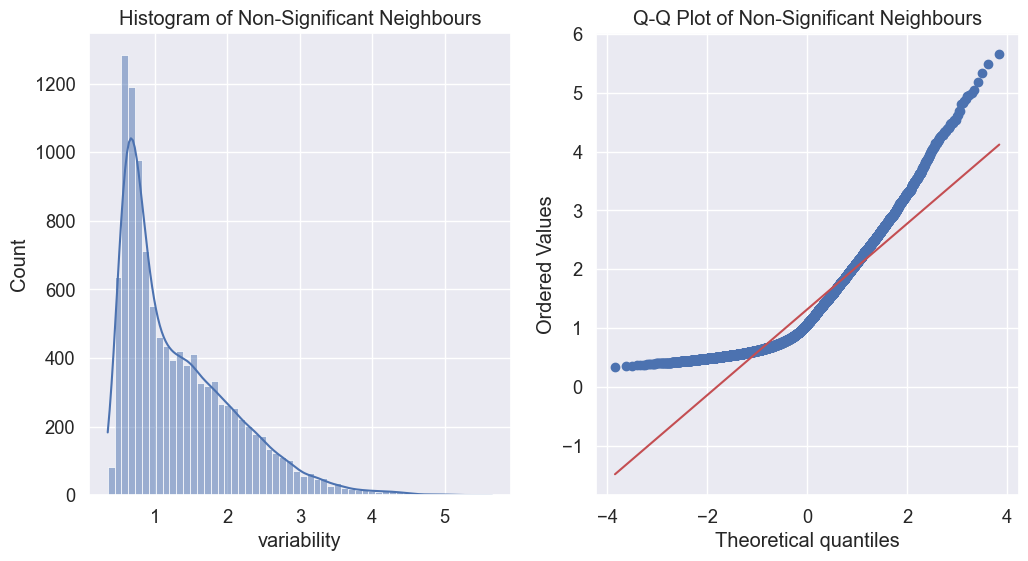

P-value for KS test (Significant): 0.0
P-value for KS test (Non-Significant): 0.0
Using Mann-Whitney U test:
U Statistic: 8308267.0
P-value: 5.043197301954638e-11


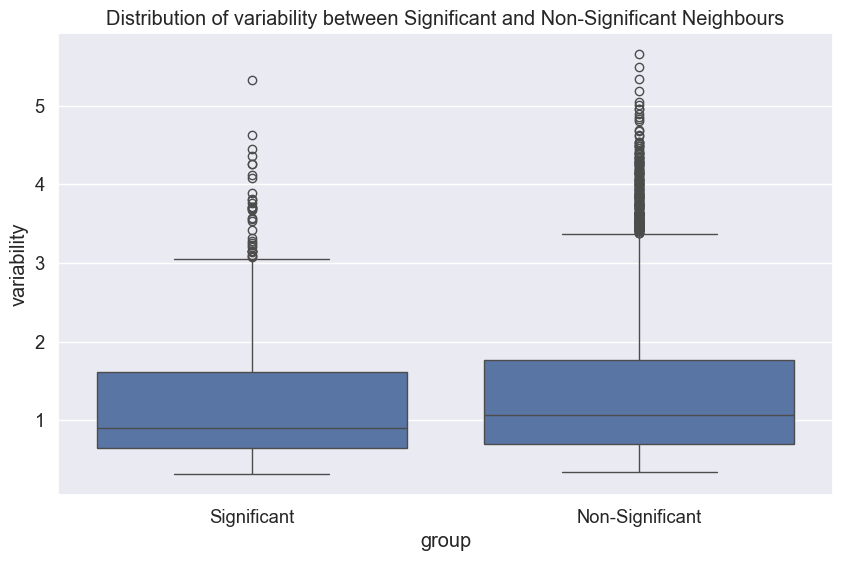

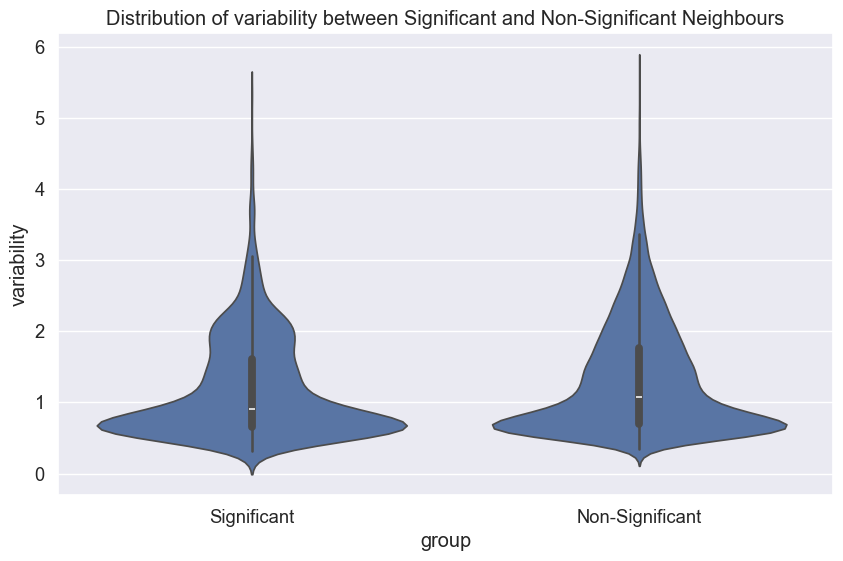

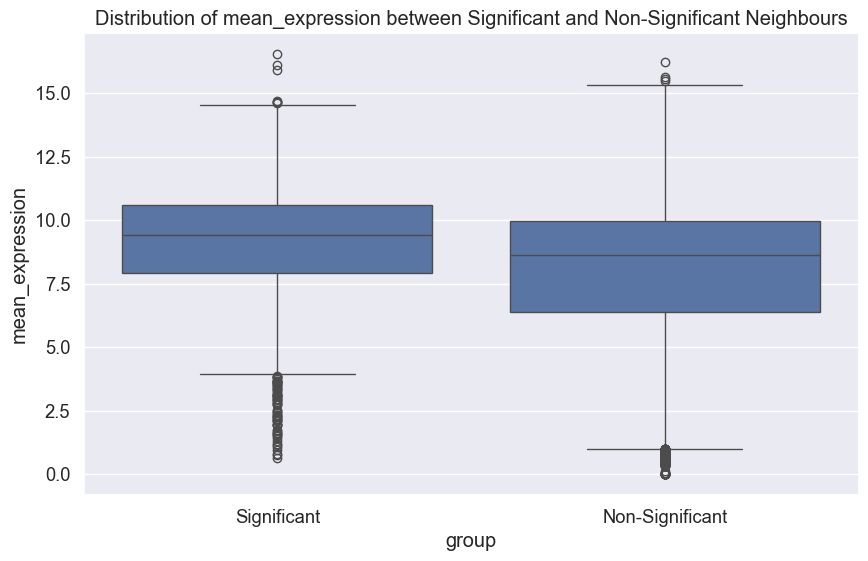

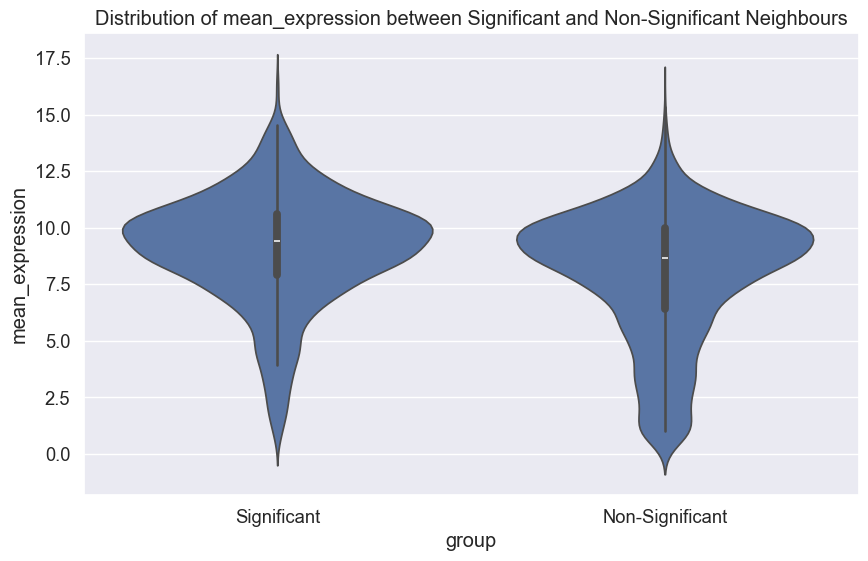

Mean gene expression (Significant): 9.0901
Mean gene expression (Non-Significant): 7.9389
Median gene expression (Significant): 9.4150
Median gene expression (Non-Significant): 8.6500
U-statistic: 11273338.0
P-value: 1.3471231752589784e-46
There is a statistically significant difference in mean expression levels.
Cohen's d: 0.4247
Rank Biserial Correlation: -0.2200


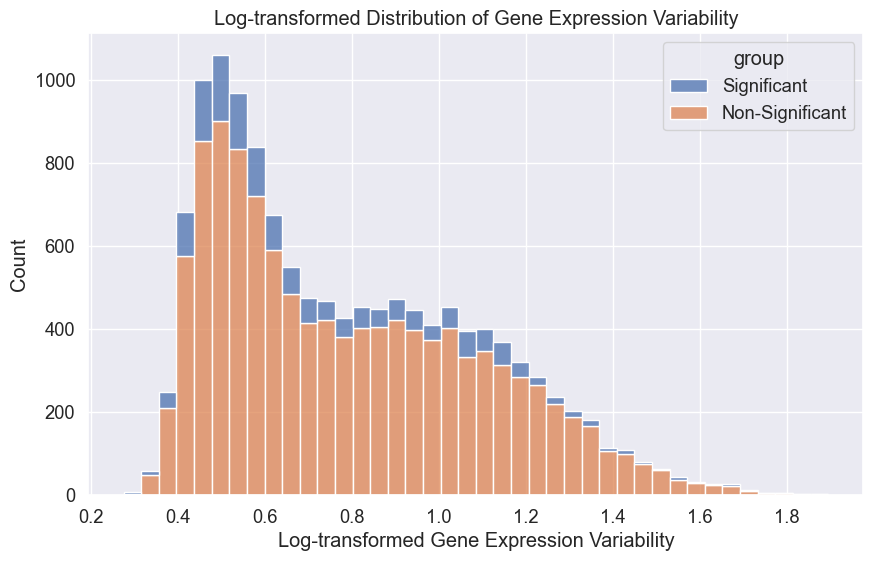

P-value for KS test after log transformation (Significant): 0.0
P-value for KS test after log transformation (Non-Significant): 0.0
P-value for homoscedasticity after log transformation: 0.00027268378183552863
Using Mann-Whitney U test after log transformation:
U Statistic: 8308267.0
P-value: 5.043197301954638e-11


In [47]:
#### RETIRAR DOCUMENTAÇÃO DAQUI PARA BAIXO ####

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Auxiliary Functions
def calculate_variability(df, neighbour):
    """Calculate standard deviation across all patients for a given gene (neighbour)."""
    if neighbour not in df.columns:
        raise ValueError(f"Neighbour '{neighbour}' not found in the dataframe.")
    return df[neighbour].std()

def check_homogeneity_of_variances(group1, group2):
    """Check homogeneity of variances using Levene's test."""
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    stat, p_value = stats.levene(group1, group2)
    return p_value

def test_ks(data):
    """Kolmogorov-Smirnov test for checking normality."""
    if len(data) == 0:
        raise ValueError("Data is empty.")
    stat, p_value = stats.kstest(data, 'norm')
    return p_value

def plot_distribution(data, label):
    """Plot histogram and Q-Q plot for a dataset."""
    if len(data) == 0:
        raise ValueError("Data is empty.")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {label}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {label}')
    plt.show()

def compare_groups(variability_df, group_col='group', value_col='variability'):
    """Perform statistical tests and plot distributions between significant and non-significant groups."""
    if group_col not in variability_df.columns or value_col not in variability_df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    # Variance check
    p_value_variance = check_homogeneity_of_variances(
        variability_df[variability_df[group_col] == 'Significant'][value_col],
        variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
    )
    
    print(f"P-value for homoscedasticity: {p_value_variance}")
    
    # Plot distributions
    plot_distribution(variability_df[variability_df[group_col] == 'Significant'][value_col], 'Significant Neighbours')
    plot_distribution(variability_df[variability_df[group_col] == 'Non-Significant'][value_col], 'Non-Significant Neighbours')
    
    # Kolmogorov-Smirnov Test
    ks_p_value_sig = test_ks(variability_df[variability_df[group_col] == 'Significant'][value_col])
    ks_p_value_non_sig = test_ks(variability_df[variability_df[group_col] == 'Non-Significant'][value_col])
    print(f"P-value for KS test (Significant): {ks_p_value_sig}")
    print(f"P-value for KS test (Non-Significant): {ks_p_value_non_sig}")
    
    # Choose appropriate test (Mann-Whitney U or t-test)
    if ks_p_value_sig < 0.05 or ks_p_value_non_sig < 0.05 or p_value_variance < 0.05:
        # If data is not normal or variances are not homogeneous, use Mann-Whitney U test
        u_stat, u_p_value = stats.mannwhitneyu(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using Mann-Whitney U test:\nU Statistic: {u_stat}\nP-value: {u_p_value}")
    else:
        # If data is normal and variances are homogeneous, use t-test
        t_stat, t_p_value = stats.ttest_ind(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using t-test:\nt Statistic: {t_stat}\nP-value: {t_p_value}")

def plot_group_comparison(df, value_col, group_col='group'):
    """Plot boxplot and violin plot for group comparison."""
    if group_col not in df.columns or value_col not in df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_col, y=value_col, data=df)
    plt.title(f'Distribution of {value_col} between Significant and Non-Significant Neighbours')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=group_col, y=value_col, data=df)
    plt.title(f'Distribution of {value_col} between Significant and Non-Significant Neighbours')
    plt.show()

def calculate_effect_size(group1, group2):
    """Calculate Cohen's d for effect size."""
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
    return diff / pooled_std

def calculate_rank_biserial_correlation(group1, group2):
    """Calculate rank biserial correlation."""
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    u_stat, _ = stats.mannwhitneyu(group1, group2)
    n1 = len(group1)
    n2 = len(group2)
    return 1 - (2 * u_stat / (n1 * n2))

# Main Analysis
def main():
    # Load data
    # Note: These lines assume that 'resultsfiltered', 'nonsignificant', and 'tumourexp' are loaded from somewhere
    # You might need to add code to load these dataframes from files
    # Calculate variability and mean expression
    try:
        variability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighbours_filt]
        variability_non_significant = [calculate_variability(tumourexp, neighbour) for neighbour in non_significant_neighbours_filt]
        mean_expression_significant = filt_neighbours[filt_neighbours['neighbour'].isin(significant_neighbours_filt)]['expression'].tolist()
        mean_expression_non_significant = filt_neighbours[filt_neighbours['neighbour'].isin(non_significant_neighbours_filt)]['expression'].tolist()
    except ValueError as e:
        print(f"Error in calculating variability or mean expression: {e}")
        return

    # Create DataFrame for analysis
    variability_df = pd.DataFrame({
        'neighbour': np.concatenate([significant_neighbours_filt, non_significant_neighbours_filt]),
        'variability': variability_significant + variability_non_significant,
        'group': ['Significant'] * len(variability_significant) + ['Non-Significant'] * len(variability_non_significant),
        'mean_expression': mean_expression_significant + mean_expression_non_significant
    })

    # Perform group comparison
    compare_groups(variability_df)
    plot_group_comparison(variability_df, 'variability')
    plot_group_comparison(variability_df, 'mean_expression')

    # Mean Gene Expression Analysis
    mean_sig = np.mean(mean_expression_significant)
    mean_non_sig = np.mean(mean_expression_non_significant)
    median_sig = np.median(mean_expression_significant)
    median_non_sig = np.median(mean_expression_non_significant)

    print(f"Mean gene expression (Significant): {mean_sig:.4f}")
    print(f"Mean gene expression (Non-Significant): {mean_non_sig:.4f}")
    print(f"Median gene expression (Significant): {median_sig:.4f}")
    print(f"Median gene expression (Non-Significant): {median_non_sig:.4f}")

    # Statistical comparison of mean gene expression
    sig_exp_levels = tumourexp[significant_neighbours_filt].mean(axis=0)
    non_sig_exp_levels = tumourexp[non_significant_neighbours_filt].mean(axis=0)

    u_stat, p_value = stats.mannwhitneyu(sig_exp_levels, non_sig_exp_levels, alternative='two-sided')
    print(f"U-statistic: {u_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("There is a statistically significant difference in mean expression levels.")
    else:
        print("No statistically significant difference in mean expression levels.")

    # Calculate effect size and rank biserial correlation
    cohen_d_value = calculate_effect_size(sig_exp_levels, non_sig_exp_levels)
    rank_biserial_corr = calculate_rank_biserial_correlation(sig_exp_levels, non_sig_exp_levels)

    print(f"Cohen's d: {cohen_d_value:.4f}")
    print(f"Rank Biserial Correlation: {rank_biserial_corr:.4f}")

    # Log transformation
    variability_df['log_variability'] = np.log1p(variability_df['variability'])

    # Plot log-transformed distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=variability_df, x='log_variability', hue='group', multiple='stack')
    plt.xlabel('Log-transformed Gene Expression Variability')
    plt.ylabel('Count')
    plt.title('Log-transformed Distribution of Gene Expression Variability')
    plt.show()

    # Re-run normality and variance tests after log transformation
    ks_p_value_sig_log = test_ks(variability_df[variability_df['group'] == 'Significant']['log_variability'])
    ks_p_value_non_sig_log = test_ks(variability_df[variability_df['group'] == 'Non-Significant']['log_variability'])

    print(f"P-value for KS test after log transformation (Significant): {ks_p_value_sig_log}")
    print(f"P-value for KS test after log transformation (Non-Significant): {ks_p_value_non_sig_log}")

    # Check homogeneity of variances using Levene's test after log transformation
    p_value_variance_log = check_homogeneity_of_variances(
        variability_df[variability_df['group'] == 'Significant']['log_variability'],
        variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
    )
    print(f"P-value for homoscedasticity after log transformation: {p_value_variance_log}")

    # Perform appropriate statistical test after log transformation
    if ks_p_value_sig_log < 0.05 or ks_p_value_non_sig_log < 0.05 or p_value_variance_log < 0.05:
        u_stat_log, u_p_value_log = stats.mannwhitneyu(
            variability_df[variability_df['group'] == 'Significant']['log_variability'],
            variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
        )
        print(f"Using Mann-Whitney U test after log transformation:\nU Statistic: {u_stat_log}\nP-value: {u_p_value_log}")
    else:
        t_stat_log, t_p_value_log = stats.ttest_ind(
            variability_df[variability_df['group'] == 'Significant']['log_variability'],
            variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
        )
        print(f"Using t-test after log transformation:\nt Statistic: {t_stat_log}\nP-value: {t_p_value_log}")

if __name__ == "__main__":
    main()

#### All DINTs

P-value for homoscedasticity: 3.064290831608017e-05


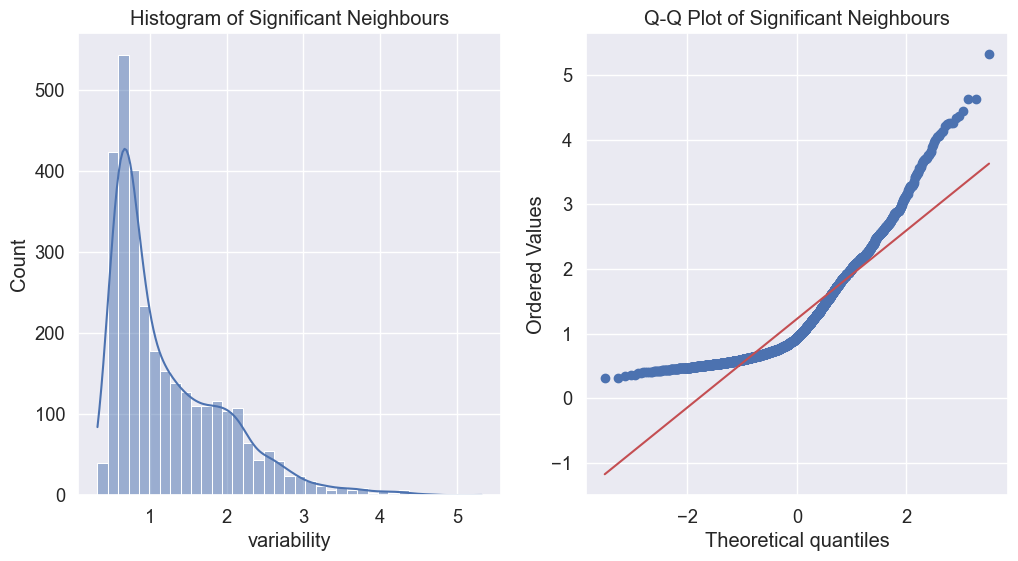

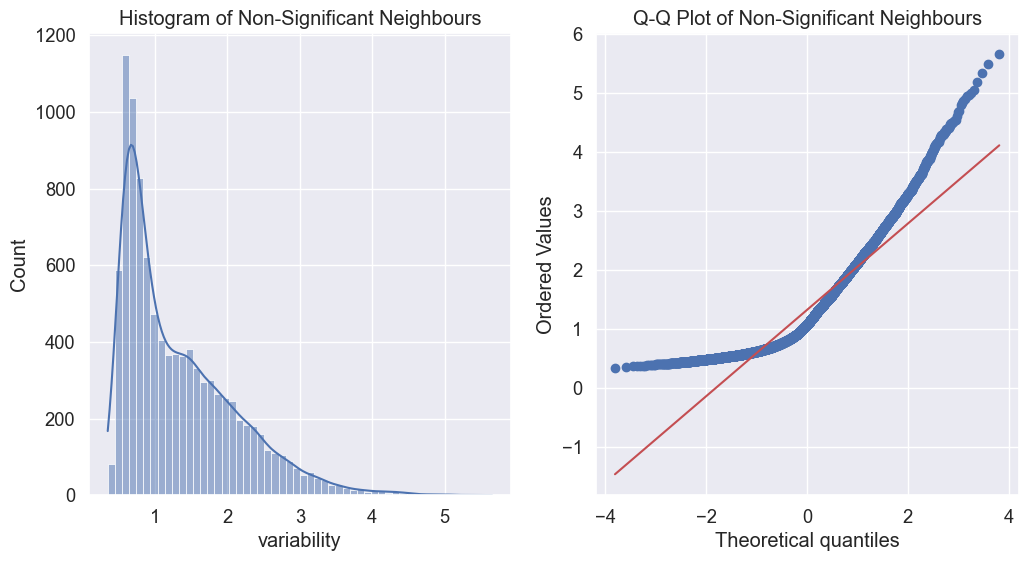

P-value for KS test (Significant): 0.0
P-value for KS test (Non-Significant): 0.0
Using Mann-Whitney U test:
U Statistic: 14188130.0
P-value: 5.734718584628933e-13


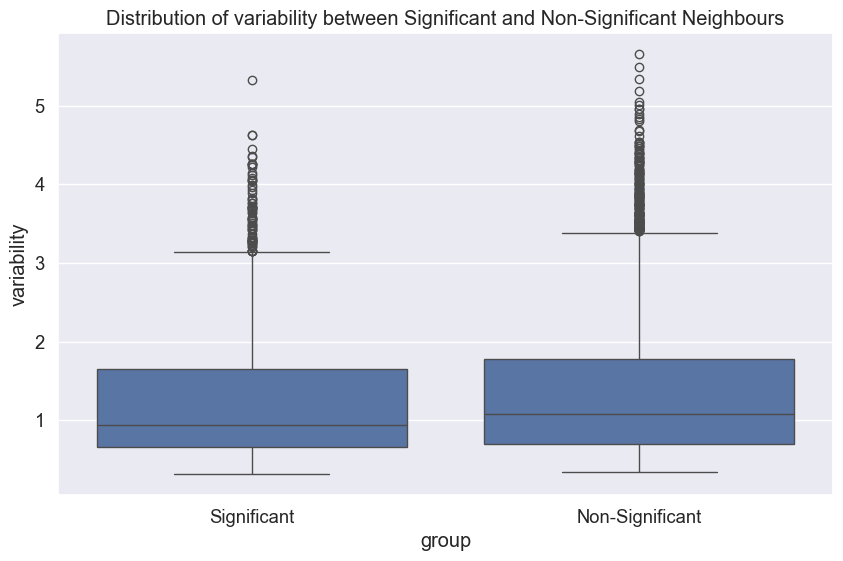

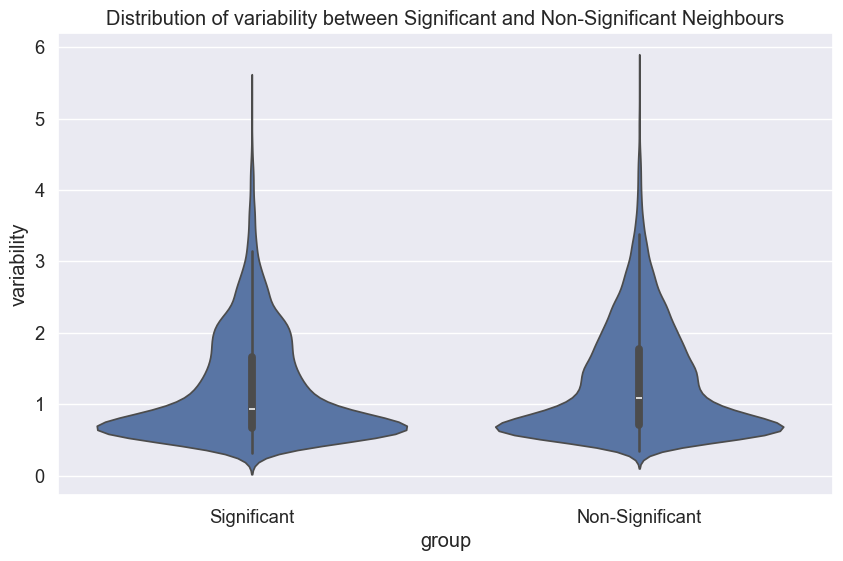

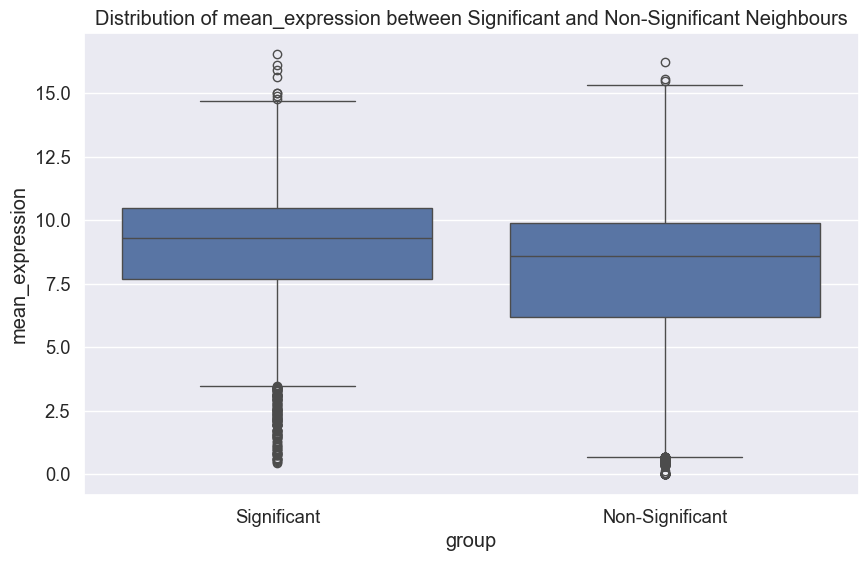

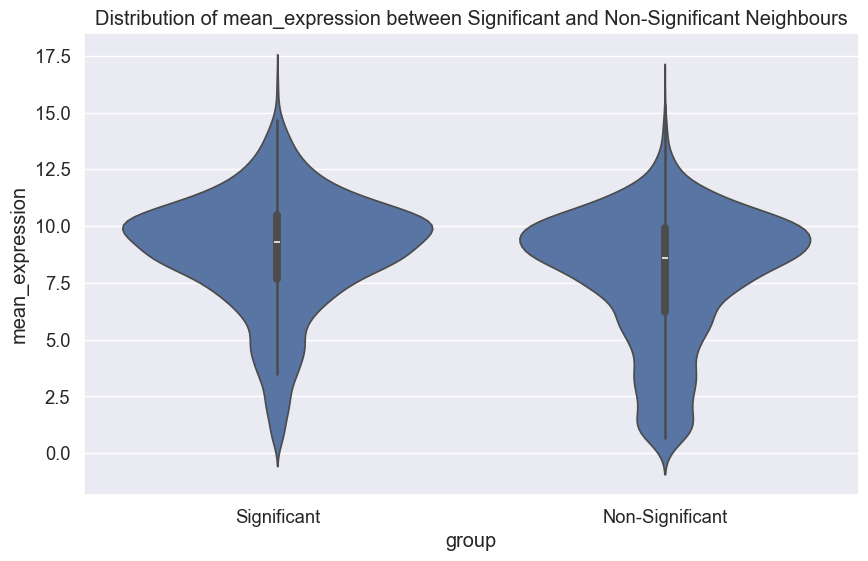

Mean gene expression (Significant): 8.8820
Mean gene expression (Non-Significant): 7.8298
Median gene expression (Significant): 9.3100
Median gene expression (Non-Significant): 8.5800
U-statistic: 18687053.0
P-value: 7.65102001197594e-67
There is a statistically significant difference in mean expression levels.
Cohen's d: 0.3852
Rank Biserial Correlation: -0.2046


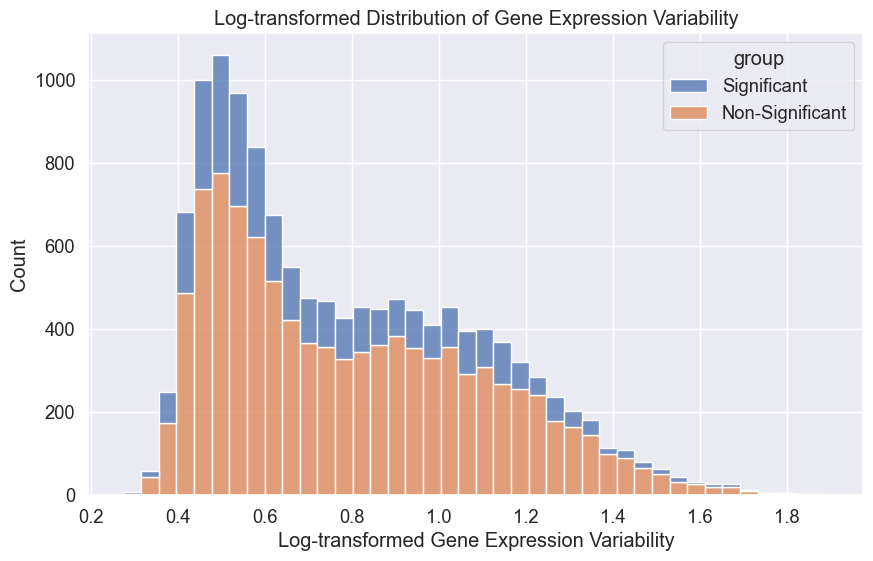

P-value for KS test after log transformation (Significant): 0.0
P-value for KS test after log transformation (Non-Significant): 0.0
P-value for homoscedasticity after log transformation: 0.0008701148809409057
Using Mann-Whitney U test after log transformation:
U Statistic: 14188130.0
P-value: 5.734718584628933e-13


In [48]:
# Main Analysis
def main():
    try:
        variability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighbours]
        variability_non_significant = [calculate_variability(tumourexp, neighbour) for neighbour in non_significant_neighbours]
        mean_expression_significant = filt_neighbours[filt_neighbours['neighbour'].isin(significant_neighbours)]['expression'].tolist()
        mean_expression_non_significant = filt_neighbours[filt_neighbours['neighbour'].isin(non_significant_neighbours)]['expression'].tolist()
    except ValueError as e:
        print(f"Error in calculating variability or mean expression: {e}")
        return

    # Create DataFrame for analysis
    variability_df = pd.DataFrame({
        'neighbour': np.concatenate([significant_neighbours, non_significant_neighbours]),
        'variability': variability_significant + variability_non_significant,
        'group': ['Significant'] * len(variability_significant) + ['Non-Significant'] * len(variability_non_significant),
        'mean_expression': mean_expression_significant + mean_expression_non_significant
    })

    # Perform group comparison
    compare_groups(variability_df)
    plot_group_comparison(variability_df, 'variability')
    plot_group_comparison(variability_df, 'mean_expression')

    # Mean Gene Expression Analysis
    mean_sig = np.mean(mean_expression_significant)
    mean_non_sig = np.mean(mean_expression_non_significant)
    median_sig = np.median(mean_expression_significant)
    median_non_sig = np.median(mean_expression_non_significant)

    print(f"Mean gene expression (Significant): {mean_sig:.4f}")
    print(f"Mean gene expression (Non-Significant): {mean_non_sig:.4f}")
    print(f"Median gene expression (Significant): {median_sig:.4f}")
    print(f"Median gene expression (Non-Significant): {median_non_sig:.4f}")

    # Statistical comparison of mean gene expression
    sig_exp_levels = tumourexp[significant_neighbours].mean(axis=0)
    non_sig_exp_levels = tumourexp[non_significant_neighbours].mean(axis=0)

    u_stat, p_value = stats.mannwhitneyu(sig_exp_levels, non_sig_exp_levels, alternative='two-sided')
    print(f"U-statistic: {u_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("There is a statistically significant difference in mean expression levels.")
    else:
        print("No statistically significant difference in mean expression levels.")

    # Calculate effect size and rank biserial correlation
    cohen_d_value = calculate_effect_size(sig_exp_levels, non_sig_exp_levels)
    rank_biserial_corr = calculate_rank_biserial_correlation(sig_exp_levels, non_sig_exp_levels)

    print(f"Cohen's d: {cohen_d_value:.4f}")
    print(f"Rank Biserial Correlation: {rank_biserial_corr:.4f}")

    # Log transformation
    variability_df['log_variability'] = np.log1p(variability_df['variability'])

    # Plot log-transformed distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=variability_df, x='log_variability', hue='group', multiple='stack')
    plt.xlabel('Log-transformed Gene Expression Variability')
    plt.ylabel('Count')
    plt.title('Log-transformed Distribution of Gene Expression Variability')
    plt.show()

    # Re-run normality and variance tests after log transformation
    ks_p_value_sig_log = test_ks(variability_df[variability_df['group'] == 'Significant']['log_variability'])
    ks_p_value_non_sig_log = test_ks(variability_df[variability_df['group'] == 'Non-Significant']['log_variability'])

    print(f"P-value for KS test after log transformation (Significant): {ks_p_value_sig_log}")
    print(f"P-value for KS test after log transformation (Non-Significant): {ks_p_value_non_sig_log}")

    # Check homogeneity of variances using Levene's test after log transformation
    p_value_variance_log = check_homogeneity_of_variances(
        variability_df[variability_df['group'] == 'Significant']['log_variability'],
        variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
    )
    print(f"P-value for homoscedasticity after log transformation: {p_value_variance_log}")

    # Perform appropriate statistical test after log transformation
    if ks_p_value_sig_log < 0.05 or ks_p_value_non_sig_log < 0.05 or p_value_variance_log < 0.05:
        u_stat_log, u_p_value_log = stats.mannwhitneyu(
            variability_df[variability_df['group'] == 'Significant']['log_variability'],
            variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
        )
        print(f"Using Mann-Whitney U test after log transformation:\nU Statistic: {u_stat_log}\nP-value: {u_p_value_log}")
    else:
        t_stat_log, t_p_value_log = stats.ttest_ind(
            variability_df[variability_df['group'] == 'Significant']['log_variability'],
            variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
        )
        print(f"Using t-test after log transformation:\nt Statistic: {t_stat_log}\nP-value: {t_p_value_log}")

if __name__ == "__main__":
    main()

In [49]:
""" import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Auxiliary Functions
def calculate_variability(df, neighbour):
    if neighbour not in df.columns:
        raise ValueError(f"Neighbour '{neighbour}' not found in the dataframe.")
    return df[neighbour].std()

def check_homogeneity_of_variances(group1, group2):
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    stat, p_value = stats.levene(group1, group2)
    return p_value

def test_ks(data):
    if len(data) == 0:
        raise ValueError("Data is empty.")
    stat, p_value = stats.kstest(data, 'norm')
    return p_value

def plot_distribution(data, label):
    if len(data) == 0:
        raise ValueError("Data is empty.")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {label}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {label}')
    plt.show()

def compare_groups(variability_df, group_col='group', value_col='variability'):
    if group_col not in variability_df.columns or value_col not in variability_df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    # Variance check
    p_value_variance = check_homogeneity_of_variances(
        variability_df[variability_df[group_col] == 'Significant'][value_col],
        variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
    )
    
    print(f"P-value for homoscedasticity: {p_value_variance}")
    
    # Plot distributions
    plot_distribution(variability_df[variability_df[group_col] == 'Significant'][value_col], 'Significant Neighbours')
    plot_distribution(variability_df[variability_df[group_col] == 'Non-Significant'][value_col], 'Non-Significant Neighbours')
    
    # Kolmogorov-Smirnov Test
    ks_p_value_sig = test_ks(variability_df[variability_df[group_col] == 'Significant'][value_col])
    ks_p_value_non_sig = test_ks(variability_df[variability_df[group_col] == 'Non-Significant'][value_col])
    print(f"P-value for KS test (Significant): {ks_p_value_sig}")
    print(f"P-value for KS test (Non-Significant): {ks_p_value_non_sig}")
    
    # Choose appropriate test (Mann-Whitney U or t-test)
    if ks_p_value_sig < 0.05 or ks_p_value_non_sig < 0.05 or p_value_variance < 0.05:
        # If data is not normal or variances are not homogeneous, use Mann-Whitney U test
        u_stat, u_p_value = stats.mannwhitneyu(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using Mann-Whitney U test:\nU Statistic: {u_stat}\nP-value: {u_p_value}")
    else:
        # If data is normal and variances are homogeneous, use t-test
        t_stat, t_p_value = stats.ttest_ind(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using t-test:\nt Statistic: {t_stat}\nP-value: {t_p_value}")

def plot_group_comparison(df, value_col, group_col='group'):
    if group_col not in df.columns or value_col not in df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_col, y=value_col, data=df)
    plt.title(f'Distribution of {value_col} between Significant and Non-Significant Neighbours')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=group_col, y=value_col, data=df)
    plt.title(f'Distribution of {value_col} between Significant and Non-Significant Neighbours')
    plt.show()

# Main Analysis
def main():
    # Load data
    # Note: These lines assume that 'resultsfiltered', 'nonsignificant', and 'tumourexp' are loaded from somewhere
    # You might need to add code to load these dataframes from files
    
    # Data Preparation
    significant_neighbours = resultsfiltered['neighbour'].unique()
    non_significant_neighbours = nonsignificant['neighbour'].unique()
    print(f"Number of significant neighbours: {len(significant_neighbours)}")
    print(f"Number of non-significant neighbours: {len(non_significant_neighbours)}")

    # Check for overlap between significant and non-significant neighbours
    overlap = set(significant_neighbours) & set(non_significant_neighbours)
    if overlap:
        print(f"Warning: {len(overlap)} neighbours appear in both significant and non-significant sets.")
        print("Overlapping neighbours:", overlap)

    # Calculate variability
    try:
        variability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighbours]
        variability_non_significant = [calculate_variability(tumourexp, neighbour) for neighbour in non_significant_neighbours]
    except ValueError as e:
        print(f"Error in calculating variability: {e}")
        return

    # Create DataFrame for analysis (combined approach)
    variability_df = pd.DataFrame({
        'neighbour': np.concatenate([significant_neighbours, non_significant_neighbours]),
        'variability': variability_significant + variability_non_significant,
        'group': ['Significant'] * len(variability_significant) + ['Non-Significant'] * len(variability_non_significant)
    })

    # Perform group comparison
    compare_groups(variability_df)
    plot_group_comparison(variability_df, 'variability')

    # Visualisation of variability (histogram)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=variability_df, x='variability', hue='group', multiple='stack')
    plt.xlabel('Gene Expression Variability')
    plt.ylabel('Count')
    plt.title('Distribution of Gene Expression Variability for Significant and Non-Significant Neighbours')
    plt.show()

    # Log transformation
    variability_df['log_variability'] = np.log1p(variability_df['variability'])

    # Plot log-transformed distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=variability_df, x='log_variability', hue='group', multiple='stack')
    plt.xlabel('Log-transformed Gene Expression Variability')
    plt.ylabel('Count')
    plt.title('Log-transformed Distribution of Gene Expression Variability')
    plt.show()

    # Re-run normality and variance tests after log transformation
    compare_groups(variability_df, value_col='log_variability')

if __name__ == "__main__":
    main() """

' import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom scipy import stats\n\n# Auxiliary Functions\ndef calculate_variability(df, neighbour):\n    if neighbour not in df.columns:\n        raise ValueError(f"Neighbour \'{neighbour}\' not found in the dataframe.")\n    return df[neighbour].std()\n\ndef check_homogeneity_of_variances(group1, group2):\n    if len(group1) == 0 or len(group2) == 0:\n        raise ValueError("One or both groups are empty.")\n    stat, p_value = stats.levene(group1, group2)\n    return p_value\n\ndef test_ks(data):\n    if len(data) == 0:\n        raise ValueError("Data is empty.")\n    stat, p_value = stats.kstest(data, \'norm\')\n    return p_value\n\ndef plot_distribution(data, label):\n    if len(data) == 0:\n        raise ValueError("Data is empty.")\n    plt.figure(figsize=(12, 6))\n    plt.subplot(1, 2, 1)\n    sns.histplot(data, kde=True)\n    plt.title(f\'Histogram of {label}\')\n    \n    plt.subplot(1

In [50]:
""" import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans

# Auxiliary Functions
def calculate_variability(df, neighbour):
    Calculate standard deviation across all patients for a given gene (neighbour).
    return df[neighbour].std()

def calculate_mean_expression(df, neighbour):
    Calculate mean gene expression for each neighbour
    return df[neighbour].mean()

def check_homogeneity_of_variances(group1, group2):
   Check homogeneity of variances using Levene's test
    stat, p_value = stats.levene(group1, group2)
    return p_value

def test_ks(data):
    Kolmogorov-Smirnov test for checking normality.
    stat, p_value = stats.kstest(data, 'norm')
    return p_value

def plot_distribution(data, label):
    Plot histogram and Q-Q plot for a dataset.
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {label}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {label}')
    plt.show()

def compare_groups(variability_df, group_col='group', value_col='variability'):
    Perform statistical tests and plot distributions between significant and non-significant groups.
    # Variance check
    p_value_variance = check_homogeneity_of_variances(
        variability_df[variability_df[group_col] == 'Significant'][value_col],
        variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
    )
    
    print(f"P-value for homoscedasticity: {p_value_variance}")
    
    # Plot distributions
    plot_distribution(variability_df[variability_df[group_col] == 'Significant'][value_col], 'Significant Neighbours')
    plot_distribution(variability_df[variability_df[group_col] == 'Non-Significant'][value_col], 'Non-Significant Neighbours')
    
    # Kolmogorov-Smirnov Test
    ks_p_value_sig = test_ks(variability_df[variability_df[group_col] == 'Significant'][value_col])
    ks_p_value_non_sig = test_ks(variability_df[variability_df[group_col] == 'Non-Significant'][value_col])
    print(f"P-value for KS test (Significant): {ks_p_value_sig}")
    print(f"P-value for KS test (Non-Significant): {ks_p_value_non_sig}")
    
    # Choose appropriate test (Mann-Whitney U or t-test)
    if ks_p_value_sig < 0.05 or ks_p_value_non_sig < 0.05 or p_value_variance < 0.05:
        u_stat, u_p_value = stats.mannwhitneyu(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using Mann-Whitney U test:\nU Statistic: {u_stat}\nP-value: {u_p_value}")
    else:
        t_stat, t_p_value = stats.ttest_ind(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using t-test:\nt Statistic: {t_stat}\nP-value: {t_p_value}")

def plot_group_comparison(df, value_col, group_col='group'):
    Plot boxplot and violin plot for group comparison.
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_col, y=value_col, data=df)
    plt.title(f'Distribution of {value_col} between Significant and Non-Significant Neighbours')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=group_col, y=value_col, data=df)
    plt.title(f'Distribution of {value_col} between Significant and Non-Significant Neighbours')
    plt.show()

def calculate_effect_size(group1, group2):
   Calculate Cohen's d for effect size.
    diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
    return diff / pooled_std

def calculate_rank_biserial_correlation(group1, group2):
    Calculate rank biserial correlation.
    u_stat, _ = stats.mannwhitneyu(group1, group2)
    n1 = len(group1)
    n2 = len(group2)
    return 1 - (2 * u_stat / (n1 * n2))

# Data Preparation
significant_neighbours = resultsfiltered['neighbour'].unique()
non_significant_neighbours = nonsignificant['neighbour'].unique()
print(f"Number of significant neighbours: {len(significant_neighbours)}")
print(f"Number of non-significant neighbours: {len(non_significant_neighbours)}")

# Calculate variability and mean expression
variability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighbours]
variability_non_significant = [calculate_variability(tumourexp, neighbour) for neighbour in non_significant_neighbours]
mean_expression_significant = [calculate_mean_expression(tumourexp, neighbour) for neighbour in significant_neighbours]
mean_expression_non_significant = [calculate_mean_expression(tumourexp, neighbour) for neighbour in non_significant_neighbours]

# Create DataFrame for analysis
variability_df = pd.DataFrame({
    'neighbour': np.concatenate([significant_neighbours, non_significant_neighbours]),
    'variability': variability_significant + variability_non_significant,
    'group': ['Significant'] * len(variability_significant) + ['Non-Significant'] * len(variability_non_significant),
    'mean_expression': mean_expression_significant + mean_expression_non_significant
})

# Perform group comparison
compare_groups(variability_df)
plot_group_comparison(variability_df, 'variability')
plot_group_comparison(variability_df, 'mean_expression')

# Mean Gene Expression Analysis
mean_sig = np.mean(mean_expression_significant)
mean_non_sig = np.mean(mean_expression_non_significant)
median_sig = np.median(mean_expression_significant)
median_non_sig = np.median(mean_expression_non_significant)

print(f"Mean gene expression (Significant): {mean_sig:.4f}")
print(f"Mean gene expression (Non-Significant): {mean_non_sig:.4f}")
print(f"Median gene expression (Significant): {median_sig:.4f}")
print(f"Median gene expression (Non-Significant): {median_non_sig:.4f}")

# Statistical comparison of mean gene expression
sig_exp_levels = tumourexp[significant_neighbours].mean(axis=0)
non_sig_exp_levels = tumourexp[non_significant_neighbours].mean(axis=0)

u_stat, p_value = stats.mannwhitneyu(sig_exp_levels, non_sig_exp_levels, alternative='two-sided')
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant difference in mean expression levels.")
else:
    print("No statistically significant difference in mean expression levels.")

# Calculate effect size and rank biserial correlation
cohen_d_value = calculate_effect_size(sig_exp_levels, non_sig_exp_levels)
rank_biserial_corr = calculate_rank_biserial_correlation(sig_exp_levels, non_sig_exp_levels)

print(f"Cohen's d: {cohen_d_value:.4f}")
print(f"Rank Biserial Correlation: {rank_biserial_corr:.4f}")

# Log transformation and clustering
variability_df['log_variability'] = np.log1p(variability_df['variability'])

sns.histplot(data=variability_df, x='log_variability', hue='group', multiple='stack')
plt.xlabel('Log-transformed Gene Expression Variability')
plt.ylabel('Count')
plt.title('Log-transformed Distribution of Gene Expression Variability')
plt.show()

# Re-run normality and variance tests after log transformation

# Check normality using Kolmogorov-Smirnov test
ks_p_value_sig_log = test_ks(variability_df[variability_df['group'] == 'Significant']['log_variability'])
ks_p_value_non_sig_log = test_ks(variability_df[variability_df['group'] == 'Non-Significant']['log_variability'])

print(f"P-value for KS test after log transformation (Significant): {ks_p_value_sig_log}")
print(f"P-value for KS test after log transformation (Non-Significant): {ks_p_value_non_sig_log}")

# Check homogeneity of variances using Levene's test after log transformation
p_value_variance_log = check_homogeneity_of_variances(
    variability_df[variability_df['group'] == 'Significant']['log_variability'],
    variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
)
print(f"P-value for homoscedasticity after log transformation: {p_value_variance_log}")

# Depending on the results, choose the appropriate test (Mann-Whitney U or t-test)
if ks_p_value_sig_log < 0.05 or ks_p_value_non_sig_log < 0.05 or p_value_variance_log < 0.05:
    u_stat_log, u_p_value_log = stats.mannwhitneyu(
        variability_df[variability_df['group'] == 'Significant']['log_variability'],
        variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
    )
    print(f"Using Mann-Whitney U test after log transformation:\nU Statistic: {u_stat_log}\nP-value: {u_p_value_log}")
else:
    t_stat_log, t_p_value_log = stats.ttest_ind(
        variability_df[variability_df['group'] == 'Significant']['log_variability'],
        variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
    )
    print(f"Using t-test after log transformation:\nt Statistic: {t_stat_log}\nP-value: {t_p_value_log}") """

""" # K-means clustering
significant_variability = variability_df[variability_df['group'] == 'Significant']['log_variability'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42).fit(significant_variability)
variability_df.loc[variability_df['group'] == 'Significant', 'cluster'] = kmeans.labels_

sns.scatterplot(x='log_variability', y='variability', hue='cluster', data=variability_df[variability_df['group'] == 'Significant'], palette='Set2')
plt.title('Clustering of Significant Neighbours based on Log-transformed Variability')
plt.show()

# Summarize cluster characteristics
cluster_summary = variability_df[variability_df['group'] == 'Significant'].groupby('cluster').agg({
    'variability': ['mean', 'std', 'min', 'max'],
    'log_variability': ['mean', 'std', 'min', 'max'],
})

print(cluster_summary)
 """

" # K-means clustering\nsignificant_variability = variability_df[variability_df['group'] == 'Significant']['log_variability'].values.reshape(-1, 1)\nkmeans = KMeans(n_clusters=3, random_state=42).fit(significant_variability)\nvariability_df.loc[variability_df['group'] == 'Significant', 'cluster'] = kmeans.labels_\n\nsns.scatterplot(x='log_variability', y='variability', hue='cluster', data=variability_df[variability_df['group'] == 'Significant'], palette='Set2')\nplt.title('Clustering of Significant Neighbours based on Log-transformed Variability')\nplt.show()\n\n# Summarize cluster characteristics\ncluster_summary = variability_df[variability_df['group'] == 'Significant'].groupby('cluster').agg({\n    'variability': ['mean', 'std', 'min', 'max'],\n    'log_variability': ['mean', 'std', 'min', 'max'],\n})\n\nprint(cluster_summary)\n "

In [51]:
""" import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Auxiliary Functions
def check_sign_consistency(group):
    signs = np.sign(group['coef'])
    return (signs == signs.iloc[0]).all()

def calculate_variability(df, neighbour):
    return df[neighbour].std()

def get_association_type(neighbour, filtered_results):
    coef = filtered_results[filtered_results['neighbour'] == neighbour]['coef'].iloc[0]
    return 'Positive' if coef > 0 else 'Negative'

def check_normality(data):
    # Considering large samples, use Kolmogorov-Smirnov for evaluation
    print("Sample size for normality check:", len(data))
    if len(data) > 10000:
        print("Warning: The Shapiro-Wilk test may not be accurate for large samples.")
    stat, p_value = stats.shapiro(data)
    print(f"Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}")
    return p_value

def check_homogeneity_of_variances(group1, group2):
    stat, p_value = stats.levene(group1, group2)
    print(f"Levene's Test: Statistics={stat}, p-value={p_value}")
    return p_value

def test_ks(data):
    # Kolmogorov-Smirnov test may be more appropriate for large samples
    print("Sample size for Kolmogorov-Smirnov test:", len(data))
    stat, p_value = stats.kstest(data, 'norm')
    print(f"Kolmogorov-Smirnov Test: Statistics={stat}, p-value={p_value}")
    return p_value

def plot_normality(data, label):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {label}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {label}')
    plt.show()

def plot_distribution(data, label):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {label}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {label}')
    plt.show()

# Analysis of Significant and Non-Significant Neighbours
significant_neighbours = resultsfiltered
non_significant_neighbours = nonsignificant

# Calculation of Variability
variability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighbours['neighbour']]
variability_non_significant = [calculate_variability(tumourexp, neighbour) for neighbour in non_significant_neighbours['neighbour']]

# Creation of DataFrame for variability
variability = pd.DataFrame({
    'variability': variability_significant + variability_non_significant,
    'group': ['Significant'] * len(variability_significant) + ['Non-Significant'] * len(variability_non_significant)
})

# Statistical Tests
print("\nStatistical Tests")
p_value_sig_normality = check_normality(variability[variability['group'] == 'Significant']['variability'])
p_value_non_sig_normality = check_normality(variability[variability['group'] == 'Non-Significant']['variability'])
p_value_variance = check_homogeneity_of_variances(
    variability[variability['group'] == 'Significant']['variability'],
    variability[variability['group'] == 'Non-Significant']['variability']
)

print(f"\nP-value for normality for significant neighbours: {p_value_sig_normality}")
print(f"P-value for normality for non-significant neighbours: {p_value_non_sig_normality}")
print(f"P-value for homoscedasticity: {p_value_variance}")

plot_normality(variability[variability['group'] == 'Significant']['variability'], 'Significant Neighbours')
plot_normality(variability[variability['group'] == 'Non-Significant']['variability'], 'Non-Significant Neighbours')

# Additional check with Kolmogorov-Smirnov test
print("\nKolmogorov-Smirnov Tests")
ks_p_value_sig = test_ks(variability[variability['group'] == 'Significant']['variability'])
ks_p_value_non_sig = test_ks(variability[variability['group'] == 'Non-Significant']['variability'])

print(f"\nP-value for Kolmogorov-Smirnov test for significant neighbours: {ks_p_value_sig}")
print(f"P-value for Kolmogorov-Smirnov test for non-significant neighbours: {ks_p_value_non_sig}")

# Visualisation of variability
plt.figure(figsize=(10, 6))
sns.histplot(data=variability, x='variability', hue='group', multiple='stack')
plt.xlabel('Gene Expression Variability')
plt.ylabel('Count')
plt.title('Distribution of Gene Expression Variability for Significant and Non-Significant Neighbours')
plt.show()

# Box Plot for Variability
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='variability', data=variability)
plt.xlabel('Group Type')
plt.ylabel('Gene Expression Variability')
plt.title('Gene Expression Variability for Significant and Non-Significant Neighbours')
plt.show()

# Use Mann-Whitney U if normality is not met or variances are different
print("\nStatistical Test for Group Comparison")
if (p_value_sig_normality < 0.05 or p_value_non_sig_normality < 0.05 or p_value_variance < 0.05):
    u_stat, u_p_value = stats.mannwhitneyu(
        variability[variability['group'] == 'Significant']['variability'],
        variability[variability['group'] == 'Non-Significant']['variability']
    )
    print(f"\nUsing the Mann-Whitney U test:")
    print(f"U Statistic: {u_stat}")
    print(f"P-value: {u_p_value}")
else:
    t_stat, t_p_value = stats.ttest_ind(
        variability[variability['group'] == 'Significant']['variability'],
        variability[variability['group'] == 'Non-Significant']['variability']
    )
    print(f"\nUsing the t-test:")
    print(f"t Statistic: {t_stat}")
    print(f"P-value: {t_p_value}")
 """

' import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom scipy import stats\n\n# Auxiliary Functions\ndef check_sign_consistency(group):\n    signs = np.sign(group[\'coef\'])\n    return (signs == signs.iloc[0]).all()\n\ndef calculate_variability(df, neighbour):\n    return df[neighbour].std()\n\ndef get_association_type(neighbour, filtered_results):\n    coef = filtered_results[filtered_results[\'neighbour\'] == neighbour][\'coef\'].iloc[0]\n    return \'Positive\' if coef > 0 else \'Negative\'\n\ndef check_normality(data):\n    # Considering large samples, use Kolmogorov-Smirnov for evaluation\n    print("Sample size for normality check:", len(data))\n    if len(data) > 10000:\n        print("Warning: The Shapiro-Wilk test may not be accurate for large samples.")\n    stat, p_value = stats.shapiro(data)\n    print(f"Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}")\n    return p_value\n\ndef check_homogeneity_of_variances(group1,

In [52]:
""" meanexp = tumourexp.reset_index(drop=True).median().rename("expression")
meanexp.head() """

' meanexp = tumourexp.reset_index(drop=True).median().rename("expression")\nmeanexp.head() '

In [53]:
""" # Divide neighbours into significant and non-significant
significance_threshold = 0.05
combined_results['significant'] = (
    (combined_results['rho_pval'] < significance_threshold) & 
    (combined_results['coef_pval'] < significance_threshold)
)

significant_neighbours = combined_results[combined_results['significant']]['neighbour'].unique()
non_significant_neighbours = combined_results[~combined_results['significant']]['neighbour'].unique()

print(f"Number of significant neighbours: {len(significant_neighbours)}")
print(f"Number of non-significant neighbours: {len(non_significant_neighbours)}") """


' # Divide neighbours into significant and non-significant\nsignificance_threshold = 0.05\ncombined_results[\'significant\'] = (\n    (combined_results[\'rho_pval\'] < significance_threshold) & \n    (combined_results[\'coef_pval\'] < significance_threshold)\n)\n\nsignificant_neighbours = combined_results[combined_results[\'significant\']][\'neighbour\'].unique()\nnon_significant_neighbours = combined_results[~combined_results[\'significant\']][\'neighbour\'].unique()\n\nprint(f"Number of significant neighbours: {len(significant_neighbours)}")\nprint(f"Number of non-significant neighbours: {len(non_significant_neighbours)}") '

In [54]:
""" u_stat, p_value_u = stats.mannwhitneyu(meanexp.loc[significant_neighbours], 
                                       meanexp.loc[non_significant_neighbours], 
                                       alternative='two-sided')

print(f"\nComparison of gene expression between significant and non-significant neighbours:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value_u}") """

' u_stat, p_value_u = stats.mannwhitneyu(meanexp.loc[significant_neighbours], \n                                       meanexp.loc[non_significant_neighbours], \n                                       alternative=\'two-sided\')\n\nprint(f"\nComparison of gene expression between significant and non-significant neighbours:")\nprint(f"U-statistic: {u_stat}")\nprint(f"P-value: {p_value_u}") '

In [55]:
""" # Calculate means and medians
sig_mean = meanexp.loc[significant_neighbours].mean()
non_sig_mean = meanexp.loc[non_significant_neighbours].mean()
sig_median = meanexp.loc[significant_neighbours].median()
non_sig_median = meanexp.loc[non_significant_neighbours].median()

print(f"\nMean gene expression:")
print(f"Significant neighbours: {sig_mean:.4f}")
print(f"Non-significant neighbours: {non_sig_mean:.4f}")
print(f"\nMedian gene expression:")
print(f"Significant neighbours: {sig_median:.4f}")
print(f"Non-significant neighbours: {non_sig_median:.4f}")

# Prepare data for the boxplot
sig_data = meanexp.loc[significant_neighbours]
non_sig_data = meanexp.loc[non_significant_neighbours]

# Create a DataFrame with the data and labels
df = pd.DataFrame({
    'Gene Expression': pd.concat([sig_data, non_sig_data]),
    'Group': ['Significant']*len(sig_data) + ['Non-Significant']*len(non_sig_data)
})

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Gene Expression', data=df)
plt.title('Distribution of Gene Expression between Significant and Non-Significant Neighbours')
plt.show()

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Group', y='Gene Expression', data=df)
plt.title('Distribution of Gene Expression between Significant and Non-Significant Neighbours')
plt.show() """

' # Calculate means and medians\nsig_mean = meanexp.loc[significant_neighbours].mean()\nnon_sig_mean = meanexp.loc[non_significant_neighbours].mean()\nsig_median = meanexp.loc[significant_neighbours].median()\nnon_sig_median = meanexp.loc[non_significant_neighbours].median()\n\nprint(f"\nMean gene expression:")\nprint(f"Significant neighbours: {sig_mean:.4f}")\nprint(f"Non-significant neighbours: {non_sig_mean:.4f}")\nprint(f"\nMedian gene expression:")\nprint(f"Significant neighbours: {sig_median:.4f}")\nprint(f"Non-significant neighbours: {non_sig_median:.4f}")\n\n# Prepare data for the boxplot\nsig_data = meanexp.loc[significant_neighbours]\nnon_sig_data = meanexp.loc[non_significant_neighbours]\n\n# Create a DataFrame with the data and labels\ndf = pd.DataFrame({\n    \'Gene Expression\': pd.concat([sig_data, non_sig_data]),\n    \'Group\': [\'Significant\']*len(sig_data) + [\'Non-Significant\']*len(non_sig_data)\n})\n\n# Create the boxplot\nplt.figure(figsize=(10, 6))\nsns.boxplot

In [56]:
""" from numpy import mean, std
from math import sqrt

# Function to calculate Cohen's d
def cohen_d(group1, group2):
    diff = mean(group1) - mean(group2)
    pooled_std = sqrt((std(group1, ddof=1) ** 2 + std(group2, ddof=1) ** 2) / 2)
    return diff / pooled_std

# Calculate Cohen's d between significant and non-significant groups
cohen_d_value = cohen_d(
    variability[variability['group'] == 'Significant']['variability'],
    variability[variability['group'] == 'Non-Significant']['variability']
)

print(f"Cohen's d: {cohen_d_value:.4f}")
 """

' from numpy import mean, std\nfrom math import sqrt\n\n# Function to calculate Cohen\'s d\ndef cohen_d(group1, group2):\n    diff = mean(group1) - mean(group2)\n    pooled_std = sqrt((std(group1, ddof=1) ** 2 + std(group2, ddof=1) ** 2) / 2)\n    return diff / pooled_std\n\n# Calculate Cohen\'s d between significant and non-significant groups\ncohen_d_value = cohen_d(\n    variability[variability[\'group\'] == \'Significant\'][\'variability\'],\n    variability[variability[\'group\'] == \'Non-Significant\'][\'variability\']\n)\n\nprint(f"Cohen\'s d: {cohen_d_value:.4f}")\n '

In [57]:
""" # Calculate rank biserial correlation
u_stat, p_value_u = stats.mannwhitneyu(
    variability[variability['group'] == 'Significant']['variability'],
    variability[variability['group'] == 'Non-Significant']['variability']
)

n1 = len(variability[variability['group'] == 'Significant'])
n2 = len(variability[variability['group'] == 'Non-Significant'])
rank_biserial_corr = 1 - (2 * u_stat / (n1 * n2))

print(f"Rank Biserial Correlation: {rank_biserial_corr:.4f}") """


' # Calculate rank biserial correlation\nu_stat, p_value_u = stats.mannwhitneyu(\n    variability[variability[\'group\'] == \'Significant\'][\'variability\'],\n    variability[variability[\'group\'] == \'Non-Significant\'][\'variability\']\n)\n\nn1 = len(variability[variability[\'group\'] == \'Significant\'])\nn2 = len(variability[variability[\'group\'] == \'Non-Significant\'])\nrank_biserial_corr = 1 - (2 * u_stat / (n1 * n2))\n\nprint(f"Rank Biserial Correlation: {rank_biserial_corr:.4f}") '

In [58]:
""" import numpy as np

# Apply log transformation to the variability data
variability['log_variability'] = np.log1p(variability['variability'])

# Plot the distribution after log transformation
sns.histplot(data=variability, x='log_variability', hue='group', multiple='stack')
plt.xlabel('Log-transformed Gene Expression Variability')
plt.ylabel('Count')
plt.title('Log-transformed Distribution of Gene Expression Variability')
plt.show()

# You may also want to re-run your normality and variance tests after this transformation
 """

" import numpy as np\n\n# Apply log transformation to the variability data\nvariability['log_variability'] = np.log1p(variability['variability'])\n\n# Plot the distribution after log transformation\nsns.histplot(data=variability, x='log_variability', hue='group', multiple='stack')\nplt.xlabel('Log-transformed Gene Expression Variability')\nplt.ylabel('Count')\nplt.title('Log-transformed Distribution of Gene Expression Variability')\nplt.show()\n\n# You may also want to re-run your normality and variance tests after this transformation\n "

In [59]:
""" from sklearn.cluster import KMeans
import seaborn as sns

# Apply K-means clustering to the significant variability data
significant_variability = variability[variability['group'] == 'Significant']['log_variability'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42).fit(significant_variability)
variability.loc[variability['group'] == 'Significant', 'cluster'] = kmeans.labels_

# Visualize the clusters
sns.scatterplot(x='log_variability', y='variability', hue='cluster', data=variability[variability['group'] == 'Significant'], palette='Set2')
plt.title('Clustering of Significant Neighbours based on Log-transformed Variability')
plt.show()
 """

" from sklearn.cluster import KMeans\nimport seaborn as sns\n\n# Apply K-means clustering to the significant variability data\nsignificant_variability = variability[variability['group'] == 'Significant']['log_variability'].values.reshape(-1, 1)\nkmeans = KMeans(n_clusters=3, random_state=42).fit(significant_variability)\nvariability.loc[variability['group'] == 'Significant', 'cluster'] = kmeans.labels_\n\n# Visualize the clusters\nsns.scatterplot(x='log_variability', y='variability', hue='cluster', data=variability[variability['group'] == 'Significant'], palette='Set2')\nplt.title('Clustering of Significant Neighbours based on Log-transformed Variability')\nplt.show()\n "

In [60]:
""" # Summarize cluster characteristics
cluster_summary = variability[variability['group'] == 'Significant'].groupby('cluster').agg({
    'variability': ['mean', 'std', 'min', 'max'],
    'log_variability': ['mean', 'std', 'min', 'max'],
})

print(cluster_summary)
 """

" # Summarize cluster characteristics\ncluster_summary = variability[variability['group'] == 'Significant'].groupby('cluster').agg({\n    'variability': ['mean', 'std', 'min', 'max'],\n    'log_variability': ['mean', 'std', 'min', 'max'],\n})\n\nprint(cluster_summary)\n "

In [61]:
""" import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans

# Auxiliary Functions
def calculate_variability(df, neighbour):
    # Calculate variability as the standard deviation across all patients for a given gene (neighbour)
    return df[neighbour].std()

# Calculate mean gene expression for each neighbor
def calculate_mean_expression(df, neighbour):
    return df[neighbour].mean()

# Analysis of Significant and Non-Significant Neighbours
# `resultsfiltered` contains significant neighbours, `nonsignificant` contains non-significant ones.
significant_neighbours = resultsfiltered['neighbour'].unique()
non_significant_neighbours = nonsignificant['neighbour'].unique()

# Calculation of Variability and Mean Expression for Significant and Non-Significant Neighbours
variability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighbours]
variability_non_significant = [calculate_variability(tumourexp, neighbour) for neighbour in non_significant_neighbours]

mean_expression_significant = [calculate_mean_expression(tumourexp, neighbour) for neighbour in significant_neighbours]
mean_expression_non_significant = [calculate_mean_expression(tumourexp, neighbour) for neighbour in non_significant_neighbours]

# Creation of DataFrame for variability and mean expression
variability_df = pd.DataFrame({
    'neighbour': np.concatenate([significant_neighbours, non_significant_neighbours]),
    'variability': variability_significant + variability_non_significant,
    'group': ['Significant'] * len(variability_significant) + ['Non-Significant'] * len(variability_non_significant),
    'mean_expression': mean_expression_significant + mean_expression_non_significant
})

# Statistical Tests
print("\nStatistical Tests")
p_value_sig_normality = check_normality(variability_df[variability_df['group'] == 'Significant']['variability'])
p_value_non_sig_normality = check_normality(variability_df[variability_df['group'] == 'Non-Significant']['variability'])
p_value_variance = check_homogeneity_of_variances(
    variability_df[variability_df['group'] == 'Significant']['variability'],
    variability_df[variability_df['group'] == 'Non-Significant']['variability']
)

print(f"\nP-value for normality for significant neighbours: {p_value_sig_normality}")
print(f"P-value for normality for non-significant neighbours: {p_value_non_sig_normality}")
print(f"P-value for homoscedasticity: {p_value_variance}")

plot_normality(variability_df[variability_df['group'] == 'Significant']['variability'], 'Significant Neighbours')
plot_normality(variability_df[variability_df['group'] == 'Non-Significant']['variability'], 'Non-Significant Neighbours')

# Additional check with Kolmogorov-Smirnov test
print("\nKolmogorov-Smirnov Tests")
ks_p_value_sig = test_ks(variability_df[variability_df['group'] == 'Significant']['variability'])
ks_p_value_non_sig = test_ks(variability_df[variability_df['group'] == 'Non-Significant']['variability'])

print(f"\nP-value for Kolmogorov-Smirnov test for significant neighbours: {ks_p_value_sig}")
print(f"P-value for Kolmogorov-Smirnov test for non-significant neighbours: {ks_p_value_non_sig}")

# Visualisation of variability
plt.figure(figsize=(10, 6))
sns.histplot(data=variability_df, x='variability', hue='group', multiple='stack')
plt.xlabel('Gene Expression Variability')
plt.ylabel('Count')
plt.title('Distribution of Gene Expression Variability for Significant and Non-Significant Neighbours')
plt.show()

# Box Plot for Variability
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='variability', data=variability_df)
plt.xlabel('Group Type')
plt.ylabel('Gene Expression Variability')
plt.title('Gene Expression Variability for Significant and Non-Significant Neighbours')
plt.show()

# Use Mann-Whitney U if normality is not met or variances are different
print("\nStatistical Test for Group Comparison")
if (p_value_sig_normality < 0.05 or p_value_non_sig_normality < 0.05 or p_value_variance < 0.05):
    u_stat, u_p_value = stats.mannwhitneyu(
        variability_df[variability_df['group'] == 'Significant']['variability'],
        variability_df[variability_df['group'] == 'Non-Significant']['variability']
    )
    print(f"\nUsing the Mann-Whitney U test:")
    print(f"U Statistic: {u_stat}")
    print(f"P-value: {u_p_value}")
else:
    t_stat, t_p_value = stats.ttest_ind(
        variability_df[variability_df['group'] == 'Significant']['variability'],
        variability_df[variability_df['group'] == 'Non-Significant']['variability']
    )
    print(f"\nUsing the t-test:")
    print(f"t Statistic: {t_stat}")
    print(f"P-value: {t_p_value}")

# Mean Gene Expression Analysis
# Calculate means and medians
sig_mean = np.mean(mean_expression_significant)
non_sig_mean = np.mean(mean_expression_non_significant)
sig_median = np.median(mean_expression_significant)
non_sig_median = np.median(mean_expression_non_significant)

print(f"\nMean gene expression:")
print(f"Significant neighbours: {sig_mean:.4f}")
print(f"Non-significant neighbours: {non_sig_mean:.4f}")
print(f"\nMedian gene expression:")
print(f"Significant neighbours: {sig_median:.4f}")
print(f"Non-significant neighbours: {non_sig_median:.4f}")

# Prepare data for the boxplot
df_expression = pd.DataFrame({
    'Gene Expression': mean_expression_significant + mean_expression_non_significant,
    'Group': ['Significant']*len(mean_expression_significant) + ['Non-Significant']*len(mean_expression_non_significant)
})

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Gene Expression', data=df_expression)
plt.title('Distribution of Gene Expression between Significant and Non-Significant Neighbours')
plt.show()

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Group', y='Gene Expression', data=df_expression)
plt.title('Distribution of Gene Expression between Significant and Non-Significant Neighbours')
plt.show()
 """

' import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom scipy import stats\nfrom sklearn.cluster import KMeans\n\n# Auxiliary Functions\ndef calculate_variability(df, neighbour):\n    # Calculate variability as the standard deviation across all patients for a given gene (neighbour)\n    return df[neighbour].std()\n\n# Calculate mean gene expression for each neighbor\ndef calculate_mean_expression(df, neighbour):\n    return df[neighbour].mean()\n\n# Analysis of Significant and Non-Significant Neighbours\n# `resultsfiltered` contains significant neighbours, `nonsignificant` contains non-significant ones.\nsignificant_neighbours = resultsfiltered[\'neighbour\'].unique()\nnon_significant_neighbours = nonsignificant[\'neighbour\'].unique()\n\n# Calculation of Variability and Mean Expression for Significant and Non-Significant Neighbours\nvariability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighb

In [62]:
""" import numpy as np
import pandas as pd
from scipy import stats

# Assuming significant_neighbours and non_significant_neighbours are already defined
# significant_neighbours = np.array([...])
# non_significant_neighbours = np.array([...])

# Extract expression levels for significant and non-significant neighbours
sig_exp_levels = tumourexp[significant_neighbours].mean(axis=0)
non_sig_exp_levels = tumourexp[non_significant_neighbours].mean(axis=0)

# Mann-Whitney U Test for mean expression levels
u_stat, p_value = stats.mannwhitneyu(sig_exp_levels, non_sig_exp_levels, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

# Interpretation based on p-value
if p_value < 0.05:
    print("There is a statistically significant difference in mean expression levels between significant and non-significant neighbors.")
else:
    print("There is no statistically significant difference in mean expression levels between significant and non-significant neighbors.")

# Calculate effect size (Cohen's d)
def cohen_d(group1, group2):
    diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
    return diff / pooled_std

cohen_d_value = cohen_d(sig_exp_levels, non_sig_exp_levels)
print(f"Cohen's d for mean expression levels: {cohen_d_value:.4f}") """


' import numpy as np\nimport pandas as pd\nfrom scipy import stats\n\n# Assuming significant_neighbours and non_significant_neighbours are already defined\n# significant_neighbours = np.array([...])\n# non_significant_neighbours = np.array([...])\n\n# Extract expression levels for significant and non-significant neighbours\nsig_exp_levels = tumourexp[significant_neighbours].mean(axis=0)\nnon_sig_exp_levels = tumourexp[non_significant_neighbours].mean(axis=0)\n\n# Mann-Whitney U Test for mean expression levels\nu_stat, p_value = stats.mannwhitneyu(sig_exp_levels, non_sig_exp_levels, alternative=\'two-sided\')\n\nprint(f"U-statistic: {u_stat}")\nprint(f"P-value: {p_value}")\n\n# Interpretation based on p-value\nif p_value < 0.05:\n    print("There is a statistically significant difference in mean expression levels between significant and non-significant neighbors.")\nelse:\n    print("There is no statistically significant difference in mean expression levels between significant and non-s

## Enrichment Analysis

#### POS VS NEG

In [63]:
only_pos = only_pos_variability.index.tolist()
only_neg = only_neg_variability.index.tolist()

In [64]:
print(len(only_pos))
print(len(only_neg))

1727
1378


In [65]:
# Carregar dados de hallmarks do câncer
#hallmarks_df = pd.read_excel('hallmarks_to_goterms.xlsx')

# Função para realizar análise de enriquecimento
def perform_enrichment(gene_list, background, sources):
    gp = GProfiler(return_dataframe=True)
    results = {}
    for source in sources:
        results[source] = gp.profile(
            organism='hsapiens',
            query=gene_list,
            user_threshold=0.05,
            no_evidences=False,
            sources=[source],
            all_results=False,
            domain_scope='annotated',
            background=background,
            significance_threshold_method='fdr'
        )
    return results

# Definir fontes para enriquecimento
sources = ["GO:MF", "GO:CC", "GO:BP", "KEGG", "REAC", "WP"]

# Realizar análise de enriquecimento para vizinhos positivos e negativos
pos_enrichment = perform_enrichment(only_pos, background, sources)
neg_enrichment = perform_enrichment(only_neg, background, sources)

In [66]:
all_intersections_set = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = pos_enrichment[source]
        dic_filt_pos = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set
        for intersection_list in dic_filt_pos['intersections']:
            all_intersections_set.update(intersection_list)

# Count how many values from only_pos appear in the set of intersections
count_only_pos_in_intersections = sum(1 for item in only_pos if item in all_intersections_set)

print(f"Number of values from only_pos that appear in the intersections: {count_only_pos_in_intersections}")
proportion = count_only_pos_in_intersections / len(only_pos) 
print(f"Proportion of values from only_pos that appear in the intersections: {proportion}")

Number of values from only_pos that appear in the intersections: 870
Proportion of values from only_pos that appear in the intersections: 0.5037637521713955


In [67]:
# Define the function to count intersections
def count_intersections(row, only_pos_set):
    intersections = row['intersections']
    # Convert the string of intersections to a list, if necessary
    if isinstance(intersections, str):
        intersections = intersections.strip('[]').replace("'", "").split(', ')
    return sum(1 for item in intersections if item in only_pos_set)

# Convert only_pos to a set for faster lookup
only_pos_set = set(only_pos)

# Apply the function to count intersections and store in a new column
dic_filt_pos['only_pos_count'] = dic_filt_pos.apply(count_intersections, axis=1, only_pos_set=only_pos_set)

# Sort the DataFrame by 'only_pos_count' in descending order and reset the index
dic_filt_pos_sorted = dic_filt_pos[['native', 'only_pos_count']].sort_values('only_pos_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame
print(dic_filt_pos_sorted)

        native  only_pos_count
0   GO:0007049             426
1   GO:0012501             317
2   GO:0008283             263
3   GO:0043067             252
4   GO:0006955             204
5   GO:0051301             182
6   GO:0006281             174
7   GO:0043069             149
8   GO:0009968             146
9   GO:0008284             134
10  GO:0050776             125
11  GO:0045786              99
12  GO:0045786              99
13  GO:0045787              94
14  GO:0008285              79
15  GO:0032200              68
16  GO:0000723              65
17  GO:0006282              59
18  GO:0031570              49
19  GO:0032204              42
20  GO:0090398              28
21  GO:0071456              24
22  GO:0045005              21
23  GO:0006096              15
24  GO:2000772              13


In [68]:
all_intersections_set_neg = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = neg_enrichment[source]
        dic_filt_neg = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_neg
        for intersection_list in dic_filt_neg['intersections']:
            all_intersections_set_neg.update(intersection_list)

# Count how many values from only_neg appear in the set of intersections
count_only_neg_in_intersections = sum(1 for item in only_neg if item in all_intersections_set_neg)

print(f"Number of values from only_neg that appear in the intersections: {count_only_neg_in_intersections}")
proportion = count_only_neg_in_intersections / len(only_neg) 
print(f"Proportion of values from only_neg that appear in the intersections: {proportion}")

Number of values from only_neg that appear in the intersections: 738
Proportion of values from only_neg that appear in the intersections: 0.5355587808417998


In [69]:
only_neg_set = set(only_neg)

# Apply the function to count intersections and store in a new column
dic_filt_neg['only_neg_count'] = dic_filt_neg.apply(count_intersections, axis=1, only_pos_set=only_neg_set)

# Sort the DataFrame by 'only_neg_count' in descending order and reset the index
dic_filt_neg_sorted = dic_filt_neg[['native', 'only_neg_count']].sort_values('only_neg_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean index
print(dic_filt_neg_sorted)

        native  only_neg_count
0   GO:0008283             258
1   GO:0030030             232
2   GO:0016477             221
3   GO:0012501             214
4   GO:0007155             195
5   GO:0043067             175
6   GO:0007049             162
7   GO:0009968             148
8   GO:0034330             143
9   GO:0008284             134
10  GO:0043069             106
11  GO:0030155              99
12  GO:0008285              88
13  GO:0001525              85
14  GO:0051301              62
15  GO:0050727              41
16  GO:0001837              33
17  GO:0030307              30
18  GO:0007162              30
19  GO:0045766              29
20  GO:0030308              24
21  GO:0001570              21
22  GO:0071456              20


In [70]:
terms_pos = dic_filt_pos['native'].tolist()
terms_neg = dic_filt_neg['native'].tolist()
terms_pos_set = set(terms_pos)
terms_neg_set = set(terms_neg)
intersection = terms_pos_set.intersection(terms_neg_set)
print(intersection)

{'GO:0007049', 'GO:0009968', 'GO:0008285', 'GO:0012501', 'GO:0043067', 'GO:0008284', 'GO:0071456', 'GO:0051301', 'GO:0043069', 'GO:0008283'}


In [71]:
dic_filt_pos = dic_filt_pos[dic_filt_pos['native'].isin(intersection)][['native', 'only_pos_count']]
dic_filt_pos['proportion'] = dic_filt_pos['only_pos_count'] / len(only_pos)
dic_filt_neg = dic_filt_neg[dic_filt_neg['native'].isin(intersection)][['native', 'only_neg_count']]
dic_filt_neg['proportion'] = dic_filt_neg['only_neg_count'] / len(only_neg)

In [72]:
merged_pos_neg = pd.merge(
    dic_filt_pos[['native', 'only_pos_count', 'proportion']].rename(columns={'proportion': 'pos_proportion'}),
    dic_filt_neg[['native', 'only_neg_count', 'proportion']].rename(columns={'proportion': 'neg_proportion'}),
    on='native',
    how='inner' 
)
merged_pos_neg_sorted = merged_pos_neg.sort_values(['pos_proportion', 'neg_proportion'], ascending=False)

# Print the merged dataframe to compare the proportions
print(merged_pos_neg_sorted)

       native  only_pos_count  pos_proportion  only_neg_count  neg_proportion
0  GO:0007049             426        0.246671             162        0.117562
2  GO:0012501             317        0.183555             214        0.155298
5  GO:0008283             263        0.152287             258        0.187228
3  GO:0043067             252        0.145918             175        0.126996
1  GO:0051301             182        0.105385              62        0.044993
4  GO:0043069             149        0.086277             106        0.076923
7  GO:0009968             146        0.084540             148        0.107402
6  GO:0008284             134        0.077591             134        0.097242
9  GO:0008285              79        0.045744              88        0.063861
8  GO:0071456              24        0.013897              20        0.014514


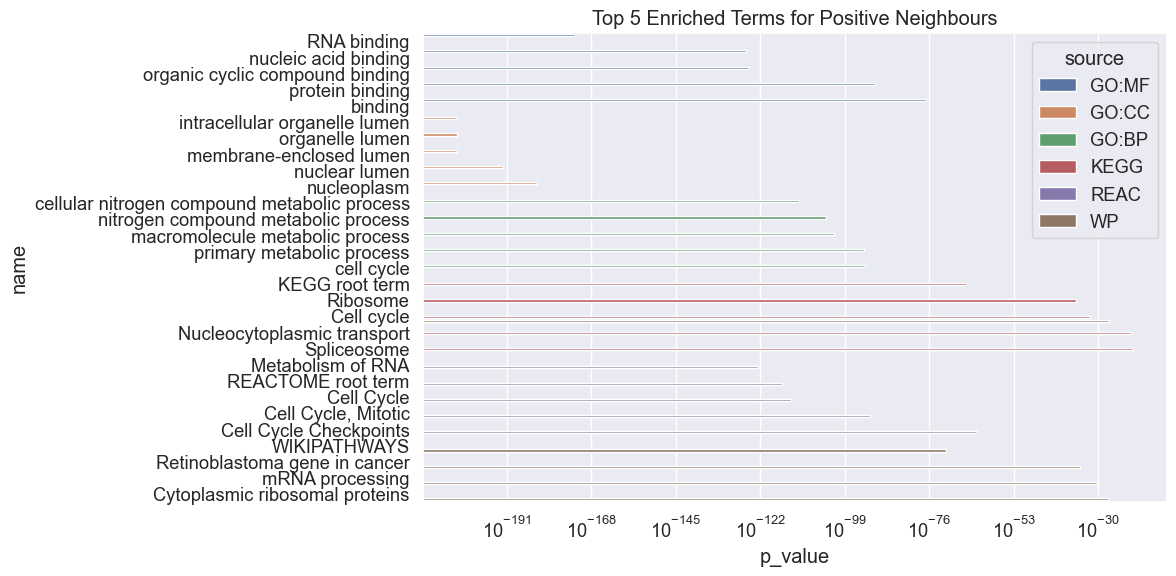

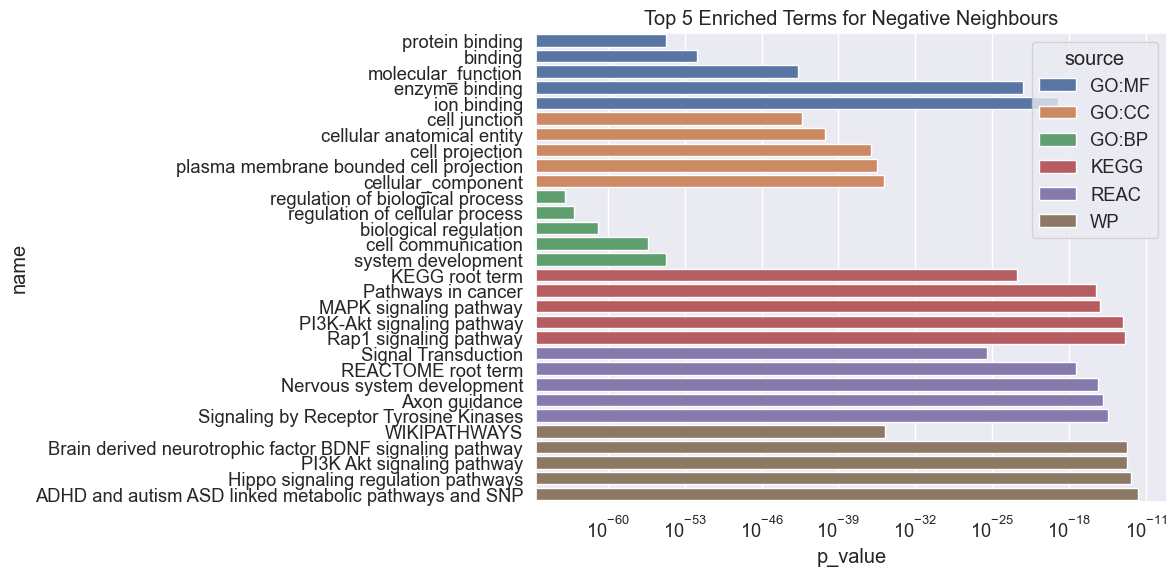

In [73]:
def plot_top_terms(enrichment_results, title):
    all_terms = pd.concat([df.sort_values('p_value').head(5) for df in enrichment_results.values()])
    plt.figure(figsize=(12, 6))
    sns.barplot(x='p_value', y='name', hue='source', data=all_terms)
    plt.title(title)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

plot_top_terms(pos_enrichment, "Top 5 Enriched Terms for Positive Neighbours")
plot_top_terms(neg_enrichment, "Top 5 Enriched Terms for Negative Neighbours")

#### SIG VS NON SIG

In [74]:
# Função para análise de enriquecimento funcional
def perform_enrichment(gene_list, background, sources):
    gp = GProfiler(return_dataframe=True)
    results = {}
    for source in sources:
        results[source] = gp.profile(
            organism='hsapiens',
            query=gene_list,
            user_threshold=0.05,
            no_evidences=False,
            sources=[source],
            all_results=False,
            domain_scope='annotated',
            background=background,
            significance_threshold_method='fdr'
        ).assign(
            fold_enrichment=lambda x: 
                x.effective_domain_size*x.intersection_size/(x.term_size*x.query_size))
    return results 

In [75]:
#significant_neighbours = resultsfiltered['neighbour'].unique()
#non_significant_neighbours = nonsignificant['neighbour'].unique() 

#print(f"Number of significant neighbours: {len(final_neighbours_list)}")
#print(f"Number of non-significant neighbours: {len(non_significant_neighbours)}")

In [76]:
# Perform enrichment for significant and non-significant neighbours
sig_enrichment_filt = perform_enrichment(significant_neighbours_filt, background, sources)
non_sig_enrichment_filt = perform_enrichment(list(non_significant_neighbours_filt), background, sources)

In [77]:
sig_enrichment = perform_enrichment(significant_neighbours, background, sources)
non_sig_enrichment = perform_enrichment(non_significant_neighbours, background, sources)

##### Filtered 

In [78]:
all_intersections_set_sig_filt = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = sig_enrichment_filt[source]
        dic_filt_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_sig
        for intersection_list in dic_filt_sig['intersections']:
            all_intersections_set_sig_filt.update(intersection_list)

# Count how many values from significant_neighbours appear in the set of intersections
count_only_sig_in_intersections = sum(1 for item in significant_neighbours_filt if item in all_intersections_set_sig_filt)

print(f"Number of values from significant_neighbours that appear in the intersections: {count_only_sig_in_intersections}")
proportion = count_only_sig_in_intersections / len(significant_neighbours_filt) 
print(f"Proportion of values from significant_neighbours that appear in the intersections: {proportion}")

Number of values from significant_neighbours that appear in the intersections: 975
Proportion of values from significant_neighbours that appear in the intersections: 0.604089219330855


In [79]:
# Define the function to count intersections
def count_intersections(row, only_set):
    intersections = row['intersections']
    # Convert the string of intersections to a list, if necessary
    if isinstance(intersections, str):
        intersections = intersections.strip('[]').replace("'", "").split(', ')
    return sum(1 for item in intersections if item in only_set)

# Apply the function to count intersections and store in a new column
dic_filt_sig['only_sig_count'] = dic_filt_sig.apply(count_intersections, axis=1, only_set=significant_neighbours_filt)

# Sort the DataFrame by 'only_sig_count' in descending order and reset the index
dic_filt_sig_sorted = dic_filt_sig[['native', 'only_sig_count']].sort_values('only_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_filt_sig_sorted)

        native  only_sig_count
0   GO:0007049             404
1   GO:0008283             293
2   GO:0012501             291
3   GO:0043067             236
4   GO:0030030             187
5   GO:0051301             175
6   GO:0006955             169
7   GO:0016477             162
8   GO:0007155             152
9   GO:0008284             149
10  GO:0009968             140
11  GO:0006281             138
12  GO:0043069             136
13  GO:0050776              97
14  GO:0034330              96
15  GO:0045787              96
16  GO:0030155              93
17  GO:0045786              92
18  GO:0045786              92
19  GO:0008285              89
20  GO:0001525              72
21  GO:0032200              51
22  GO:0000723              48
23  GO:0006282              44
24  GO:0031570              39
25  GO:0032204              30
26  GO:0071456              28
27  GO:0090398              23
28  GO:0030307              23
29  GO:0045766              22
30  GO:0045005              18
31  GO:0

In [80]:
all_intersections_set_n_sig_filt = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = non_sig_enrichment_filt[source]
        dic_filt_n_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                  left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_n_sig
        for intersection_list in dic_filt_n_sig['intersections']:
            all_intersections_set_n_sig_filt.update(intersection_list)

# Count how many values from non_significant_neighbours appear in the set of intersections
count_only_n_sig_in_intersections = sum(1 for item in non_significant_neighbours_filt if item in all_intersections_set_n_sig_filt)

print(f"Number of values from non_significant_neighbours that appear in the intersections: {count_only_n_sig_in_intersections}")
proportion = count_only_n_sig_in_intersections / len(non_significant_neighbours_filt) 
print(f"Proportion of values from non_significant_neighbours that appear in the intersections: {proportion}")

Number of values from non_significant_neighbours that appear in the intersections: 4482
Proportion of values from non_significant_neighbours that appear in the intersections: 0.3914410480349345


In [81]:
dic_filt_n_sig['only_n_sig_count'] = dic_filt_n_sig.apply(count_intersections, axis=1, only_set=non_significant_neighbours)

# Sort the DataFrame by 'only_n_sig_count' in descending order and reset the index
dic_filt_n_sig_sorted = dic_filt_n_sig[['native', 'only_n_sig_count']].sort_values('only_n_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_filt_n_sig_sorted)

        native  only_n_sig_count
0   GO:0012501              1085
1   GO:0008283              1047
2   GO:0006955               994
3   GO:0007155               902
4   GO:0030030               874
5   GO:0016477               859
6   GO:0043067               797
7   GO:0009968               763
8   GO:0050776               530
9   GO:0008284               487
10  GO:0030155               486
11  GO:0043069               464
12  GO:0034330               412
13  GO:0008285               387
14  GO:0001525               319
15  GO:0050727               215
16  GO:0007162               180
17  GO:0030308               110
18  GO:0045766               101
19  GO:0001837                93
20  GO:0030307                84
21  GO:0002367                78
22  GO:0006096                53
23  GO:0090398                52


In [82]:
terms_sig = dic_filt_sig['native'].tolist()
terms_n_sig = dic_filt_n_sig['native'].tolist()
terms_sig_set = set(terms_sig)
terms_n_sig_set = set(terms_n_sig)
intersection = terms_sig_set.intersection(terms_n_sig_set)
print(intersection)
print(len(intersection))

{'GO:0001525', 'GO:0008285', 'GO:0050776', 'GO:0008283', 'GO:0016477', 'GO:0090398', 'GO:0006955', 'GO:0006096', 'GO:0009968', 'GO:0012501', 'GO:0043067', 'GO:0007155', 'GO:0030030', 'GO:0030155', 'GO:0045766', 'GO:0008284', 'GO:0030307', 'GO:0034330', 'GO:0043069'}
19


In [83]:
dic_filt_sig = dic_filt_sig[dic_filt_sig['native'].isin(intersection)][['native', 'only_sig_count']]
dic_filt_sig['proportion'] = dic_filt_sig['only_sig_count'] / len(significant_neighbours_filt)
dic_filt_n_sig = dic_filt_n_sig[dic_filt_n_sig['native'].isin(intersection)][['native', 'only_n_sig_count']]
dic_filt_n_sig['proportion'] = dic_filt_n_sig['only_n_sig_count'] / len(non_significant_neighbours_filt)
merged_df = pd.merge(
    dic_filt_sig[['native', 'only_sig_count', 'proportion']].rename(columns={'proportion': 'sig_proportion'}),
    dic_filt_n_sig[['native', 'only_n_sig_count', 'proportion']].rename(columns={'proportion': 'non_sig_proportion'}),
    on='native',
    how='inner'  # Using outer join to ensure all terms from both significant and non-significant are included
)

# Sort the merged dataframe by 'sig_proportion' and 'non_sig_proportion' to make it easier to compare
merged_df_sorted = merged_df.sort_values(['sig_proportion', 'non_sig_proportion'], ascending=False)

# Print the merged dataframe to compare the proportions
print(merged_df_sorted)

        native  only_sig_count  sig_proportion  only_n_sig_count  \
1   GO:0008283             293        0.181537              1047   
0   GO:0012501             291        0.180297              1085   
2   GO:0043067             236        0.146221               797   
5   GO:0030030             187        0.115861               874   
15  GO:0006955             169        0.104709               994   
10  GO:0016477             162        0.100372               859   
14  GO:0007155             152        0.094176               902   
3   GO:0008284             149        0.092317               487   
12  GO:0009968             140        0.086741               763   
4   GO:0043069             136        0.084263               464   
13  GO:0050776              97        0.060099               530   
6   GO:0034330              96        0.059480               412   
11  GO:0030155              93        0.057621               486   
8   GO:0008285              89        0.055143  

In [84]:
non_sig_more = merged_df_sorted[merged_df_sorted['non_sig_proportion'] > merged_df_sorted['sig_proportion']]
non_sig_more

Empty DataFrame
Columns: [native, only_sig_count, sig_proportion, only_n_sig_count, non_sig_proportion]
Index: []

##### All DINTs

In [85]:
all_intersections_set_sig = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = sig_enrichment[source]
        dic_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_sig
        for intersection_list in dic_sig['intersections']:
            all_intersections_set_sig.update(intersection_list)

# Count how many values from significant_neighbours appear in the set of intersections
count_only_sig_in_intersections = sum(1 for item in significant_neighbours if item in all_intersections_set_sig)

print(f"Number of values from significant_neighbours that appear in the intersections: {count_only_sig_in_intersections}")
proportion = count_only_sig_in_intersections / len(significant_neighbours) 
print(f"Proportion of values from significant_neighbours that appear in the intersections: {proportion}")

Number of values from significant_neighbours that appear in the intersections: 1758
Proportion of values from significant_neighbours that appear in the intersections: 0.5634615384615385


In [86]:
# Define the function to count intersections
def count_intersections(row, only_set):
    intersections = row['intersections']
    # Convert the string of intersections to a list, if necessary
    if isinstance(intersections, str):
        intersections = intersections.strip('[]').replace("'", "").split(', ')
    return sum(1 for item in intersections if item in only_set)

# Apply the function to count intersections and store in a new column
dic_sig['only_sig_count'] = dic_sig.apply(count_intersections, axis=1, only_set=significant_neighbours)

# Sort the DataFrame by 'only_sig_count' in descending order and reset the index
dic_sig_sorted = dic_sig[['native', 'only_sig_count']].sort_values('only_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_sig_sorted)

        native  only_sig_count
0   GO:0007049             593
1   GO:0012501             538
2   GO:0008283             526
3   GO:0043067             434
4   GO:0030030             350
5   GO:0016477             347
6   GO:0006955             343
7   GO:0007155             317
8   GO:0009968             299
9   GO:0008284             271
10  GO:0043069             259
11  GO:0051301             245
12  GO:0006281             199
13  GO:0050776             197
14  GO:0034330             195
15  GO:0030155             186
16  GO:0008285             170
17  GO:0001525             136
18  GO:0045786             131
19  GO:0045786             131
20  GO:0045787             128
21  GO:0050727              86
22  GO:0032200              78
23  GO:0000723              74
24  GO:0006282              72
25  GO:0007162              64
26  GO:0031570              57
27  GO:0032204              50
28  GO:0001837              49
29  GO:0030307              47
30  GO:0030308              45
31  GO:0

In [87]:
all_intersections_set_n_sig = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = non_sig_enrichment[source]
        dic_n_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                  left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_n_sig
        for intersection_list in dic_n_sig['intersections']:
            all_intersections_set_n_sig.update(intersection_list)

# Count how many values from non_significant_neighbours appear in the set of intersections
count_only_n_sig_in_intersections = sum(1 for item in non_significant_neighbours if item in all_intersections_set_n_sig)

print(f"Number of values from non_significant_neighbours that appear in the intersections: {count_only_n_sig_in_intersections}")
proportion = count_only_n_sig_in_intersections / len(non_significant_neighbours) 
print(f"Proportion of values from non_significant_neighbours that appear in the intersections: {proportion}")

Number of values from non_significant_neighbours that appear in the intersections: 3743
Proportion of values from non_significant_neighbours that appear in the intersections: 0.376407884151247


In [88]:
dic_n_sig['only_n_sig_count'] = dic_n_sig.apply(count_intersections, axis=1, only_set=non_significant_neighbours)

# Sort the DataFrame by 'only_n_sig_count' in descending order and reset the index
dic_n_sig_sorted = dic_n_sig[['native', 'only_n_sig_count']].sort_values('only_n_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_n_sig_sorted)

        native  only_n_sig_count
0   GO:0012501              1085
1   GO:0008283              1047
2   GO:0006955               994
3   GO:0007155               902
4   GO:0030030               874
5   GO:0016477               859
6   GO:0043067               797
7   GO:0009968               763
8   GO:0050776               530
9   GO:0030155               486
10  GO:0034330               412
11  GO:0008285               387
12  GO:0001525               320
13  GO:0050727               215
14  GO:0007162               180
15  GO:0030308               110
16  GO:0045766               101
17  GO:0002367                78


In [89]:
terms_sig = dic_sig['native'].tolist()
terms_n_sig = dic_n_sig['native'].tolist()
terms_sig_set = set(terms_sig)
terms_n_sig_set = set(terms_n_sig)
intersection = terms_sig_set.intersection(terms_n_sig_set)
print(intersection)

{'GO:0030155', 'GO:0007162', 'GO:0009968', 'GO:0016477', 'GO:0001525', 'GO:0012501', 'GO:0043067', 'GO:0006955', 'GO:0008285', 'GO:0045766', 'GO:0050776', 'GO:0007155', 'GO:0030308', 'GO:0034330', 'GO:0050727', 'GO:0008283', 'GO:0030030'}


In [90]:
print(len(intersection))

17


In [91]:
dic_sig = dic_sig[dic_sig['native'].isin(intersection)][['native', 'only_sig_count']]
dic_sig['proportion'] = dic_sig['only_sig_count'] / len(significant_neighbours)
dic_n_sig = dic_n_sig[dic_n_sig['native'].isin(intersection)][['native', 'only_n_sig_count']]
dic_n_sig['proportion'] = dic_n_sig['only_n_sig_count'] / len(non_significant_neighbours)
merged_df = pd.merge(
    dic_filt_sig[['native', 'only_sig_count', 'proportion']].rename(columns={'proportion': 'sig_proportion'}),
    dic_n_sig[['native', 'only_n_sig_count', 'proportion']].rename(columns={'proportion': 'non_sig_proportion'}),
    on='native',
    how='inner'  # Using outer join to ensure all terms from both significant and non-significant are included
)

# Sort the merged dataframe by 'sig_proportion' and 'non_sig_proportion' to make it easier to compare
merged_df_sorted = merged_df.sort_values(['sig_proportion', 'non_sig_proportion'], ascending=False)

# Print the merged dataframe to compare the proportions
print(merged_df_sorted)

        native  only_sig_count  sig_proportion  only_n_sig_count  \
1   GO:0008283             293        0.181537              1047   
0   GO:0012501             291        0.180297              1085   
2   GO:0043067             236        0.146221               797   
3   GO:0030030             187        0.115861               874   
12  GO:0006955             169        0.104709               994   
7   GO:0016477             162        0.100372               859   
11  GO:0007155             152        0.094176               902   
9   GO:0009968             140        0.086741               763   
10  GO:0050776              97        0.060099               530   
4   GO:0034330              96        0.059480               412   
8   GO:0030155              93        0.057621               486   
5   GO:0008285              89        0.055143               387   
6   GO:0001525              72        0.044610               320   
13  GO:0045766              22        0.013631  

In [92]:
non_sig_more = merged_df_sorted[merged_df_sorted['non_sig_proportion'] > merged_df_sorted['sig_proportion']]
non_sig_more

Empty DataFrame
Columns: [native, only_sig_count, sig_proportion, only_n_sig_count, non_sig_proportion]
Index: []

## TAU

#### POS VS NEG

In [93]:
# Load TAU data
tau_df = pd.read_csv('gene_exp.csv')
tau_df = tau_df.set_index('gene_id')
tau_df_filtered = tau_df[~tau_df.index.duplicated(keep='first')]

# Obtain TAU values for positive and negative neighbours
pos_tau = tau_df_filtered.loc[tau_df_filtered.index.isin(only_pos), 'tau']
neg_tau = tau_df_filtered.loc[tau_df_filtered.index.isin(only_neg), 'tau']

# Mann-Whitney U test for comparison of TAU between positive and negative neighbours
u_stat_tau, p_value_tau = stats.mannwhitneyu(pos_tau, neg_tau)
print(f"\nComparison of TAU between positive-only and negative-only neighbours:")
print(f"U-statistic: {u_stat_tau}")
print(f"P-value: {p_value_tau}")

# Correlation between association counts and TAU
neighbour_counts_with_tau = consistent_neighbours.reset_index().merge(tau_df_filtered[['tau']], left_on='neighbour', right_index=True, how='left')
correlation = neighbour_counts_with_tau['num_associated_drivers'].corr(neighbour_counts_with_tau['tau'])
print(f"\nCorrelation between association counts and TAU: {correlation}")

""" # Visualização da distribuição de TAU para vizinhos positivos e negativos
plt.figure(figsize=(10, 6))
plt.hist(pos_tau, bins=30, alpha=0.5, label='Vizinhos Positivos')
plt.hist(neg_tau, bins=30, alpha=0.5, label='Vizinhos Negativos')
plt.xlabel('TAU')
plt.ylabel('Contagem')
plt.title('Distribuição de TAU para Vizinhos Positivos e Negativos')
plt.legend()
plt.show() """



Comparison of TAU between positive-only and negative-only neighbours:
U-statistic: 887123.5
P-value: 1.1742397188028401e-32

Correlation between association counts and TAU: 0.03788228073968786


" # Visualização da distribuição de TAU para vizinhos positivos e negativos\nplt.figure(figsize=(10, 6))\nplt.hist(pos_tau, bins=30, alpha=0.5, label='Vizinhos Positivos')\nplt.hist(neg_tau, bins=30, alpha=0.5, label='Vizinhos Negativos')\nplt.xlabel('TAU')\nplt.ylabel('Contagem')\nplt.title('Distribuição de TAU para Vizinhos Positivos e Negativos')\nplt.legend()\nplt.show() "

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/1909621687.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_tau, shade=True, label='Positive Neighbours')
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/1909621687.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_tau, shade=True, label='Negative Neighbours')


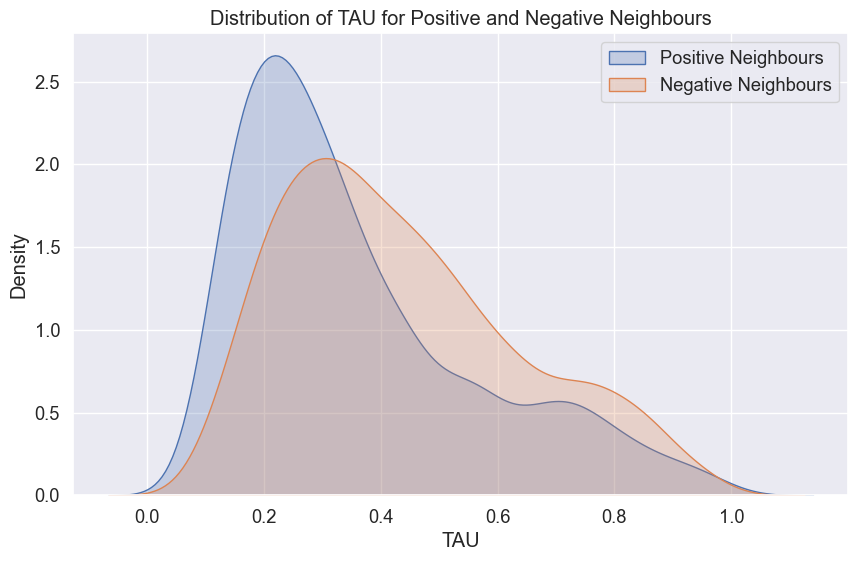

In [94]:
plt.figure(figsize=(10, 6))
sns.kdeplot(pos_tau, shade=True, label='Positive Neighbours')
sns.kdeplot(neg_tau, shade=True, label='Negative Neighbours')
plt.xlabel('TAU')
plt.ylabel('Density')
plt.title('Distribution of TAU for Positive and Negative Neighbours')
plt.legend()
plt.show()

#### SIG VS NON SIG

##### Filtered

In [95]:
meanexp = tumourexp.reset_index(drop=True).median().rename("expression")
u_stat, p_value_u = stats.mannwhitneyu(meanexp.loc[significant_neighbours_filt],
                                       meanexp.loc[non_significant_neighbours_filt],
                                       alternative='two-sided')

print(f"\nComparação de expressão génica entre vizinhos significativos e não significativos usando Mann-Whitney U:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value_u}")



Comparação de expressão génica entre vizinhos significativos e não significativos usando Mann-Whitney U:
U-statistic: 11290221.0
P-value: 2.4085830597338116e-47


In [96]:
# Convert neighbour lists to sets to remove duplicates
significant_neighbours_filt_set = set(significant_neighbours_filt)
non_significant_neighbours_filt_set = set(non_significant_neighbours_filt)

# Create sets of neighbours that exist in tau_df
significant_neighbours_filt_tau = significant_neighbours_filt_set.intersection(tau_df_filtered.index)
non_significant_neighbours_filt_tau = non_significant_neighbours_filt_set.intersection(tau_df_filtered.index)

# Convert the sets back to lists for indexing
significant_neighbours_filt_list = list(significant_neighbours_filt_tau)
non_significant_neighbours_filt_list = list(non_significant_neighbours_filt_tau)

# Obtain the tau values for significant and non-significant neighbours
sig_tau_filt = tau_df_filtered.loc[significant_neighbours_filt_list, 'tau']
non_sig_tau_filt = tau_df_filtered.loc[non_significant_neighbours_filt_list, 'tau']

# Perform the Mann-Whitney U test
u_stat, u_p_value = stats.mannwhitneyu(sig_tau_filt, non_sig_tau_filt)

print("\nComparison of TAU between significant and non-significant neighbours:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {u_p_value}")

""" # Criar o histograma
plt.figure(figsize=(10, 6))
plt.hist(sig_tau, bins=30, alpha=0.5, label='Vizinhos Significativos')
plt.hist(non_sig_tau, bins=30, alpha=0.5, label='Vizinhos Não Significativos')
plt.xlabel('TAU')
plt.ylabel('Contagem')
plt.title('Distribuição de TAU para Vizinhos Significativos e Não Significativos')
plt.legend()
plt.show() """


Comparison of TAU between significant and non-significant neighbours:
U-statistic: 7617976.5
P-value: 7.275591615971163e-26


" # Criar o histograma\nplt.figure(figsize=(10, 6))\nplt.hist(sig_tau, bins=30, alpha=0.5, label='Vizinhos Significativos')\nplt.hist(non_sig_tau, bins=30, alpha=0.5, label='Vizinhos Não Significativos')\nplt.xlabel('TAU')\nplt.ylabel('Contagem')\nplt.title('Distribuição de TAU para Vizinhos Significativos e Não Significativos')\nplt.legend()\nplt.show() "

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/3101703401.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sig_tau_filt, shade=True, label='Significant Neighbours')
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/3101703401.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_sig_tau_filt, shade=True, label='Non-Significant Neighbours')


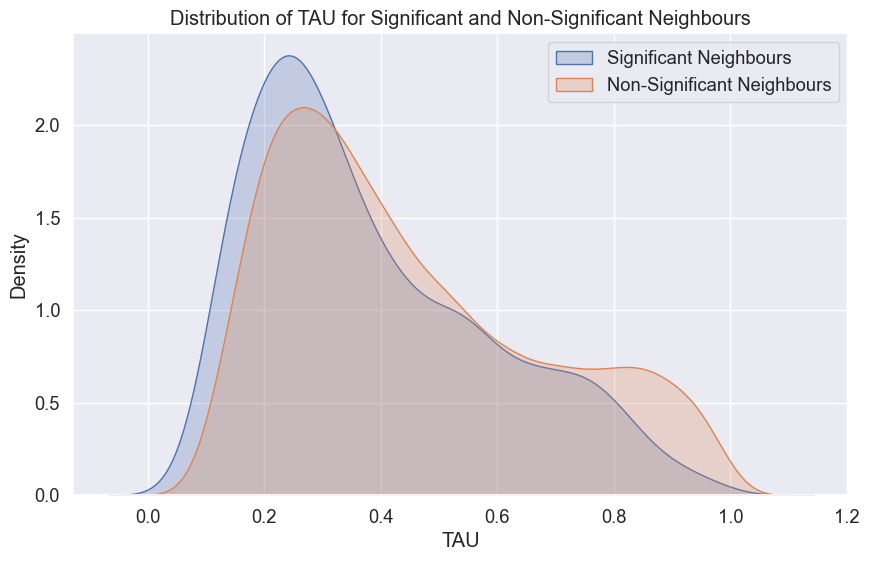

In [97]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(sig_tau_filt, shade=True, label='Significant Neighbours')
sns.kdeplot(non_sig_tau_filt, shade=True, label='Non-Significant Neighbours')
plt.xlabel('TAU')
plt.ylabel('Density')
plt.title('Distribution of TAU for Significant and Non-Significant Neighbours')
plt.legend()
plt.show()

In [98]:
def overlap_coefficient(dist1, dist2, bins=100):
    hist1, _ = np.histogram(dist1, bins=bins)
    hist2, _ = np.histogram(dist2, bins=bins)
    minima = np.minimum(hist1, hist2)
    overlap = np.true_divide(np.sum(minima), np.minimum(np.sum(hist1), np.sum(hist2)))
    return overlap

overlap = overlap_coefficient(sig_tau_filt, non_sig_tau_filt)
print(f"Overlap coefficient: {overlap}")

#Para o coeficiente de sobreposição, valores próximos a 1 indicam alta sobreposição, enquanto valores próximos a 0 indicam pouca sobreposição.


Overlap coefficient: 0.9993777224642191


In [99]:
from numpy import array
from scipy.stats import mannwhitneyu

# Function to compute Cliff's Delta
def cliffs_delta(data1, data2):
    n1, n2 = len(data1), len(data2)
    pairs = [(x, y) for x in data1 for y in data2]
    more = sum([x > y for (x, y) in pairs])
    less = sum([x < y for (x, y) in pairs])
    return (more - less) / (n1 * n2)

# Assuming sig_tau and non_sig_tau are your TAU values for significant and non-significant neighbours
delta = cliffs_delta(sig_tau_filt, non_sig_tau_filt)
print(f"Cliff's Delta: {delta}")


Cliff's Delta: -0.16186427792481445


In [100]:
import numpy as np
from scipy import stats

# Perform the Mann-Whitney U test
u_stat, p_value_u = stats.mannwhitneyu(sig_tau_filt, non_sig_tau_filt)

# Calculate the rank-biserial correlation (r)
n1 = len(sig_tau_filt)
n2 = len(non_sig_tau_filt)
r = 1 - (2 * u_stat) / (n1 * n2)
print(f"Rank-Biserial Correlation (r): {r}")


Rank-Biserial Correlation (r): 0.1618642779248144


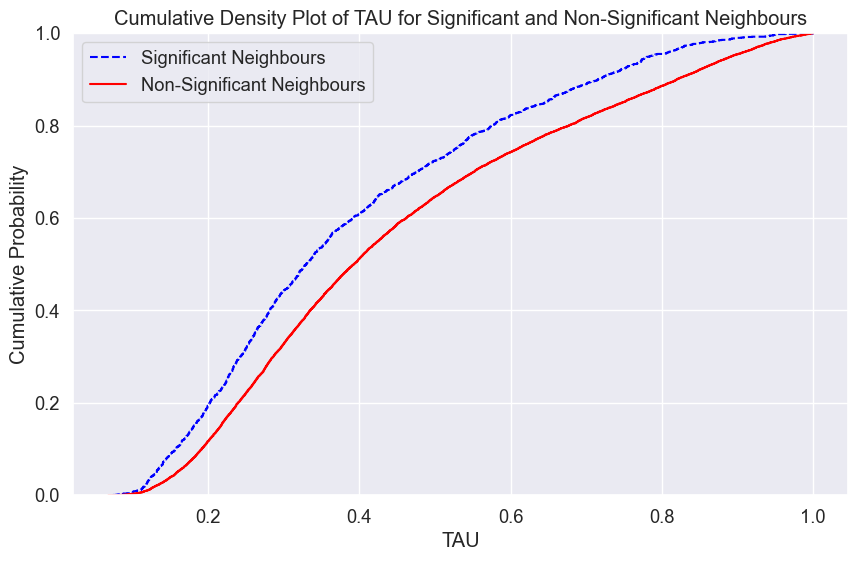

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create cumulative density plots for TAU values of significant and non-significant neighbors
plt.figure(figsize=(10, 6))
sns.ecdfplot(sig_tau_filt, label='Significant Neighbours', linestyle='--', color='blue')
sns.ecdfplot(non_sig_tau_filt, label='Non-Significant Neighbours', linestyle='-', color='red')
plt.xlabel('TAU')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Density Plot of TAU for Significant and Non-Significant Neighbours')
plt.legend()
plt.show()


##### All DINTs

In [102]:
u_stat, p_value_u = stats.mannwhitneyu(meanexp.loc[significant_neighbours],
                                       meanexp.loc[non_significant_neighbours],
                                       alternative='two-sided')

print(f"\nComparação de expressão génica entre vizinhos significativos e não significativos usando Mann-Whitney U:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value_u}")

### NÃO FAZ SENTIDO ESTA ANÁLISE PARA AGORA ####    
                                      
""" plt.figure(figsize=(12, 6))
plt.hist(significant_expr.values.flatten(), bins=30, alpha=0.5, label='Vizinhos Significativos')
plt.hist(non_significant_expr.values.flatten(), bins=30, alpha=0.5, label='Vizinhos Não Significativos')
plt.xlabel('Valor de Expressão Génica')
plt.ylabel('Contagem')
plt.title('Distribuição da Expressão Génica para Vizinhos Significativos e Não Significativos')
plt.legend()
plt.show()
 """


Comparação de expressão génica entre vizinhos significativos e não significativos usando Mann-Whitney U:
U-statistic: 18688333.0
P-value: 6.77905723559261e-67


" plt.figure(figsize=(12, 6))\nplt.hist(significant_expr.values.flatten(), bins=30, alpha=0.5, label='Vizinhos Significativos')\nplt.hist(non_significant_expr.values.flatten(), bins=30, alpha=0.5, label='Vizinhos Não Significativos')\nplt.xlabel('Valor de Expressão Génica')\nplt.ylabel('Contagem')\nplt.title('Distribuição da Expressão Génica para Vizinhos Significativos e Não Significativos')\nplt.legend()\nplt.show()\n "

In [103]:
# Convert neighbour lists to sets to remove duplicates
significant_neighbours_set = set(significant_neighbours)
non_significant_neighbours_set = set(non_significant_neighbours)

# Create sets of neighbours that exist in tau_df
significant_neighbours_tau = significant_neighbours_set.intersection(tau_df_filtered.index)
non_significant_neighbours_tau = non_significant_neighbours_set.intersection(tau_df_filtered.index)

# Convert the sets back to lists for indexing
significant_neighbours_list = list(significant_neighbours_tau)
non_significant_neighbours_list = list(non_significant_neighbours_tau)

# Obtain the tau values for significant and non-significant neighbours
sig_tau = tau_df_filtered.loc[significant_neighbours_list, 'tau']
non_sig_tau = tau_df_filtered.loc[non_significant_neighbours_list, 'tau']

# Perform the Mann-Whitney U test
u_stat, u_p_value = stats.mannwhitneyu(sig_tau, non_sig_tau)

print("\nComparison of TAU between significant and non-significant neighbours:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {u_p_value}")

""" # Criar o histograma
plt.figure(figsize=(10, 6))
plt.hist(sig_tau, bins=30, alpha=0.5, label='Vizinhos Significativos')
plt.hist(non_sig_tau, bins=30, alpha=0.5, label='Vizinhos Não Significativos')
plt.xlabel('TAU')
plt.ylabel('Contagem')
plt.title('Distribuição de TAU para Vizinhos Significativos e Não Significativos')
plt.legend()
plt.show() """


Comparison of TAU between significant and non-significant neighbours:
U-statistic: 12833152.5
P-value: 1.8143146583569149e-40


" # Criar o histograma\nplt.figure(figsize=(10, 6))\nplt.hist(sig_tau, bins=30, alpha=0.5, label='Vizinhos Significativos')\nplt.hist(non_sig_tau, bins=30, alpha=0.5, label='Vizinhos Não Significativos')\nplt.xlabel('TAU')\nplt.ylabel('Contagem')\nplt.title('Distribuição de TAU para Vizinhos Significativos e Não Significativos')\nplt.legend()\nplt.show() "

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/1451486643.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sig_tau, shade=True, label='Significant Neighbours')
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/1451486643.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_sig_tau, shade=True, label='Non-Significant Neighbours')


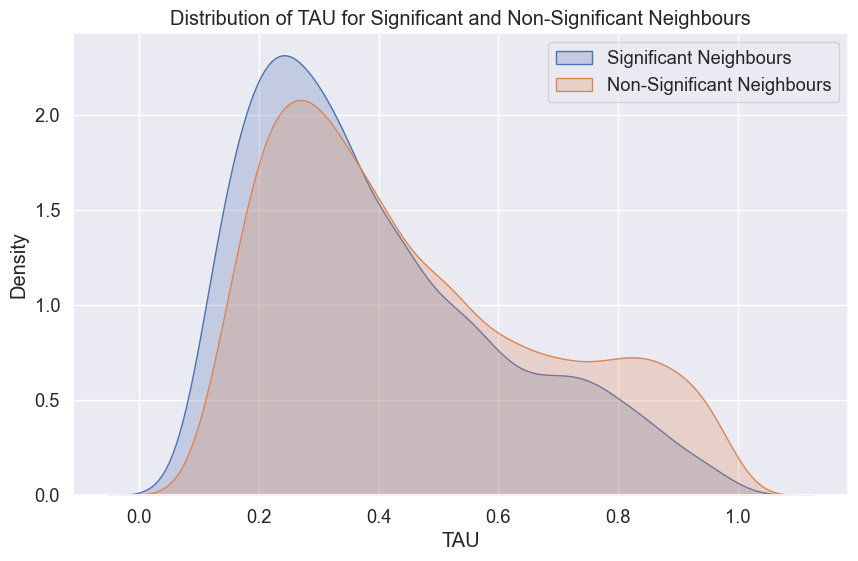

In [104]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(sig_tau, shade=True, label='Significant Neighbours')
sns.kdeplot(non_sig_tau, shade=True, label='Non-Significant Neighbours')
plt.xlabel('TAU')
plt.ylabel('Density')
plt.title('Distribution of TAU for Significant and Non-Significant Neighbours')
plt.legend()
plt.show()

In [105]:
def overlap_coefficient(dist1, dist2, bins=100):
    hist1, _ = np.histogram(dist1, bins=bins)
    hist2, _ = np.histogram(dist2, bins=bins)
    minima = np.minimum(hist1, hist2)
    overlap = np.true_divide(np.sum(minima), np.minimum(np.sum(hist1), np.sum(hist2)))
    return overlap

overlap = overlap_coefficient(sig_tau, non_sig_tau)
print(f"Overlap coefficient: {overlap}")

#Para o coeficiente de sobreposição, valores próximos a 1 indicam alta sobreposição, enquanto valores próximos a 0 indicam pouca sobreposição.


Overlap coefficient: 0.9929214929214929


In [106]:
from numpy import array
from scipy.stats import mannwhitneyu

# Function to compute Cliff's Delta
def cliffs_delta(data1, data2):
    n1, n2 = len(data1), len(data2)
    pairs = [(x, y) for x in data1 for y in data2]
    more = sum([x > y for (x, y) in pairs])
    less = sum([x < y for (x, y) in pairs])
    return (more - less) / (n1 * n2)

# Assuming sig_tau and non_sig_tau are your TAU values for significant and non-significant neighbours
delta = cliffs_delta(sig_tau, non_sig_tau)
print(f"Cliff's Delta: {delta}")


Cliff's Delta: -0.15827725085191194


In [107]:
import numpy as np
from scipy import stats

# Perform the Mann-Whitney U test
u_stat, p_value_u = stats.mannwhitneyu(sig_tau, non_sig_tau)

# Calculate the rank-biserial correlation (r)
n1 = len(sig_tau)
n2 = len(non_sig_tau)
r = 1 - (2 * u_stat) / (n1 * n2)
print(f"Rank-Biserial Correlation (r): {r}")


Rank-Biserial Correlation (r): 0.1582772508519119


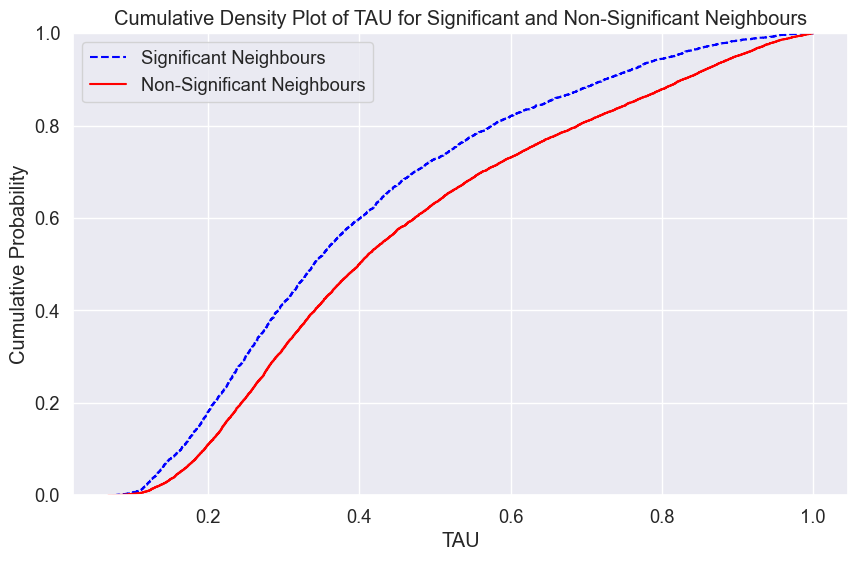

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create cumulative density plots for TAU values of significant and non-significant neighbors
plt.figure(figsize=(10, 6))
sns.ecdfplot(sig_tau, label='Significant Neighbours', linestyle='--', color='blue')
sns.ecdfplot(non_sig_tau, label='Non-Significant Neighbours', linestyle='-', color='red')
plt.xlabel('TAU')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Density Plot of TAU for Significant and Non-Significant Neighbours')
plt.legend()
plt.show()


## Neighbours Analysis

In [109]:
import pandas as pd
import numpy as np

# Load resultsfiltered
# resultsfiltered = pd.read_csv(datadir + "DINTs.csv")

# Load the NCG file
cancerdrivers = pd.read_table('NCG_cancerdrivers_annotation_supporting_evidence.tsv')

# Filter the neighbours that are not in the NCG
non_ncg_neighbours = dints[~dints['neighbour'].isin(cancerdrivers['symbol'])]

print(f"Number of neighbours not present in the NCG: {non_ncg_neighbours['neighbour'].nunique()}")

# Function to check the consistency of the sign
def check_sign_consistency(group):
    signs = np.sign(group['coef'])
    return (signs == signs.iloc[0]).all()

# Group by neighbour and check the consistency of the sign
neighbour_consistency = non_ncg_neighbours.groupby('neighbour').apply(check_sign_consistency)

# Count the number of drivers associated with each neighbour
driver_counts = non_ncg_neighbours.groupby('neighbour')['driver'].nunique()

# Combine information
neighbour_analysis = pd.DataFrame({
    'num_associated_drivers': driver_counts,
    'is_consistent': neighbour_consistency
})

# Filter only consistent neighbours
consistent_neighbours = neighbour_analysis[neighbour_analysis['is_consistent']]

# Sort by number of associated drivers (descending) and select top 50
top_50_neighbours = consistent_neighbours.sort_values('num_associated_drivers', ascending=False).head(50)
# top_60_neighbours = consistent_neighbours.sort_values('num_associated_drivers', ascending=False).head(60)

# Add information about the type of association (positive or negative)
def get_association_type(neighbour):
    coef = non_ncg_neighbours[non_ncg_neighbours['neighbour'] == neighbour]['coef'].iloc[0]
    return 'Positive' if coef > 0 else 'Negative'

top_50_neighbours['association_type'] = top_50_neighbours.index.map(get_association_type)

# Reset the index to have the neighbour as a column
top_50_neighbours = top_50_neighbours.reset_index()

# Display the results
print(top_50_neighbours)

Number of neighbours not present in the NCG: 2345
   neighbour  num_associated_drivers  is_consistent association_type
0       CDK1                     154           True         Positive
1       CCNF                     122           True         Positive
2      KIF14                     113           True         Positive
3     KIF20A                     106           True         Positive
4      STIP1                      91           True         Positive
5      AURKB                      87           True         Positive
6      KIF23                      85           True         Positive
7      LMNB1                      79           True         Positive
8       CDK2                      72           True         Positive
9   HSP90AA1                      69           True         Positive
10     CCNB1                      65           True         Positive
11     KPNA2                      60           True         Positive
12      PRC1                      53           True  

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/298129571.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neighbour_consistency = non_ncg_neighbours.groupby('neighbour').apply(check_sign_consistency)


In [110]:
# Select the tumour expression data for non-NCG neighbours
tumourexp = pd.read_feather(datadir + "tumour_expression.feather")
selected_tumourexp = tumourexp.reset_index()[['patient', 'cancer_type'] + top_50_neighbours['neighbour'].tolist()]

# Load the survival data
clintab = pd.read_table('Survival_SupplementalTable_S1_20171025_xena_sp')
survival_data = clintab[['_PATIENT', 'OS.time', 'OS']]

# Merge the expression data with the survival data
final_data = selected_tumourexp.merge(survival_data, left_on='patient', right_on='_PATIENT', how='inner')

# Remove the duplicate 'sample' column
final_data = final_data.drop(columns=['_PATIENT'])

final_data
# Save the final dataset
# final_data.to_csv(datadir + "final_data_for_analysis.csv", index=False)

patient cancer_type   CDK1   CCNF  KIF14  KIF20A  STIP1  AURKB  \
0     TCGA-02-0047         GBM   9.07   8.12   7.30    8.28  11.33   7.67   
1     TCGA-02-0055         GBM   9.09   7.62   6.43    8.10  11.93   7.46   
2     TCGA-02-2483         GBM  10.07   9.01   8.31    8.97  12.19   9.89   
3     TCGA-02-2485         GBM   9.32   8.18   7.43    8.27  11.67   8.19   
4     TCGA-02-2486         GBM   6.30   5.98   4.31    5.00  11.53   4.07   
...            ...         ...    ...    ...    ...     ...    ...    ...   
9622  TCGA-ZS-A9CG        LIHC   5.27   4.86   4.48    2.84  11.89   3.94   
9623  TCGA-ZT-A8OM        THYM  10.33  10.94   6.61    7.27  12.15  11.86   
9624  TCGA-ZU-A8S4        CHOL  10.28   9.24   8.19    9.61  12.43   9.72   
9625  TCGA-ZU-A8S4        CHOL  10.28   9.24   8.19    9.61  12.43   9.72   
9626  TCGA-ZX-AA5X        CESC   9.95   9.72   7.94    9.52  11.22   8.20   

      KIF23  LMNB1  ...  KIF11   E2F1  DCPS  SPAG5  FANCI  SHMT2  RAD18  SNCA  \
0      7.59   9.96  ...   9.09   8.52  7.87   8.60   8.92  10.51   7.22  9.81   
1      8.53   8.87  ...   8.18   8.38  8.26   8.34   8.87  10.81   7.93  9.15   
2      9.37  11.28  ...   9.59  10.73  8.52  10.13  10.72  12.35   8.11  6.77   
3      8.67  10.93  ...   8.83   9.93  9.12   9.53   9.88  10.34   8.31  7.50   
4      5.30   7.71  ...   6.04   7.33  8.31   6.01   7.52  10.85   6.37  8.63   
...     ...    ...  ...    ...    ...   ...    ...    ...    ...    ...   ...   
9622   2.84   6.44  ...   4.96   6.74  7.77   5.67   6.18  12.82   6.82  2.97   
9623   8.30   9.95  ...  10.41  11.14  9.40  10.46  11.69  11.47   7.81  6.19   
9624   9.63  10.34  ...  10.12   9.65  9.17  10.35   9.61  11.37   8.10  8.68   
9625   9.63  10.34  ...  10.12   9.65  9.17  10.35   9.61  11.37   8.10  8.68   
9626   9.34  10.66  ...   9.86   9.13  8.37   9.58  10.40  11.14   7.97  7.35   

      OS.time   OS  
0       448.0  1.0  
1        76.0  1.0  
2       466.0  0.0  
3       470.0  0.0  
4       618.0  1.0  
...       ...  ...  
9622    341.0  0.0  
9623   1398.0  0.0  
9624     98.0  1.0  
9625     98.0  1.0  
9626    119.0  0.0  

[9627 rows x 54 columns]

In [111]:
print(final_data.isnull().sum())

patient         0
cancer_type     0
CDK1            0
CCNF            0
KIF14           0
KIF20A          0
STIP1           0
AURKB           0
KIF23           0
LMNB1           0
CDK2            0
HSP90AA1        0
CCNB1           0
KPNA2           0
PRC1            0
CHEK1           0
XRCC6           0
PCNA            0
CENPA           0
TRIM25          0
UBE2T           0
MTA2            0
UBE2S           0
MCM2            0
LRRC59          0
OBSL1           0
RAN             0
PFN1            0
HDAC5           0
RAD51           0
UBE2I           0
GTSE1           0
TMPO            0
CCNA2           0
TFRC            0
MAD2L1          0
LYAR            0
SSRP1           0
CEP55           0
CSK             0
SNRPD1          0
DNAJC9          0
TUBG1           0
C1QBP           0
KIF11           0
E2F1            0
DCPS            0
SPAG5           0
FANCI           0
SHMT2           0
RAD18           0
SNCA            0
OS.time        32
OS              0
dtype: int64


In [112]:
final_data.dropna(subset=['OS.time', 'OS'], inplace=True)

In [113]:
import pandas as pd
import numpy as np

# Supondo que filt_neighbours já esteja carregado

# Filtra os vizinhos significativos usando 'significant_neighbours_filt'
significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] != 'non_sign']['neighbour'].tolist()

# Filtra os vizinhos significativos que não estão no arquivo NCG
non_ncg_neighbours = filt_neighbours[
    filt_neighbours['neighbour'].isin(significant_neighbours_filt) & 
    ~filt_neighbours['neighbour'].isin(cancerdrivers['symbol'])
]

print(f"Number of significant neighbours not present in the NCG: {non_ncg_neighbours['neighbour'].nunique()}")

# Função para verificar a consistência baseada nas colunas pos_dints e neg_dints
def check_sign_consistency(row):
    if row['pos_dints'] > 0 and row['neg_dints'] == 0:
        return 'Positive'
    elif row['neg_dints'] > 0 and row['pos_dints'] == 0:
        return 'Negative'
    else:
        return 'Inconsistent'

# Adiciona a consistência como uma nova coluna
non_ncg_neighbours['consistency'] = non_ncg_neighbours.apply(check_sign_consistency, axis=1)

# Usar a coluna n_dints para contar o número de drivers associados a cada vizinho
driver_counts = non_ncg_neighbours.set_index('neighbour')['n_dints']

# Combina as informações em um DataFrame
neighbour_analysis = pd.DataFrame({
    'num_associated_drivers': driver_counts,
    'consistency': non_ncg_neighbours.groupby('neighbour')['consistency'].first()
})

# Filtra apenas os vizinhos consistentes (Positive ou Negative)
consistent_neighbours = neighbour_analysis[neighbour_analysis['consistency'] != 'Inconsistent']

# Ordena pelo número de drivers associados e seleciona os 50 primeiros
top_50_neighbours_filt = consistent_neighbours.sort_values('num_associated_drivers', ascending=False).head(50)

# Adiciona o tipo de associação ao DataFrame (Positive ou Negative)
top_50_neighbours_filt['association_type'] = top_50_neighbours_filt['consistency']

# Reseta o índice para ter o neighbour como uma coluna
top_50_neighbours_filt = top_50_neighbours_filt.reset_index()

# Exibe os resultados
print(top_50_neighbours_filt)


Number of significant neighbours not present in the NCG: 1210
   neighbour  num_associated_drivers consistency association_type
0       CDK1                     154    Positive         Positive
1       CCNF                     122    Positive         Positive
2      KIF14                     113    Positive         Positive
3     KIF20A                     106    Positive         Positive
4      STIP1                      91    Positive         Positive
5      AURKB                      87    Positive         Positive
6      KIF23                      85    Positive         Positive
7      LMNB1                      79    Positive         Positive
8       CDK2                      72    Positive         Positive
9   HSP90AA1                      69    Positive         Positive
10     CCNB1                      65    Positive         Positive
11     KPNA2                      60    Positive         Positive
12      PRC1                      53    Positive         Positive
13     CHEK1  

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/1975526075.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_ncg_neighbours['consistency'] = non_ncg_neighbours.apply(check_sign_consistency, axis=1)


In [114]:
# Verifica os neighbours em top_50_neighbours_filt e não em top_50_neighbours
neighbours_only_in_filt = set(top_50_neighbours_filt['neighbour']) - set(top_50_neighbours['neighbour'])
print(f"Neighbours only in top_50_neighbours_filt: {neighbours_only_in_filt}")

# Verifica os neighbours em top_50_neighbours e não em top_50_neighbours_filt
neighbours_only_in_original = set(top_50_neighbours['neighbour']) - set(top_50_neighbours_filt['neighbour'])
print(f"Neighbours only in top_50_neighbours: {neighbours_only_in_original}")

# Verifica os neighbours que estão em ambos os DataFrames
neighbours_in_both = set(top_50_neighbours_filt['neighbour']).intersection(set(top_50_neighbours['neighbour']))
print(f"Neighbours in both DataFrames: {neighbours_in_both}")



Neighbours only in top_50_neighbours_filt: {'RRM2'}
Neighbours only in top_50_neighbours: {'RAD18'}
Neighbours in both DataFrames: {'CEP55', 'SSRP1', 'CCNB1', 'AURKB', 'KIF11', 'OBSL1', 'C1QBP', 'PCNA', 'PFN1', 'TMPO', 'E2F1', 'RAD51', 'STIP1', 'UBE2S', 'SPAG5', 'SNCA', 'KIF20A', 'KPNA2', 'TUBG1', 'HDAC5', 'CCNA2', 'FANCI', 'LRRC59', 'SNRPD1', 'DNAJC9', 'KIF23', 'TRIM25', 'RAN', 'KIF14', 'CENPA', 'LYAR', 'MTA2', 'MCM2', 'UBE2I', 'CHEK1', 'PRC1', 'GTSE1', 'HSP90AA1', 'MAD2L1', 'XRCC6', 'CCNF', 'UBE2T', 'CDK2', 'DCPS', 'LMNB1', 'CSK', 'TFRC', 'SHMT2', 'CDK1'}


In [115]:
# Select the tumour expression data for non-NCG neighbours
tumourexp = pd.read_feather(datadir + "tumour_expression.feather")
selected_tumourexp_filt = tumourexp.reset_index()[['patient', 'cancer_type'] + top_50_neighbours_filt['neighbour'].tolist()]

# Load the survival data
clintab = pd.read_table('Survival_SupplementalTable_S1_20171025_xena_sp')
survival_data = clintab[['_PATIENT', 'OS.time', 'OS']]

# Merge the expression data with the survival data
final_data_filt = selected_tumourexp_filt.merge(survival_data, left_on='patient', right_on='_PATIENT', how='inner')

# Remove the duplicate 'sample' column
final_data_filt = final_data_filt.drop(columns=['_PATIENT'])

final_data_filt
# Save the final dataset
# final_data.to_csv(datadir + "final_data_for_analysis.csv", index=False)

patient cancer_type   CDK1   CCNF  KIF14  KIF20A  STIP1  AURKB  \
0     TCGA-02-0047         GBM   9.07   8.12   7.30    8.28  11.33   7.67   
1     TCGA-02-0055         GBM   9.09   7.62   6.43    8.10  11.93   7.46   
2     TCGA-02-2483         GBM  10.07   9.01   8.31    8.97  12.19   9.89   
3     TCGA-02-2485         GBM   9.32   8.18   7.43    8.27  11.67   8.19   
4     TCGA-02-2486         GBM   6.30   5.98   4.31    5.00  11.53   4.07   
...            ...         ...    ...    ...    ...     ...    ...    ...   
9622  TCGA-ZS-A9CG        LIHC   5.27   4.86   4.48    2.84  11.89   3.94   
9623  TCGA-ZT-A8OM        THYM  10.33  10.94   6.61    7.27  12.15  11.86   
9624  TCGA-ZU-A8S4        CHOL  10.28   9.24   8.19    9.61  12.43   9.72   
9625  TCGA-ZU-A8S4        CHOL  10.28   9.24   8.19    9.61  12.43   9.72   
9626  TCGA-ZX-AA5X        CESC   9.95   9.72   7.94    9.52  11.22   8.20   

      KIF23  LMNB1  ...  TUBG1  DCPS  SPAG5   E2F1  FANCI  SHMT2  SNCA   RRM2  \
0      7.59   9.96  ...   9.30  7.87   8.60   8.52   8.92  10.51  9.81   9.64   
1      8.53   8.87  ...   9.70  8.26   8.34   8.38   8.87  10.81  9.15  10.15   
2      9.37  11.28  ...  10.22  8.52  10.13  10.73  10.72  12.35  6.77  11.07   
3      8.67  10.93  ...   9.84  9.12   9.53   9.93   9.88  10.34  7.50   9.95   
4      5.30   7.71  ...   9.81  8.31   6.01   7.33   7.52  10.85  8.63   7.49   
...     ...    ...  ...    ...   ...    ...    ...    ...    ...   ...    ...   
9622   2.84   6.44  ...   9.06  7.77   5.67   6.74   6.18  12.82  2.97   6.65   
9623   8.30   9.95  ...   9.84  9.40  10.46  11.14  11.69  11.47  6.19  11.68   
9624   9.63  10.34  ...  10.97  9.17  10.35   9.65   9.61  11.37  8.68  10.27   
9625   9.63  10.34  ...  10.97  9.17  10.35   9.65   9.61  11.37  8.68  10.27   
9626   9.34  10.66  ...  10.07  8.37   9.58   9.13  10.40  11.14  7.35  11.17   

      OS.time   OS  
0       448.0  1.0  
1        76.0  1.0  
2       466.0  0.0  
3       470.0  0.0  
4       618.0  1.0  
...       ...  ...  
9622    341.0  0.0  
9623   1398.0  0.0  
9624     98.0  1.0  
9625     98.0  1.0  
9626    119.0  0.0  

[9627 rows x 54 columns]

In [116]:
print(final_data_filt.isnull().sum())

patient         0
cancer_type     0
CDK1            0
CCNF            0
KIF14           0
KIF20A          0
STIP1           0
AURKB           0
KIF23           0
LMNB1           0
CDK2            0
HSP90AA1        0
CCNB1           0
KPNA2           0
PRC1            0
CHEK1           0
XRCC6           0
PCNA            0
CENPA           0
TRIM25          0
UBE2T           0
MTA2            0
UBE2S           0
MCM2            0
LRRC59          0
OBSL1           0
RAN             0
PFN1            0
HDAC5           0
RAD51           0
UBE2I           0
GTSE1           0
TMPO            0
CCNA2           0
TFRC            0
MAD2L1          0
CEP55           0
LYAR            0
SSRP1           0
CSK             0
SNRPD1          0
DNAJC9          0
KIF11           0
C1QBP           0
TUBG1           0
DCPS            0
SPAG5           0
E2F1            0
FANCI           0
SHMT2           0
SNCA            0
RRM2            0
OS.time        32
OS              0
dtype: int64


In [117]:
final_data_filt.dropna(subset=['OS.time', 'OS'], inplace=True)

### Survival Analysis

#### Filtered

In [118]:
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

top_neighbours_filt = top_50_neighbours_filt['neighbour'].tolist()

def kaplan_meier_survival(data, event, groups):
    p_values = {}
    median_survival = {}
    group_data_low = data[data['Low_Expression']]
    group_data_high = data[data['High_Expression']]
    durations_low = group_data_low['OS.time']
    event_observed_low = group_data_low[event]
    durations_high = group_data_high['OS.time']
    event_observed_high = group_data_high[event]
    log_r_result = logrank_test(durations_low, durations_high, event_observed_low, event_observed_high, alpha=0.05)
    p_values['Low_vs_High'] = log_r_result.p_value
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    kmf_low.fit(durations_low, event_observed_low)
    kmf_high.fit(durations_high, event_observed_high)
    
    median_survival['Low_Expression'] = kmf_low.median_survival_time_
    median_survival['High_Expression'] = kmf_high.median_survival_time_
    return p_values, median_survival

significant_results = []
grouped_data = final_data_filt.groupby('cancer_type')
expression_groups = ['Low_Expression', 'High_Expression']

for cancer_type, group_data in grouped_data:
    for neighbour in top_neighbours_filt:
        neighbour_data = group_data[['patient', neighbour, 'OS.time', 'OS']].copy()
        neighbour_data['Low_Expression'] = neighbour_data[neighbour] <= neighbour_data[neighbour].median()
        neighbour_data['High_Expression'] = neighbour_data[neighbour] > neighbour_data[neighbour].median()
        
        p_values, median_survival = kaplan_meier_survival(neighbour_data, 'OS', expression_groups)
        
        for comparison, p_value in p_values.items():
            if p_value < 0.05:
                low_median = median_survival['Low_Expression']
                high_median = median_survival['High_Expression']
                trend = "increase" if high_median > low_median else "decrease"
                significant_results.append((cancer_type, neighbour, comparison, p_value, trend))

print("Significant Results:")
for result in significant_results:
    print("Cancer Type: {}, Neighbour: {}, Comparison: {}, p-value: {:.4f}, Trend: {}".format(*result))

neighbour_trends = {}
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = []
    neighbour_trends[neighbour].append((cancer_type, trend))

print("\nNeighbour Trends:")
for neighbour, trends in neighbour_trends.items():
    print(f"Neighbour: {neighbour}")
    for cancer_type, trend in trends:
        print(f"  Cancer Type: {cancer_type}, Trend: {trend}")


Significant Results:
Cancer Type: ACC, Neighbour: CDK1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF14, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF20A, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: AURKB, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF23, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: LMNB1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CDK2, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: CCNB1, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: KPNA2, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: PRC1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CHEK1, Compa

In [119]:
neighbour_to_freq_column_filt = dict(zip(top_50_neighbours_filt['neighbour'], top_50_neighbours_filt['association_type']))

# Update significant_results to include Freq_Column
updated_significant_results = []
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    freq_column = neighbour_to_freq_column_filt.get(neighbour, 'Unknown')
    updated_significant_results.append((cancer_type, neighbour, comparison, p_value, trend, freq_column))

# Update neighbour_trends to include Freq_Column
neighbour_trends = {}
for result in updated_significant_results:
    cancer_type, neighbour, comparison, p_value, trend, freq_column = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = {'trends': [], 'freq_column': freq_column}
    neighbour_trends[neighbour]['trends'].append((cancer_type, trend))

# Filter and print the results
print("Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:")
for neighbour, data in neighbour_trends.items():
    trends = data['trends']
    freq_column = data['freq_column']
    
    # Check if all trends are 'decrease' and if the freq_column contains 'Pos'
    if all(trend == 'decrease' for _, trend in trends) and 'Pos' in freq_column:
        print(f"\nNeighbour: {neighbour}")
        print(f"Freq_Column: {freq_column}")
        for cancer_type, trend in trends:
            result = next(r for r in updated_significant_results if r[0] == cancer_type and r[1] == neighbour)
            print(f"  Cancer Type: {cancer_type}, p-value: {result[3]:.5f}, Trend: {trend}")

# Statistics
total_neighbours = len(neighbour_trends)
consistent_decrease_pos = sum(1 for data in neighbour_trends.values() 
                              if all(trend == 'decrease' for _, trend in data['trends']) and 'Pos' in data['freq_column'])

print(f"\nStatistics:")
print(f"Total number of neighbours analysed: {total_neighbours}")
print(f"Neighbours with consistent 'decrease' and 'Pos' in the Freq_Column: {consistent_decrease_pos}")

Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:

Neighbour: CDK1
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: BRCA, p-value: 0.01392, Trend: decrease
  Cancer Type: KICH, p-value: 0.01743, Trend: decrease
  Cancer Type: KIRC, p-value: 0.00000, Trend: decrease
  Cancer Type: KIRP, p-value: 0.00008, Trend: decrease
  Cancer Type: LGG, p-value: 0.00000, Trend: decrease
  Cancer Type: LIHC, p-value: 0.00763, Trend: decrease
  Cancer Type: LUAD, p-value: 0.00001, Trend: decrease
  Cancer Type: MESO, p-value: 0.00000, Trend: decrease
  Cancer Type: PAAD, p-value: 0.00182, Trend: decrease
  Cancer Type: SARC, p-value: 0.03596, Trend: decrease
  Cancer Type: SKCM, p-value: 0.02948, Trend: decrease
  Cancer Type: THYM, p-value: 0.01021, Trend: decrease

Neighbour: KIF14
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: KICH, p-value: 0.01246, Trend: decrease
  Cancer Type: KIRC, p-va

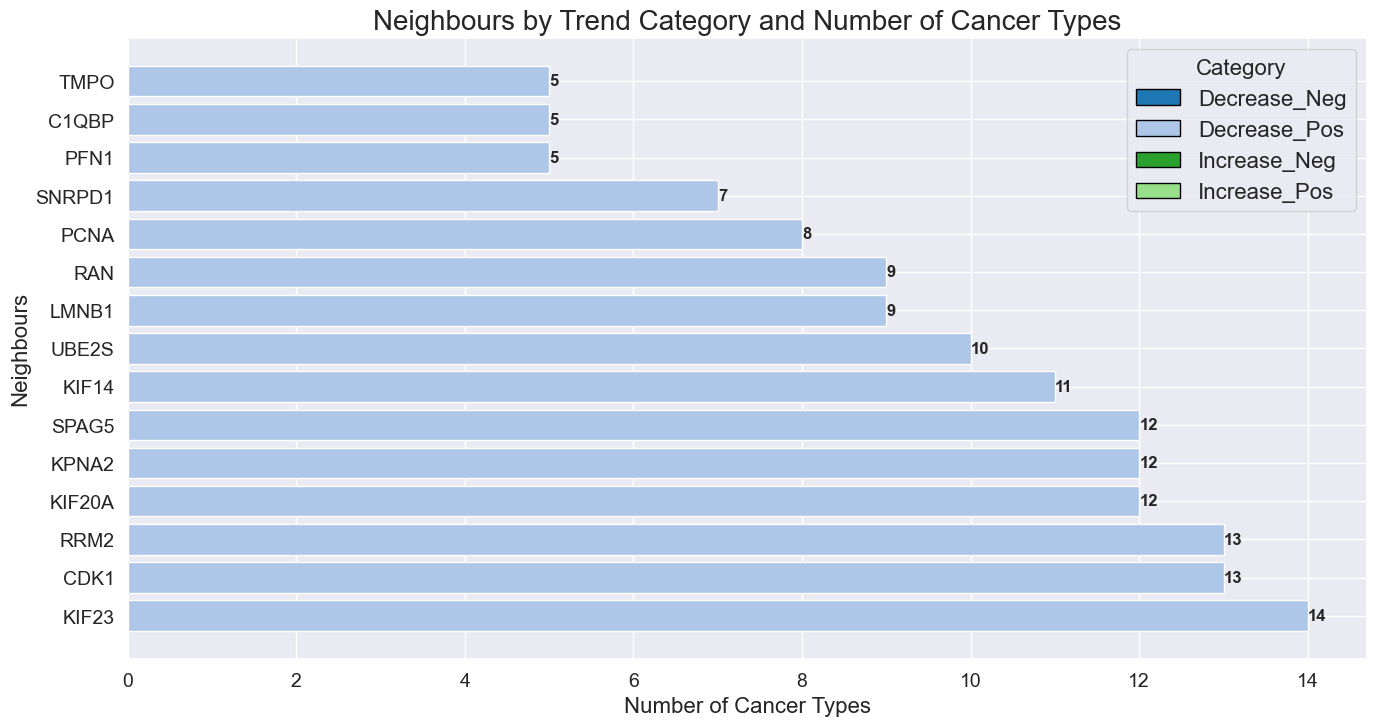


Decrease_Neg:

Decrease_Pos:
  KIF23: 14 cancer types
  CDK1: 13 cancer types
  RRM2: 13 cancer types
  KIF20A: 12 cancer types
  KPNA2: 12 cancer types
  SPAG5: 12 cancer types
  KIF14: 11 cancer types
  UBE2S: 10 cancer types
  LMNB1: 9 cancer types
  RAN: 9 cancer types
  PCNA: 8 cancer types
  SNRPD1: 7 cancer types
  PFN1: 5 cancer types
  C1QBP: 5 cancer types
  TMPO: 5 cancer types

Increase_Neg:

Increase_Pos:


In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def categorise_neighbour(trends, freq_column):
    if all(trend == 'decrease' for _, trend in trends):
        return 'Decrease_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    elif all(trend == 'increase' for _, trend in trends):
        return 'Increase_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    return 'Mixed'

graph_data_filt = []
for neighbour, data in neighbour_trends.items():
    category = categorise_neighbour(data['trends'], data['freq_column'])
    if category != 'Mixed':
        cancer_types = len(data['trends'])
        graph_data_filt.append({
            'Category': category,
            'Neighbour': neighbour,
            'Cancer Types': cancer_types
        })

df_graph_filt = pd.DataFrame(graph_data_filt)
df_graph_filt = df_graph_filt.sort_values(['Category', 'Cancer Types'], ascending=[True, False])

plt.figure(figsize=(14, len(df_graph_filt) * 0.5))  # Increase the figure size

# Define colours for each category
colours = {'Decrease_Neg': '#1f77b4', 'Decrease_Pos': '#aec7e8',
           'Increase_Neg': '#2ca02c', 'Increase_Pos': '#98df8a'}

# Plot the bars
bars = plt.barh(df_graph_filt['Neighbour'], df_graph_filt['Cancer Types'], 
                color=[colours[cat] for cat in df_graph_filt['Category']])

# Add labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             ha='left', va='center', fontweight='bold', fontsize=12)  # Increase the font size

# Customise the plot
plt.title('Neighbours by Trend Category and Number of Cancer Types', fontsize=20)  # Increase the font size
plt.xlabel('Number of Cancer Types', fontsize=16)  # Increase the font size
plt.ylabel('Neighbours', fontsize=16)  # Increase the font size
plt.xticks(fontsize=14)  # Increase the font size of x-axis ticks
plt.yticks(fontsize=14)  # Increase the font size of y-axis ticks

# Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colours[cat], edgecolor='black', label=cat) 
                   for cat in colours.keys()]
plt.legend(handles=legend_elements, title='Category', loc='upper right', 
           fontsize=16, title_fontsize=16)  # Increase the legend font size

plt.tight_layout()
plt.show()

# Print detailed information
for category in ['Decrease_Neg', 'Decrease_Pos', 'Increase_Neg', 'Increase_Pos']:
    print(f"\n{category}:")
    category_data = df_graph_filt[df_graph_filt['Category'] == category]
    for _, row in category_data.iterrows():
        print(f"  {row['Neighbour']}: {row['Cancer Types']} cancer types")

#### All DINTs

In [121]:
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

top_neighbours = top_50_neighbours['neighbour'].tolist()

def kaplan_meier_survival(data, event, groups):
    p_values = {}
    median_survival = {}
    group_data_low = data[data['Low_Expression']]
    group_data_high = data[data['High_Expression']]
    durations_low = group_data_low['OS.time']
    event_observed_low = group_data_low[event]
    durations_high = group_data_high['OS.time']
    event_observed_high = group_data_high[event]
    log_r_result = logrank_test(durations_low, durations_high, event_observed_low, event_observed_high, alpha=0.05)
    p_values['Low_vs_High'] = log_r_result.p_value
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    kmf_low.fit(durations_low, event_observed_low)
    kmf_high.fit(durations_high, event_observed_high)
    
    median_survival['Low_Expression'] = kmf_low.median_survival_time_
    median_survival['High_Expression'] = kmf_high.median_survival_time_
    return p_values, median_survival

significant_results = []
grouped_data = final_data.groupby('cancer_type')
expression_groups = ['Low_Expression', 'High_Expression']

for cancer_type, group_data in grouped_data:
    for neighbour in top_neighbours:
        neighbour_data = group_data[['patient', neighbour, 'OS.time', 'OS']].copy()
        neighbour_data['Low_Expression'] = neighbour_data[neighbour] <= neighbour_data[neighbour].median()
        neighbour_data['High_Expression'] = neighbour_data[neighbour] > neighbour_data[neighbour].median()
        
        p_values, median_survival = kaplan_meier_survival(neighbour_data, 'OS', expression_groups)
        
        for comparison, p_value in p_values.items():
            if p_value < 0.05:
                low_median = median_survival['Low_Expression']
                high_median = median_survival['High_Expression']
                trend = "increase" if high_median > low_median else "decrease"
                significant_results.append((cancer_type, neighbour, comparison, p_value, trend))

print("Significant Results:")
for result in significant_results:
    print("Cancer Type: {}, Neighbour: {}, Comparison: {}, p-value: {:.4f}, Trend: {}".format(*result))

neighbour_trends = {}
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = []
    neighbour_trends[neighbour].append((cancer_type, trend))

print("\nNeighbour Trends:")
for neighbour, trends in neighbour_trends.items():
    print(f"Neighbour: {neighbour}")
    for cancer_type, trend in trends:
        print(f"  Cancer Type: {cancer_type}, Trend: {trend}")


Significant Results:
Cancer Type: ACC, Neighbour: CDK1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF14, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF20A, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: AURKB, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF23, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: LMNB1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CDK2, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: CCNB1, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: KPNA2, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: PRC1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CHEK1, Compa

In [122]:
neighbour_to_freq_column = dict(zip(top_50_neighbours['neighbour'], top_50_neighbours['association_type']))

# Update significant_results to include Freq_Column
updated_significant_results = []
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    freq_column = neighbour_to_freq_column.get(neighbour, 'Unknown')
    updated_significant_results.append((cancer_type, neighbour, comparison, p_value, trend, freq_column))

# Update neighbour_trends to include Freq_Column
neighbour_trends = {}
for result in updated_significant_results:
    cancer_type, neighbour, comparison, p_value, trend, freq_column = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = {'trends': [], 'freq_column': freq_column}
    neighbour_trends[neighbour]['trends'].append((cancer_type, trend))

# Filter and print the results
print("Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:")
for neighbour, data in neighbour_trends.items():
    trends = data['trends']
    freq_column = data['freq_column']
    
    # Check if all trends are 'decrease' and if the freq_column contains 'Pos'
    if all(trend == 'decrease' for _, trend in trends) and 'Pos' in freq_column:
        print(f"\nNeighbour: {neighbour}")
        print(f"Freq_Column: {freq_column}")
        for cancer_type, trend in trends:
            result = next(r for r in updated_significant_results if r[0] == cancer_type and r[1] == neighbour)
            print(f"  Cancer Type: {cancer_type}, p-value: {result[3]:.5f}, Trend: {trend}")

# Statistics
total_neighbours = len(neighbour_trends)
consistent_decrease_pos = sum(1 for data in neighbour_trends.values() 
                              if all(trend == 'decrease' for _, trend in data['trends']) and 'Pos' in data['freq_column'])

print(f"\nStatistics:")
print(f"Total number of neighbours analysed: {total_neighbours}")
print(f"Neighbours with consistent 'decrease' and 'Pos' in the Freq_Column: {consistent_decrease_pos}")

Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:

Neighbour: CDK1
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: BRCA, p-value: 0.01392, Trend: decrease
  Cancer Type: KICH, p-value: 0.01743, Trend: decrease
  Cancer Type: KIRC, p-value: 0.00000, Trend: decrease
  Cancer Type: KIRP, p-value: 0.00008, Trend: decrease
  Cancer Type: LGG, p-value: 0.00000, Trend: decrease
  Cancer Type: LIHC, p-value: 0.00763, Trend: decrease
  Cancer Type: LUAD, p-value: 0.00001, Trend: decrease
  Cancer Type: MESO, p-value: 0.00000, Trend: decrease
  Cancer Type: PAAD, p-value: 0.00182, Trend: decrease
  Cancer Type: SARC, p-value: 0.03596, Trend: decrease
  Cancer Type: SKCM, p-value: 0.02948, Trend: decrease
  Cancer Type: THYM, p-value: 0.01021, Trend: decrease

Neighbour: KIF14
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: KICH, p-value: 0.01246, Trend: decrease
  Cancer Type: KIRC, p-va

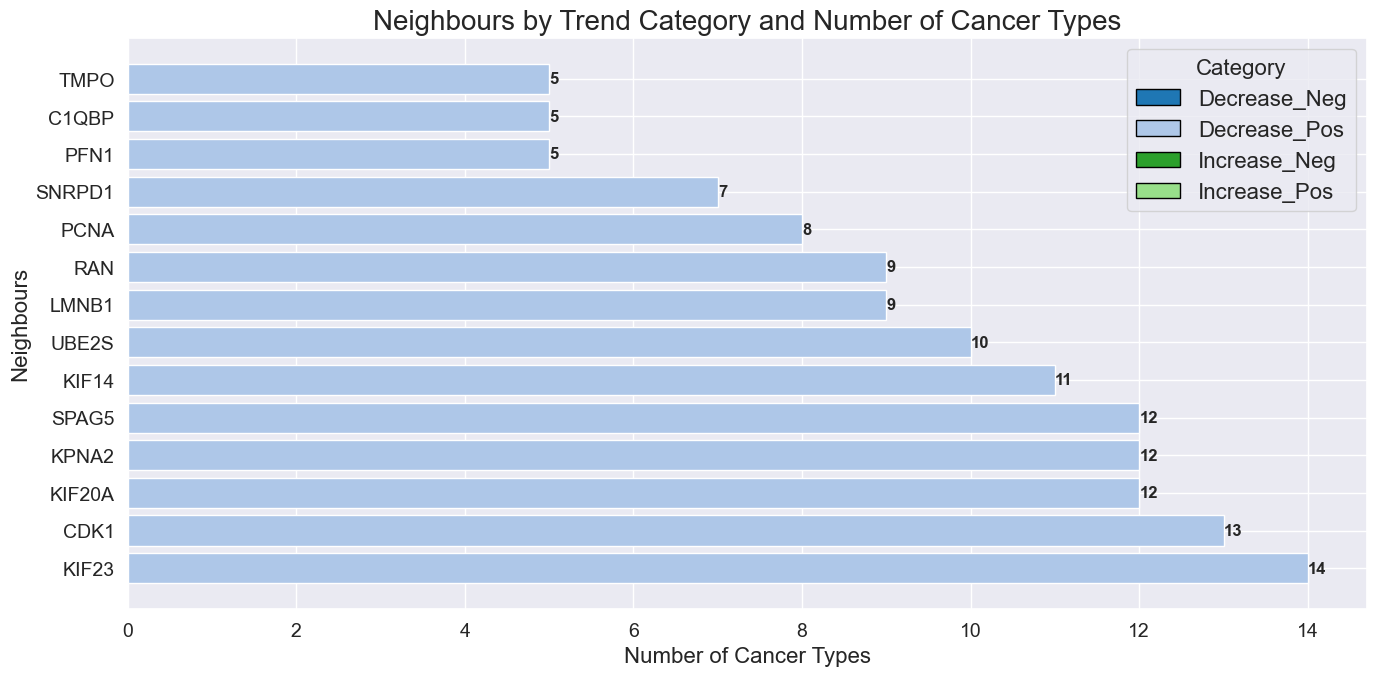


Decrease_Neg:

Decrease_Pos:
  KIF23: 14 cancer types
  CDK1: 13 cancer types
  KIF20A: 12 cancer types
  KPNA2: 12 cancer types
  SPAG5: 12 cancer types
  KIF14: 11 cancer types
  UBE2S: 10 cancer types
  LMNB1: 9 cancer types
  RAN: 9 cancer types
  PCNA: 8 cancer types
  SNRPD1: 7 cancer types
  PFN1: 5 cancer types
  C1QBP: 5 cancer types
  TMPO: 5 cancer types

Increase_Neg:

Increase_Pos:


In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def categorise_neighbour(trends, freq_column):
    if all(trend == 'decrease' for _, trend in trends):
        return 'Decrease_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    elif all(trend == 'increase' for _, trend in trends):
        return 'Increase_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    return 'Mixed'

graph_data = []
for neighbour, data in neighbour_trends.items():
    category = categorise_neighbour(data['trends'], data['freq_column'])
    if category != 'Mixed':
        cancer_types = len(data['trends'])
        graph_data.append({
            'Category': category,
            'Neighbour': neighbour,
            'Cancer Types': cancer_types
        })

df_graph = pd.DataFrame(graph_data)
df_graph = df_graph.sort_values(['Category', 'Cancer Types'], ascending=[True, False])

plt.figure(figsize=(14, len(df_graph) * 0.5))  # Increase the figure size

# Define colours for each category
colours = {'Decrease_Neg': '#1f77b4', 'Decrease_Pos': '#aec7e8',
           'Increase_Neg': '#2ca02c', 'Increase_Pos': '#98df8a'}

# Plot the bars
bars = plt.barh(df_graph['Neighbour'], df_graph['Cancer Types'], 
                color=[colours[cat] for cat in df_graph['Category']])

# Add labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             ha='left', va='center', fontweight='bold', fontsize=12)  # Increase the font size

# Customise the plot
plt.title('Neighbours by Trend Category and Number of Cancer Types', fontsize=20)  # Increase the font size
plt.xlabel('Number of Cancer Types', fontsize=16)  # Increase the font size
plt.ylabel('Neighbours', fontsize=16)  # Increase the font size
plt.xticks(fontsize=14)  # Increase the font size of x-axis ticks
plt.yticks(fontsize=14)  # Increase the font size of y-axis ticks

# Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colours[cat], edgecolor='black', label=cat) 
                   for cat in colours.keys()]
plt.legend(handles=legend_elements, title='Category', loc='upper right', 
           fontsize=16, title_fontsize=16)  # Increase the legend font size

plt.tight_layout()
plt.show()

# Print detailed information
for category in ['Decrease_Neg', 'Decrease_Pos', 'Increase_Neg', 'Increase_Pos']:
    print(f"\n{category}:")
    category_data = df_graph[df_graph['Category'] == category]
    for _, row in category_data.iterrows():
        print(f"  {row['Neighbour']}: {row['Cancer Types']} cancer types")

### Survival Analysis with most frequent types of cancer

#### Filtered

In [124]:
# Get the associated drivers for each neighbour
neighbour_drivers_filt = dints[dints['neighbour'].isin(top_50_neighbours_filt['neighbour'])]

# Get the association type for each neighbour-driver pair
neighbour_drivers_filt.loc[:, 'association_type'] = np.where(neighbour_drivers_filt['coef'] > 0, 'Positive', 'Negative')

# Get mutation frequency for each driver and cancer type
mutation_freq = mutationtab.groupby('cancer_type').sum()

# Find the most frequent cancer type for each driver
most_frequent_cancer = mutation_freq.idxmax()
max_frequency = mutation_freq.max()

# Create the final DataFrame
final_data = []

for _, row in top_50_neighbours_filt.iterrows():
    neighbour = row['neighbour']
    associated_drivers = neighbour_drivers_filt[neighbour_drivers_filt['neighbour'] == neighbour]
    
    for _, driver_row in associated_drivers.iterrows():
        driver = driver_row['driver']
        association_type = driver_row['association_type']
        most_freq_cancer = most_frequent_cancer[driver]
        frequency = max_frequency[driver]
        
        final_data.append({
            'neighbour': neighbour,
            'driver': driver,
            'association_type': association_type,
            'most_frequent_cancer_type': most_freq_cancer,
            'mutation_frequency': frequency
        })

final_df_filt = pd.DataFrame(final_data)

# Sort the DataFrame
final_df_filt = final_df_filt.sort_values(['neighbour', 'driver'])

# Display the results
print(final_df_filt)

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/1932167831.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbour_drivers_filt.loc[:, 'association_type'] = np.where(neighbour_drivers_filt['coef'] > 0, 'Positive', 'Negative')


     neighbour   driver association_type most_frequent_cancer_type  \
586      AURKB     AMOT         Positive                      UCEC   
587      AURKB  ANKRD17         Positive                      UCEC   
588      AURKB     ANLN         Positive                      UCEC   
589      AURKB    AP3D1         Positive                      UCEC   
590      AURKB     ASPM         Positive                      UCEC   
...        ...      ...              ...                       ...   
1254     XRCC6   THRAP3         Positive                      UCEC   
1255     XRCC6     TPX2         Positive                      UCEC   
1256     XRCC6      WRN         Positive                      UCEC   
1257     XRCC6     ZEB1         Positive                      UCEC   
1258     XRCC6    ZFHX3         Positive                      UCEC   

      mutation_frequency  
586                   41  
587                   53  
588                   32  
589                   19  
590                   70

In [125]:
neighbour_to_cancer_mapping_filt = final_df_filt.groupby('neighbour')['most_frequent_cancer_type'].apply(set).to_dict()

significant_results_with_cancer_filt = []
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    if neighbour in neighbour_to_cancer_mapping_filt:
        most_frequent_cancers_neighbour = neighbour_to_cancer_mapping_filt[neighbour]
        significant_results_with_cancer_filt.append((cancer_type, neighbour, comparison, p_value, trend, most_frequent_cancers_neighbour))
    else:
        significant_results_with_cancer_filt.append((cancer_type, neighbour, comparison, p_value, trend, set()))

significant_results_with_cancer_df_filt = pd.DataFrame(significant_results_with_cancer_filt, columns=['Cancer_Type', 'Neighbour', 'Comparison', 'p-value', 'Trend', 'Most_Frequent_Cancers_Neighbour'])
significant_results_with_cancer_df_filt

Cancer_Type Neighbour   Comparison       p-value     Trend  \
0           ACC      CDK1  Low_vs_High  1.733281e-08  decrease   
1           ACC     KIF14  Low_vs_High  3.936613e-07  decrease   
2           ACC    KIF20A  Low_vs_High  5.365761e-04  decrease   
3           ACC     AURKB  Low_vs_High  9.962963e-06  decrease   
4           ACC     KIF23  Low_vs_High  1.208926e-06  decrease   
..          ...       ...          ...           ...       ...   
479         UVM     UBE2I  Low_vs_High  2.693608e-02  increase   
480         UVM     GTSE1  Low_vs_High  4.937991e-02  decrease   
481         UVM     CEP55  Low_vs_High  2.947506e-02  decrease   
482         UVM     FANCI  Low_vs_High  1.643481e-02  decrease   
483         UVM      SNCA  Low_vs_High  1.200235e-03  increase   

          Most_Frequent_Cancers_Neighbour  
0    {UCEC, HNSC, LUAD, BLCA, COAD, LUSC}  
1    {UCEC, STAD, HNSC, LUAD, COAD, LUSC}  
2                {LUSC, LUAD, UCEC, COAD}  
3          {UCEC, STAD, LUAD, BLCA, LUSC}  
4                {LUSC, LUAD, UCEC, COAD}  
..                                    ...  
479                    {STAD, BLCA, UCEC}  
480                          {CESC, UCEC}  
481                          {CESC, UCEC}  
482                          {STAD, UCEC}  
483                    {LUAD, BRCA, UCEC}  

[484 rows x 6 columns]

In [126]:
idx_most_frequent_cancer = final_df_filt.groupby('neighbour')['mutation_frequency'].idxmax()
neighbour_to_most_frequent_cancer = final_df_filt.loc[idx_most_frequent_cancer]
neighbour_to_cancer_mapping = neighbour_to_most_frequent_cancer.set_index('neighbour')['most_frequent_cancer_type'].to_dict()

significant_results_with_cancer_df_filt = pd.DataFrame(significant_results, columns=['Cancer_Type', 'Neighbour', 'Comparison', 'p-value', 'Trend'])
significant_results_with_cancer_df_filt['Most_Frequent_Cancer_Neighbour'] = significant_results_with_cancer_df_filt['Neighbour'].map(neighbour_to_cancer_mapping)

matching_rows_filt = significant_results_with_cancer_df_filt.query("Cancer_Type == Most_Frequent_Cancer_Neighbour")
if not matching_rows_filt.empty:
    display(matching_rows_filt)

Cancer_Type Neighbour   Comparison   p-value     Trend  \
71         COAD     CCNB1  Low_vs_High  0.010461  increase   
76         COAD    MAD2L1  Low_vs_High  0.047194  increase   
207         LGG     LMNB1  Low_vs_High  0.001443  decrease   
215         LGG    TRIM25  Low_vs_High  0.026144  decrease   
271        LUAD    KIF20A  Low_vs_High  0.000454  decrease   
280        LUAD     CENPA  Low_vs_High  0.005265  decrease   
298        LUAD     TUBG1  Low_vs_High  0.015179  decrease   
458        UCEC      CCNF  Low_vs_High  0.036333  increase   
459        UCEC     STIP1  Low_vs_High  0.026308  increase   
460        UCEC     AURKB  Low_vs_High  0.039138  decrease   
464        UCEC      MCM2  Low_vs_High  0.016707  increase   
467        UCEC     SPAG5  Low_vs_High  0.026234  decrease   

    Most_Frequent_Cancer_Neighbour  
71                            COAD  
76                            COAD  
207                            LGG  
215                            LGG  
271                           LUAD  
280                           LUAD  
298                           LUAD  
458                           UCEC  
459                           UCEC  
460                           UCEC  
464                           UCEC  
467                           UCEC

In [127]:
neighbour_to_max_driver_filt = {}

for neighbour in final_df_filt['neighbour'].unique():
    neighbour_data = final_df_filt[final_df_filt['neighbour'] == neighbour]
    most_frequent_cancer = neighbour_to_cancer_mapping[neighbour]
    
    cancer_data = neighbour_data[neighbour_data['most_frequent_cancer_type'] == most_frequent_cancer]
    
    if not cancer_data.empty:
        max_driver_row = cancer_data.loc[cancer_data['mutation_frequency'].idxmax()]
        
        neighbour_to_max_driver_filt[neighbour] = {
            'driver': max_driver_row['driver'],
            'association_type': max_driver_row['association_type'],
            'mutation_frequency': max_driver_row['mutation_frequency']
        }

def get_driver_info(row):
    neighbour = row['Neighbour']
    if neighbour in neighbour_to_max_driver_filt:
        return pd.Series(neighbour_to_max_driver_filt[neighbour])
    else:
        return pd.Series({'driver': None, 'association_type': None, 'mutation_frequency': None})

significant_results_with_cancer_df_filt[['driver', 'association_type', 'mutation_frequency']] = significant_results_with_cancer_df_filt.apply(get_driver_info, axis=1)

print(significant_results_with_cancer_df_filt)

matching_rows_filt = significant_results_with_cancer_df_filt[significant_results_with_cancer_df_filt['Cancer_Type'] == significant_results_with_cancer_df_filt['Most_Frequent_Cancer_Neighbour']]
print("\nRows where Cancer_Type is equal to Most_Frequent_Cancer_Neighbour:")
print(matching_rows_filt)

    Cancer_Type Neighbour   Comparison       p-value     Trend  \
0           ACC      CDK1  Low_vs_High  1.733281e-08  decrease   
1           ACC     KIF14  Low_vs_High  3.936613e-07  decrease   
2           ACC    KIF20A  Low_vs_High  5.365761e-04  decrease   
3           ACC     AURKB  Low_vs_High  9.962963e-06  decrease   
4           ACC     KIF23  Low_vs_High  1.208926e-06  decrease   
..          ...       ...          ...           ...       ...   
479         UVM     UBE2I  Low_vs_High  2.693608e-02  increase   
480         UVM     GTSE1  Low_vs_High  4.937991e-02  decrease   
481         UVM     CEP55  Low_vs_High  2.947506e-02  decrease   
482         UVM     FANCI  Low_vs_High  1.643481e-02  decrease   
483         UVM      SNCA  Low_vs_High  1.200235e-03  increase   

    Most_Frequent_Cancer_Neighbour driver association_type  mutation_frequency  
0                             UCEC  KMT2D         Positive               124.0  
1                             COAD    APC    

In [128]:
top_10_drivers_filt = matching_rows_filt.nlargest(10, 'mutation_frequency')

print("\nTop 10 drivers with the highest mutation_frequency:")
print(top_10_drivers_filt[['driver', 'association_type', 'mutation_frequency']])


Top 10 drivers with the highest mutation_frequency:
     driver association_type  mutation_frequency
71      APC         Positive               212.0
76      APC         Positive               212.0
207    ATRX         Positive               192.0
298     FLG         Positive               130.0
215     CIC         Positive               110.0
280  ZNF536         Positive               105.0
271   MUC17         Positive               102.0
458    CHD4         Positive               100.0
459    CHD4         Positive               100.0
464    CHD4         Positive               100.0


In [129]:
pos_decrease_filt = matching_rows_filt[(matching_rows_filt['association_type'] == 'Positive') & 
                             (matching_rows_filt['Trend'] == 'decrease')]

neg_increase_filt  = matching_rows_filt[(matching_rows_filt['association_type'] == 'Negative') & 
                             (matching_rows_filt['Trend'] == 'increase')]

neg_decrease_filt  = matching_rows_filt[(matching_rows_filt['association_type'] == 'Negative') & 
                             (matching_rows_filt['Trend'] == 'decrease')]

pos_increase_filt = matching_rows_filt[(matching_rows_filt['association_type'] == 'Positive') &
                                (matching_rows_filt['Trend'] == 'increase')]
print("Rows with 'Positive' Association_Type and 'decrease' trend:")
display(pos_decrease_filt)

print("\nRows with 'Negative' Association_Type and 'increase' trend:")
display(neg_increase_filt)

print(f"\nNumber of rows with 'Positive' Association_Type and 'decrease' trend: {len(pos_decrease_filt)}")
print(f"Number of rows with 'Negative' Association_Type and 'increase' trend: {len(neg_increase_filt)}")

print(f"\nNumber of rows with 'Negative' Association_Type and 'decrease' trend: {len(neg_decrease_filt)}")
print(f"Number of rows with 'Positive' Association_Type and 'increase' trend: {len(pos_increase_filt)}")
pos_increase_filt


Rows with 'Positive' Association_Type and 'decrease' trend:


Cancer_Type Neighbour   Comparison   p-value     Trend  \
207         LGG     LMNB1  Low_vs_High  0.001443  decrease   
215         LGG    TRIM25  Low_vs_High  0.026144  decrease   
271        LUAD    KIF20A  Low_vs_High  0.000454  decrease   
280        LUAD     CENPA  Low_vs_High  0.005265  decrease   
298        LUAD     TUBG1  Low_vs_High  0.015179  decrease   
460        UCEC     AURKB  Low_vs_High  0.039138  decrease   
467        UCEC     SPAG5  Low_vs_High  0.026234  decrease   

    Most_Frequent_Cancer_Neighbour  driver association_type  \
207                            LGG    ATRX         Positive   
215                            LGG     CIC         Positive   
271                           LUAD   MUC17         Positive   
280                           LUAD  ZNF536         Positive   
298                           LUAD     FLG         Positive   
460                           UCEC    TAF1         Positive   
467                           UCEC   PRKDC         Positive   

     mutation_frequency  
207               192.0  
215               110.0  
271               102.0  
280               105.0  
298               130.0  
460                88.0  
467                74.0


Rows with 'Negative' Association_Type and 'increase' trend:


Empty DataFrame
Columns: [Cancer_Type, Neighbour, Comparison, p-value, Trend, Most_Frequent_Cancer_Neighbour, driver, association_type, mutation_frequency]
Index: []


Number of rows with 'Positive' Association_Type and 'decrease' trend: 7
Number of rows with 'Negative' Association_Type and 'increase' trend: 0

Number of rows with 'Negative' Association_Type and 'decrease' trend: 0
Number of rows with 'Positive' Association_Type and 'increase' trend: 5


Cancer_Type Neighbour   Comparison   p-value     Trend  \
71         COAD     CCNB1  Low_vs_High  0.010461  increase   
76         COAD    MAD2L1  Low_vs_High  0.047194  increase   
458        UCEC      CCNF  Low_vs_High  0.036333  increase   
459        UCEC     STIP1  Low_vs_High  0.026308  increase   
464        UCEC      MCM2  Low_vs_High  0.016707  increase   

    Most_Frequent_Cancer_Neighbour driver association_type  mutation_frequency  
71                            COAD    APC         Positive               212.0  
76                            COAD    APC         Positive               212.0  
458                           UCEC   CHD4         Positive               100.0  
459                           UCEC   CHD4         Positive               100.0  
464                           UCEC   CHD4         Positive               100.0

In [130]:
total_matching = len(matching_rows_filt)
percent_pos_decrease_filt = (len(pos_decrease_filt) / total_matching) * 100
percent_neg_increase_filt = (len(neg_increase_filt) / total_matching) * 100

print(f"Percentage of 'Positive' and 'decrease' cases: {percent_pos_decrease_filt:.2f}%")
print(f"Percentage of 'Negative' and 'increase' cases: {percent_neg_increase_filt:.2f}%")

print("\nMost common drivers in 'Positive' and 'decrease' cases:")
print(pos_decrease_filt['driver'].value_counts().head())

print("\nMost common drivers in 'Negative' and 'increase' cases:")
print(neg_increase_filt['driver'].value_counts().head())

print("\nAverage p-value for 'Positive' and 'decrease' cases:", pos_decrease_filt['p-value'].mean())
print("Average p-value for 'Negative' and 'increase' cases:", neg_increase_filt['p-value'].mean())

Percentage of 'Positive' and 'decrease' cases: 58.33%
Percentage of 'Negative' and 'increase' cases: 0.00%

Most common drivers in 'Positive' and 'decrease' cases:
driver
ATRX      1
CIC       1
MUC17     1
ZNF536    1
FLG       1
Name: count, dtype: int64

Most common drivers in 'Negative' and 'increase' cases:
Series([], Name: count, dtype: int64)

Average p-value for 'Positive' and 'decrease' cases: 0.016265300481986954
Average p-value for 'Negative' and 'increase' cases: nan


#### All DINTs

In [131]:
# Get the associated drivers for each neighbour
neighbour_drivers = dints[dints['neighbour'].isin(top_50_neighbours['neighbour'])]

# Get the association type for each neighbour-driver pair
neighbour_drivers.loc[:, 'association_type'] = np.where(neighbour_drivers['coef'] > 0, 'Positive', 'Negative')

# Get mutation frequency for each driver and cancer type
mutation_freq = mutationtab.groupby('cancer_type').sum()

# Find the most frequent cancer type for each driver
most_frequent_cancer = mutation_freq.idxmax()
max_frequency = mutation_freq.max()

# Create the final DataFrame
final_data = []

for _, row in top_50_neighbours.iterrows():
    neighbour = row['neighbour']
    associated_drivers = neighbour_drivers[neighbour_drivers['neighbour'] == neighbour]
    
    for _, driver_row in associated_drivers.iterrows():
        driver = driver_row['driver']
        association_type = driver_row['association_type']
        most_freq_cancer = most_frequent_cancer[driver]
        frequency = max_frequency[driver]
        
        final_data.append({
            'neighbour': neighbour,
            'driver': driver,
            'association_type': association_type,
            'most_frequent_cancer_type': most_freq_cancer,
            'mutation_frequency': frequency
        })

final_df = pd.DataFrame(final_data)

# Sort the DataFrame
final_df = final_df.sort_values(['neighbour', 'driver'])

# Display the results
print(final_df)

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/3228933039.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbour_drivers.loc[:, 'association_type'] = np.where(neighbour_drivers['coef'] > 0, 'Positive', 'Negative')


     neighbour   driver association_type most_frequent_cancer_type  \
586      AURKB     AMOT         Positive                      UCEC   
587      AURKB  ANKRD17         Positive                      UCEC   
588      AURKB     ANLN         Positive                      UCEC   
589      AURKB    AP3D1         Positive                      UCEC   
590      AURKB     ASPM         Positive                      UCEC   
...        ...      ...              ...                       ...   
1254     XRCC6   THRAP3         Positive                      UCEC   
1255     XRCC6     TPX2         Positive                      UCEC   
1256     XRCC6      WRN         Positive                      UCEC   
1257     XRCC6     ZEB1         Positive                      UCEC   
1258     XRCC6    ZFHX3         Positive                      UCEC   

      mutation_frequency  
586                   41  
587                   53  
588                   32  
589                   19  
590                   70

In [132]:
neighbour_to_cancer_mapping = final_df.groupby('neighbour')['most_frequent_cancer_type'].apply(set).to_dict()

significant_results_with_cancer = []
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    if neighbour in neighbour_to_cancer_mapping:
        most_frequent_cancers_neighbour = neighbour_to_cancer_mapping[neighbour]
        significant_results_with_cancer.append((cancer_type, neighbour, comparison, p_value, trend, most_frequent_cancers_neighbour))
    else:
        significant_results_with_cancer.append((cancer_type, neighbour, comparison, p_value, trend, set()))

significant_results_with_cancer_df = pd.DataFrame(significant_results_with_cancer, columns=['Cancer_Type', 'Neighbour', 'Comparison', 'p-value', 'Trend', 'Most_Frequent_Cancers_Neighbour'])
significant_results_with_cancer_df

Cancer_Type Neighbour   Comparison       p-value     Trend  \
0           ACC      CDK1  Low_vs_High  1.733281e-08  decrease   
1           ACC     KIF14  Low_vs_High  3.936613e-07  decrease   
2           ACC    KIF20A  Low_vs_High  5.365761e-04  decrease   
3           ACC     AURKB  Low_vs_High  9.962963e-06  decrease   
4           ACC     KIF23  Low_vs_High  1.208926e-06  decrease   
..          ...       ...          ...           ...       ...   
479         UVM     UBE2I  Low_vs_High  2.693608e-02  increase   
480         UVM     GTSE1  Low_vs_High  4.937991e-02  decrease   
481         UVM     CEP55  Low_vs_High  2.947506e-02  decrease   
482         UVM     FANCI  Low_vs_High  1.643481e-02  decrease   
483         UVM      SNCA  Low_vs_High  1.200235e-03  increase   

          Most_Frequent_Cancers_Neighbour  
0    {UCEC, HNSC, LUAD, BLCA, COAD, LUSC}  
1    {UCEC, STAD, HNSC, LUAD, COAD, LUSC}  
2                {LUSC, LUAD, UCEC, COAD}  
3          {UCEC, STAD, LUAD, BLCA, LUSC}  
4                {LUSC, LUAD, UCEC, COAD}  
..                                    ...  
479                    {STAD, BLCA, UCEC}  
480                          {CESC, UCEC}  
481                          {CESC, UCEC}  
482                          {STAD, UCEC}  
483                    {LUAD, BRCA, UCEC}  

[484 rows x 6 columns]

In [133]:
idx_most_frequent_cancer = final_df.groupby('neighbour')['mutation_frequency'].idxmax()
neighbour_to_most_frequent_cancer = final_df.loc[idx_most_frequent_cancer]
neighbour_to_cancer_mapping = neighbour_to_most_frequent_cancer.set_index('neighbour')['most_frequent_cancer_type'].to_dict()

significant_results_with_cancer_df = pd.DataFrame(significant_results, columns=['Cancer_Type', 'Neighbour', 'Comparison', 'p-value', 'Trend'])
significant_results_with_cancer_df['Most_Frequent_Cancer_Neighbour'] = significant_results_with_cancer_df['Neighbour'].map(neighbour_to_cancer_mapping)

matching_rows = significant_results_with_cancer_df.query("Cancer_Type == Most_Frequent_Cancer_Neighbour")
if not matching_rows.empty:
    display(matching_rows)

Cancer_Type Neighbour   Comparison   p-value     Trend  \
71         COAD     CCNB1  Low_vs_High  0.010461  increase   
76         COAD    MAD2L1  Low_vs_High  0.047194  increase   
207         LGG     LMNB1  Low_vs_High  0.001443  decrease   
215         LGG    TRIM25  Low_vs_High  0.026144  decrease   
271        LUAD    KIF20A  Low_vs_High  0.000454  decrease   
280        LUAD     CENPA  Low_vs_High  0.005265  decrease   
298        LUAD     TUBG1  Low_vs_High  0.015179  decrease   
458        UCEC      CCNF  Low_vs_High  0.036333  increase   
459        UCEC     STIP1  Low_vs_High  0.026308  increase   
460        UCEC     AURKB  Low_vs_High  0.039138  decrease   
464        UCEC      MCM2  Low_vs_High  0.016707  increase   
467        UCEC     SPAG5  Low_vs_High  0.026234  decrease   

    Most_Frequent_Cancer_Neighbour  
71                            COAD  
76                            COAD  
207                            LGG  
215                            LGG  
271                           LUAD  
280                           LUAD  
298                           LUAD  
458                           UCEC  
459                           UCEC  
460                           UCEC  
464                           UCEC  
467                           UCEC

In [134]:
neighbour_to_max_driver = {}

for neighbour in final_df['neighbour'].unique():
    neighbour_data = final_df[final_df['neighbour'] == neighbour]
    most_frequent_cancer = neighbour_to_cancer_mapping[neighbour]
    
    cancer_data = neighbour_data[neighbour_data['most_frequent_cancer_type'] == most_frequent_cancer]
    
    if not cancer_data.empty:
        max_driver_row = cancer_data.loc[cancer_data['mutation_frequency'].idxmax()]
        
        neighbour_to_max_driver[neighbour] = {
            'driver': max_driver_row['driver'],
            'association_type': max_driver_row['association_type'],
            'mutation_frequency': max_driver_row['mutation_frequency']
        }

def get_driver_info(row):
    neighbour = row['Neighbour']
    if neighbour in neighbour_to_max_driver:
        return pd.Series(neighbour_to_max_driver[neighbour])
    else:
        return pd.Series({'driver': None, 'association_type': None, 'mutation_frequency': None})

significant_results_with_cancer_df[['driver', 'association_type', 'mutation_frequency']] = significant_results_with_cancer_df.apply(get_driver_info, axis=1)

print(significant_results_with_cancer_df)

matching_rows = significant_results_with_cancer_df[significant_results_with_cancer_df['Cancer_Type'] == significant_results_with_cancer_df['Most_Frequent_Cancer_Neighbour']]
print("\nRows where Cancer_Type is equal to Most_Frequent_Cancer_Neighbour:")
print(matching_rows)

    Cancer_Type Neighbour   Comparison       p-value     Trend  \
0           ACC      CDK1  Low_vs_High  1.733281e-08  decrease   
1           ACC     KIF14  Low_vs_High  3.936613e-07  decrease   
2           ACC    KIF20A  Low_vs_High  5.365761e-04  decrease   
3           ACC     AURKB  Low_vs_High  9.962963e-06  decrease   
4           ACC     KIF23  Low_vs_High  1.208926e-06  decrease   
..          ...       ...          ...           ...       ...   
479         UVM     UBE2I  Low_vs_High  2.693608e-02  increase   
480         UVM     GTSE1  Low_vs_High  4.937991e-02  decrease   
481         UVM     CEP55  Low_vs_High  2.947506e-02  decrease   
482         UVM     FANCI  Low_vs_High  1.643481e-02  decrease   
483         UVM      SNCA  Low_vs_High  1.200235e-03  increase   

    Most_Frequent_Cancer_Neighbour driver association_type  mutation_frequency  
0                             UCEC  KMT2D         Positive                 124  
1                             COAD    APC    

In [135]:
top_10_drivers = matching_rows.nlargest(10, 'mutation_frequency')

print("\nTop 10 drivers with the highest mutation_frequency:")
print(top_10_drivers[['driver', 'association_type', 'mutation_frequency']])


Top 10 drivers with the highest mutation_frequency:
     driver association_type  mutation_frequency
71      APC         Positive                 212
76      APC         Positive                 212
207    ATRX         Positive                 192
298     FLG         Positive                 130
215     CIC         Positive                 110
280  ZNF536         Positive                 105
271   MUC17         Positive                 102
458    CHD4         Positive                 100
459    CHD4         Positive                 100
464    CHD4         Positive                 100


In [136]:
pos_decrease = matching_rows[(matching_rows['association_type'] == 'Positive') & 
                             (matching_rows['Trend'] == 'decrease')]

neg_increase = matching_rows[(matching_rows['association_type'] == 'Negative') & 
                             (matching_rows['Trend'] == 'increase')]

neg_decrease = matching_rows[(matching_rows['association_type'] == 'Negative') & 
                             (matching_rows['Trend'] == 'decrease')]

pos_increase = matching_rows[(matching_rows['association_type'] == 'Positive') &
                                (matching_rows['Trend'] == 'increase')]
print("Rows with 'Positive' Association_Type and 'decrease' trend:")
display(pos_decrease)

print("\nRows with 'Negative' Association_Type and 'increase' trend:")
display(neg_increase)

print(f"\nNumber of rows with 'Positive' Association_Type and 'decrease' trend: {len(pos_decrease)}")
print(f"Number of rows with 'Negative' Association_Type and 'increase' trend: {len(neg_increase)}")

print(f"\nNumber of rows with 'Negative' Association_Type and 'decrease' trend: {len(neg_decrease)}")
print(f"Number of rows with 'Positive' Association_Type and 'increase' trend: {len(pos_increase)}")
pos_increase


Rows with 'Positive' Association_Type and 'decrease' trend:


Cancer_Type Neighbour   Comparison   p-value     Trend  \
207         LGG     LMNB1  Low_vs_High  0.001443  decrease   
215         LGG    TRIM25  Low_vs_High  0.026144  decrease   
271        LUAD    KIF20A  Low_vs_High  0.000454  decrease   
280        LUAD     CENPA  Low_vs_High  0.005265  decrease   
298        LUAD     TUBG1  Low_vs_High  0.015179  decrease   
460        UCEC     AURKB  Low_vs_High  0.039138  decrease   
467        UCEC     SPAG5  Low_vs_High  0.026234  decrease   

    Most_Frequent_Cancer_Neighbour  driver association_type  \
207                            LGG    ATRX         Positive   
215                            LGG     CIC         Positive   
271                           LUAD   MUC17         Positive   
280                           LUAD  ZNF536         Positive   
298                           LUAD     FLG         Positive   
460                           UCEC    TAF1         Positive   
467                           UCEC   PRKDC         Positive   

     mutation_frequency  
207                 192  
215                 110  
271                 102  
280                 105  
298                 130  
460                  88  
467                  74


Rows with 'Negative' Association_Type and 'increase' trend:


Empty DataFrame
Columns: [Cancer_Type, Neighbour, Comparison, p-value, Trend, Most_Frequent_Cancer_Neighbour, driver, association_type, mutation_frequency]
Index: []


Number of rows with 'Positive' Association_Type and 'decrease' trend: 7
Number of rows with 'Negative' Association_Type and 'increase' trend: 0

Number of rows with 'Negative' Association_Type and 'decrease' trend: 0
Number of rows with 'Positive' Association_Type and 'increase' trend: 5


Cancer_Type Neighbour   Comparison   p-value     Trend  \
71         COAD     CCNB1  Low_vs_High  0.010461  increase   
76         COAD    MAD2L1  Low_vs_High  0.047194  increase   
458        UCEC      CCNF  Low_vs_High  0.036333  increase   
459        UCEC     STIP1  Low_vs_High  0.026308  increase   
464        UCEC      MCM2  Low_vs_High  0.016707  increase   

    Most_Frequent_Cancer_Neighbour driver association_type  mutation_frequency  
71                            COAD    APC         Positive                 212  
76                            COAD    APC         Positive                 212  
458                           UCEC   CHD4         Positive                 100  
459                           UCEC   CHD4         Positive                 100  
464                           UCEC   CHD4         Positive                 100

In [137]:
total_matching = len(matching_rows)
percent_pos_decrease = (len(pos_decrease) / total_matching) * 100
percent_neg_increase = (len(neg_increase) / total_matching) * 100

print(f"Percentage of 'Positive' and 'decrease' cases: {percent_pos_decrease:.2f}%")
print(f"Percentage of 'Negative' and 'increase' cases: {percent_neg_increase:.2f}%")

print("\nMost common drivers in 'Positive' and 'decrease' cases:")
print(pos_decrease['driver'].value_counts().head())

print("\nMost common drivers in 'Negative' and 'increase' cases:")
print(neg_increase['driver'].value_counts().head())

print("\nAverage p-value for 'Positive' and 'decrease' cases:", pos_decrease['p-value'].mean())
print("Average p-value for 'Negative' and 'increase' cases:", neg_increase['p-value'].mean())

Percentage of 'Positive' and 'decrease' cases: 58.33%
Percentage of 'Negative' and 'increase' cases: 0.00%

Most common drivers in 'Positive' and 'decrease' cases:
driver
ATRX      1
CIC       1
MUC17     1
ZNF536    1
FLG       1
Name: count, dtype: int64

Most common drivers in 'Negative' and 'increase' cases:
Series([], Name: count, dtype: int64)

Average p-value for 'Positive' and 'decrease' cases: 0.016265300481986954
Average p-value for 'Negative' and 'increase' cases: nan


In [337]:
percent_pos_increase = (len(pos_increase) / total_matching) * 100
print(f"Percentage of 'Positive' and 'increase' cases: {percent_pos_increase:.2f}%")

Percentage of 'Positive' and 'increase' cases: 41.67%


## Analyzing Drivers

In [345]:
driver_tumour_expression = pd.read_feather(datadir+"driver_tumour_expression.feather")

#### Filtered

In [346]:
# Step 1: Identify top and bottom 10 drivers by mutation frequency
driver_mutation_freq_filt = final_df_filt.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_10_drivers_filt = driver_mutation_freq_filt.head(10).index.tolist()
bottom_10_drivers_filt = driver_mutation_freq_filt.tail(10).index.tolist()

# Step 2: Find neighbors for these drivers
def get_neighbors(drivers, neighbourtab):
    neighbors = set()
    for driver in drivers:
        neighbors.update(neighbourtab.index[neighbourtab[driver]])
    return list(neighbors)

top_neighbors_filt = get_neighbors(top_10_drivers_filt, neighbourtab)
bottom_neighbors_filt = get_neighbors(bottom_10_drivers_filt, neighbourtab)

# Step 3: Extract expression data
top_expression_filt = tumourexp.loc[:, top_neighbors_filt]
bottom_expression_filt = tumourexp.loc[:, bottom_neighbors_filt]

""" # Step 4: Analyze and visualize
def plot_expression_heatmap(expression_data, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(expression_data.groupby('cancer_type').mean(), cmap='YlOrRd')
    plt.title(title)
    plt.show() """
""" 
plot_expression_heatmap(top_expression, "Expression of Neighbors for Top 10 Mutated Drivers")
plot_expression_heatmap(bottom_expression, "Expression of Neighbors for Bottom 10 Mutated Drivers") """

# Compare mean expression
top_mean_filt = top_expression_filt.mean()
bottom_mean_filt = bottom_expression_filt.mean()

print("Mean expression for neighbors of highly mutated drivers:")
print(top_mean_filt.sort_values(ascending=False).head())
print("\nMean expression for neighbors of lowly mutated drivers:")
print(bottom_mean_filt.sort_values(ascending=False).head())

# Statistical test
def compare_expressions(expr1, expr2):
    common_neighbors = set(expr1.columns) & set(expr2.columns) - {'cancer_type'}
    comp_results = []
    for neighbor in common_neighbors:
        u_stat, u_p_value = stats.mannwhitneyu(expr1[neighbor], expr2[neighbor], alternative='two-sided')
        comp_results.append({
            'Neighbor': neighbor,
            'U-statistic': u_stat,
            'p-value': u_p_value
        })
    return pd.DataFrame(comp_results).sort_values('p-value')

comparison_results_filt = compare_expressions(top_expression_filt, bottom_expression_filt)
print("\nTop differentially expressed neighbors:")
print(comparison_results_filt.head(10))

# Visualize top differential neighbors
""" def plot_top_differential(expr1, expr2, comparison_results, n=5):
    top_diff = comparison_results.head(n)['Neighbor']
    plt.figure(figsize=(15, 5*n))
    for i, neighbor in enumerate(top_diff, 1):
        plt.subplot(n, 1, i)
        sns.violinplot(x='cancer_type', y=neighbor, data=pd.concat([expr1, expr2]))
        plt.title(f"Expression of {neighbor}")
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_top_differential(top_expression, bottom_expression, comparison_results) """


Mean expression for neighbors of highly mutated drivers:
ACTB      16.533941
EEF1A1    16.198110
ACTG1     16.049729
GAPDH     15.945763
TPT1      15.629548
dtype: float64

Mean expression for neighbors of lowly mutated drivers:
ACTB      16.533941
UBC       15.030259
ENO1      14.675502
PABPC1    14.594079
CTSB      14.517812
dtype: float64

Top differentially expressed neighbors:
     Neighbor  U-statistic  p-value
0       ATG9A   35313608.0      1.0
505  MARCKSL1   35313608.0      1.0
506     GNG10   35313608.0      1.0
507     BCAR1   35313608.0      1.0
508    SNAP47   35313608.0      1.0
509     CHMP7   35313608.0      1.0
510   HNRNPA1   35313608.0      1.0
511      CUL3   35313608.0      1.0
512     CAPZB   35313608.0      1.0
513      KRT8   35313608.0      1.0


' def plot_top_differential(expr1, expr2, comparison_results, n=5):\n    top_diff = comparison_results.head(n)[\'Neighbor\']\n    plt.figure(figsize=(15, 5*n))\n    for i, neighbor in enumerate(top_diff, 1):\n        plt.subplot(n, 1, i)\n        sns.violinplot(x=\'cancer_type\', y=neighbor, data=pd.concat([expr1, expr2]))\n        plt.title(f"Expression of {neighbor}")\n        plt.xticks(rotation=90)\n    plt.tight_layout()\n    plt.show()\n\nplot_top_differential(top_expression, bottom_expression, comparison_results) '

In [347]:
# Step 1: Identificar os 10 drivers com maior e menor frequência de mutação
driver_mutation_freq_filt = final_df_filt.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_10_drivers_filt = driver_mutation_freq_filt.head(10).index.tolist()
bottom_10_drivers_filt = driver_mutation_freq_filt.tail(10).index.tolist()

# Step 2: Ver o número de vizinhos diretamente da coluna 'n_neighbours' em filt_drivers
top_10_drivers_vizinhos = filt_drivers[filt_drivers['driver'].isin(top_10_drivers_filt)][['driver', 'n_neighbours']]
bottom_10_drivers_vizinhos = filt_drivers[filt_drivers['driver'].isin(bottom_10_drivers_filt)][['driver', 'n_neighbours']]

print("Top 10 drivers com maior frequência de mutação e seus vizinhos:")
print(top_10_drivers_vizinhos)

print("\nBottom 10 drivers com menor frequência de mutação e seus vizinhos:")
print(bottom_10_drivers_vizinhos)


Top 10 drivers com maior frequência de mutação e seus vizinhos:
       driver  n_neighbours
131       APC           378
155    ARID1A           236
202      ATRX           220
763   FAM135B            16
821       FLG            92
1153    KMT2D           169
1158     KRAS          2582
1655   PIK3R1           695
1781     PTEN           754
2170    SYNE1           115

Bottom 10 drivers com menor frequência de mutação e seus vizinhos:
        driver  n_neighbours
483    CREB3L3            84
775      FANCF            48
1103     KCNK1            73
1156    KNSTRN            73
1605  PDCD1LG2            52
1790     PTPN1           623
1822      RALY           291
2119       SPN            69
2242     THOC7            92
2516    ZNF384            45


In [348]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Step 1: Identify top and bottom 10 drivers by mutation frequency
driver_mutation_freq_filt = significant_results_with_cancer_df_filt.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_3_drivers_filt = driver_mutation_freq_filt.head(3).index.tolist()
bottom_3_drivers_filt = driver_mutation_freq_filt.tail(3).index.tolist()

# Step 2: Find neighbors for these drivers
def get_neighbors(drivers, neighbourtab):
    neighbors = set()
    for driver in drivers:
        neighbors.update(neighbourtab.index[neighbourtab[driver]])
    return list(neighbors)

top_neighbors_filt = get_neighbors(top_3_drivers_filt, neighbourtab)
bottom_neighbors_filt = get_neighbors(bottom_3_drivers_filt, neighbourtab)

# Step 3: Extract expression data
top_expression_filt = tumourexp[top_neighbors_filt]
bottom_expression_filt = tumourexp[bottom_neighbors_filt]
""" 
# Step 4: Analyze and visualize
def plot_expression_heatmap(expression_data, title):
    plt.figure(figsize=(12, 8))
    mean_expression = expression_data.groupby('cancer_type').mean()
    sns.heatmap(mean_expression, cmap='YlOrRd')
    plt.title(title)
    plt.show()
 """
""" plot_expression_heatmap(top_expression, "Expression of Neighbors for Top 3 Mutated Drivers")
plot_expression_heatmap(bottom_expression, "Expression of Neighbors for Bottom 3 Mutated Drivers")
 """
def separate_by_mutation_status(expression_data, driver, mutationtab):
    # Ensure the driver is in the mutationtab
    if driver not in mutationtab.columns:
        print(f"Warning: Driver {driver} not found in mutation data. Skipping...")
        return None, None

    # Merge expression data with mutation data
    merged_data = expression_data.merge(
        mutationtab[driver].rename(f"{driver}_mutation"),
        left_index=True, 
        right_index=True, 
        how='left'
    )
    
    # Separate based on mutation status
    expr_with_mutation = merged_data[merged_data[f"{driver}_mutation"] == 1].drop(columns=[f"{driver}_mutation"])
    expr_without_mutation = merged_data[merged_data[f"{driver}_mutation"] == 0].drop(columns=[f"{driver}_mutation"])

    return expr_with_mutation, expr_without_mutation

# Modify the analyze_driver_expression function to handle None returns
def analyze_driver_expression(drivers, neighbors, expression_data, mutationtab):
    for driver in drivers:
        expr_with_mutation, expr_without_mutation = separate_by_mutation_status(expression_data[neighbors], driver, mutationtab)
        
        if expr_with_mutation is None or expr_without_mutation is None:
            continue
        
        # Plot heatmaps
        #plot_expression_heatmap(expr_with_mutation, f"Expression of Neighbors for Driver {driver} (With Mutation)")
        #plot_expression_heatmap(expr_without_mutation, f"Expression of Neighbors for Driver {driver} (Without Mutation)")
        
        # Compare mean expression
        with_mean = expr_with_mutation.groupby('cancer_type').mean().mean()
        without_mean = expr_without_mutation.groupby('cancer_type').mean().mean()
        
        print(f"Mean expression for neighbors of driver {driver} (With Mutation):")
        print(with_mean.sort_values(ascending=False).head())
        print(f"\nMean expression for neighbors of driver {driver} (Without Mutation):")
        print(without_mean.sort_values(ascending=False).head())
        
        # Statistical test
        comparison_results = compare_expressions(expr_with_mutation, expr_without_mutation)
        print(f"\nTop differentially expressed neighbors for driver {driver}:")
        print(comparison_results.head(10))
        
        # Visualize top differential neighbors
        #plot_top_differential(expr_with_mutation, expr_without_mutation, comparison_results)

# Helper functions
def compare_expressions(expr1, expr2):
    common_neighbors = set(expr1.columns) & set(expr2.columns)
    results = []
    for neighbor in common_neighbors:
        u_stat, p_value_u = stats.mannwhitneyu(expr1[neighbor], expr2[neighbor], alternative='two-sided')
        results.append({'Neighbor': neighbor, 'U-statistic': u_stat, 'p-value': p_value_u})
    return pd.DataFrame(results).sort_values('p-value')
""" 
def plot_top_differential(expr1, expr2, comparison_results, n=5):
    top_diff = comparison_results.head(n)['Neighbor']
    plt.figure(figsize=(15, 5*n))
    for i, neighbor in enumerate(top_diff, 1):
        plt.subplot(n, 1, i)
        combined_data = pd.concat([expr1[[neighbor]], expr2[[neighbor]]])
        sns.violinplot(x='cancer_type', y=neighbor, data=combined_data.reset_index())
        plt.title(f"Expression of {neighbor}")
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
 """
# Run the analysis with the corrected functions
print("Analyzing top drivers:")
analyze_driver_expression(top_3_drivers_filt, top_neighbors_filt, tumourexp, mutationtab)

print("\nAnalyzing bottom drivers:")
analyze_driver_expression(bottom_3_drivers_filt, bottom_neighbors_filt, tumourexp, mutationtab)

Analyzing top drivers:
Mean expression for neighbors of driver PTEN (With Mutation):
EEF2        15.570664
UBC         15.001127
HSP90AB1    14.697151
GNAS        14.615128
HSPA8       14.613045
dtype: float64

Mean expression for neighbors of driver PTEN (Without Mutation):
EEF2        15.662662
UBC         15.010452
HSP90AB1    14.872655
RPS4X       14.814078
RPS6        14.793954
dtype: float64

Top differentially expressed neighbors for driver PTEN:
     Neighbor  U-statistic       p-value
1171   MAP2K6    3717827.0  3.544667e-87
435      EYA2    3590852.0  8.290527e-70
1096     PBX3    1498144.0  4.332310e-68
216    ABLIM3    1498495.0  4.805579e-68
219     STX18    3533619.5  1.267146e-62
628      TP53    3527179.5  7.732690e-62
540      LEF1    3525576.5  1.210842e-61
537      RCC2    3491800.0  1.270233e-57
742       PBK    3484309.5  9.489923e-57
12       WNT3    1601725.5  1.522079e-55
Mean expression for neighbors of driver APC (With Mutation):
EEF2        15.708286
UBC     

Driver AGO4 not found in mutation or expression data. Skipping...
Driver AJUBA not found in mutation or expression data. Skipping...
Driver AMER1 not found in mutation or expression data. Skipping...
Driver APOBR not found in mutation or expression data. Skipping...
Driver ARHGAP35 not found in mutation or expression data. Skipping...
Driver BRINP3 not found in mutation or expression data. Skipping...
Driver C2CD5 not found in mutation or expression data. Skipping...
Driver CCP110 not found in mutation or expression data. Skipping...
Driver CMTR1 not found in mutation or expression data. Skipping...
Driver CNTRL not found in mutation or expression data. Skipping...
Driver CTIF not found in mutation or expression data. Skipping...
Driver DROSHA not found in mutation or expression data. Skipping...
Driver KANSL1 not found in mutation or expression data. Skipping...
Driver KAT6A not found in mutation or expression data. Skipping...
Driver KAT7 not found in mutation or expression data. Ski

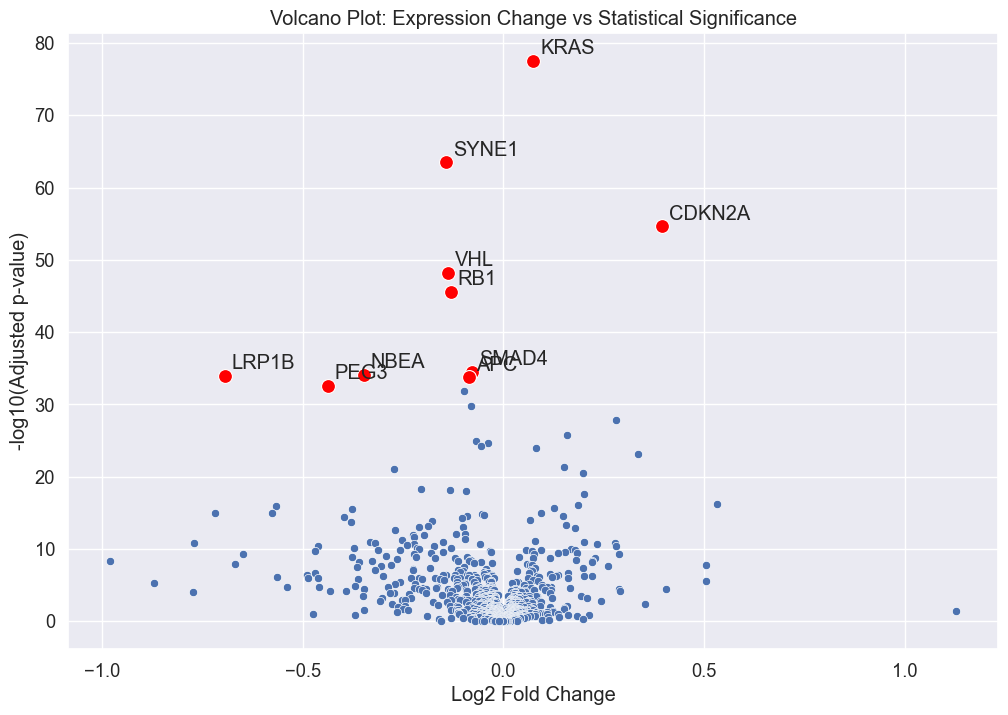

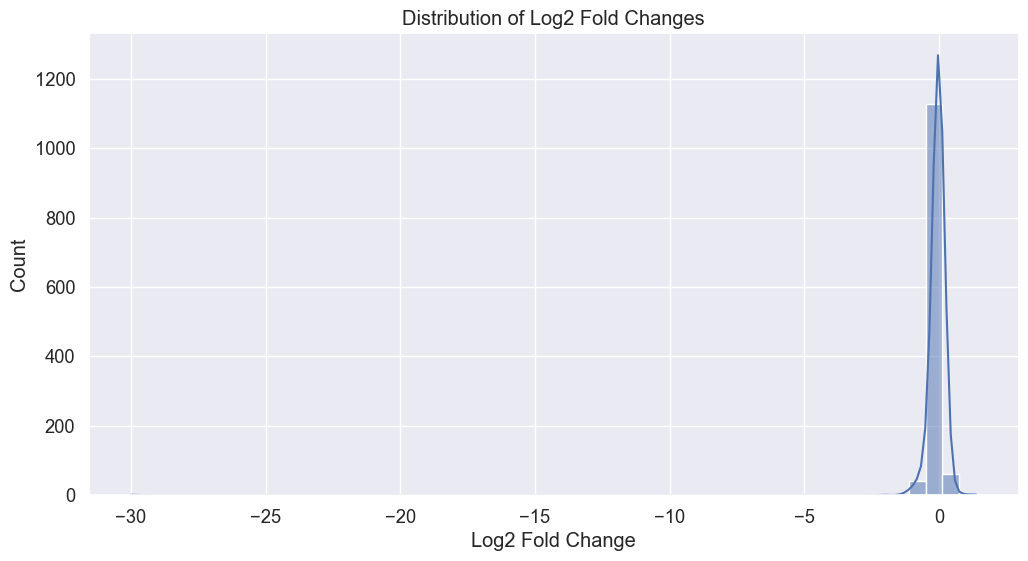

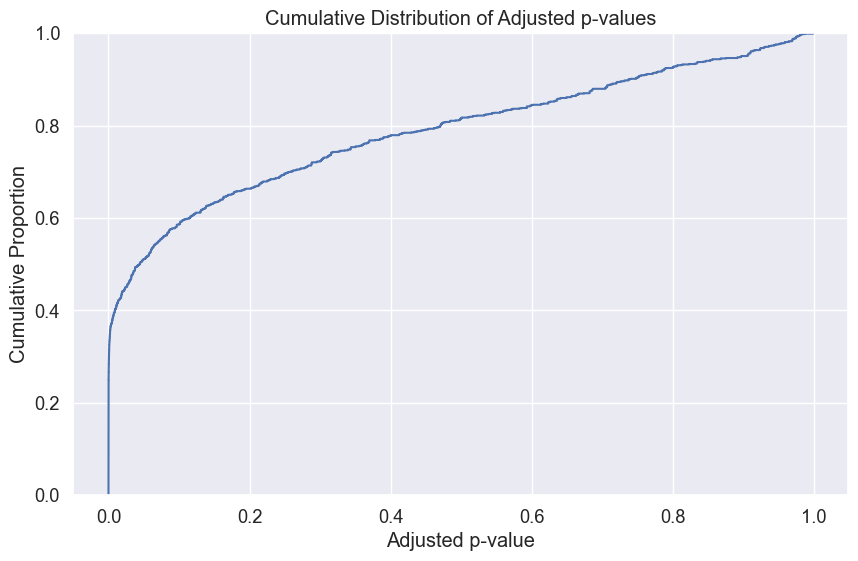

In [349]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def get_unique_drivers(filtered_results):
    return filtered_results['driver'].unique()

def analyze_driver_expression(driver, mutationtab, tumourexp):
    mutation_status = mutationtab[driver]
    expression = tumourexp[driver]
    
    combined_data = pd.DataFrame({'mutation': mutation_status, 'expression': expression})
    
    mutated_expr = combined_data[combined_data['mutation'] == 1]['expression']
    non_mutated_expr = combined_data[combined_data['mutation'] == 0]['expression']
    
    mean_expr_mutated = mutated_expr.mean()
    mean_expr_non_mutated = non_mutated_expr.mean()
    
    # Calcular log2 fold change com um pequeno epsilon para evitar divisão por zero
    epsilon = 1e-10
    log2_fold_change = np.log2((mean_expr_mutated + epsilon) / (mean_expr_non_mutated + epsilon))
    
    # Realizar o teste de Mann-Whitney apenas se houver amostras suficientes em ambos os grupos
    if len(mutated_expr) > 0 and len(non_mutated_expr) > 0:
        statistic, p_value = stats.mannwhitneyu(mutated_expr, non_mutated_expr, alternative='two-sided')
    else:
        statistic, p_value = np.nan, np.nan
    
    return {
        'driver': driver,
        'mean_expr_mutated': mean_expr_mutated,
        'mean_expr_non_mutated': mean_expr_non_mutated,
        'mann_whitney_statistic': statistic,
        'p_value': p_value,
        'log2_fold_change': log2_fold_change
    }
def benjamini_hochberg_correction(p_values):
    p_values = np.array(p_values)
    n = len(p_values)
    print(f"Number of p-values: {n}")
    print(f"Original p-values: {p_values}")

    # Remove NaN values
    valid_mask = ~np.isnan(p_values)
    valid_p_values = p_values[valid_mask]
    m = len(valid_p_values)
    print(f"Number of valid p-values: {m}")

    if m == 0:
        return np.full_like(p_values, np.nan)

    # Sort p-values
    sorted_indices = np.argsort(valid_p_values)
    sorted_p_values = valid_p_values[sorted_indices]
    print(f"Sorted p-values: {sorted_p_values}")

    # Calculate adjusted p-values
    adjusted_p_values = np.zeros(m)
    for i in range(m):
        rank = i + 1
        adjusted_p_values[i] = min(sorted_p_values[i] * m / rank, 1.0)

    # Ensure monotonicity
    for i in range(m-2, -1, -1):
        adjusted_p_values[i] = min(adjusted_p_values[i], adjusted_p_values[i+1])

    print(f"Adjusted p-values (sorted): {adjusted_p_values}")

    # Reorder to match original input
    reordered_adjusted_p_values = np.zeros(m)
    reordered_adjusted_p_values[sorted_indices] = adjusted_p_values

    # Reinsert NaN values
    final_adjusted_p_values = np.full(n, np.nan)
    final_adjusted_p_values[valid_mask] = reordered_adjusted_p_values
    
    print(f"Final adjusted p-values: {final_adjusted_p_values}")

    return final_adjusted_p_values
# As funções get_unique_drivers, analyze_driver_expression e benjamini_hochberg_correction permanecem as mesmas

def main_analysis(drivers, mutationtab, tumourexp):
    main_results = []
    
    for driver in drivers:
        if driver in mutationtab.columns and driver in tumourexp.columns:
            result = analyze_driver_expression(driver, mutationtab, driver_tumour_expression)
            main_results.append(result)
        else:
            print(f"Driver {driver} not found in mutation or expression data. Skipping...")
    
    results_df = pd.DataFrame(main_results)
    results_df['adj_p_value'] = benjamini_hochberg_correction(results_df['p_value'])
    
    # Criar a coluna -log10(adj_p_value) explicitamente
    results_df['-log10(adj_p_value)'] = -np.log10(results_df['adj_p_value'])
    
    results_df = results_df.sort_values('adj_p_value')
    
    # Print summary statistics
    print("Summary of results:")
    print(results_df.describe())
    
    # Print top 20 most significant drivers
    print("\nTop 20 most significant drivers:")
    print(results_df.head(20))
    
    # Volcano plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='log2_fold_change', y='-log10(adj_p_value)', data=results_df)
    plt.title('Volcano Plot: Expression Change vs Statistical Significance')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')
    
    # Highlight top 10 most significant points
    top_10 = results_df.nlargest(10, '-log10(adj_p_value)')
    sns.scatterplot(x='log2_fold_change', y='-log10(adj_p_value)', 
                    data=top_10, color='red', s=100)
    
    for idx, row in top_10.iterrows():
        plt.annotate(row['driver'], 
                     (row['log2_fold_change'], row['-log10(adj_p_value)']),
                     xytext=(5, 5), textcoords='offset points')
    plt.show()

    # Histogram of log2 fold changes
    plt.figure(figsize=(12, 6))
    sns.histplot(results_df['log2_fold_change'], bins=50, kde=True)
    plt.title('Distribution of Log2 Fold Changes')
    plt.xlabel('Log2 Fold Change')
    plt.show()

    # Cumulative distribution of p-values
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(results_df['adj_p_value'])
    plt.title('Cumulative Distribution of Adjusted p-values')
    plt.xlabel('Adjusted p-value')
    plt.ylabel('Cumulative Proportion')
    plt.show()

main_analysis(significant_drivers_filt, mutationtab, driver_tumour_expression)

In [350]:
category_order = ['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']

      driver  category  mean_expression_mutated  mean_expression_non_mutated  \
0       A1CF  non_sign                 1.364054                     1.733682   
1      A2ML1  more_pos                 3.792646                     3.984380   
2     ABCA10  non_sign                 3.434216                     3.776301   
3     ABCA13  more_pos                 4.416936                     4.238564   
4      ABCA7  non_sign                 8.592880                     8.488046   
...      ...       ...                      ...                          ...   
2462  ZSWIM3  non_sign                 6.757654                     6.826901   
2463  ZSWIM6  non_sign                 8.376133                     8.574214   
2464  ZWILCH  non_sign                 8.974727                     8.440610   
2465   ZWINT       pos                 9.697200                     8.939950   
2466   ZZEF1  more_pos                10.118257                    10.136499   

      mann_whitney_statistic   p_value 

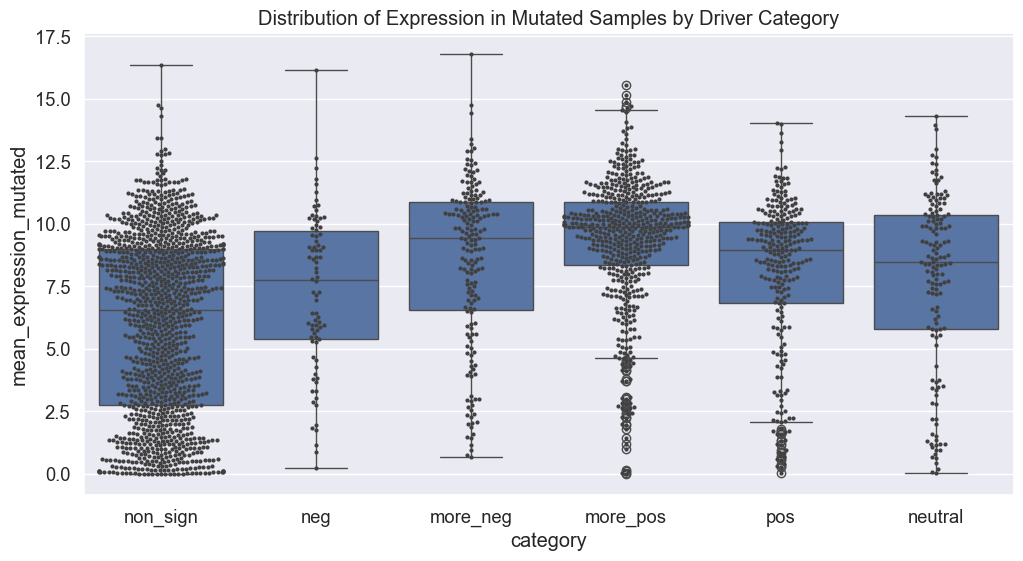

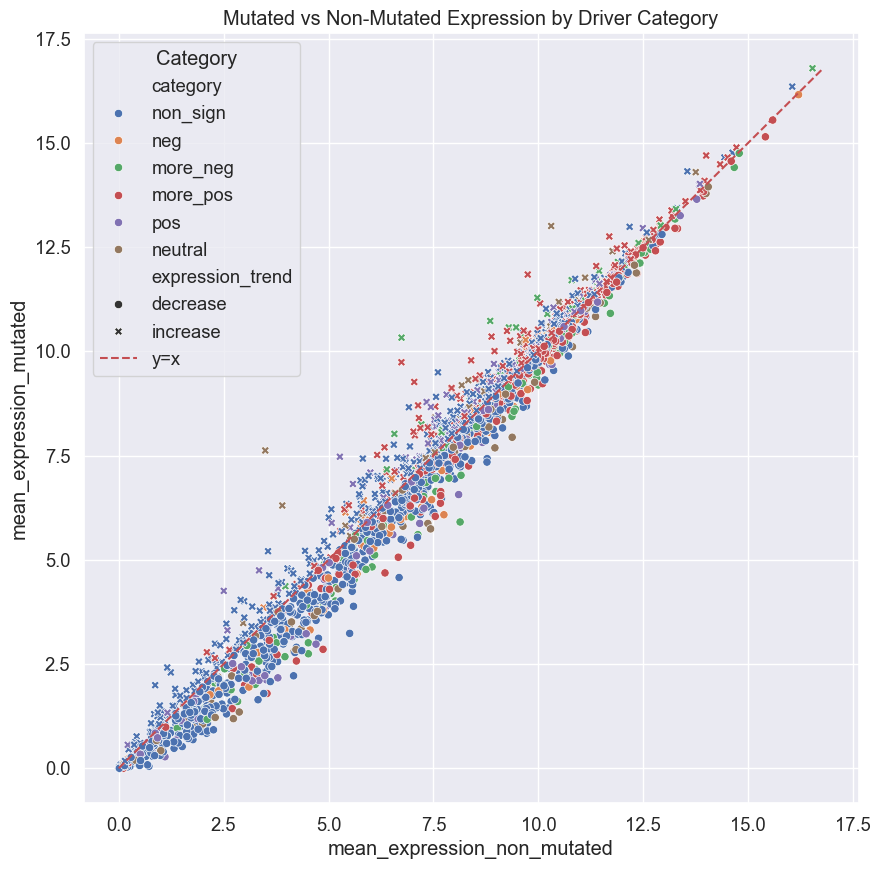


Proportion of expression trends by category:
expression_trend  decrease  increase
category                            
more_neg          0.701087  0.298913
more_pos          0.550179  0.449821
neg               0.658537  0.341463
neutral           0.621622  0.378378
non_sign          0.638281  0.361719
pos               0.519084  0.480916


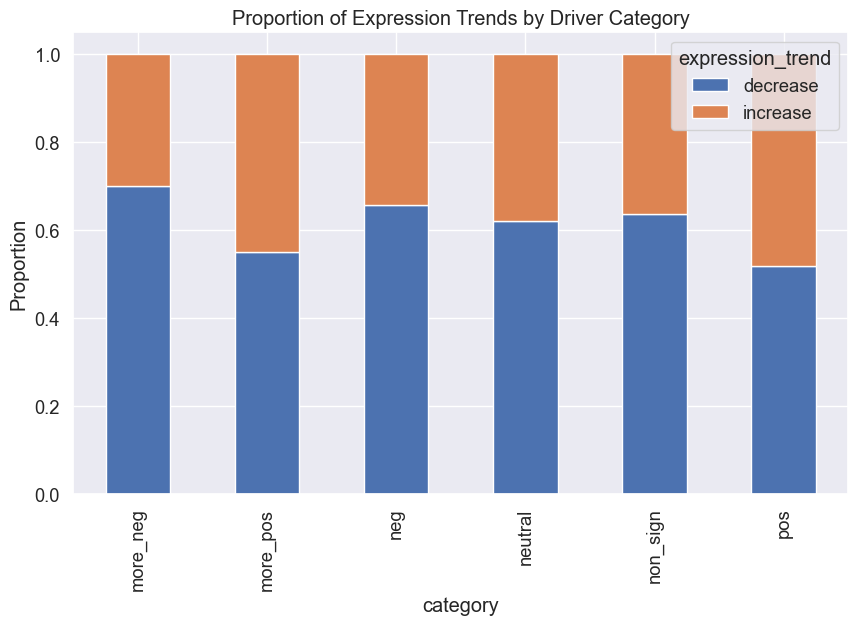


Statistical comparisons between categories:
non_sign vs pos: statistic = 132613.0000, p-value = 0.0000
neg vs non_sign: statistic = 45323.0000, p-value = 0.1163
neg vs pos: statistic = 7917.0000, p-value = 0.0003
neg vs neutral: statistic = 5408.0000, p-value = 0.1724
more_neg vs non_sign: statistic = 105164.0000, p-value = 0.1101
more_neg vs neg: statistic = 7758.0000, p-value = 0.7125
more_neg vs more_pos: statistic = 39120.0000, p-value = 0.0000
more_neg vs pos: statistic = 17921.0000, p-value = 0.0000
more_neg vs neutral: statistic = 12567.0000, p-value = 0.2278
more_pos vs non_sign: statistic = 398194.0000, p-value = 0.0000
more_pos vs neg: statistic = 28603.0000, p-value = 0.0003
more_pos vs pos: statistic = 70393.0000, p-value = 0.3925
more_pos vs neutral: statistic = 47293.0000, p-value = 0.0065
neutral vs non_sign: statistic = 91987.0000, p-value = 0.8710
neutral vs pos: statistic = 16129.0000, p-value = 0.0047

Non-significant (Category non_sign):
      driver  category  mea

In [352]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Function to analyze driver expression
def analyze_driver_expression(driver, mutationtab, driver_tumour_expression):
    if driver not in mutationtab.columns or driver not in driver_tumour_expression.columns:
        # Skip drivers that are missing in either dataset
        return None
    
    mutated_individuals = mutationtab[mutationtab[driver] == 1].index
    non_mutated_individuals = mutationtab[mutationtab[driver] == 0].index
    
    exp_mutated = driver_tumour_expression.loc[mutated_individuals, driver]
    exp_non_mutated = driver_tumour_expression.loc[non_mutated_individuals, driver]
    
    if not exp_mutated.empty and not exp_non_mutated.empty:
        statistic, p_value = stats.mannwhitneyu(exp_mutated, exp_non_mutated, alternative='two-sided')
        mean_mutated = exp_mutated.mean()
        mean_non_mutated = exp_non_mutated.mean()
        
        # Ensure correct access to the 'group' (category) column in driver_stats
        category = driver_stats.loc[driver_stats['driver'] == driver, 'group'].values[0]
        
        expression_trend = 'increase' if mean_mutated > mean_non_mutated else 'decrease' if mean_mutated < mean_non_mutated else 'no change'
        
        return {
            'driver': driver,
            'category': category,  # Use the correct driver group
            'mean_expression_mutated': mean_mutated,
            'mean_expression_non_mutated': mean_non_mutated,
            'mann_whitney_statistic': statistic,
            'p_value': p_value,
            'expression_trend': expression_trend
        }
    return None

# Function to compare categories
def compare_categories(cat1, cat2, results_df):
    group1 = results_df[results_df['category'] == cat1]['mean_expression_mutated'] - \
             results_df[results_df['category'] == cat1]['mean_expression_non_mutated']
    group2 = results_df[results_df['category'] == cat2]['mean_expression_mutated'] - \
             results_df[results_df['category'] == cat2]['mean_expression_non_mutated']
    statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    return f"{cat1} vs {cat2}: statistic = {statistic:.4f}, p-value = {p_value:.4f}"

# 1. Use data from filt_drivers to count positive and negative neighbors
driver_stats = filt_drivers[['driver', 'n_neighbours', 'pos_dints', 'neg_dints', 'pos_pct', 'neg_pct', 'group']].copy()

# Filter only drivers that exist in both mutationtab and driver_tumour_expression
common_drivers = driver_stats['driver'][driver_stats['driver'].isin(mutationtab.columns) & driver_stats['driver'].isin(driver_tumour_expression.columns)]

# Apply expression analysis to filtered common drivers
exp_results = [analyze_driver_expression(driver, mutationtab, driver_tumour_expression) for driver in common_drivers]
results_df = pd.DataFrame([r for r in exp_results if r is not None])

# 2. Analysis and visualizations
print(results_df)

category_summary = results_df.groupby('category').agg({
    'mean_expression_mutated': ['mean', 'std'],
    'mean_expression_non_mutated': ['mean', 'std'],
    'p_value': ['mean', 'median'],
    'driver': 'count'
}).rename(columns={'driver': 'count'})

print("\nStatistical summary by category:")
print(category_summary)

# Set category order as per the requested order: non_sign, neg, more_neg, more_pos, pos, neutral
category_order = ['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']

# Boxplot and Swarmplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='mean_expression_mutated', data=results_df, order=category_order)
sns.swarmplot(x='category', y='mean_expression_mutated', data=results_df, color=".25", size=3, order=category_order)
plt.title('Distribution of Expression in Mutated Samples by Driver Category')
plt.show()

# Scatterplot of Mutated vs Non-Mutated Expression
plt.figure(figsize=(10, 10))
sns.scatterplot(x='mean_expression_non_mutated', y='mean_expression_mutated', 
                hue='category', style='expression_trend', data=results_df, hue_order=category_order)
plt.plot([0, results_df['mean_expression_mutated'].max()], 
         [0, results_df['mean_expression_mutated'].max()], 
         'r--', label='y=x')
plt.title('Mutated vs Non-Mutated Expression by Driver Category')
plt.legend(title='Category')
plt.show()

# Proportion of Expression Trends by Category
expression_trends = results_df.groupby('category')['expression_trend'].value_counts(normalize=True).unstack()
print("\nProportion of expression trends by category:")
print(expression_trends)

# Plotting the bar plot without the 'order' argument
expression_trends.plot(kind='bar', stacked=True, figsize=(10, 6))  # Removed 'order'
plt.title('Proportion of Expression Trends by Driver Category')
plt.ylabel('Proportion')
plt.show()

# Statistical comparisons between categories
print("\nStatistical comparisons between categories:")
for cat1 in category_order:
    for cat2 in category_order:
        if cat1 < cat2:
            print(compare_categories(cat1, cat2, results_df))

# Output detailed results by category
expected_categories = {
    'non_sign': 'Non-significant',
    'neg': 'Y-axis (Only negative neighbours)',
    'more_neg': 'Above y=x (More negative than positive neighbours)',
    'more_pos': 'Below y=x (More positive than negative neighbours)',
    'pos': 'X-axis (Only positive neighbours)',
    'neutral': 'Equal number of positive and negative neighbours'
}

for category, description in expected_categories.items():
    print(f"\n{description} (Category {category}):")
    category_df = results_df[results_df['category'] == category]
    print(category_df)


In [286]:
""" def analyze_driver_expression_and_neighbors(driver, mutationtab, driver_tumour_expression, filt_drivers):
    mutated_individuals = mutationtab[mutationtab[driver] == 1].index
    non_mutated_individuals = mutationtab[mutationtab[driver] == 0].index
    
    exp_mutated = driver_tumour_expression.loc[mutated_individuals, driver]
    exp_non_mutated = driver_tumour_expression.loc[non_mutated_individuals, driver]
    
    if not exp_mutated.empty and not exp_non_mutated.empty:
        mean_expr_mutated = exp_mutated.mean()
        mean_expr_non_mutated = exp_non_mutated.mean()
        
        # Se a expressão diminui quando mutada
        if mean_expr_mutated < mean_expr_non_mutated:
            num_neighbors = filt_drivers.loc[filt_drivers['driver'] == driver, 'n_neighbours'].values[0]
            return driver, mean_expr_mutated, mean_expr_non_mutated, num_neighbors

# Aplicar a análise a todos os drivers comuns
drivers_with_less_expression_and_neighbors = []
for driver in common_drivers:
    result = analyze_driver_expression_and_neighbors(driver, mutationtab, driver_tumour_expression, filt_drivers)
    if result:
        drivers_with_less_expression_and_neighbors.append(result)

# Exibir drivers com diminuição de expressão quando mutados e o número de vizinhos
df_drivers_with_less_expr_and_neighbors = pd.DataFrame(drivers_with_less_expression_and_neighbors, 
                                                       columns=['driver', 'mean_expr_mutated', 'mean_expr_non_mutated', 'num_neighbors'])
print(df_drivers_with_less_expr_and_neighbors)
 """

      driver  mean_expr_mutated  mean_expr_non_mutated  num_neighbors
0       A1CF           1.364054               1.733682             39
1      A2ML1           3.792646               3.984380             91
2     ABCA10           3.434216               3.776301              5
3      ABCB1           6.108873               6.879919             76
4      ABCB5           1.210502               1.588685             16
...      ...                ...                    ...            ...
1500  ZRANB3           5.894113               5.922064             22
1501  ZSCAN4           1.255821               1.359738             12
1502  ZSWIM3           6.757654               6.826901              6
1503  ZSWIM6           8.376133               8.574214             22
1504   ZZEF1          10.118257              10.136499             89

[1505 rows x 4 columns]


In [284]:
""" def analyze_driver_expression_and_group(driver, mutationtab, driver_tumour_expression, filt_drivers):
    mutated_individuals = mutationtab[mutationtab[driver] == 1].index
    non_mutated_individuals = mutationtab[mutationtab[driver] == 0].index
    
    exp_mutated = driver_tumour_expression.loc[mutated_individuals, driver]
    exp_non_mutated = driver_tumour_expression.loc[non_mutated_individuals, driver]
    
    if not exp_mutated.empty and not exp_non_mutated.empty:
        mean_expr_mutated = exp_mutated.mean()
        mean_expr_non_mutated = exp_non_mutated.mean()

        # Se a expressão aumenta quando mutada
        if mean_expr_mutated > mean_expr_non_mutated:
            group = filt_drivers.loc[filt_drivers['driver'] == driver, 'group'].values[0]
            num_neighbors = filt_drivers.loc[filt_drivers['driver'] == driver, 'n_neighbours'].values[0]
            return driver, mean_expr_mutated, group, num_neighbors

# Aplicar a análise aos drivers comuns
drivers_with_more_expression_and_group = []
for driver in common_drivers:
    result = analyze_driver_expression_and_group(driver, mutationtab, driver_tumour_expression, filt_drivers)
    if result:
        drivers_with_more_expression_and_group.append(result)

# Exibir drivers com maior expressão quando mutados e seus grupos
df_drivers_with_more_expr_and_group = pd.DataFrame(drivers_with_more_expression_and_group, 
                                                   columns=['driver', 'mean_expr_mutated', 'group', 'num_neighbors'])
print(df_drivers_with_more_expr_and_group)
 """

     driver  mean_expr_mutated     group  num_neighbors
0    ABCA13           4.416936  more_pos              9
1     ABCA7           8.592880  non_sign             16
2     ABCC3           9.717133  non_sign             26
3     ABCD1           8.875875  more_pos             63
4     ABCF1          10.917841  more_pos            175
..      ...                ...       ...            ...
957   ZNRF3           8.905833  non_sign             73
958   ZPBP2           0.563684  non_sign             21
959   ZRSR2           8.030500  non_sign             89
960  ZWILCH           8.974727  non_sign             22
961   ZWINT           9.697200       pos            136

[962 rows x 4 columns]


      driver  mean_expr_mutated  mean_expr_non_mutated  expression_change  \
0       A1CF           1.364054               1.733682          -0.369628   
1      A2ML1           3.792646               3.984380          -0.191734   
2     ABCA10           3.434216               3.776301          -0.342086   
3     ABCA13           4.416936               4.238564           0.178372   
4      ABCA7           8.592880               8.488046           0.104834   
...      ...                ...                    ...                ...   
2462  ZSWIM3           6.757654               6.826901          -0.069247   
2463  ZSWIM6           8.376133               8.574214          -0.198081   
2464  ZWILCH           8.974727               8.440610           0.534118   
2465   ZWINT           9.697200               8.939950           0.757250   
2466   ZZEF1          10.118257              10.136499          -0.018242   

         group  num_neighbors  
0     non_sign             39  
1     more_

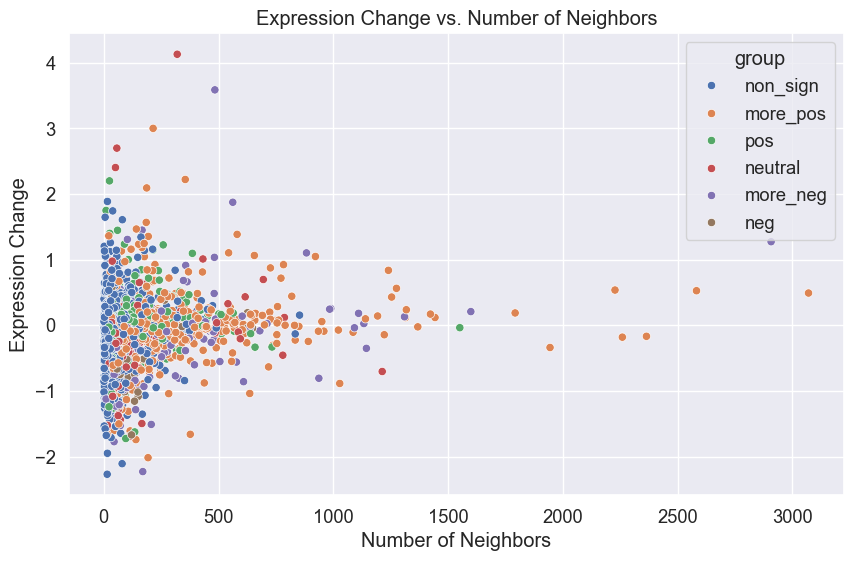

Correlation for mutated drivers: 0.6395, p-value: 0.0000
Correlation for non-mutated drivers: 0.6287, p-value: 0.0000


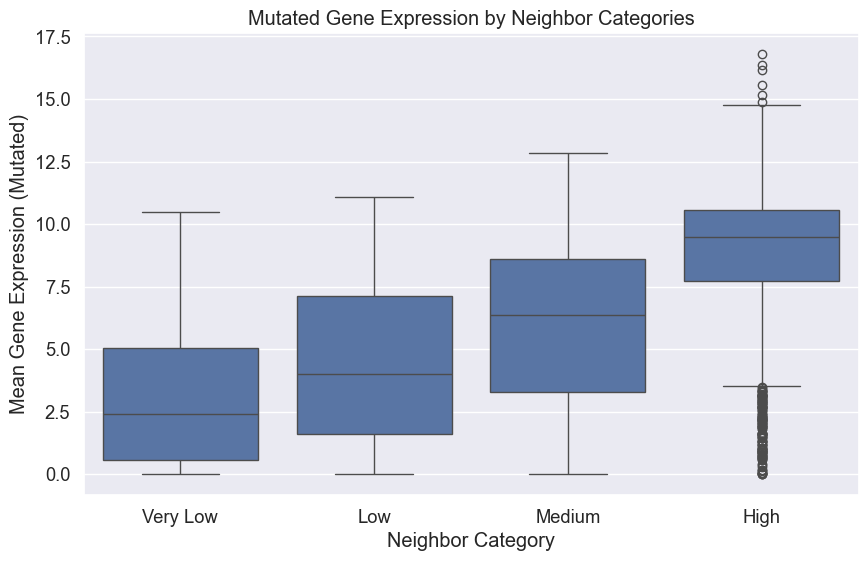

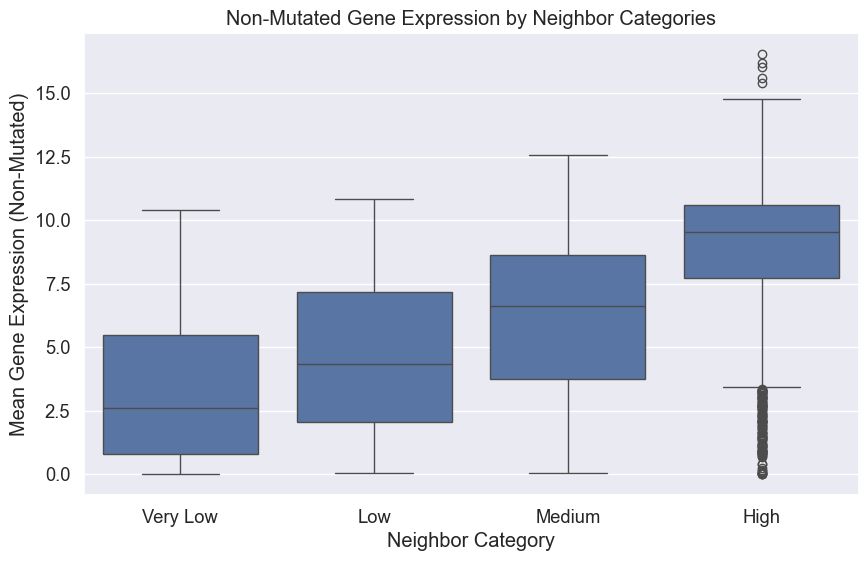

Kruskal-Wallis Test (Mutated): statistic = 746.5109, p-value = 0.0000
Kruskal-Wallis Test (Non-Mutated): statistic = 726.9406, p-value = 0.0000


In [353]:
def analyze_driver_expression_change_and_group(driver, mutationtab, driver_tumour_expression, filt_drivers):
    mutated_individuals = mutationtab[mutationtab[driver] == 1].index
    non_mutated_individuals = mutationtab[mutationtab[driver] == 0].index
    
    exp_mutated = driver_tumour_expression.loc[mutated_individuals, driver]
    exp_non_mutated = driver_tumour_expression.loc[non_mutated_individuals, driver]
    
    if not exp_mutated.empty and not exp_non_mutated.empty:
        mean_expr_mutated = exp_mutated.mean()
        mean_expr_non_mutated = exp_non_mutated.mean()
        
        expression_change = mean_expr_mutated - mean_expr_non_mutated
        group = filt_drivers.loc[filt_drivers['driver'] == driver, 'group'].values[0]
        num_neighbors = filt_drivers.loc[filt_drivers['driver'] == driver, 'n_neighbours'].values[0]
        
        return driver, mean_expr_mutated, mean_expr_non_mutated, expression_change, group, num_neighbors

# Apply the analysis to common drivers
drivers_expr_change_and_group = []
for driver in common_drivers:
    result = analyze_driver_expression_change_and_group(driver, mutationtab, driver_tumour_expression, filt_drivers)
    if result:
        drivers_expr_change_and_group.append(result)

# Display the results
df_drivers_expr_change_and_group = pd.DataFrame(drivers_expr_change_and_group, 
                                                columns=['driver', 'mean_expr_mutated', 'mean_expr_non_mutated', 
                                                         'expression_change', 'group', 'num_neighbors'])
print(df_drivers_expr_change_and_group)

# Display drivers with increased expression when mutated
print(df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['expression_change'] > 0])

# Correlation between expression change and number of neighbors
correlation = df_drivers_expr_change_and_group['expression_change'].corr(df_drivers_expr_change_and_group['num_neighbors'])
print(f"Correlation between expression change and number of neighbors: {correlation:.2f}")

# Scatter plot of expression change vs. number of neighbors
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_neighbors', y='expression_change', hue='group', data=df_drivers_expr_change_and_group)
plt.title('Expression Change vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Expression Change')
plt.show()

# Create new neighbor categories for a more detailed separation
df_drivers_expr_change_and_group['neighbor_category'] = pd.cut(df_drivers_expr_change_and_group['num_neighbors'], 
                                                               bins=[0, 5, 15, 50, np.inf], 
                                                               labels=['Very Low', 'Low', 'Medium', 'High'])

from scipy.stats import spearmanr

# Correlation for mutated drivers
corr_mutated, p_value_mutated = spearmanr(df_drivers_expr_change_and_group['num_neighbors'], 
                                          df_drivers_expr_change_and_group['mean_expr_mutated'])

# Correlation for non-mutated drivers
corr_non_mutated, p_value_non_mutated = spearmanr(df_drivers_expr_change_and_group['num_neighbors'], 
                                                  df_drivers_expr_change_and_group['mean_expr_non_mutated'])

print(f'Correlation for mutated drivers: {corr_mutated:.4f}, p-value: {p_value_mutated:.4f}')
print(f'Correlation for non-mutated drivers: {corr_non_mutated:.4f}, p-value: {p_value_non_mutated:.4f}')

# Box plot comparison of mutated gene expression by neighbor category
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbor_category', y='mean_expr_mutated', data=df_drivers_expr_change_and_group)
plt.title('Mutated Gene Expression by Neighbor Categories')
plt.xlabel('Neighbor Category')
plt.ylabel('Mean Gene Expression (Mutated)')
plt.show()

# Box plot comparison of non-mutated gene expression by neighbor category
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbor_category', y='mean_expr_non_mutated', data=df_drivers_expr_change_and_group)
plt.title('Non-Mutated Gene Expression by Neighbor Categories')
plt.xlabel('Neighbor Category')
plt.ylabel('Mean Gene Expression (Non-Mutated)')
plt.show()

from scipy.stats import kruskal

# Kruskal-Wallis test for mutated gene expression
stat_mutated, p_mutated = kruskal(df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Very Low']['mean_expr_mutated'],
                                  df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Low']['mean_expr_mutated'],
                                  df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Medium']['mean_expr_mutated'],
                                  df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'High']['mean_expr_mutated'])

# Kruskal-Wallis test for non-mutated gene expression
stat_non_mutated, p_non_mutated = kruskal(df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Very Low']['mean_expr_non_mutated'],
                                          df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Low']['mean_expr_non_mutated'],                                    
                                          df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Medium']['mean_expr_non_mutated'],
                                          df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'High']['mean_expr_non_mutated'])

print(f'Kruskal-Wallis Test (Mutated): statistic = {stat_mutated:.4f}, p-value = {p_mutated:.4f}')
print(f'Kruskal-Wallis Test (Non-Mutated): statistic = {stat_non_mutated:.4f}, p-value = {p_non_mutated:.4f}')


In [354]:
# Initialize a list to track drivers that return NaN
nan_drivers = []

# Modified expression analysis to track NaN drivers
for driver in common_drivers:
    result = analyze_driver_expression(driver, mutationtab, driver_tumour_expression)
    if result is None:
        nan_drivers.append(driver)

# Display the drivers that resulted in NaN
nan_drivers

[]

In [355]:
# Count the number of drivers in each category
driver_counts = driver_stats['group'].value_counts()

print("Number of drivers in each category:")
print(driver_counts)

Number of drivers in each category:
group
non_sign    1294
more_pos     576
pos          274
more_neg     185
neutral      151
neg           85
Name: count, dtype: int64


In [356]:
from scipy.stats import chi2_contingency

# Create a contingency table for categories and expression trends
contingency_table = pd.crosstab(results_df['category'], results_df['expression_trend'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of Freedom: {dof}")

print("\nContingency Table:")
print(contingency_table)

print("\nExpected Values:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))



Chi-Square Test Results:
Chi-Square Statistic: 28.9563
P-value: 2.37e-05
Degrees of Freedom: 5

Contingency Table:
expression_trend  decrease  increase
category                            
more_neg               129        55
more_pos               307       251
neg                     54        28
neutral                 92        56
non_sign               787       446
pos                    136       126

Expected Values:
expression_trend    decrease    increase
category                                
more_neg          112.249696   71.750304
more_pos          340.409404  217.590596
neg                50.024321   31.975679
neutral            90.287799   57.712201
non_sign          752.194974  480.805026
pos               159.833806  102.166194


In [357]:
# Step 1: Ensure mutation_frequency is not NaN and matches with drivers in driver_stats
mutation_frequency = mutationtab.mean()

# Step 2: Calculate expression change for each driver
def calculate_expression_change(row):
    if pd.notna(row['mean_expression_mutated']) and pd.notna(row['mean_expression_non_mutated']):
        return row['mean_expression_mutated'] - row['mean_expression_non_mutated']
    return np.nan

# Apply expression change calculation to results_df
results_df['expression_change'] = results_df.apply(calculate_expression_change, axis=1)

# Step 3: Ensure proper merging by aligning indices (reset index if necessary)
# Ensure that driver_info has the same index and 'driver' column
driver_info = driver_stats.set_index('driver').join(results_df.set_index('driver')[['expression_change']], how='left')

# Merge mutation_frequency based on driver index
driver_info = driver_info.join(mutation_frequency.rename('mutation_frequency'), how='left')

# Step 4: Filter out rows with all NaN values in both expression_change and mutation_frequency
driver_info = driver_info.dropna(subset=['expression_change', 'mutation_frequency'], how='all')

print(driver_info)


        n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group  \
driver                                                                     
A1CF              39          0          0  0.000000  0.000000  non_sign   
A2ML1             91          4          3  0.043956  0.032967  more_pos   
ABCA10             5          0          0  0.000000  0.000000  non_sign   
ABCA13             9          3          1  0.333333  0.111111  more_pos   
ABCA7             16          0          0  0.000000  0.000000  non_sign   
...              ...        ...        ...       ...       ...       ...   
ZSWIM3             6          0          0  0.000000  0.000000  non_sign   
ZSWIM6            22          0          0  0.000000  0.000000  non_sign   
ZWILCH            22          1          0  0.045455  0.000000  non_sign   
ZWINT            136         22          0  0.161765  0.000000       pos   
ZZEF1             89          8          2  0.089888  0.022472  more_pos   

        exp

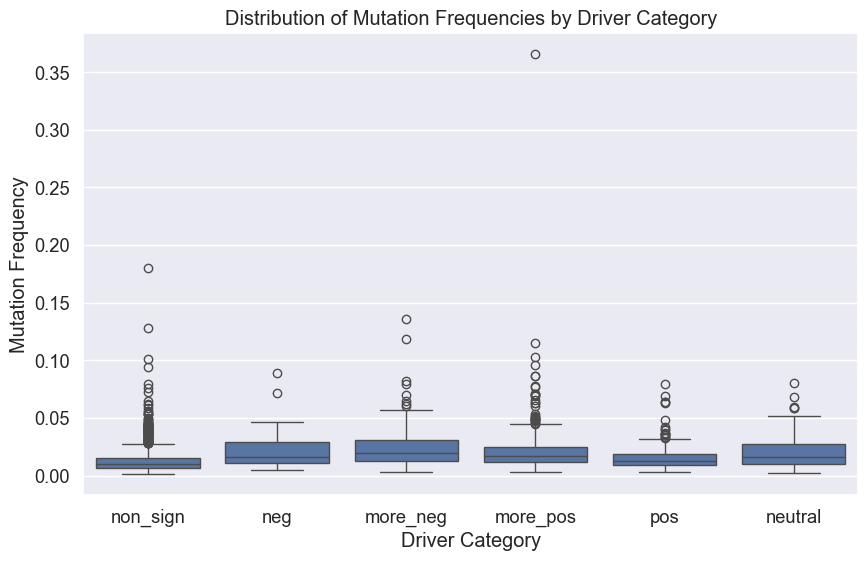

In [358]:
# Step 4: Visualize mutation frequency by category

# Remove rows with NaN mutation frequencies
filtered_driver_info = driver_info.dropna(subset=['mutation_frequency'])

# Update the category order to only include categories present in the filtered data
present_categories = filtered_driver_info['group'].unique()
category_order_present = [cat for cat in category_order if cat in present_categories]

plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present)
plt.title('Distribution of Mutation Frequencies by Driver Category')
plt.xlabel('Driver Category')
plt.ylabel('Mutation Frequency')
plt.show()


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/4066671782.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, palette='Set2')


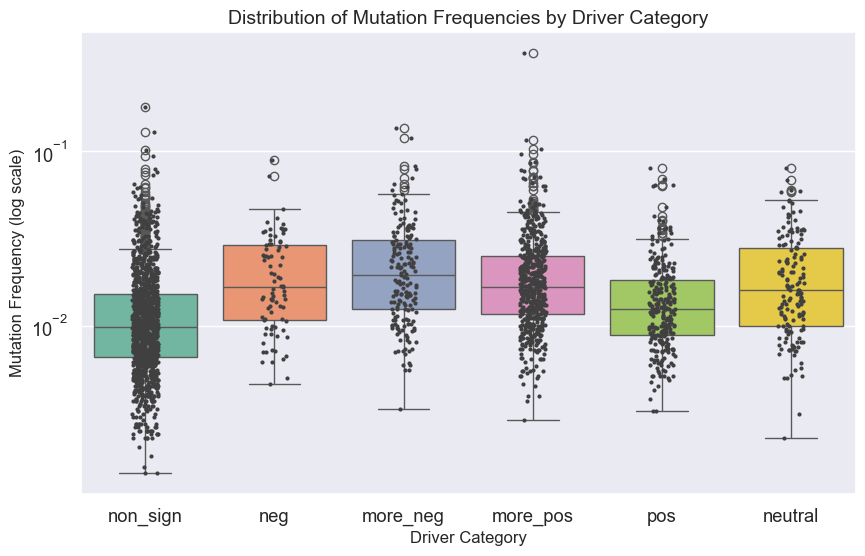

           count      mean       std       min       25%       50%       75%  \
group                                                                          
more_neg   185.0  0.024277  0.018280  0.003332  0.012375  0.019396  0.030819   
more_pos   576.0  0.021129  0.020125  0.002856  0.011661  0.016718  0.024988   
neg         85.0  0.020896  0.014046  0.004641  0.010709  0.016540  0.028915   
neutral    151.0  0.020413  0.014182  0.002261  0.009876  0.015945  0.027784   
non_sign  1294.0  0.012924  0.011736  0.001428  0.006574  0.009757  0.015082   
pos        274.0  0.015163  0.010682  0.003213  0.008805  0.012375  0.018354   

               max  
group               
more_neg  0.136245  
more_pos  0.365778  
neg       0.088767  
neutral   0.079962  
non_sign  0.179914  
pos       0.079605  


In [359]:
plt.figure(figsize=(10, 6))

# Boxplot with a color palette
sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, palette='Set2')

# Overlay swarmplot for individual data points
#sns.swarmplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, color=".25", size=3)
sns.stripplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, color=".25", size=3)

# Apply log scale to Y-axis to better visualize the smaller frequencies
plt.yscale('log')

# Add titles and labels
plt.title('Distribution of Mutation Frequencies by Driver Category', fontsize=14)
plt.xlabel('Driver Category', fontsize=12)
plt.ylabel('Mutation Frequency (log scale)', fontsize=12)

# Show the plot
plt.show()

# Print summary statistics
summary_stats = filtered_driver_info.groupby('group')['mutation_frequency'].describe()
print(summary_stats)


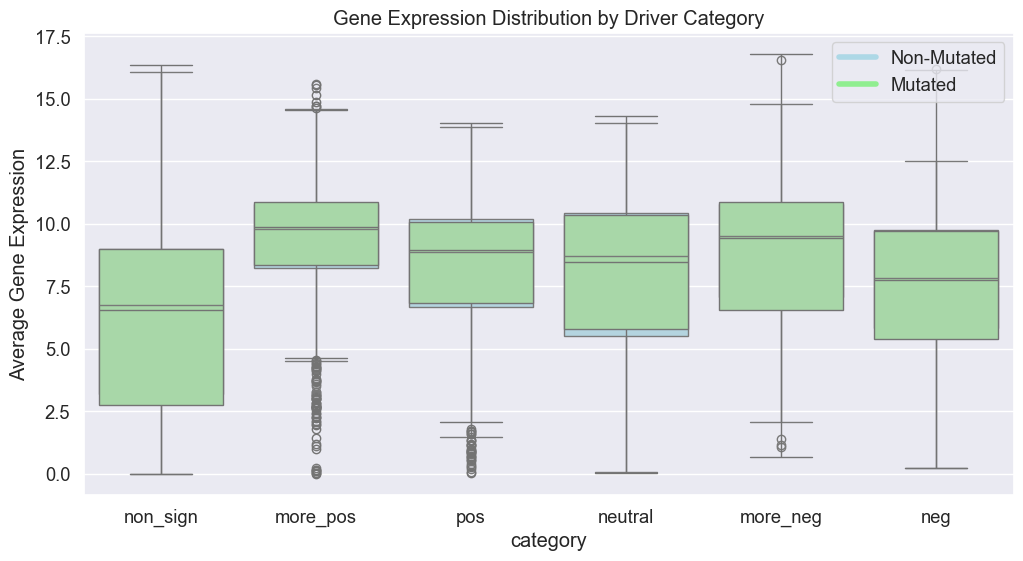

In [360]:
# Step 3: Visualizing gene expression distribution by category
plt.figure(figsize=(12, 6))

# Plot for non-mutated expression
sns.boxplot(x='category', y='mean_expression_non_mutated', data=results_df[results_df['category'].isin(category_order)], color='lightblue')
# Plot for mutated expression
sns.boxplot(x='category', y='mean_expression_mutated', data=results_df[results_df['category'].isin(category_order)], color='lightgreen', saturation=0.5)

plt.title('Gene Expression Distribution by Driver Category')
plt.ylabel('Average Gene Expression')

# Create custom legend
handles = [
    plt.Line2D([0], [0], color='lightblue', lw=4),
    plt.Line2D([0], [0], color='lightgreen', lw=4)
]
plt.legend(handles, ['Non-Mutated', 'Mutated'], loc='upper right')

plt.show()


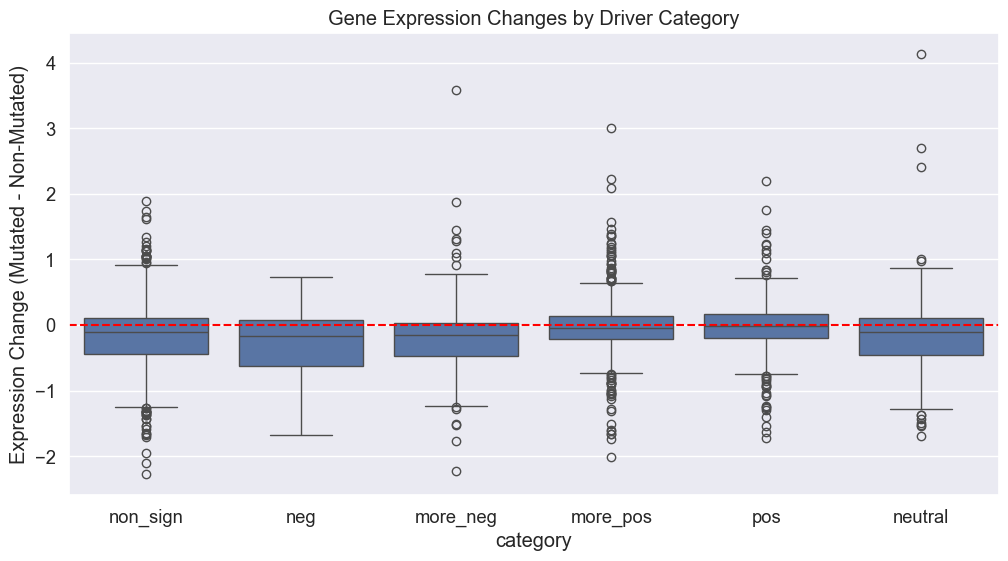

In [361]:
# Step 5: Visualize expression changes by category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='expression_change', data=results_df, order=category_order)
plt.title('Gene Expression Changes by Driver Category')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Expression Change (Mutated - Non-Mutated)')
plt.show()


In [362]:
# Step 6: Perform statistical comparisons for mutation frequencies
p_values = []
comparison_results = []
categories = driver_info['group'].unique()

# Pairwise comparison for mutation frequencies across categories
for cat1 in categories:
    for cat2 in categories:
        if cat1 < cat2:
            group1 = driver_info[driver_info['group'] == cat1]['mutation_frequency']
            group2 = driver_info[driver_info['group'] == cat2]['mutation_frequency']
            statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            p_values.append(p_value)
            comparison_results.append({'category1': cat1, 'category2': cat2, 'statistic': statistic, 'p_value': p_value})

# Apply Benjamini-Hochberg correction
corrected_p_values = benjamini_hochberg_correction(p_values)

# Add adjusted p-values to the comparison results
for i, result in enumerate(comparison_results):
    result['adjusted_p_value'] = corrected_p_values[i]

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)


Number of p-values: 15
Original p-values: [1.25500715e-08 7.44636857e-59 1.25048066e-12 4.10868093e-01
 9.28243032e-01 1.00054595e-15 9.37303112e-05 3.08822898e-31
 1.89752299e-02 2.66612346e-12 2.29722210e-02 1.68287295e-01
 7.67347042e-12 7.27239814e-05 6.21604785e-01]
Number of valid p-values: 15
Sorted p-values: [7.44636857e-59 3.08822898e-31 1.00054595e-15 1.25048066e-12
 2.66612346e-12 7.67347042e-12 1.25500715e-08 7.27239814e-05
 9.37303112e-05 1.89752299e-02 2.29722210e-02 1.68287295e-01
 4.10868093e-01 6.21604785e-01 9.28243032e-01]
Adjusted p-values (sorted): [1.11695528e-57 2.31617174e-30 5.00272974e-15 4.68930249e-12
 7.99837039e-12 1.91836761e-11 2.68930103e-08 1.36357465e-04
 1.56217185e-04 2.84628449e-02 3.13257559e-02 2.10359119e-01
 4.74078569e-01 6.66005127e-01 9.28243032e-01]
Final adjusted p-values: [2.68930103e-08 1.11695528e-57 4.68930249e-12 4.74078569e-01
 9.28243032e-01 5.00272974e-15 1.56217185e-04 2.31617174e-30
 2.84628449e-02 7.99837039e-12 3.13257559e-02 2

In [363]:
# Step 7: Perform Mann-Whitney U test for expression changes across categories
for category in present_categories:
    category_data = results_df[results_df['category'] == category]
    if len(category_data) > 1:
        statistic, p_value = stats.mannwhitneyu(category_data['mean_expression_mutated'], 
                                                category_data['mean_expression_non_mutated'], alternative='two-sided')
        print(f"\nCategoria {category}:")
        print(f"Teste de Mann-Whitney U: estatística = {statistic:.4f}, p-valor = {p_value:.4e}")

# Step 8: Perform Kruskal-Wallis test to compare expression change across categories
category_groups = [group['expression_change'].dropna() for name, group in results_df.groupby('category') if name in present_categories]
kruskal_statistic, kruskal_p_value = stats.kruskal(*category_groups)

print("\nKruskal-Wallis test para comparar a mudança na expressão entre categorias:")
print(f"Kruskal-Wallis estatística: {kruskal_statistic:.4f}")
print(f"p-valor: {kruskal_p_value:.4e}")



Categoria non_sign:
Teste de Mann-Whitney U: estatística = 740041.0000, p-valor = 2.5549e-01

Categoria more_pos:
Teste de Mann-Whitney U: estatística = 156128.0000, p-valor = 9.3405e-01

Categoria pos:
Teste de Mann-Whitney U: estatística = 34426.0000, p-valor = 9.5238e-01

Categoria neutral:
Teste de Mann-Whitney U: estatística = 10755.0000, p-valor = 7.8956e-01

Categoria more_neg:
Teste de Mann-Whitney U: estatística = 16621.0000, p-valor = 7.6388e-01

Categoria neg:
Teste de Mann-Whitney U: estatística = 3185.0000, p-valor = 5.6160e-01

Kruskal-Wallis test para comparar a mudança na expressão entre categorias:
Kruskal-Wallis estatística: 56.3701
p-valor: 6.8184e-11


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/809199625.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_results['abs_corr'] = significant_results['correlation'].abs()
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/809199625.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=significant_results, x='gene', y='correlation', palette='coolwarm')


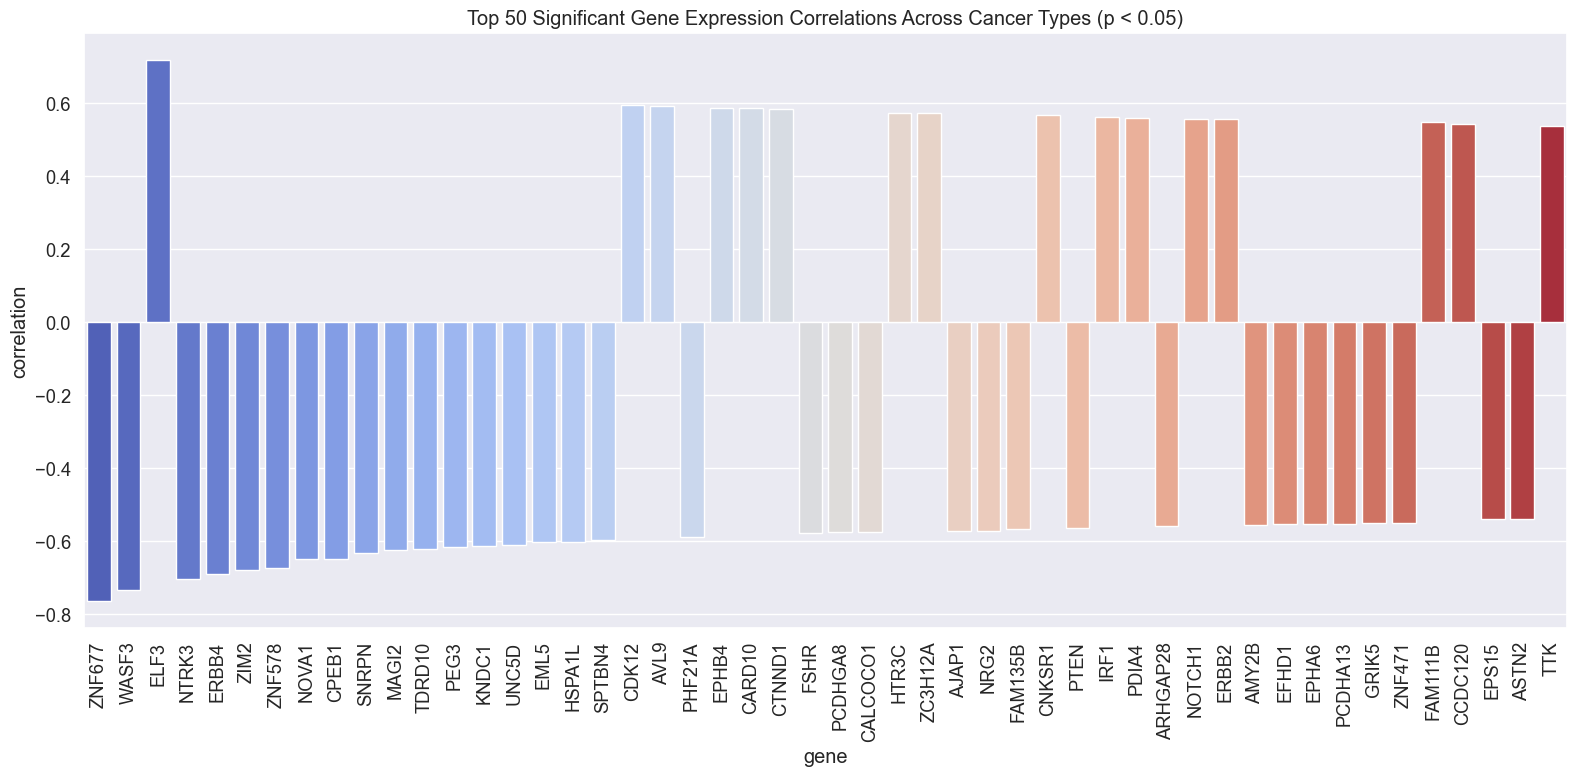

In [364]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute mutation frequencies and expression data by cancer type
def compute_cancer_type_stats(mutationtab, expression_data, cancer_type_column='cancer_type'):
    # Ensure that 'cancer_type' is the index in both mutationtab and expression_data
    mutationtab = mutationtab.reset_index().set_index(cancer_type_column)
    expression_data = expression_data.reset_index().set_index(cancer_type_column)
    
    # Select only numeric columns for mean computation
    mutation_by_cancer = mutationtab.select_dtypes(include=[np.number]).groupby(cancer_type_column).mean()
    expression_by_cancer = expression_data.select_dtypes(include=[np.number]).groupby(cancer_type_column).mean()
    
    return mutation_by_cancer, expression_by_cancer

# Step 2: Statistical comparison of mutations and expression patterns across cancer types
def compare_gene_expression_across_cancers(mutation_by_cancer, expression_by_cancer):
    results = []
    # Compare each gene's mutation and expression across cancer types using Spearman correlation
    for gene in mutation_by_cancer.columns:
        if gene in expression_by_cancer.columns:
            gene_mutation_data = mutation_by_cancer[gene]
            gene_expression_data = expression_by_cancer[gene]
            correlation, p_value = stats.spearmanr(gene_mutation_data, gene_expression_data)
            results.append({
                'gene': gene,
                'correlation': correlation,
                'p_value': p_value
            })
    return pd.DataFrame(results)

# Step 3: Visualization of significant correlations
def plot_correlation_results(results_df, p_value_threshold=0.05, top_n=50):
    # Filter results based on the p-value threshold
    significant_results = results_df[results_df['p_value'] < p_value_threshold]
    
    # Optionally, sort and limit to the top N most correlated genes
    significant_results['abs_corr'] = significant_results['correlation'].abs()
    significant_results = significant_results.sort_values(by='abs_corr', ascending=False).head(top_n)
    
    # Plotting
    plt.figure(figsize=(16, 8))  # Increased figure size
    sns.barplot(data=significant_results, x='gene', y='correlation', palette='coolwarm')
    plt.title(f'Top {top_n} Significant Gene Expression Correlations Across Cancer Types (p < {p_value_threshold})')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()
# Step 4: Putting everything together
def perform_cross_cancer_comparison(mutationtab, expression_data, cancer_type_column='cancer_type'):
    mutation_by_cancer, expression_by_cancer = compute_cancer_type_stats(mutationtab, expression_data, cancer_type_column)
    results_df = compare_gene_expression_across_cancers(mutation_by_cancer, expression_by_cancer)
    plot_correlation_results(results_df)

# Execute the analysis
perform_cross_cancer_comparison(mutationtab, tumourexp)


Driver counts by category:
driver_type  Other
group             
non_sign      1294
neg             85
more_neg       185
more_pos       576
pos            274
neutral        151

Percentage of drivers by category:
driver_type  Other
group             
non_sign     100.0
neg          100.0
more_neg     100.0
more_pos     100.0
pos          100.0
neutral      100.0

Total Canonical Drivers: 0
Total Candidate Drivers: 0
Total Other Drivers: 2565


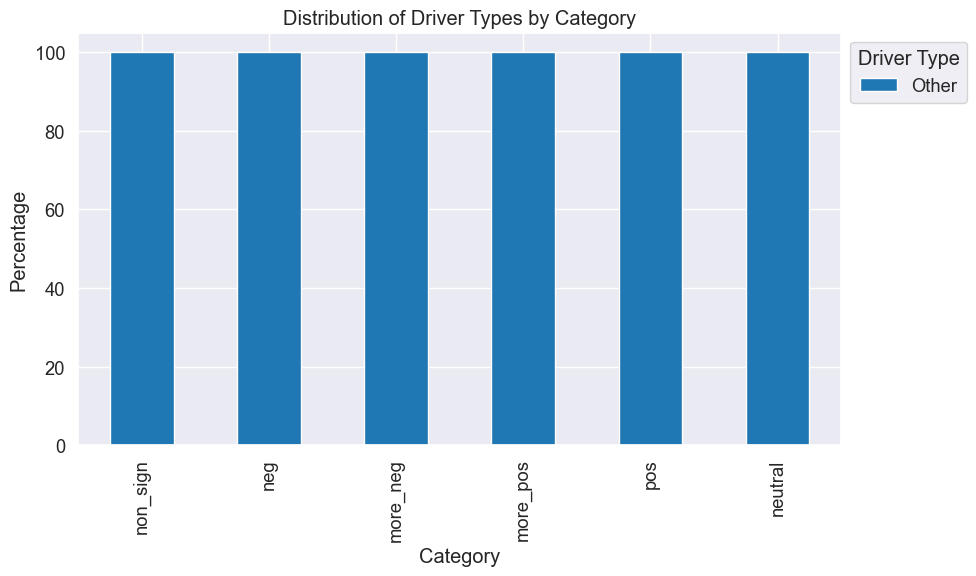

In [365]:
# Step 1: Classify drivers as Canonical, Candidate, or Other based on driver_stats
canonical = set(cancerdrivers[cancerdrivers['type'] == 'Canonical Cancer Driver']['symbol'].drop_duplicates())
candidate = set(cancerdrivers[cancerdrivers['type'] != 'Canonical Cancer Driver']['symbol'].drop_duplicates()) - canonical

# Step 2: Function to classify drivers
def classify_driver(driver):
    if driver in canonical:
        return 'Canonical'
    elif driver in candidate:
        return 'Candidate'
    else:
        return 'Other'

# Step 3: Add classification to driver_stats
driver_stats['driver_type'] = driver_stats.index.map(classify_driver)

# Step 4: Count drivers by category and type
category_counts = driver_stats.groupby(['group', 'driver_type']).size().unstack(fill_value=0)

# Step 5: Reorder categories based on category_order
category_counts = category_counts.reindex(category_order, axis=0)

# Step 6: Calculate percentages
category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

# Step 7: Display results
print("Driver counts by category:")
print(category_counts)
print("\nPercentage of drivers by category:")
print(category_percentages)

# Step 8: Totals for Canonical, Candidate, and Other
total_canonical = driver_stats['driver_type'].value_counts().get('Canonical', 0)
total_candidate = driver_stats['driver_type'].value_counts().get('Candidate', 0)
total_other = driver_stats['driver_type'].value_counts().get('Other', 0)

print(f"\nTotal Canonical Drivers: {total_canonical}")
print(f"Total Candidate Drivers: {total_candidate}")
print(f"Total Other Drivers: {total_other}")

# Step 9: Visualize with a stacked bar chart
category_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Distribution of Driver Types by Category')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.legend(title='Driver Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()


### All DINTs

In [157]:
# Step 1: Identify top and bottom 10 drivers by mutation frequency
driver_mutation_freq = final_df.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_10_drivers = driver_mutation_freq.head(10).index.tolist()
bottom_10_drivers = driver_mutation_freq.tail(10).index.tolist()

# Step 2: Find neighbors for these drivers
def get_neighbors(drivers, neighbourtab):
    neighbors = set()
    for driver in drivers:
        neighbors.update(neighbourtab.index[neighbourtab[driver]])
    return list(neighbors)

top_neighbors = get_neighbors(top_10_drivers, neighbourtab)
bottom_neighbors = get_neighbors(bottom_10_drivers, neighbourtab)

# Step 3: Extract expression data
top_expression = tumourexp.loc[:, top_neighbors]
bottom_expression = tumourexp.loc[:, bottom_neighbors]

""" # Step 4: Analyze and visualize
def plot_expression_heatmap(expression_data, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(expression_data.groupby('cancer_type').mean(), cmap='YlOrRd')
    plt.title(title)
    plt.show() """
""" 
plot_expression_heatmap(top_expression, "Expression of Neighbors for Top 10 Mutated Drivers")
plot_expression_heatmap(bottom_expression, "Expression of Neighbors for Bottom 10 Mutated Drivers") """

# Compare mean expression
top_mean = top_expression.mean()
bottom_mean = bottom_expression.mean()

print("Mean expression for neighbors of highly mutated drivers:")
print(top_mean.sort_values(ascending=False).head())
print("\nMean expression for neighbors of lowly mutated drivers:")
print(bottom_mean.sort_values(ascending=False).head())

# Statistical test
def compare_expressions(expr1, expr2):
    common_neighbors = set(expr1.columns) & set(expr2.columns) - {'cancer_type'}
    comp_results = []
    for neighbor in common_neighbors:
        u_stat, u_p_value = stats.mannwhitneyu(expr1[neighbor], expr2[neighbor], alternative='two-sided')
        comp_results.append({
            'Neighbor': neighbor,
            'U-statistic': u_stat,
            'p-value': u_p_value
        })
    return pd.DataFrame(comp_results).sort_values('p-value')

comparison_results = compare_expressions(top_expression, bottom_expression)
print("\nTop differentially expressed neighbors:")
print(comparison_results.head(10))

# Visualize top differential neighbors
""" def plot_top_differential(expr1, expr2, comparison_results, n=5):
    top_diff = comparison_results.head(n)['Neighbor']
    plt.figure(figsize=(15, 5*n))
    for i, neighbor in enumerate(top_diff, 1):
        plt.subplot(n, 1, i)
        sns.violinplot(x='cancer_type', y=neighbor, data=pd.concat([expr1, expr2]))
        plt.title(f"Expression of {neighbor}")
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_top_differential(top_expression, bottom_expression, comparison_results) """


Mean expression for neighbors of highly mutated drivers:
ACTB      16.533941
EEF1A1    16.198110
ACTG1     16.049729
GAPDH     15.945763
TPT1      15.629548
dtype: float64

Mean expression for neighbors of lowly mutated drivers:
ACTB      16.533941
UBC       15.030259
ENO1      14.675502
PABPC1    14.594079
CTSB      14.517812
dtype: float64

Top differentially expressed neighbors:
     Neighbor  U-statistic  p-value
0        CTSS   35313608.0      1.0
588  MARCKSL1   35313608.0      1.0
589     GNG10   35313608.0      1.0
590      RCN2   35313608.0      1.0
591     BCAR1   35313608.0      1.0
592    DHCR24   35313608.0      1.0
593    SNAP47   35313608.0      1.0
594     CHMP7   35313608.0      1.0
595     THADA   35313608.0      1.0
596   HNRNPA1   35313608.0      1.0


' def plot_top_differential(expr1, expr2, comparison_results, n=5):\n    top_diff = comparison_results.head(n)[\'Neighbor\']\n    plt.figure(figsize=(15, 5*n))\n    for i, neighbor in enumerate(top_diff, 1):\n        plt.subplot(n, 1, i)\n        sns.violinplot(x=\'cancer_type\', y=neighbor, data=pd.concat([expr1, expr2]))\n        plt.title(f"Expression of {neighbor}")\n        plt.xticks(rotation=90)\n    plt.tight_layout()\n    plt.show()\n\nplot_top_differential(top_expression, bottom_expression, comparison_results) '

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Step 1: Identify top and bottom 10 drivers by mutation frequency
driver_mutation_freq = significant_results_with_cancer_df.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_3_drivers = driver_mutation_freq.head(3).index.tolist()
bottom_3_drivers = driver_mutation_freq.tail(3).index.tolist()

# Step 2: Find neighbors for these drivers
def get_neighbors(drivers, neighbourtab):
    neighbors = set()
    for driver in drivers:
        neighbors.update(neighbourtab.index[neighbourtab[driver]])
    return list(neighbors)

top_neighbors = get_neighbors(top_3_drivers, neighbourtab)
bottom_neighbors = get_neighbors(bottom_3_drivers, neighbourtab)

# Step 3: Extract expression data
top_expression = tumourexp[top_neighbors]
bottom_expression = tumourexp[bottom_neighbors]
""" 
# Step 4: Analyze and visualize
def plot_expression_heatmap(expression_data, title):
    plt.figure(figsize=(12, 8))
    mean_expression = expression_data.groupby('cancer_type').mean()
    sns.heatmap(mean_expression, cmap='YlOrRd')
    plt.title(title)
    plt.show()
 """
""" plot_expression_heatmap(top_expression, "Expression of Neighbors for Top 3 Mutated Drivers")
plot_expression_heatmap(bottom_expression, "Expression of Neighbors for Bottom 3 Mutated Drivers")
 """
def separate_by_mutation_status(expression_data, driver, mutationtab):
    # Ensure the driver is in the mutationtab
    if driver not in mutationtab.columns:
        print(f"Warning: Driver {driver} not found in mutation data. Skipping...")
        return None, None

    # Merge expression data with mutation data
    merged_data = expression_data.merge(
        mutationtab[driver].rename(f"{driver}_mutation"),
        left_index=True, 
        right_index=True, 
        how='left'
    )
    
    # Separate based on mutation status
    expr_with_mutation = merged_data[merged_data[f"{driver}_mutation"] == 1].drop(columns=[f"{driver}_mutation"])
    expr_without_mutation = merged_data[merged_data[f"{driver}_mutation"] == 0].drop(columns=[f"{driver}_mutation"])

    return expr_with_mutation, expr_without_mutation

# Modify the analyze_driver_expression function to handle None returns
def analyze_driver_expression(drivers, neighbors, expression_data, mutationtab):
    for driver in drivers:
        expr_with_mutation, expr_without_mutation = separate_by_mutation_status(expression_data[neighbors], driver, mutationtab)
        
        if expr_with_mutation is None or expr_without_mutation is None:
            continue
        
        # Plot heatmaps
        #plot_expression_heatmap(expr_with_mutation, f"Expression of Neighbors for Driver {driver} (With Mutation)")
        #plot_expression_heatmap(expr_without_mutation, f"Expression of Neighbors for Driver {driver} (Without Mutation)")
        
        # Compare mean expression
        with_mean = expr_with_mutation.groupby('cancer_type').mean().mean()
        without_mean = expr_without_mutation.groupby('cancer_type').mean().mean()
        
        print(f"Mean expression for neighbors of driver {driver} (With Mutation):")
        print(with_mean.sort_values(ascending=False).head())
        print(f"\nMean expression for neighbors of driver {driver} (Without Mutation):")
        print(without_mean.sort_values(ascending=False).head())
        
        # Statistical test
        comparison_results = compare_expressions(expr_with_mutation, expr_without_mutation)
        print(f"\nTop differentially expressed neighbors for driver {driver}:")
        print(comparison_results.head(10))
        
        # Visualize top differential neighbors
        #plot_top_differential(expr_with_mutation, expr_without_mutation, comparison_results)

# Helper functions
def compare_expressions(expr1, expr2):
    common_neighbors = set(expr1.columns) & set(expr2.columns)
    results = []
    for neighbor in common_neighbors:
        u_stat, p_value_u = stats.mannwhitneyu(expr1[neighbor], expr2[neighbor], alternative='two-sided')
        results.append({'Neighbor': neighbor, 'U-statistic': u_stat, 'p-value': p_value_u})
    return pd.DataFrame(results).sort_values('p-value')
""" 
def plot_top_differential(expr1, expr2, comparison_results, n=5):
    top_diff = comparison_results.head(n)['Neighbor']
    plt.figure(figsize=(15, 5*n))
    for i, neighbor in enumerate(top_diff, 1):
        plt.subplot(n, 1, i)
        combined_data = pd.concat([expr1[[neighbor]], expr2[[neighbor]]])
        sns.violinplot(x='cancer_type', y=neighbor, data=combined_data.reset_index())
        plt.title(f"Expression of {neighbor}")
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
 """
# Run the analysis with the corrected functions
print("Analyzing top drivers:")
analyze_driver_expression(top_3_drivers, top_neighbors, tumourexp, mutationtab)

print("\nAnalyzing bottom drivers:")
analyze_driver_expression(bottom_3_drivers, bottom_neighbors, tumourexp, mutationtab)

Analyzing top drivers:
Mean expression for neighbors of driver TP53 (With Mutation):
ACTB      16.622040
EEF1A1    16.189148
GAPDH     16.151735
ACTG1     16.045623
EEF2      15.581083
dtype: float64

Mean expression for neighbors of driver TP53 (Without Mutation):
ACTB      16.569557
EEF1A1    16.306500
ACTG1     16.121670
GAPDH     16.072009
EEF2      15.746612
dtype: float64

Top differentially expressed neighbors for driver TP53:
     Neighbor  U-statistic        p-value
1001      XPC    3850141.5   0.000000e+00
2838    CIRBP    4091274.5   0.000000e+00
1779   FAM83D   12250435.5   0.000000e+00
1925   RPS27L    3502009.0   0.000000e+00
1274     ANLN   12378503.0   0.000000e+00
2581   CKAP2L   12196442.0  8.616945e-306
1504     PLK1   12172631.5  3.429871e-302
2970      TTK   12154632.0  1.748116e-299
36      PRR11   12137942.5  5.488826e-297
740     KPNA4   12117912.0  5.228578e-294
Mean expression for neighbors of driver PTEN (With Mutation):
ACTB      16.686528
GAPDH     16.27526

Driver ACKR3 not found in mutation or expression data. Skipping...
Driver AGO4 not found in mutation or expression data. Skipping...
Driver AJUBA not found in mutation or expression data. Skipping...
Driver AMER1 not found in mutation or expression data. Skipping...
Driver APMAP not found in mutation or expression data. Skipping...
Driver APOBR not found in mutation or expression data. Skipping...
Driver ARHGAP35 not found in mutation or expression data. Skipping...
Driver ATG14 not found in mutation or expression data. Skipping...
Driver BPIFB1 not found in mutation or expression data. Skipping...
Driver BRINP3 not found in mutation or expression data. Skipping...
Driver C2CD5 not found in mutation or expression data. Skipping...
Driver CCDC168 not found in mutation or expression data. Skipping...
Driver CCP110 not found in mutation or expression data. Skipping...
Driver CMTR1 not found in mutation or expression data. Skipping...
Driver CNTRL not found in mutation or expression data. 

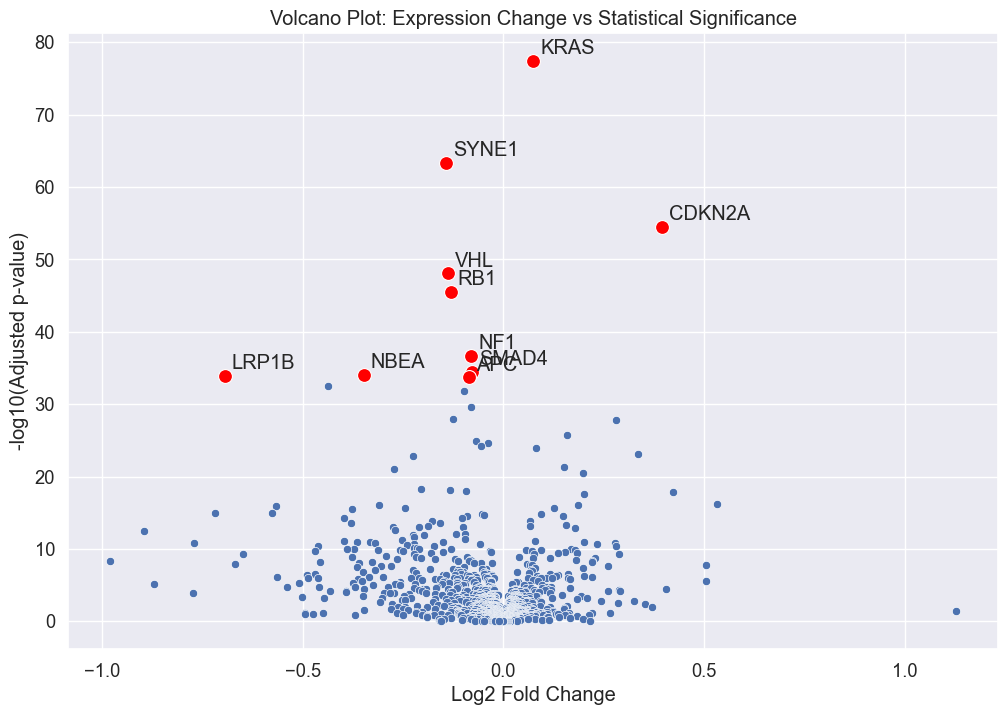

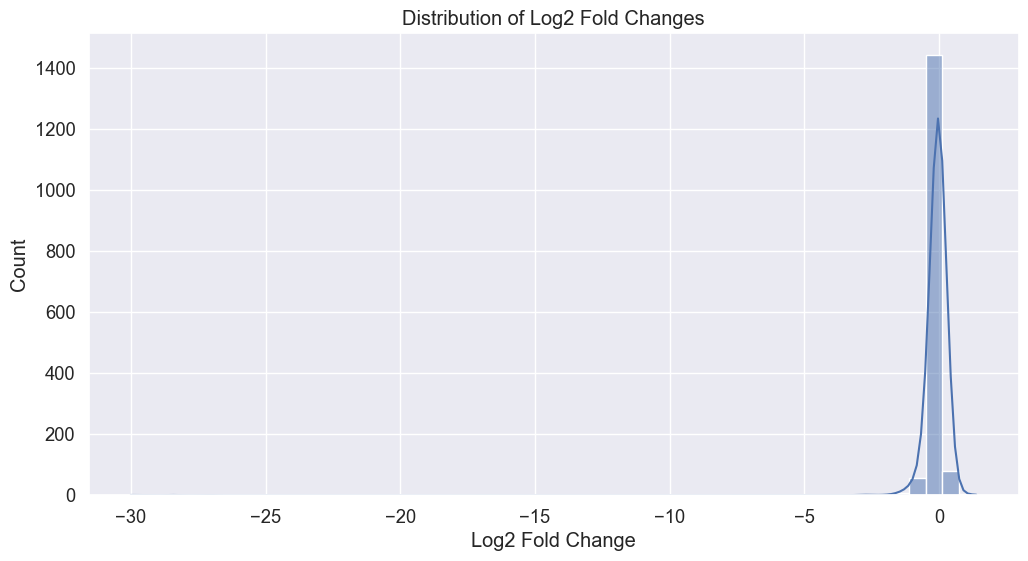

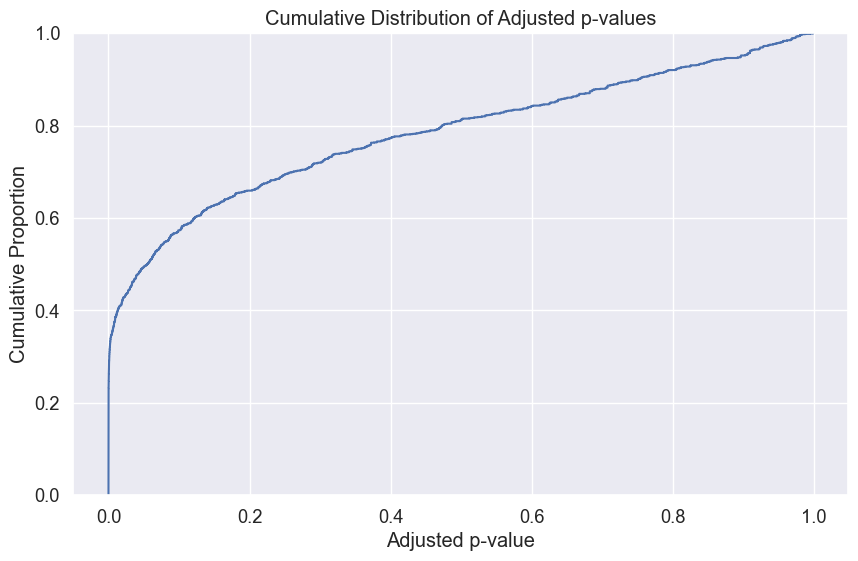

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def get_unique_drivers(filtered_results):
    return filtered_results['driver'].unique()

def analyze_driver_expression(driver, mutationtab, tumourexp):
    mutation_status = mutationtab[driver]
    expression = tumourexp[driver]
    
    combined_data = pd.DataFrame({'mutation': mutation_status, 'expression': expression})
    
    mutated_expr = combined_data[combined_data['mutation'] == 1]['expression']
    non_mutated_expr = combined_data[combined_data['mutation'] == 0]['expression']
    
    mean_expr_mutated = mutated_expr.mean()
    mean_expr_non_mutated = non_mutated_expr.mean()
    
    # Calcular log2 fold change com um pequeno epsilon para evitar divisão por zero
    epsilon = 1e-10
    log2_fold_change = np.log2((mean_expr_mutated + epsilon) / (mean_expr_non_mutated + epsilon))
    
    # Realizar o teste de Mann-Whitney apenas se houver amostras suficientes em ambos os grupos
    if len(mutated_expr) > 0 and len(non_mutated_expr) > 0:
        statistic, p_value = stats.mannwhitneyu(mutated_expr, non_mutated_expr, alternative='two-sided')
    else:
        statistic, p_value = np.nan, np.nan
    
    return {
        'driver': driver,
        'mean_expr_mutated': mean_expr_mutated,
        'mean_expr_non_mutated': mean_expr_non_mutated,
        'mann_whitney_statistic': statistic,
        'p_value': p_value,
        'log2_fold_change': log2_fold_change
    }
def benjamini_hochberg_correction(p_values):
    p_values = np.array(p_values)
    n = len(p_values)
    print(f"Number of p-values: {n}")
    print(f"Original p-values: {p_values}")

    # Remove NaN values
    valid_mask = ~np.isnan(p_values)
    valid_p_values = p_values[valid_mask]
    m = len(valid_p_values)
    print(f"Number of valid p-values: {m}")

    if m == 0:
        return np.full_like(p_values, np.nan)

    # Sort p-values
    sorted_indices = np.argsort(valid_p_values)
    sorted_p_values = valid_p_values[sorted_indices]
    print(f"Sorted p-values: {sorted_p_values}")

    # Calculate adjusted p-values
    adjusted_p_values = np.zeros(m)
    for i in range(m):
        rank = i + 1
        adjusted_p_values[i] = min(sorted_p_values[i] * m / rank, 1.0)

    # Ensure monotonicity
    for i in range(m-2, -1, -1):
        adjusted_p_values[i] = min(adjusted_p_values[i], adjusted_p_values[i+1])

    print(f"Adjusted p-values (sorted): {adjusted_p_values}")

    # Reorder to match original input
    reordered_adjusted_p_values = np.zeros(m)
    reordered_adjusted_p_values[sorted_indices] = adjusted_p_values

    # Reinsert NaN values
    final_adjusted_p_values = np.full(n, np.nan)
    final_adjusted_p_values[valid_mask] = reordered_adjusted_p_values
    
    print(f"Final adjusted p-values: {final_adjusted_p_values}")

    return final_adjusted_p_values
# As funções get_unique_drivers, analyze_driver_expression e benjamini_hochberg_correction permanecem as mesmas

def main_analysis(drivers, mutationtab, tumourexp):
    main_results = []
    
    for driver in drivers:
        if driver in mutationtab.columns and driver in tumourexp.columns:
            result = analyze_driver_expression(driver, mutationtab, driver_tumour_expression)
            main_results.append(result)
        else:
            print(f"Driver {driver} not found in mutation or expression data. Skipping...")
    
    results_df = pd.DataFrame(main_results)
    results_df['adj_p_value'] = benjamini_hochberg_correction(results_df['p_value'])
    
    # Criar a coluna -log10(adj_p_value) explicitamente
    results_df['-log10(adj_p_value)'] = -np.log10(results_df['adj_p_value'])
    
    results_df = results_df.sort_values('adj_p_value')
    
    # Print summary statistics
    print("Summary of results:")
    print(results_df.describe())
    
    # Print top 20 most significant drivers
    print("\nTop 20 most significant drivers:")
    print(results_df.head(20))
    
    # Volcano plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='log2_fold_change', y='-log10(adj_p_value)', data=results_df)
    plt.title('Volcano Plot: Expression Change vs Statistical Significance')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')
    
    # Highlight top 10 most significant points
    top_10 = results_df.nlargest(10, '-log10(adj_p_value)')
    sns.scatterplot(x='log2_fold_change', y='-log10(adj_p_value)', 
                    data=top_10, color='red', s=100)
    
    for idx, row in top_10.iterrows():
        plt.annotate(row['driver'], 
                     (row['log2_fold_change'], row['-log10(adj_p_value)']),
                     xytext=(5, 5), textcoords='offset points')
    plt.show()

    # Histogram of log2 fold changes
    plt.figure(figsize=(12, 6))
    sns.histplot(results_df['log2_fold_change'], bins=50, kde=True)
    plt.title('Distribution of Log2 Fold Changes')
    plt.xlabel('Log2 Fold Change')
    plt.show()

    # Cumulative distribution of p-values
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(results_df['adj_p_value'])
    plt.title('Cumulative Distribution of Adjusted p-values')
    plt.xlabel('Adjusted p-value')
    plt.ylabel('Cumulative Proportion')
    plt.show()

main_analysis(significant_drivers, mutationtab, driver_tumour_expression)

      driver  category  mean_expression_mutated  mean_expression_non_mutated  \
0       A1CF  non_sign                 1.364054                     1.733682   
1      A2ML1  more_pos                 3.792646                     3.984380   
2     ABCA10  non_sign                 3.434216                     3.776301   
3     ABCA13  more_pos                 4.416936                     4.238564   
4      ABCA7  non_sign                 8.592880                     8.488046   
...      ...       ...                      ...                          ...   
2462  ZSWIM3  non_sign                 6.757654                     6.826901   
2463  ZSWIM6  non_sign                 8.376133                     8.574214   
2464  ZWILCH  non_sign                 8.974727                     8.440610   
2465   ZWINT       pos                 9.697200                     8.939950   
2466   ZZEF1  more_pos                10.118257                    10.136499   

      mann_whitney_statistic   p_value 

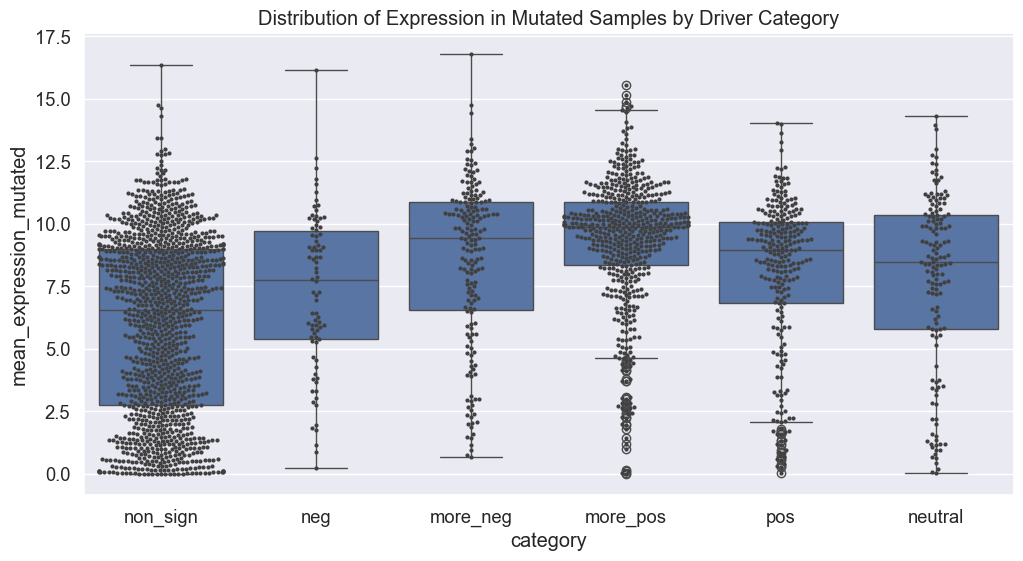

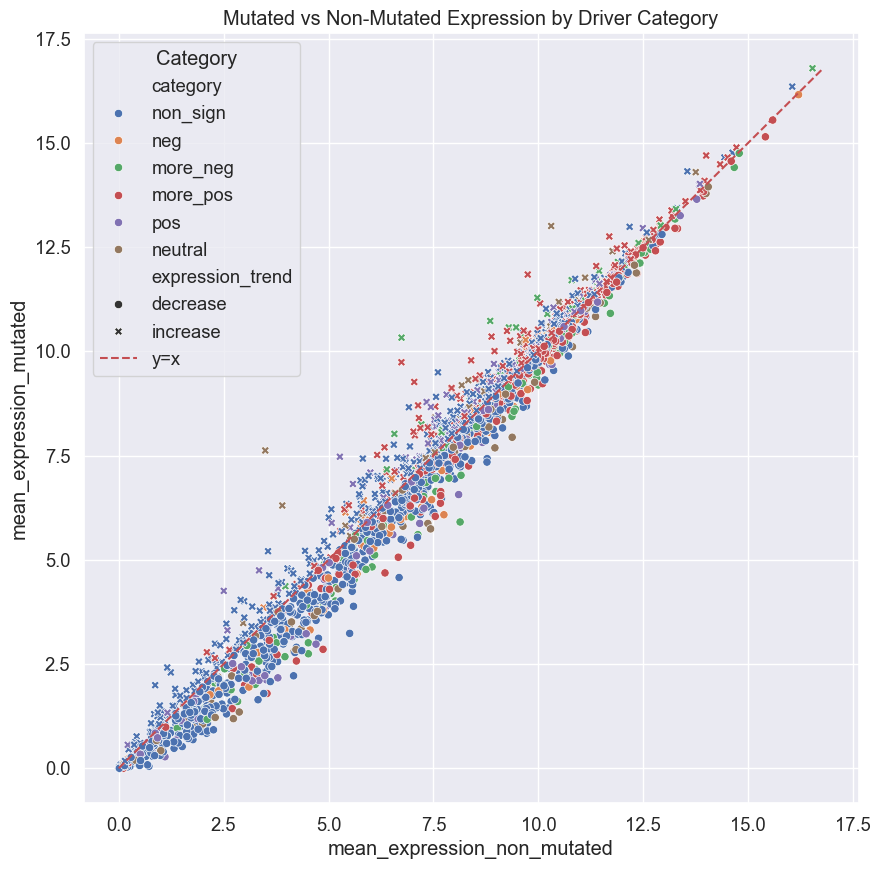


Proportion of expression trends by category:
expression_trend  decrease  increase
category                            
more_neg          0.701087  0.298913
more_pos          0.550179  0.449821
neg               0.658537  0.341463
neutral           0.621622  0.378378
non_sign          0.638281  0.361719
pos               0.519084  0.480916


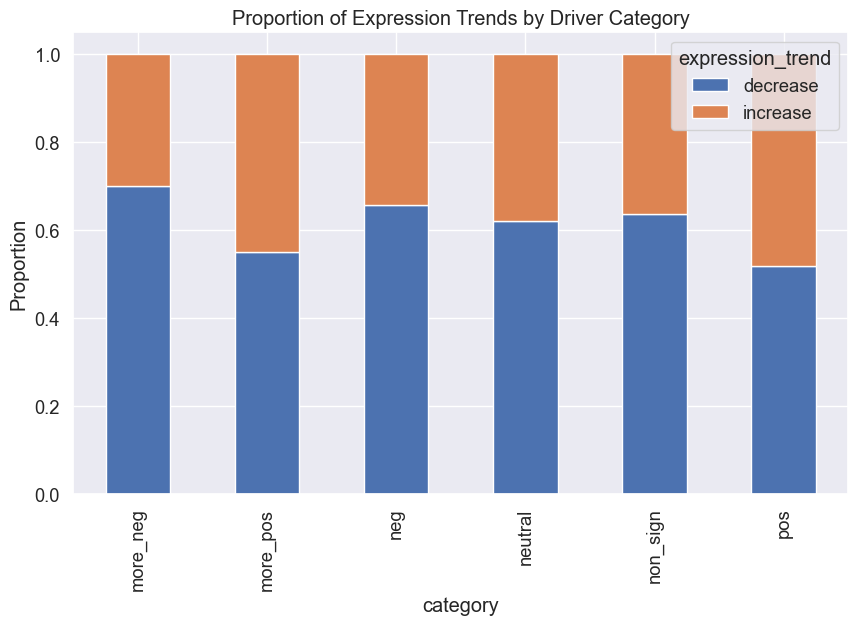


Statistical comparisons between categories:
non_sign vs pos: statistic = 132613.0000, p-value = 0.0000
neg vs non_sign: statistic = 45323.0000, p-value = 0.1163
neg vs pos: statistic = 7917.0000, p-value = 0.0003
neg vs neutral: statistic = 5408.0000, p-value = 0.1724
more_neg vs non_sign: statistic = 105164.0000, p-value = 0.1101
more_neg vs neg: statistic = 7758.0000, p-value = 0.7125
more_neg vs more_pos: statistic = 39120.0000, p-value = 0.0000
more_neg vs pos: statistic = 17921.0000, p-value = 0.0000
more_neg vs neutral: statistic = 12567.0000, p-value = 0.2278
more_pos vs non_sign: statistic = 398194.0000, p-value = 0.0000
more_pos vs neg: statistic = 28603.0000, p-value = 0.0003
more_pos vs pos: statistic = 70393.0000, p-value = 0.3925
more_pos vs neutral: statistic = 47293.0000, p-value = 0.0065
neutral vs non_sign: statistic = 91987.0000, p-value = 0.8710
neutral vs pos: statistic = 16129.0000, p-value = 0.0047

Non-significant (Category non_sign):
      driver  category  mea

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Function to analyze driver expression
def analyze_driver_expression(driver, mutationtab, driver_tumour_expression):
    if driver not in mutationtab.columns or driver not in driver_tumour_expression.columns:
        # Skip drivers that are missing in either dataset
        return None
    
    mutated_individuals = mutationtab[mutationtab[driver] == 1].index
    non_mutated_individuals = mutationtab[mutationtab[driver] == 0].index
    
    exp_mutated = driver_tumour_expression.loc[mutated_individuals, driver]
    exp_non_mutated = driver_tumour_expression.loc[non_mutated_individuals, driver]
    
    if not exp_mutated.empty and not exp_non_mutated.empty:
        statistic, p_value = stats.mannwhitneyu(exp_mutated, exp_non_mutated, alternative='two-sided')
        mean_mutated = exp_mutated.mean()
        mean_non_mutated = exp_non_mutated.mean()
        
        # Ensure correct access to the 'group' (category) column in driver_stats
        category = driver_stats.loc[driver_stats['driver'] == driver, 'group'].values[0]
        
        expression_trend = 'increase' if mean_mutated > mean_non_mutated else 'decrease' if mean_mutated < mean_non_mutated else 'no change'
        
        return {
            'driver': driver,
            'category': category,  # Use the correct driver group
            'mean_expression_mutated': mean_mutated,
            'mean_expression_non_mutated': mean_non_mutated,
            'mann_whitney_statistic': statistic,
            'p_value': p_value,
            'expression_trend': expression_trend
        }
    return None

# Function to compare categories
def compare_categories(cat1, cat2, results_df):
    group1 = results_df[results_df['category'] == cat1]['mean_expression_mutated'] - \
             results_df[results_df['category'] == cat1]['mean_expression_non_mutated']
    group2 = results_df[results_df['category'] == cat2]['mean_expression_mutated'] - \
             results_df[results_df['category'] == cat2]['mean_expression_non_mutated']
    statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    return f"{cat1} vs {cat2}: statistic = {statistic:.4f}, p-value = {p_value:.4f}"

driver_stats_all = drivers[['driver', 'n_neighbours', 'pos_dints', 'neg_dints', 'pos_pct', 'neg_pct', 'group']].copy()

# Filter only drivers that exist in both mutationtab and driver_tumour_expression
common_drivers_all = driver_stats_all['driver'][driver_stats_all['driver'].isin(mutationtab.columns) & driver_stats_all['driver'].isin(driver_tumour_expression.columns)]

# Apply expression analysis to filtered common drivers
exp_results = [analyze_driver_expression(driver, mutationtab, driver_tumour_expression) for driver in common_drivers_all]
results_df_all = pd.DataFrame([r for r in exp_results if r is not None])

# 2. Analysis and visualizations
print(results_df_all)

category_summary = results_df_all.groupby('category').agg({
    'mean_expression_mutated': ['mean', 'std'],
    'mean_expression_non_mutated': ['mean', 'std'],
    'p_value': ['mean', 'median'],
    'driver': 'count'
}).rename(columns={'driver': 'count'})

print("\nStatistical summary by category:")
print(category_summary)

# Set category order as per the requested order: non_sign, neg, more_neg, more_pos, pos, neutral
category_order = ['non_sign', 'neg', 'more_neg', 'neutral', 'more_pos', 'pos']

# Boxplot and Swarmplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='mean_expression_mutated', data=results_df_all, order=category_order)
sns.swarmplot(x='category', y='mean_expression_mutated', data=results_df_all, color=".25", size=3, order=category_order)
plt.title('Distribution of Expression in Mutated Samples by Driver Category')
plt.show()

# Scatterplot of Mutated vs Non-Mutated Expression
plt.figure(figsize=(10, 10))
sns.scatterplot(x='mean_expression_non_mutated', y='mean_expression_mutated', 
                hue='category', style='expression_trend', data=results_df_all, hue_order=category_order)
plt.plot([0, results_df_all['mean_expression_mutated'].max()], 
         [0, results_df_all['mean_expression_mutated'].max()], 
         'r--', label='y=x')
plt.title('Mutated vs Non-Mutated Expression by Driver Category')
plt.legend(title='Category')
plt.show()

# Proportion of Expression Trends by Category
expression_trends = results_df_all.groupby('category')['expression_trend'].value_counts(normalize=True).unstack()
print("\nProportion of expression trends by category:")
print(expression_trends)

# Plotting the bar plot without the 'order' argument
expression_trends.plot(kind='bar', stacked=True, figsize=(10, 6))  # Removed 'order'
plt.title('Proportion of Expression Trends by Driver Category')
plt.ylabel('Proportion')
plt.show()

# Statistical comparisons between categories
print("\nStatistical comparisons between categories:")
for cat1 in category_order:
    for cat2 in category_order:
        if cat1 < cat2:
            print(compare_categories(cat1, cat2, results_df_all))

# Output detailed results by category
expected_categories = {
    'non_sign': 'Non-significant',
    'neg': 'Y-axis (Only negative neighbours)',
    'more_neg': 'Above y=x (More negative than positive neighbours)',
    'more_pos': 'Below y=x (More positive than negative neighbours)',
    'pos': 'X-axis (Only positive neighbours)',
    'neutral': 'Equal number of positive and negative neighbours'
}

for category, description in expected_categories.items():
    print(f"\n{description} (Category {category}):")
    category_df = results_df_all[results_df_all['category'] == category]
    print(category_df)


In [165]:
# Count the number of drivers in each category
driver_counts = driver_stats_all['group'].value_counts()

print("Number of drivers in each category:")
print(driver_counts)


""" Número de drivers em cada categoria:
category
N_Sig       1336
More_Pos     555
More_Neg     292
Pos          287
Neg           77
Name: count, dtype: int64
 """

""" Número de drivers em cada categoria:
category
N_Sig       884
More_Pos    576
Pos         489
More_Neg    336
Neg         254
Name: count, dtype: int64
 """

Number of drivers in each category:
group
non_sign    910
more_pos    576
pos         489
neg         254
more_neg    185
neutral     151
Name: count, dtype: int64


' Número de drivers em cada categoria:\ncategory\nN_Sig       884\nMore_Pos    576\nPos         489\nMore_Neg    336\nNeg         254\nName: count, dtype: int64\n '

In [166]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(results_df_all['category'], results_df_all['expression_trend'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of Freedom: {dof}")

print("\nContingency Table:")
print(contingency_table)

print("\nExpected Values:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))



Chi-Square Test Results:
Chi-Square Statistic: 28.9563
P-value: 2.37e-05
Degrees of Freedom: 5

Contingency Table:
expression_trend  decrease  increase
category                            
more_neg               129        55
more_pos               307       251
neg                     54        28
neutral                 92        56
non_sign               787       446
pos                    136       126

Expected Values:
expression_trend    decrease    increase
category                                
more_neg          112.249696   71.750304
more_pos          340.409404  217.590596
neg                50.024321   31.975679
neutral            90.287799   57.712201
non_sign          752.194974  480.805026
pos               159.833806  102.166194


In [167]:
# Count the number of drivers for each category and expression trend
expression_trend_counts = results_df_all.groupby(['category', 'expression_trend']).size().unstack(fill_value=0)

print("\nCount of drivers by category and expression trend:")
print(expression_trend_counts) 



Count of drivers by category and expression trend:
expression_trend  decrease  increase
category                            
more_neg               129        55
more_pos               307       251
neg                     54        28
neutral                 92        56
non_sign               787       446
pos                    136       126


In [168]:
# Step 1: Ensure mutation_frequency is not NaN and matches with drivers in driver_stats
mutation_frequency = mutationtab.mean()

# Step 2: Calculate expression change for each driver
def calculate_expression_change(row):
    if pd.notna(row['mean_expression_mutated']) and pd.notna(row['mean_expression_non_mutated']):
        return row['mean_expression_mutated'] - row['mean_expression_non_mutated']
    return np.nan

# Apply expression change calculation to results_df
results_df_all['expression_change'] = results_df_all.apply(calculate_expression_change, axis=1)

# Step 3: Ensure proper merging by aligning indices (reset index if necessary)
# Ensure that driver_info has the same index and 'driver' column
driver_info_all = driver_stats_all.set_index('driver').join(results_df_all.set_index('driver')[['expression_change']], how='left')

# Merge mutation_frequency based on driver index
driver_info_all = driver_info_all.join(mutation_frequency.rename('mutation_frequency'), how='left')

# Step 4: Filter out rows with all NaN values in both expression_change and mutation_frequency
driver_info_all = driver_info_all.dropna(subset=['expression_change', 'mutation_frequency'], how='all')

print(driver_info_all)


        n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group  \
driver                                                                     
A1CF              39          0          0  0.000000  0.000000  non_sign   
A2ML1             91          4          3  0.043956  0.032967  more_pos   
ABCA10             5          0          0  0.000000  0.000000  non_sign   
ABCA13             9          3          1  0.333333  0.111111  more_pos   
ABCA7             16          0          0  0.000000  0.000000  non_sign   
...              ...        ...        ...       ...       ...       ...   
ZSWIM3             6          0          0  0.000000  0.000000  non_sign   
ZSWIM6            22          0          0  0.000000  0.000000  non_sign   
ZWILCH            22          1          0  0.045455  0.000000       pos   
ZWINT            136         22          0  0.161765  0.000000       pos   
ZZEF1             89          8          2  0.089888  0.022472  more_pos   

        exp

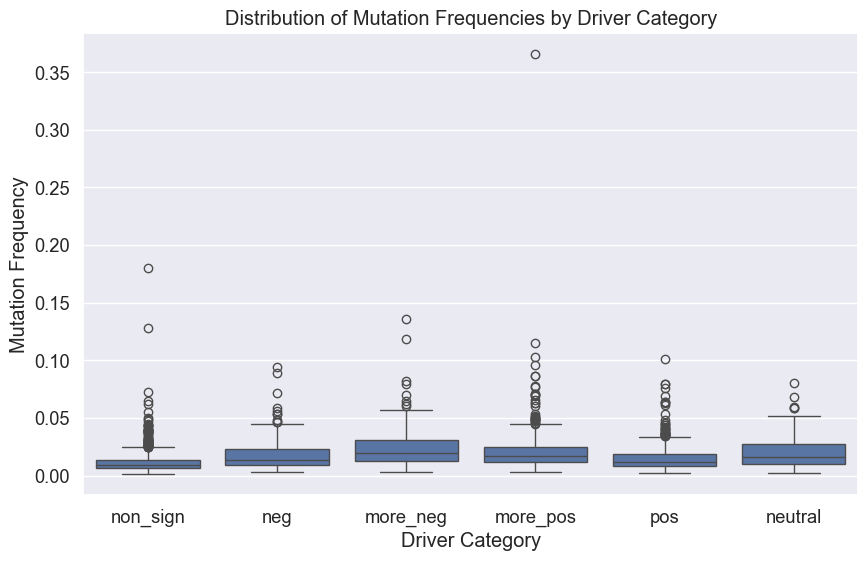

In [169]:
# Step 4: Visualize mutation frequency by category

# Remove rows with NaN mutation frequencies
filtered_driver_info_all = driver_info_all.dropna(subset=['mutation_frequency'])

# Update the category order to only include categories present in the filtered data
present_categories = filtered_driver_info_all['group'].unique()
category_order_present = [cat for cat in category_order if cat in present_categories]

plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info_all, order=category_order_present)
plt.title('Distribution of Mutation Frequencies by Driver Category')
plt.xlabel('Driver Category')
plt.ylabel('Mutation Frequency')
plt.show()


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/2372894730.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info_all, order=category_order_present, palette='Set2')


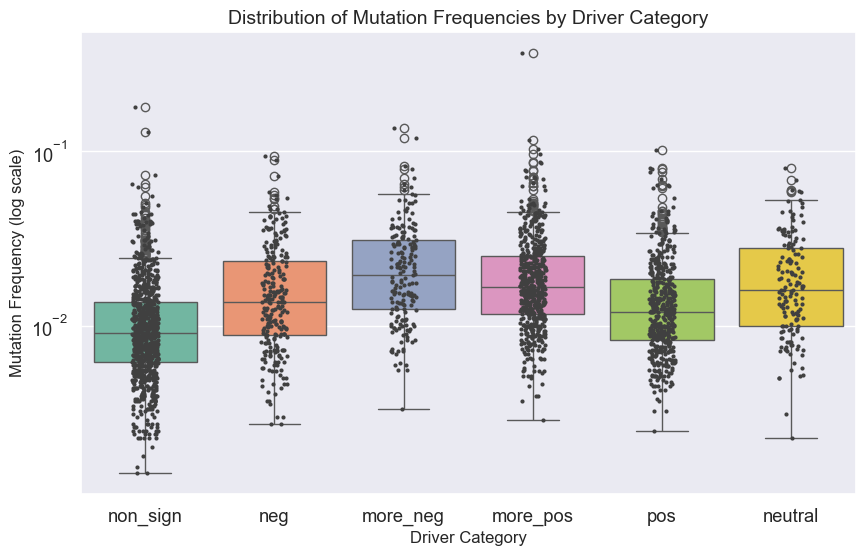

          count      mean       std       min       25%       50%       75%  \
group                                                                         
more_neg  185.0  0.024277  0.018280  0.003332  0.012375  0.019396  0.030819   
more_pos  576.0  0.021129  0.020125  0.002856  0.011661  0.016718  0.024988   
neg       254.0  0.017922  0.013755  0.002737  0.008805  0.013684  0.023411   
neutral   151.0  0.020413  0.014182  0.002261  0.009876  0.015945  0.027784   
non_sign  910.0  0.011651  0.010781  0.001428  0.006188  0.009103  0.013565   
pos       489.0  0.015337  0.011838  0.002499  0.008210  0.012018  0.018563   

               max  
group               
more_neg  0.136245  
more_pos  0.365778  
neg       0.094241  
neutral   0.079962  
non_sign  0.179914  
pos       0.101499  


In [170]:
plt.figure(figsize=(10, 6))

# Boxplot with a color palette
sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info_all, order=category_order_present, palette='Set2')

# Overlay swarmplot for individual data points
#sns.swarmplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, color=".25", size=3)
sns.stripplot(x='group', y='mutation_frequency', data=filtered_driver_info_all, order=category_order_present, color=".25", size=3)

# Apply log scale to Y-axis to better visualize the smaller frequencies
plt.yscale('log')

# Add titles and labels
plt.title('Distribution of Mutation Frequencies by Driver Category', fontsize=14)
plt.xlabel('Driver Category', fontsize=12)
plt.ylabel('Mutation Frequency (log scale)', fontsize=12)

# Show the plot
plt.show()

# Print summary statistics
summary_stats = filtered_driver_info_all.groupby('group')['mutation_frequency'].describe()
print(summary_stats)



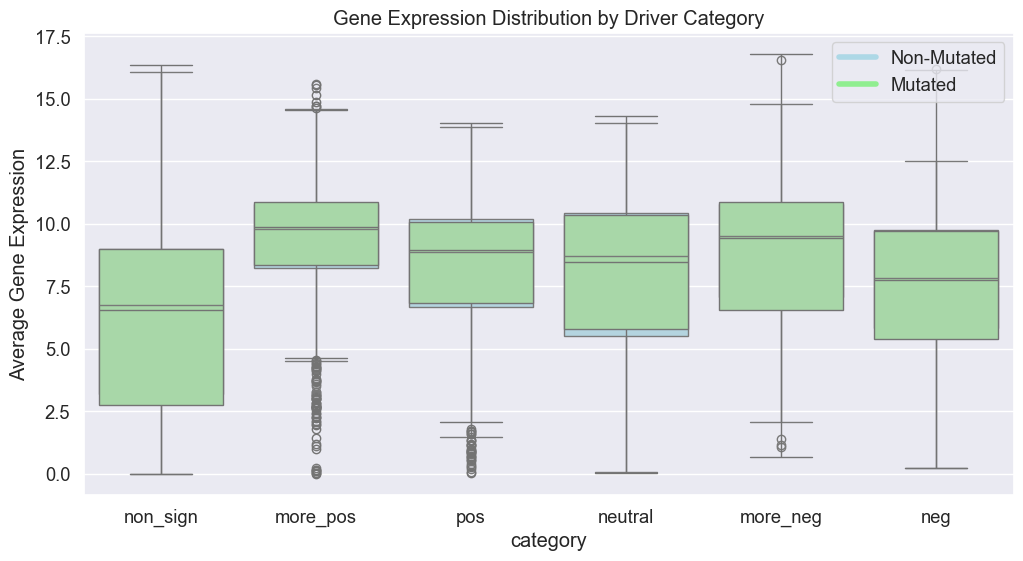

In [171]:
# Step 3: Visualizing gene expression distribution by category
plt.figure(figsize=(12, 6))

# Plot for non-mutated expression
sns.boxplot(x='category', y='mean_expression_non_mutated', data=results_df_all[results_df_all['category'].isin(category_order)], color='lightblue')
# Plot for mutated expression
sns.boxplot(x='category', y='mean_expression_mutated', data=results_df_all[results_df_all['category'].isin(category_order)], color='lightgreen', saturation=0.5)

plt.title('Gene Expression Distribution by Driver Category')
plt.ylabel('Average Gene Expression')

# Create custom legend
handles = [
    plt.Line2D([0], [0], color='lightblue', lw=4),
    plt.Line2D([0], [0], color='lightgreen', lw=4)
]
plt.legend(handles, ['Non-Mutated', 'Mutated'], loc='upper right')

plt.show()

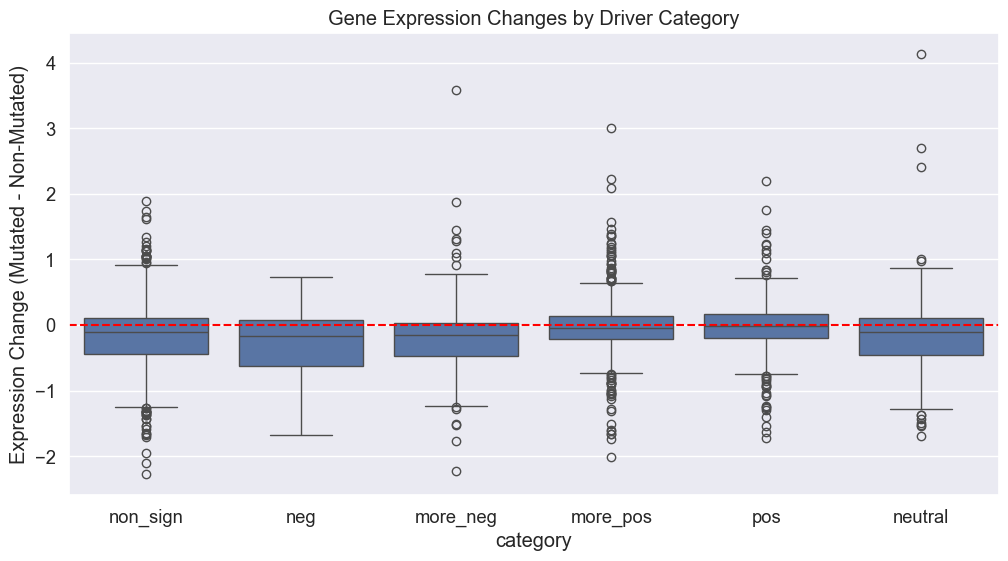

In [172]:
# Step 5: Visualize expression changes by category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='expression_change', data=results_df_all, order=category_order)
plt.title('Gene Expression Changes by Driver Category')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Expression Change (Mutated - Non-Mutated)')
plt.show()


In [173]:
# Step 6: Perform statistical comparisons for mutation frequencies
p_values = []
comparison_results = []
categories = driver_info_all['group'].unique()

# Pairwise comparison for mutation frequencies across categories
for cat1 in categories:
    for cat2 in categories:
        if cat1 < cat2:
            group1 = driver_info_all[driver_info_all['group'] == cat1]['mutation_frequency']
            group2 = driver_info_all[driver_info_all['group'] == cat2]['mutation_frequency']
            statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            p_values.append(p_value)
            comparison_results.append({'category1': cat1, 'category2': cat2, 'statistic': statistic, 'p_value': p_value})

# Apply Benjamini-Hochberg correction
corrected_p_values = benjamini_hochberg_correction(p_values)

# Add adjusted p-values to the comparison results
for i, result in enumerate(comparison_results):
    result['adjusted_p_value'] = corrected_p_values[i]

comparison_df_all = pd.DataFrame(comparison_results)
print(comparison_df_all)



Number of p-values: 15
Original p-values: [4.22383433e-16 1.43058634e-68 1.68723942e-18 4.10868093e-01
 4.16879468e-05 4.78004632e-20 5.91055189e-06 7.73856117e-37
 1.89752299e-02 3.58104520e-15 2.29722210e-02 1.79452463e-06
 1.02835035e-16 1.59467231e-02 3.05688400e-02]
Number of valid p-values: 15
Sorted p-values: [1.43058634e-68 7.73856117e-37 4.78004632e-20 1.68723942e-18
 1.02835035e-16 4.22383433e-16 3.58104520e-15 1.79452463e-06
 5.91055189e-06 4.16879468e-05 1.59467231e-02 1.89752299e-02
 2.29722210e-02 3.05688400e-02 4.10868093e-01]
Adjusted p-values (sorted): [2.14587951e-67 5.80392087e-36 2.39002316e-19 6.32714783e-18
 3.08505104e-16 1.05595858e-15 7.67366829e-15 3.36473368e-06
 9.85091981e-06 6.25319202e-05 2.17455315e-02 2.37190374e-02
 2.65064089e-02 3.27523285e-02 4.10868093e-01]
Final adjusted p-values: [1.05595858e-15 2.14587951e-67 6.32714783e-18 4.10868093e-01
 6.25319202e-05 2.39002316e-19 9.85091981e-06 5.80392087e-36
 2.37190374e-02 7.67366829e-15 2.65064089e-02 3

In [174]:
# Step 7: Perform Mann-Whitney U test for expression changes across categories
for category in present_categories:
    category_data = results_df_all[results_df_all['category'] == category]
    if len(category_data) > 1:
        statistic, p_value = stats.mannwhitneyu(category_data['mean_expression_mutated'], 
                                                category_data['mean_expression_non_mutated'], alternative='two-sided')
        print(f"\nCategoria {category}:")
        print(f"Teste de Mann-Whitney U: estatística = {statistic:.4f}, p-valor = {p_value:.4e}")

# Step 8: Perform Kruskal-Wallis test to compare expression change across categories
category_groups = [group['expression_change'].dropna() for name, group in results_df_all.groupby('category') if name in present_categories]
kruskal_statistic, kruskal_p_value = stats.kruskal(*category_groups)

print("\nKruskal-Wallis test para comparar a mudança na expressão entre categorias:")
print(f"Kruskal-Wallis estatística: {kruskal_statistic:.4f}")
print(f"p-valor: {kruskal_p_value:.4e}")



Categoria non_sign:
Teste de Mann-Whitney U: estatística = 740041.0000, p-valor = 2.5549e-01

Categoria more_pos:
Teste de Mann-Whitney U: estatística = 156128.0000, p-valor = 9.3405e-01

Categoria pos:
Teste de Mann-Whitney U: estatística = 34426.0000, p-valor = 9.5238e-01

Categoria neutral:
Teste de Mann-Whitney U: estatística = 10755.0000, p-valor = 7.8956e-01

Categoria more_neg:
Teste de Mann-Whitney U: estatística = 16621.0000, p-valor = 7.6388e-01

Categoria neg:
Teste de Mann-Whitney U: estatística = 3185.0000, p-valor = 5.6160e-01

Kruskal-Wallis test para comparar a mudança na expressão entre categorias:
Kruskal-Wallis estatística: 56.3701
p-valor: 6.8184e-11


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/809199625.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_results['abs_corr'] = significant_results['correlation'].abs()
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/809199625.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=significant_results, x='gene', y='correlation', palette='coolwarm')


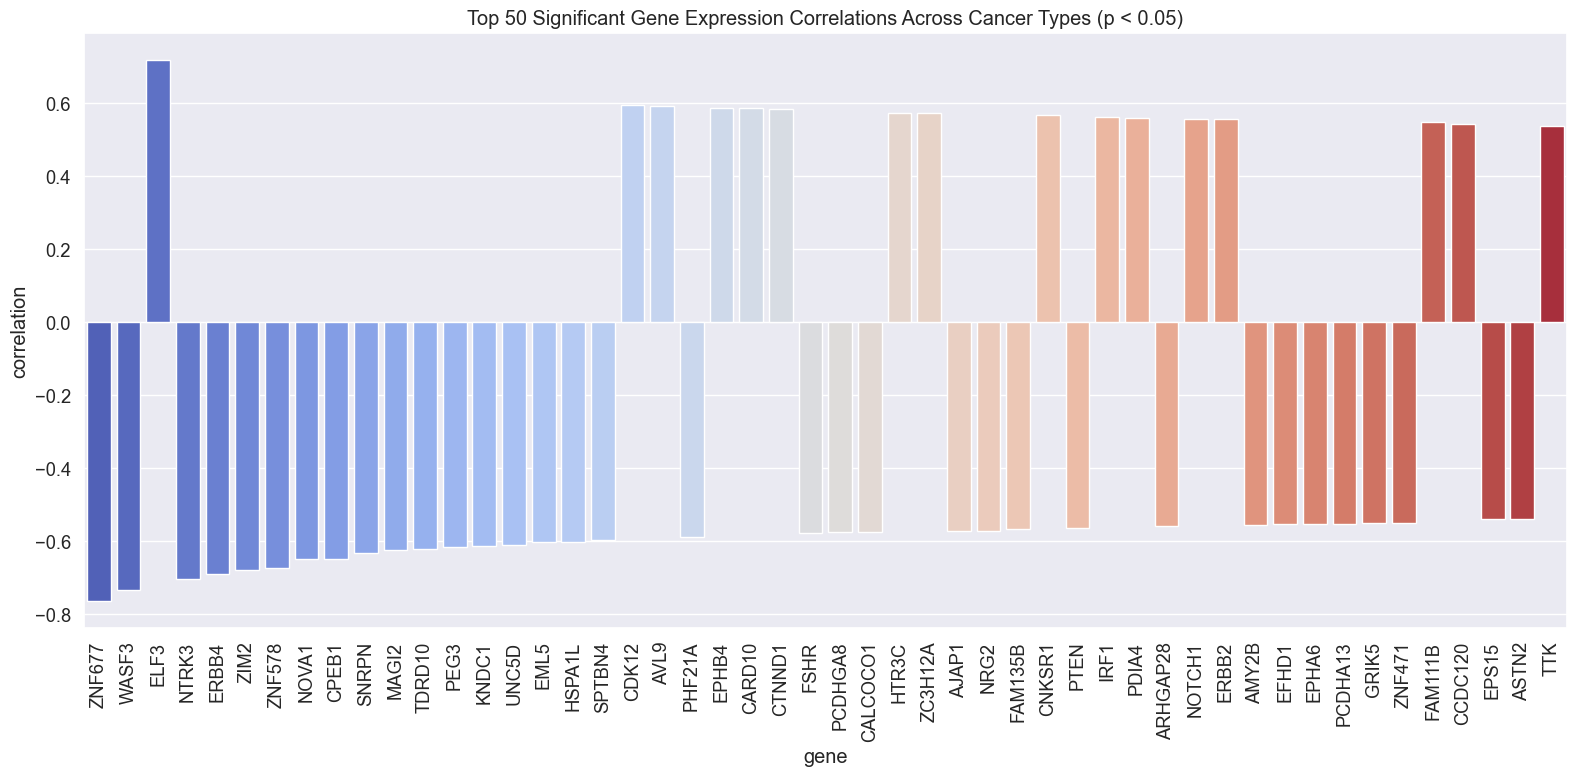

In [175]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute mutation frequencies and expression data by cancer type
def compute_cancer_type_stats(mutationtab, expression_data, cancer_type_column='cancer_type'):
    # Ensure that 'cancer_type' is the index in both mutationtab and expression_data
    mutationtab = mutationtab.reset_index().set_index(cancer_type_column)
    expression_data = expression_data.reset_index().set_index(cancer_type_column)
    
    # Select only numeric columns for mean computation
    mutation_by_cancer = mutationtab.select_dtypes(include=[np.number]).groupby(cancer_type_column).mean()
    expression_by_cancer = expression_data.select_dtypes(include=[np.number]).groupby(cancer_type_column).mean()
    
    return mutation_by_cancer, expression_by_cancer

# Step 2: Statistical comparison of mutations and expression patterns across cancer types
def compare_gene_expression_across_cancers(mutation_by_cancer, expression_by_cancer):
    results = []
    # Compare each gene's mutation and expression across cancer types using Spearman correlation
    for gene in mutation_by_cancer.columns:
        if gene in expression_by_cancer.columns:
            gene_mutation_data = mutation_by_cancer[gene]
            gene_expression_data = expression_by_cancer[gene]
            correlation, p_value = stats.spearmanr(gene_mutation_data, gene_expression_data)
            results.append({
                'gene': gene,
                'correlation': correlation,
                'p_value': p_value
            })
    return pd.DataFrame(results)

# Step 3: Visualization of significant correlations
def plot_correlation_results(results_df, p_value_threshold=0.05, top_n=50):
    # Filter results based on the p-value threshold
    significant_results = results_df[results_df['p_value'] < p_value_threshold]
    
    # Optionally, sort and limit to the top N most correlated genes
    significant_results['abs_corr'] = significant_results['correlation'].abs()
    significant_results = significant_results.sort_values(by='abs_corr', ascending=False).head(top_n)
    
    # Plotting
    plt.figure(figsize=(16, 8))  # Increased figure size
    sns.barplot(data=significant_results, x='gene', y='correlation', palette='coolwarm')
    plt.title(f'Top {top_n} Significant Gene Expression Correlations Across Cancer Types (p < {p_value_threshold})')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()
# Step 4: Putting everything together
def perform_cross_cancer_comparison(mutationtab, expression_data, cancer_type_column='cancer_type'):
    mutation_by_cancer, expression_by_cancer = compute_cancer_type_stats(mutationtab, expression_data, cancer_type_column)
    results_df = compare_gene_expression_across_cancers(mutation_by_cancer, expression_by_cancer)
    plot_correlation_results(results_df)

# Execute the analysis
perform_cross_cancer_comparison(mutationtab, tumourexp)


Cross-Cancer Comparisons: If the dataset contains multiple cancer types, you can perform comparisons of mutation and expression patterns across cancer types, identifying driver genes that behave consistently or differently between cancers.

### Oncogenes VS Tumour Supressor

#### Filtered

In [366]:
# Split drivers into oncogenes and tumor suppressors
oncogenes = list(set(cancerdrivers[cancerdrivers['NCG_oncogene'] == 1]['symbol']))
tumor_suppressors = list(set(cancerdrivers[cancerdrivers['NCG_tsg'] == 1]['symbol']))

# Classify the drivers
results_df['driver_type'] = results_df['driver'].apply(lambda x: 'Oncogene' if x in oncogenes else ('Tumor Suppressor' if x in tumor_suppressors else 'Unknown'))
print("\nDriver types:")
print(results_df['driver_type'].value_counts())

# Get lists of drivers by type
oncogenes_info = results_df[results_df['driver_type'] == 'Oncogene']['driver'].tolist()
tumor_suppressors_info = results_df[results_df['driver_type'] == 'Tumor Suppressor']['driver'].tolist()
unknown_drivers_info = results_df[results_df['driver_type'] == 'Unknown']['driver'].tolist()

# Statistical analysis of gene expression between oncogenes and tumor suppressors
oncogene_exp = results_df[results_df['driver_type'] == 'Oncogene']['mean_expression_mutated']
tsg_exp = results_df[results_df['driver_type'] == 'Tumor Suppressor']['mean_expression_mutated']

# Mann-Whitney U test to compare gene expression between oncogenes and tumor suppressors
u_stat_onc_vs_tsg, u_p_value_onc_vs_tsg = stats.mannwhitneyu(oncogene_exp, tsg_exp, nan_policy='omit')

print(f"\nMann-Whitney U test for gene expression between Oncogenes and Tumor Suppressors:")
print(f"U-statistic: {u_stat_onc_vs_tsg}, P-value: {u_p_value_onc_vs_tsg}")


Driver types:
driver_type
Unknown             2076
Tumor Suppressor     206
Oncogene             185
Name: count, dtype: int64

Mann-Whitney U test for gene expression between Oncogenes and Tumor Suppressors:
U-statistic: 16587.0, P-value: 0.02700181913982918


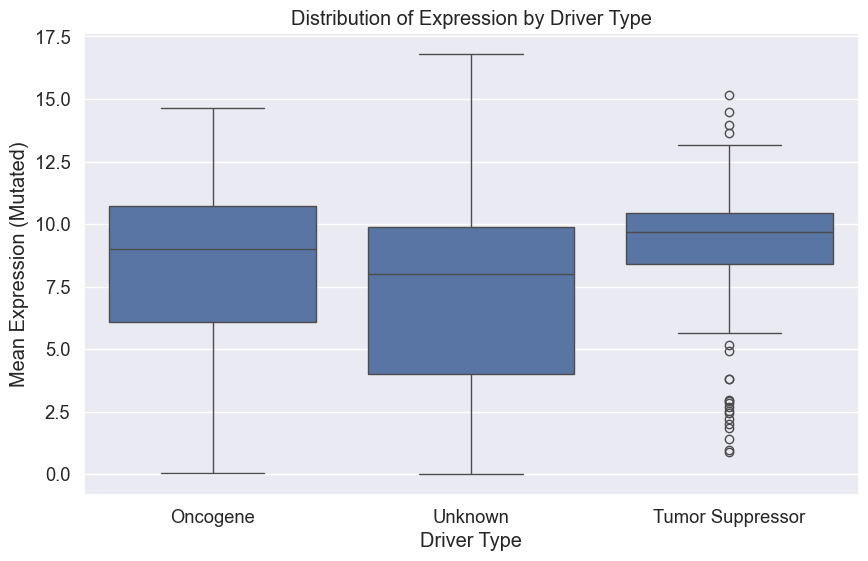

In [367]:
# Boxplot visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='driver_type', y='mean_expression_mutated', data=results_df)
plt.title('Distribution of Expression by Driver Type')
plt.xlabel('Driver Type')
plt.ylabel('Mean Expression (Mutated)')
plt.show()


In [368]:
results_df['expression_change'] = results_df['mean_expression_mutated'] - results_df['mean_expression_non_mutated']

mean_expression_change = results_df.groupby('driver_type')['expression_change'].mean()

# Exibindo os valores das médias
mean_expression_change


driver_type
Oncogene           -0.046555
Tumor Suppressor   -0.005412
Unknown            -0.144646
Name: expression_change, dtype: float64

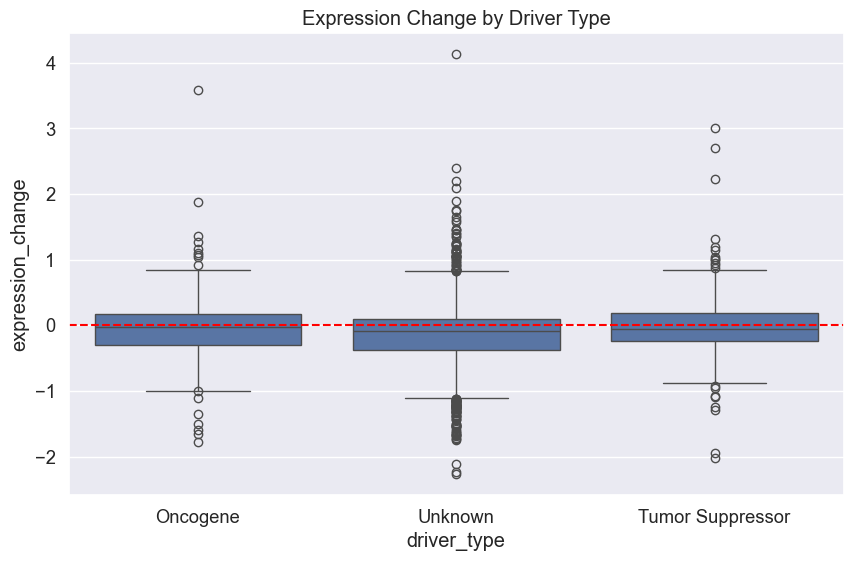

In [369]:
# Boxplot of Expression Change by Driver Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='driver_type', y='expression_change', data=results_df)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.title('Expression Change by Driver Type')
plt.show()

<Figure size 1000x600 with 0 Axes>

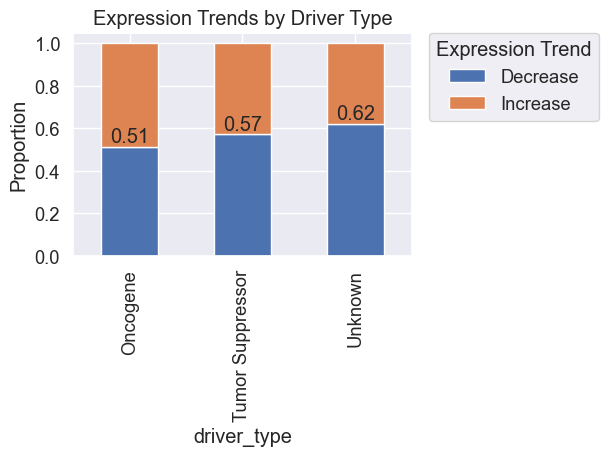

In [370]:
# Function to categorize expression direction (Increase, Decrease, No Change)
def expression_direction(row):
    if row['expression_change'] > 0:
        return 'Increase'
    elif row['expression_change'] < 0:
        return 'Decrease'
    else:
        return 'No Change'

# Apply the function to create the 'expression_direction' column
results_df['expression_direction'] = results_df.apply(expression_direction, axis=1)

# Count and calculate proportions of expression trends for each driver type
direction_counts = results_df.groupby(['driver_type', 'expression_direction']).size().unstack(fill_value=0)
direction_proportions = direction_counts.div(direction_counts.sum(axis=1), axis=0)

# Visualize the proportions of expression trends with bar plot
plt.figure(figsize=(10, 6))
ax = direction_proportions.plot(kind='bar', stacked=True)

# Move the legend outside the plot
ax.legend(title='Expression Trend', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('Expression Trends by Driver Type')
plt.ylabel('Proportion')

# Add annotations for clearer comparison
for index, proportion in enumerate(direction_proportions['Decrease']):
    plt.text(index, proportion + 0.02, f"{proportion:.2f}", ha='center')

plt.tight_layout()  # Adjust layout to prevent clipping of ylabel/legend
plt.show()


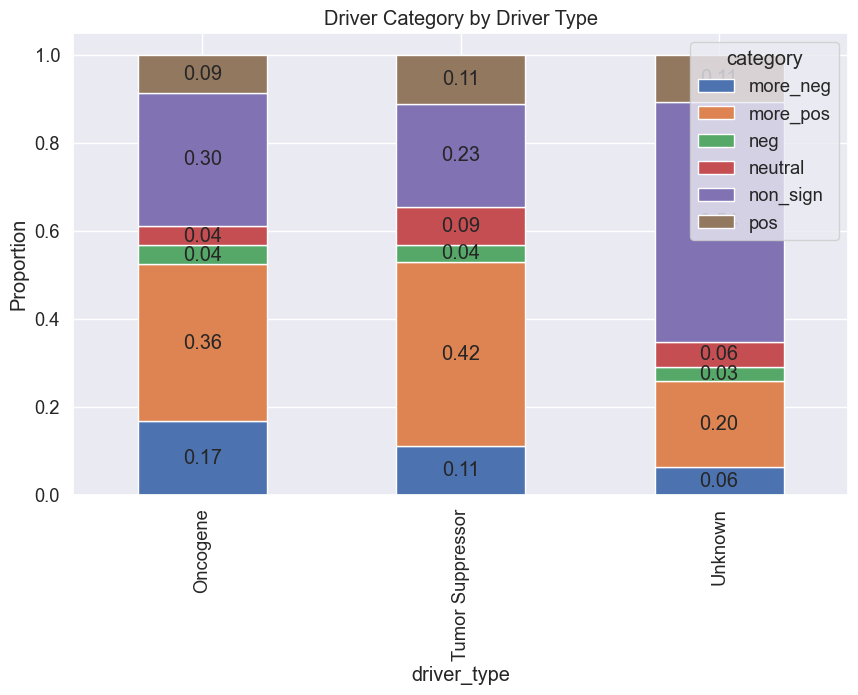

In [372]:
# Cross-tabulation of driver types by category
category_by_type = pd.crosstab(results_df['driver_type'], results_df['category'], normalize='index')
ax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Driver Category by Driver Type')
plt.ylabel('Proportion')

# Annotate bars with labels
for c in ax.containers:
    labels = [f'{v.get_height():.2f}' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center') 

plt.show()

""" # Cross-tabulation of driver types by category
category_by_type = pd.crosstab(results_df['driver_type'], results_df['category'], normalize='index')
ax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6))
category_by_type = category_by_type[category_order]

# Plotar o gráfico empilhado
ax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6))

# Mover a legenda para fora do gráfico
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adicionar título e rótulo ao eixo Y
plt.title('Driver Category by Driver Type')
plt.ylabel('Proportion')

# Anotar as barras com os rótulos de proporção
for c in ax.containers:
    labels = [f'{v.get_height():.2f}' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

# Ajustar o layout para evitar que a legenda ou o rótulo do eixo Y seja cortado
plt.tight_layout()

# Exibir o gráfico
plt.show() """


In [373]:
results_df_not_unk = results_df[results_df['driver_type'] != 'Unknown']

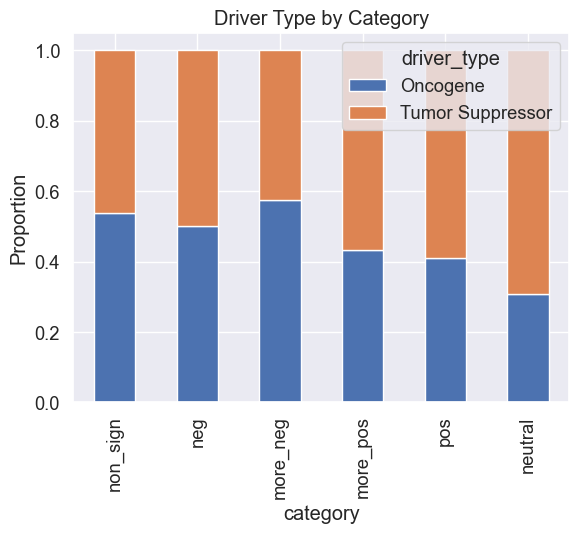

" # Reverse the X-axis and Y-axis of the previous plot\ncategory_by_type = pd.crosstab(results_df['category'], results_df['driver_type'], normalize='index')\ncategory_by_type.plot(kind='bar', stacked=True)\nplt.title('Driver Type by Category')\nplt.ylabel('Proportion')\nplt.show() "

In [374]:
#fazer ao contrário, meter antes as categorias no eixo do x e se é oncogene e tumor supressor ou unknown como proporção
category_by_type = pd.crosstab(results_df['category'], results_df_not_unk['driver_type'], normalize='index')
category_by_type = category_by_type.reindex(category_order) 
category_by_type.plot(kind='bar', stacked=True)
plt.title('Driver Type by Category')
plt.ylabel('Proportion')
plt.show()
#tumor suppressor tendem a ter mais positive neighbours e oncogenes tendem a ter mais negative neighbours

""" # Reverse the X-axis and Y-axis of the previous plot
category_by_type = pd.crosstab(results_df['category'], results_df['driver_type'], normalize='index')
category_by_type.plot(kind='bar', stacked=True)
plt.title('Driver Type by Category')
plt.ylabel('Proportion')
plt.show() """

In [184]:
results_df

driver  category  mean_expression_mutated  mean_expression_non_mutated  \
0       A1CF  non_sign                 1.364054                     1.733682   
1      A2ML1  more_pos                 3.792646                     3.984380   
2     ABCA10  non_sign                 3.434216                     3.776301   
3     ABCA13  more_pos                 4.416936                     4.238564   
4      ABCA7  non_sign                 8.592880                     8.488046   
...      ...       ...                      ...                          ...   
2462  ZSWIM3  non_sign                 6.757654                     6.826901   
2463  ZSWIM6  non_sign                 8.376133                     8.574214   
2464  ZWILCH  non_sign                 8.974727                     8.440610   
2465   ZWINT       pos                 9.697200                     8.939950   
2466   ZZEF1  more_pos                10.118257                    10.136499   

      mann_whitney_statistic   p_value expression_trend  expression_change  \
0                        NaN       NaN         decrease          -0.369628   
1                   768878.0  0.820689         decrease          -0.191734   
2                   734992.0  0.003051         decrease          -0.342086   
3                  2349323.0  0.173663         increase           0.178372   
4                   845376.0  0.065576         increase           0.104834   
...                      ...       ...              ...                ...   
2462                314347.0  0.295461         decrease          -0.069247   
2463                267416.5  0.031749         decrease          -0.198081   
2464                306038.0  0.000020         increase           0.534118   
2465                409681.5  0.000003         increase           0.757250   
2466                865696.0  0.452197         decrease          -0.018242   

     driver_type expression_direction  
0       Oncogene             Decrease  
1        Unknown             Decrease  
2        Unknown             Decrease  
3        Unknown             Increase  
4        Unknown             Increase  
...          ...                  ...  
2462     Unknown             Decrease  
2463     Unknown             Decrease  
2464     Unknown             Increase  
2465     Unknown             Increase  
2466     Unknown             Decrease  

[2467 rows x 10 columns]

In [185]:
driver_info


n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group  \
driver                                                                     
A1CF              39          0          0  0.000000  0.000000  non_sign   
A2ML1             91          4          3  0.043956  0.032967  more_pos   
ABCA10             5          0          0  0.000000  0.000000  non_sign   
ABCA13             9          3          1  0.333333  0.111111  more_pos   
ABCA7             16          0          0  0.000000  0.000000  non_sign   
...              ...        ...        ...       ...       ...       ...   
ZSWIM3             6          0          0  0.000000  0.000000  non_sign   
ZSWIM6            22          0          0  0.000000  0.000000  non_sign   
ZWILCH            22          1          0  0.045455  0.000000  non_sign   
ZWINT            136         22          0  0.161765  0.000000       pos   
ZZEF1             89          8          2  0.089888  0.022472  more_pos   

        expression_change  mutation_frequency  
driver                                         
A1CF            -0.369628            0.013327  
A2ML1           -0.191734            0.022489  
ABCA10          -0.342086            0.024274  
ABCA13           0.178372            0.069134  
ABCA7            0.104834            0.022727  
...                   ...                 ...  
ZSWIM3          -0.069247            0.009638  
ZSWIM6          -0.198081            0.008924  
ZWILCH           0.534118            0.006545  
ZWINT            0.757250            0.008924  
ZZEF1           -0.018242            0.025940  

[2565 rows x 8 columns]

Correlation for Oncogene: 0.2860409598884223
Correlation for Tumor Suppressor: -0.02185124706438742
Correlation for Unknown: 0.17520608403508647


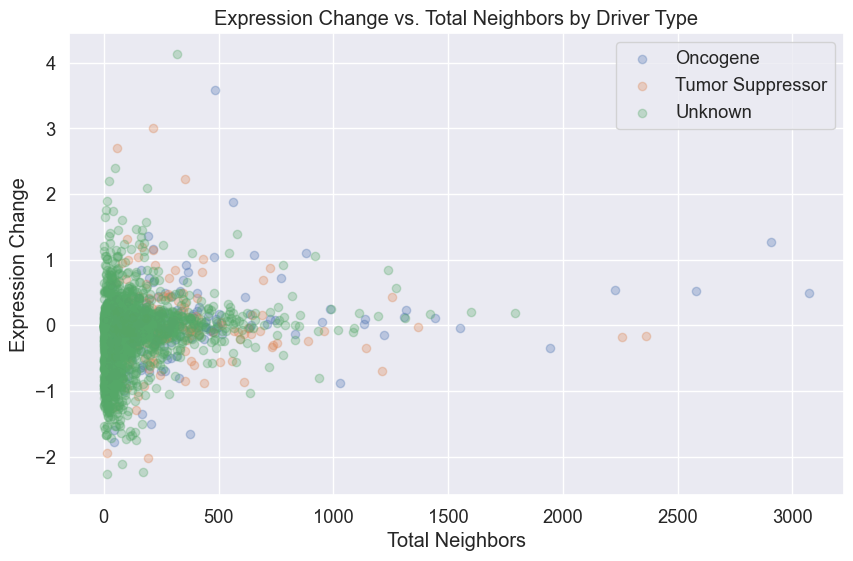

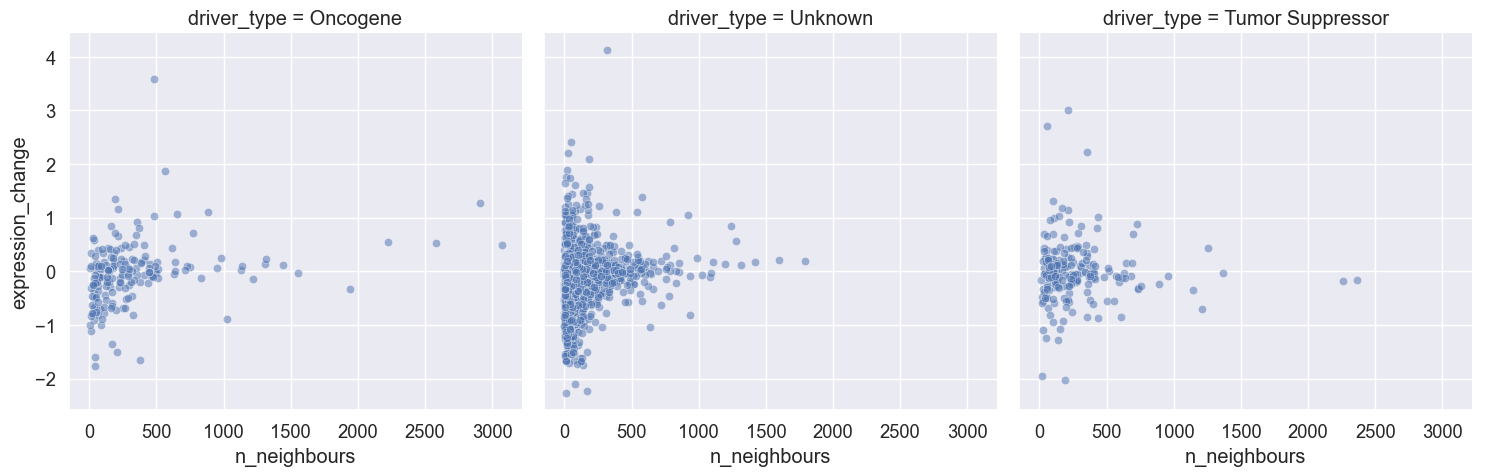

In [186]:
# Merge n_neighbours from driver_info into results_df
results_df = results_df.merge(driver_info[['n_neighbours']], left_on='driver', right_index=True, how='left')

# Calculate the correlation between expression change and total neighbors for each driver type
for driver_type in ['Oncogene', 'Tumor Suppressor', 'Unknown']:
    subset = results_df[results_df['driver_type'] == driver_type]
    correlation = subset['expression_change'].corr(subset['n_neighbours'])
    print(f"Correlation for {driver_type}: {correlation}")

# Scatter plot: Expression change vs. total neighbors by driver type
plt.figure(figsize=(10, 6))
for driver_type in ['Oncogene', 'Tumor Suppressor', 'Unknown']:
    subset = results_df[results_df['driver_type'] == driver_type]
    plt.scatter(subset['n_neighbours'], subset['expression_change'], label=driver_type, alpha=0.3)

plt.xlabel('Total Neighbors')
plt.ylabel('Expression Change')
plt.title('Expression Change vs. Total Neighbors by Driver Type')
plt.legend()
plt.show()

# Alternatively, create separate scatter plots using FacetGrid
g = sns.FacetGrid(results_df, col="driver_type", height=5)
g.map_dataframe(sns.scatterplot, x="n_neighbours", y="expression_change", alpha=0.5)
g.add_legend()
plt.show()


Mean Expression Change by Driver Type:
driver_type
Oncogene           -0.046555
Tumor Suppressor   -0.005412
Unknown            -0.144646
Name: expression_change, dtype: float64


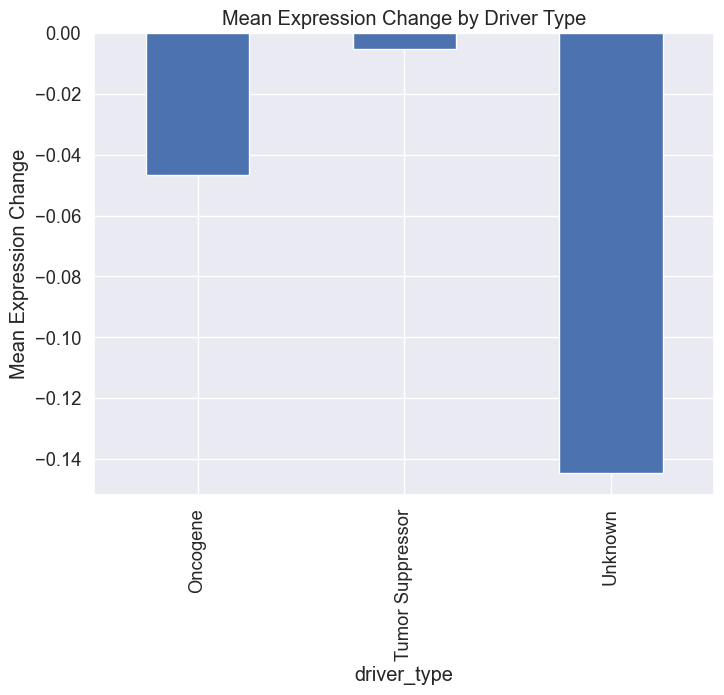

In [187]:
""" # Mean expression change by driver type
mean_change = results_df.groupby('driver_type')['expression_change'].mean()
print("Mean Expression Change by Driver Type:")
print(mean_change)

# Bar plot of mean expression change by driver type
plt.figure(figsize=(8, 6))
mean_change.plot(kind='bar')
plt.title('Mean Expression Change by Driver Type')
plt.ylabel('Mean Expression Change')
plt.show() """

In [188]:
# Proportion of drivers with Increase vs. Decrease in expression
direction_counts = results_df.groupby(['driver_type', 'expression_direction']).size().unstack(fill_value=0)
direction_proportions = direction_counts.div(direction_counts.sum(axis=1), axis=0)

print("Proportion of drivers with increase vs. decrease in expression:")
print(direction_proportions)

Proportion of drivers with increase vs. decrease in expression:
expression_direction  Decrease  Increase
driver_type                             
Oncogene              0.513514  0.486486
Tumor Suppressor      0.572816  0.427184
Unknown               0.622351  0.377649


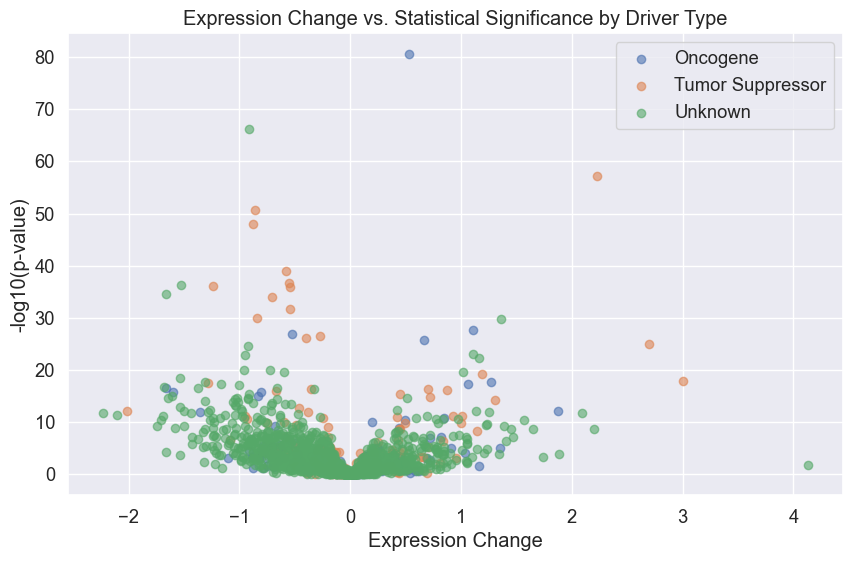

In [189]:
# Scatter plot: Expression change vs. statistical significance (-log10(p-value))
plt.figure(figsize=(10, 6))
for driver_type in ['Oncogene', 'Tumor Suppressor', 'Unknown']:
    subset = results_df[results_df['driver_type'] == driver_type]
    plt.scatter(subset['expression_change'], -np.log10(subset['p_value']), label=driver_type, alpha=0.6)

plt.xlabel('Expression Change')
plt.ylabel('-log10(p-value)')
plt.title('Expression Change vs. Statistical Significance by Driver Type')
plt.legend()
plt.show()


#### All DINTs

In [200]:
total_drivers = len(driver_stats)
significant_drivers = len(driver_stats[driver_stats['group'] != 'non_sign'])
non_significant_drivers = total_drivers - significant_drivers
category_counts = driver_stats['group'].value_counts()

print(f"Total drivers: {total_drivers}")
print(f"Significant drivers: {significant_drivers}")
print(f"Non-significant drivers: {non_significant_drivers}")

print("\nDriver categories:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

print("\nTop 5 drivers with most neighbors:")
print(driver_stats.sort_values('n_neighbours', ascending=False).head())


Total drivers: 2565
Significant drivers: 1271
Non-significant drivers: 1294

Driver categories:
non_sign: 1294
more_pos: 576
pos: 274
more_neg: 185
neutral: 151
neg: 85

Top 5 drivers with most neighbors:
        n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group
driver                                                                  
MYC             3070         69          2  0.022476  0.000651  more_pos
EGFR            2907          6         18  0.002064  0.006192  more_neg
KRAS            2582        126         72  0.048799  0.027885  more_pos
CUL3            2364         76         28  0.032149  0.011844  more_pos
TP53            2259        163         54  0.072156  0.023904  more_pos


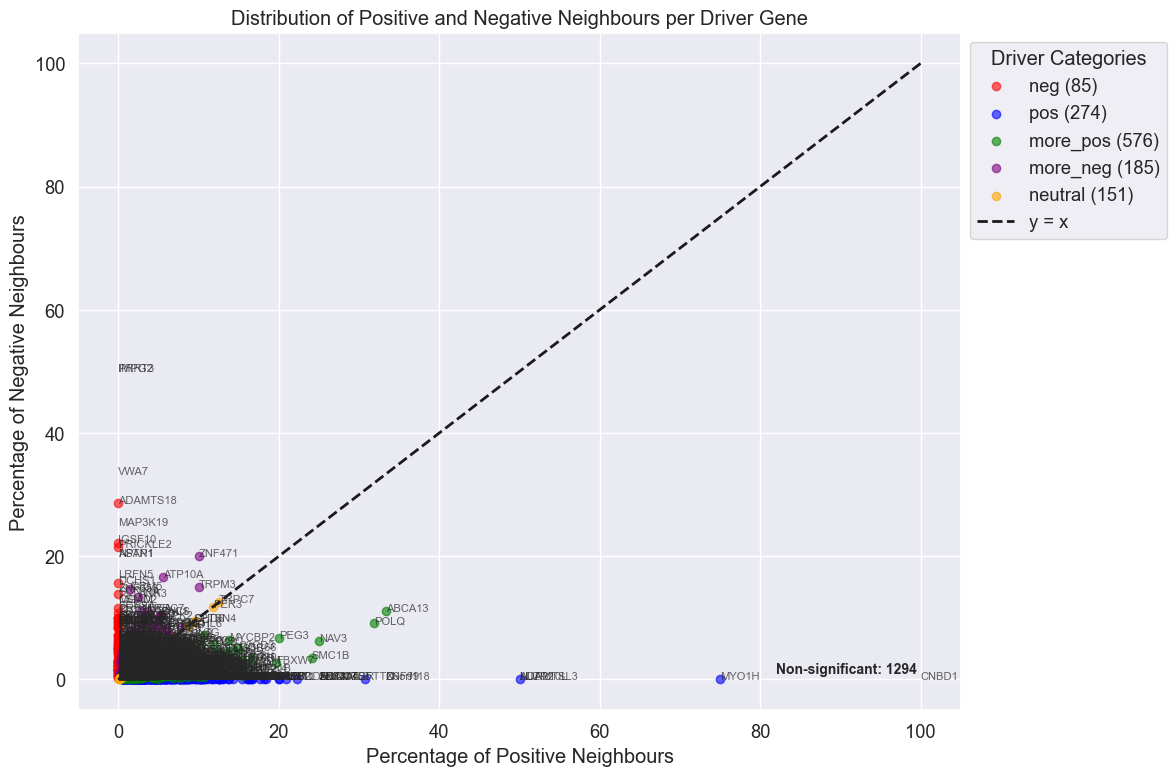

In [203]:
# Step 4: Create the plot
plt.figure(figsize=(12, 8))

# Define colors for each category based on the 'group' column
color_map = {
    "neg": "red",
    "pos": "blue",
    "more_pos": "green",
    "more_neg": "purple",
    "neutral": "orange"
}

# Plot data points for each category
for category, color in color_map.items():
    category_data = driver_stats[driver_stats['group'] == category]
    plt.scatter(
        category_data["pos_pct"] * 100,  # Convert percentages to 0-100 scale
        category_data["neg_pct"] * 100,  # Convert percentages to 0-100 scale
        color=color,
        alpha=0.6,
        label=f"{category} ({len(category_data)})"
    )

# Add y=x line for reference
plt.plot([0, 100], [0, 100], 'k--', lw=2, label="y = x")

# Add labels and title
plt.xlabel("Percentage of Positive Neighbours")
plt.ylabel("Percentage of Negative Neighbours")
plt.title("Distribution of Positive and Negative Neighbours per Driver Gene")
plt.grid(True)

# Add driver names as annotations
for index, row in driver_stats.iterrows():
    plt.annotate(
        row['driver'],  # Use driver name for annotation
        (row["pos_pct"] * 100, row["neg_pct"] * 100),
        fontsize=8,
        alpha=0.7
    )

# Add a legend
plt.legend(title="Driver Categories", loc="upper left", bbox_to_anchor=(1, 1))

# Add non-significant driver count to the plot
plt.text(0.95, 0.05, f"Non-significant: {non_significant_drivers}", 
         horizontalalignment='right', verticalalignment='bottom', 
         transform=plt.gca().transAxes, fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

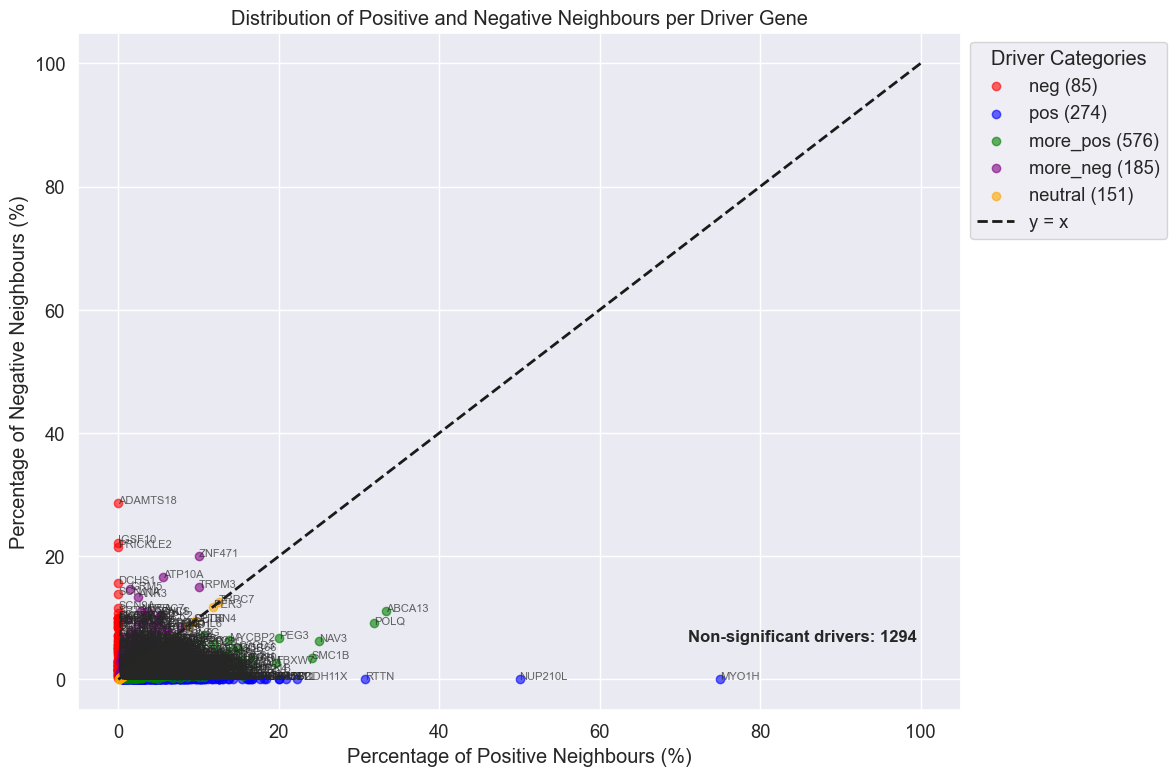

In [204]:
import matplotlib.pyplot as plt

# Step 1: Filter out non-significant drivers from the scatter plot data
filtered_driver_stats = driver_stats[driver_stats['group'] != "non_sign"]

# Step 2: Count the non-significant drivers
non_significant_count = len(driver_stats[driver_stats['group'] == "non_sign"])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))

# Define colors for each category based on the 'group' column
color_map = {
    "neg": "red",
    "pos": "blue",
    "more_pos": "green",
    "more_neg": "purple",
    "neutral": "orange"
}

# Step 4: Plot data points for each category excluding "non_sign"
for category, color in color_map.items():
    category_data = filtered_driver_stats[filtered_driver_stats['group'] == category]
    plt.scatter(
        category_data["pos_pct"] * 100,  # Convert percentages to 0-100 scale
        category_data["neg_pct"] * 100,  # Convert percentages to 0-100 scale
        color=color,
        alpha=0.6,
        label=f"{category} ({len(category_data)})"
    )

# Step 5: Add y=x line for reference
plt.plot([0, 100], [0, 100], 'k--', lw=2, label="y = x")

# Step 6: Add labels and title
plt.xlabel("Percentage of Positive Neighbours (%)")
plt.ylabel("Percentage of Negative Neighbours (%)")
plt.title("Distribution of Positive and Negative Neighbours per Driver Gene")
plt.grid(True)

# Step 7: Annotate drivers
for index, row in filtered_driver_stats.iterrows():
    plt.annotate(
        row['driver'],  # Use driver name for annotation
        (row["pos_pct"] * 100, row["neg_pct"] * 100),
        fontsize=8,
        alpha=0.7
    )

# Step 8: Add a legend
plt.legend(title="Driver Categories", loc="upper left", bbox_to_anchor=(1, 1))

# Step 9: Add non-significant driver count to the plot as a text annotation
plt.text(0.95, 0.12, f"Non-significant drivers: {non_significant_count}",  # Adjust y-position here
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

# Step 10: Adjust layout
plt.tight_layout()

# Step 11: Show the plot
plt.show()


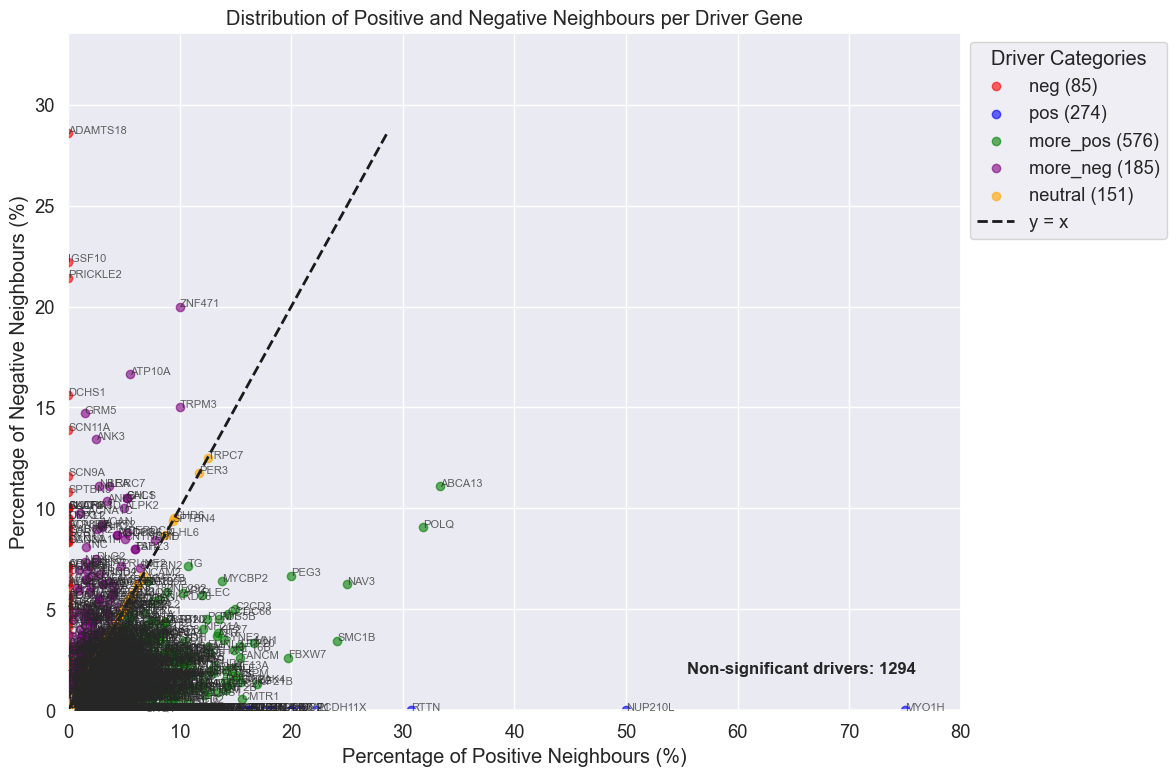

In [205]:
import matplotlib.pyplot as plt

# Step 1: Filter out non-significant drivers from the scatter plot data
filtered_driver_stats = driver_stats[driver_stats['group'] != "non_sign"]

# Step 2: Count the non-significant drivers
non_significant_count = len(driver_stats[driver_stats['group'] == "non_sign"])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))

# Define colors for each category based on the 'group' column
color_map = {
    "neg": "red",
    "pos": "blue",
    "more_pos": "green",
    "more_neg": "purple",
    "neutral": "orange"
}

# Step 4: Plot data points for each category excluding "non_sign"
for category, color in color_map.items():
    category_data = filtered_driver_stats[filtered_driver_stats['group'] == category]
    plt.scatter(
        category_data["pos_pct"] * 100,  # Convert percentages to 0-100 scale
        category_data["neg_pct"] * 100,  # Convert percentages to 0-100 scale
        color=color,
        alpha=0.6,
        label=f"{category} ({len(category_data)})"
    )

# Step 5: Set dynamic axis limits based on data
x_max = (filtered_driver_stats['pos_pct'].max()) * 100
y_max = (filtered_driver_stats['neg_pct'].max()) * 100

plt.xlim(0, x_max + 5)  # Add a small margin to make the plot look nicer
plt.ylim(0, y_max + 5)

# Step 6: Add y=x line for reference
plt.plot([0, min(x_max, y_max)], [0, min(x_max, y_max)], 'k--', lw=2, label="y = x")

# Step 7: Add labels and title
plt.xlabel("Percentage of Positive Neighbours (%)")
plt.ylabel("Percentage of Negative Neighbours (%)")
plt.title("Distribution of Positive and Negative Neighbours per Driver Gene")
plt.grid(True)

# Step 8: Annotate drivers
for index, row in filtered_driver_stats.iterrows():
    plt.annotate(
        row['driver'],  # Use driver name for annotation
        (row["pos_pct"] * 100, row["neg_pct"] * 100),
        fontsize=8,
        alpha=0.7
    )

# Step 9: Add a legend
plt.legend(title="Driver Categories", loc="upper left", bbox_to_anchor=(1, 1))

# Step 10: Add non-significant driver count to the plot as a text annotation
plt.text(0.95, 0.05, f"Non-significant drivers: {non_significant_count}", 
         horizontalalignment='right', verticalalignment='bottom', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

# Step 11: Adjust layout
plt.tight_layout()

# Step 12: Show the plot
plt.show()


### Functional Enrichment Analysis

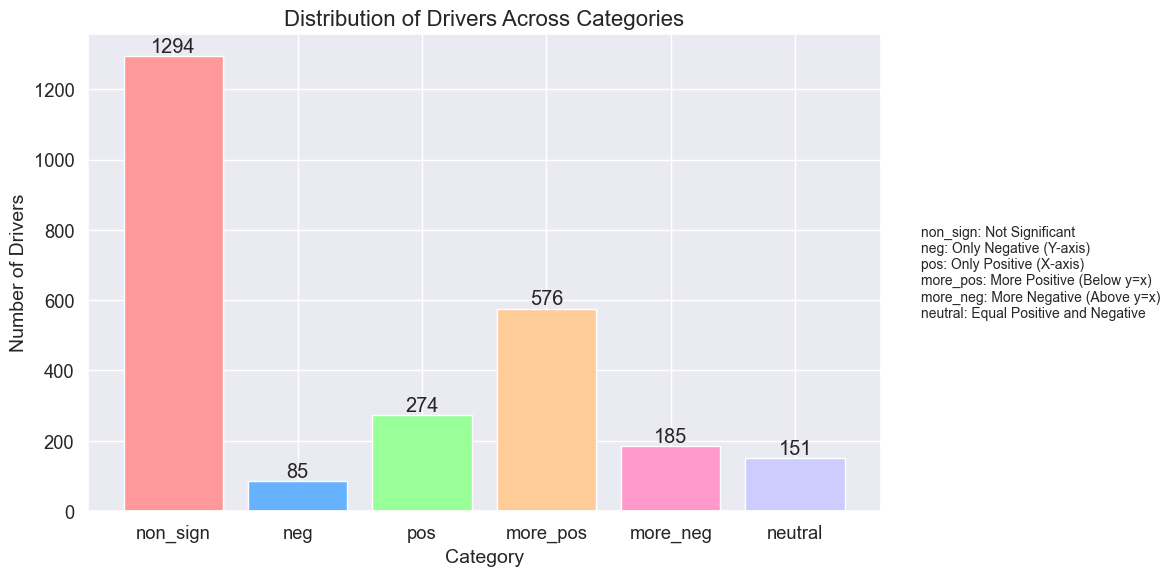


Total number of drivers: 2565


In [206]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of drivers in each category from the 'group' column
category_counts = driver_stats['group'].value_counts()
category_order = ['non_sign', 'neg', 'pos', 'more_pos', 'more_neg', 'neutral']  # Including 'neutral' and 'non_sign'
category_counts = category_counts.reindex(category_order).fillna(0)

# Define colors for each category, including 'neutral' and 'non_sign'
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#CCCCFF']  # Colors for 'neutral' and 'non_sign'

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(category_counts.index, category_counts.values, color=colors)

# Customize the plot
plt.title('Distribution of Drivers Across Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Drivers', fontsize=14)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Add category descriptions
category_descriptions = {
    'non_sign': 'Not Significant',
    'neg': 'Only Negative (Y-axis)',
    'pos': 'Only Positive (X-axis)',
    'more_pos': 'More Positive (Below y=x)',
    'more_neg': 'More Negative (Above y=x)',
    'neutral': 'Equal Positive and Negative'
}

# Add the descriptions to the plot
plt.text(1.05, 0.5, '\n'.join([f"{k}: {v}" for k, v in category_descriptions.items()]), 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

# Print the total number of drivers
total_drivers = len(driver_stats)
print(f"\nTotal number of drivers: {total_drivers}")


In [ ]:
#driver_stats.reset_index().to_csv('driver_stats.csv', index=False)
#driver_stats.to_csv('driver_stats.csv', index=False)

#### Separated Groups

In [208]:
import pandas as pd
from gprofiler import GProfiler

# Configurar GProfiler
gp = GProfiler(return_dataframe=True)

drivers_group_by_classification = {
    category: driver_stats[driver_stats['group'] == category]['driver'].tolist()
    for category in ['non_sign', 'neg', 'pos', 'more_pos', 'more_neg', 'neutral']
}

# Realizar análise de enriquecimento
results_separated = {}
for classification, drivers_list in drivers_group_by_classification.items():
    results_separated[classification] = {}
    for source in sources:
        try:
            results_separated[classification][source] = gp.profile(
                organism='hsapiens',
                query=drivers_list,
                user_threshold=0.05,
                no_evidences=False,
                sources=[source],
                all_results=False,
                domain_scope='annotated',
                background=background,
                significance_threshold_method='fdr'
            )
        except Exception as e:
            print(f"Error in group {classification}, source {source}: {str(e)}")
            results_separated[classification][source] = pd.DataFrame()  # Empty DataFrame if error occurs

""" # Consolidar resultados
consolidated_df = pd.DataFrame()
for group, source_results in results_separated.items():
    for source, df in source_results.items():
        if not df.empty:
            df['Group'] = group
            df['source'] = source
            consolidated_df = pd.concat([consolidated_df, df], ignore_index=True)

# Analisar funções por grupo
functions_by_group = consolidated_df.groupby(['Group', 'source'])['name'].value_counts()
print("Funções mais comuns por grupo e fonte:")
print(functions_by_group) """

' # Consolidar resultados\nconsolidated_df = pd.DataFrame()\nfor group, source_results in results_separated.items():\n    for source, df in source_results.items():\n        if not df.empty:\n            df[\'Group\'] = group\n            df[\'source\'] = source\n            consolidated_df = pd.concat([consolidated_df, df], ignore_index=True)\n\n# Analisar funções por grupo\nfunctions_by_group = consolidated_df.groupby([\'Group\', \'source\'])[\'name\'].value_counts()\nprint("Funções mais comuns por grupo e fonte:")\nprint(functions_by_group) '

In [209]:
# Consolidar resultados em termos únicos por grupo
consolidated_terms = {}
for group, source_results in results_separated.items():
    df_list = [df[['source', 'name', 'intersection_size', 'query_size', 'term_size', 'effective_domain_size']] for df in source_results.values()]
    consolidated_df = pd.concat(df_list).drop_duplicates(subset='name')
    consolidated_terms[group] = consolidated_df

In [210]:
# Identificar funções exclusivas por grupo
exclusive_functions_by_group = {}
for group, terms_df in consolidated_terms.items():
    all_functions = set(terms_df['name'])
    unique_functions = all_functions.copy()
    for other_group, other_terms_df in consolidated_terms.items():
        if group != other_group:
            other_functions = set(other_terms_df['name'])
            unique_functions.difference_update(other_functions)
    exclusive_functions_by_group[group] = unique_functions

# Calcular fold enrichment para funções exclusivas
dfs_by_group = {}
for group, unique_functions in exclusive_functions_by_group.items():
    dfs_temp = []
    terms_df = consolidated_terms[group]
    exclusive_functions_in_df = terms_df[terms_df['name'].isin(unique_functions)]
    for index, row in exclusive_functions_in_df.iterrows():
        intersection_size = row['intersection_size']
        query_size = row['query_size']
        term_size = row['term_size']
        effective_domain_size = row['effective_domain_size']
        fold_enrichment = (intersection_size / query_size) / (term_size / effective_domain_size)
        df_temp = pd.DataFrame({'Term_name': [row['name']], 'Fold_Enrichment': [fold_enrichment], 'Source': [row['source']]})
        dfs_temp.append(df_temp)
    
    if dfs_temp:  # Check if there are any DataFrames to concatenate
        df_group = pd.concat(dfs_temp, ignore_index=True)
        df_group = df_group.sort_values(by='Fold_Enrichment', ascending=False)
        dfs_by_group[group] = df_group
    else:
        print(f"No exclusive functions with fold enrichment data for group {group}")

# Print results
for group, df_group in dfs_by_group.items():
    print(f"\nDataFrame for group {group}:")
    print(df_group)


DataFrame for group non_sign:
                                            Term_name  Fold_Enrichment Source
43  positive regulation of serine-type peptidase a...        15.771739  GO:BP
42  positive regulation of serine-type endopeptida...        15.771739  GO:BP
58       regulation of serine-type peptidase activity        11.828804  GO:BP
54  negative regulation of mesenchymal cell apopto...        11.828804  GO:BP
19                      decanoate-CoA ligase activity        11.828804  GO:MF
..                                                ...              ...    ...
48  adenylate cyclase-modulating G protein-coupled...         1.890002  GO:BP
21  secondary active transmembrane transporter act...         1.777905  GO:MF
24                   external side of plasma membrane         1.738283  GO:CC
85            Neuroactive ligand-receptor interaction         1.708605   KEGG
72       G protein-coupled receptor signaling pathway         1.349767  GO:BP

[103 rows x 3 columns]

DataFram

In [ ]:
""" # Identificar funções exclusivas
functions_by_group = {}
for group, source_results in results_separated.items():
    all_functions = set()
    for df in source_results.values():
        functions = df['name'].tolist()
        all_functions.update(functions)
    functions_by_group[group] = all_functions

exclusive_functions_by_group = {}
exclusive_function_count_by_group = {}

for group, functions in functions_by_group.items():
    unique_functions = functions.copy()
    for other_group, other_functions in functions_by_group.items():
        if group != other_group:
            unique_functions.difference_update(other_functions)
    exclusive_functions_by_group[group] = unique_functions
    exclusive_function_count_by_group[group] = len(unique_functions)

print("\nNúmero de funções exclusivas por grupo:")
for group, count in exclusive_function_count_by_group.items():
    print(f"{group}: {count}") """

' # Identificar funções exclusivas\nfunctions_by_group = {}\nfor group, source_results in results_separated.items():\n    all_functions = set()\n    for df in source_results.values():\n        functions = df[\'name\'].tolist()\n        all_functions.update(functions)\n    functions_by_group[group] = all_functions\n\nexclusive_functions_by_group = {}\nexclusive_function_count_by_group = {}\n\nfor group, functions in functions_by_group.items():\n    unique_functions = functions.copy()\n    for other_group, other_functions in functions_by_group.items():\n        if group != other_group:\n            unique_functions.difference_update(other_functions)\n    exclusive_functions_by_group[group] = unique_functions\n    exclusive_function_count_by_group[group] = len(unique_functions)\n\nprint("\nNúmero de funções exclusivas por grupo:")\nfor group, count in exclusive_function_count_by_group.items():\n    print(f"{group}: {count}") '

In [ ]:
""" for group, unique_functions in exclusive_functions_by_group.items():
    print(f"\nFunções exclusivas para o grupo {group}:")
    print(unique_functions) """

' for group, unique_functions in exclusive_functions_by_group.items():\n    print(f"\nFunções exclusivas para o grupo {group}:")\n    print(unique_functions) '

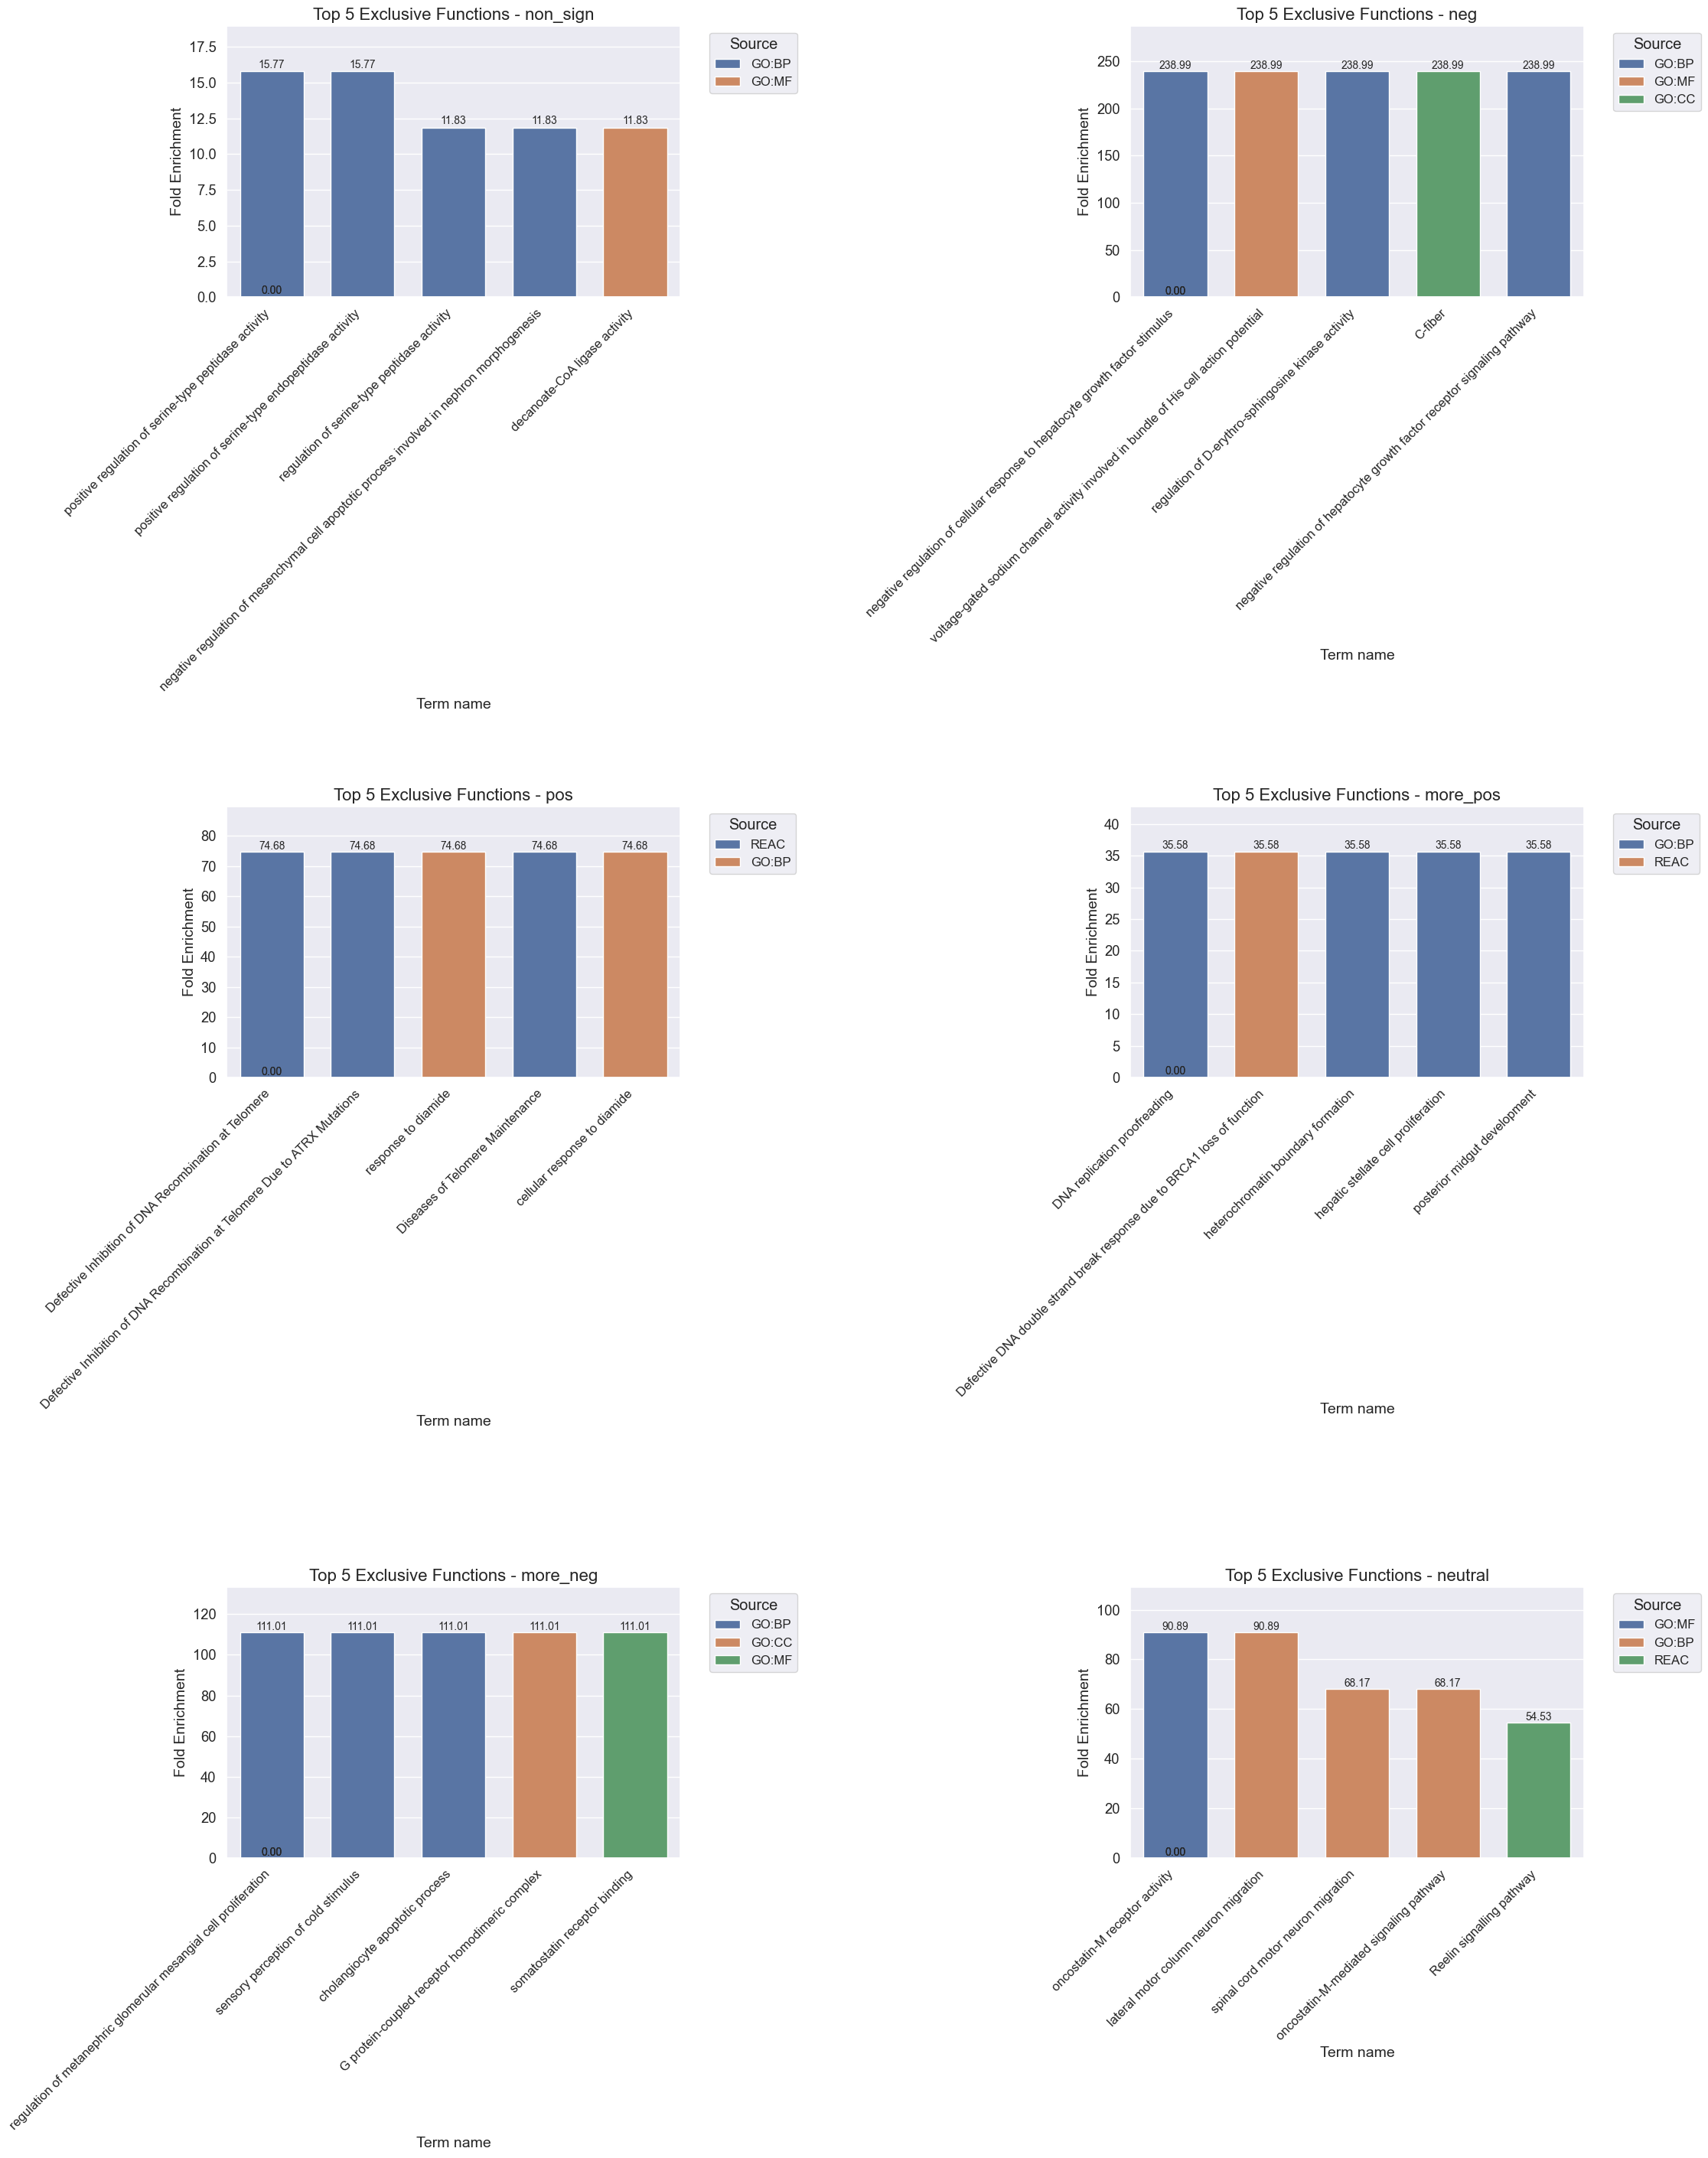

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24, 30))

# Assuming there are 5 groups, adjusting layout
for i, (group, df) in enumerate(dfs_by_group.items()):
    ax = plt.subplot(3, 2, i+1)
    
    top_5_df = df.head(5)
    
    # Plotting vertical bars
    bar_plot = sns.barplot(x='Term_name', y='Fold_Enrichment', data=top_5_df, hue='Source', dodge=False, ax=ax, width=0.7)
    
    plt.title(f'Top 5 Exclusive Functions - {group}', fontsize=16)
    plt.xlabel('Term name', fontsize=14)
    plt.ylabel('Fold Enrichment', fontsize=14)
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    
    plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    plt.ylim(0, df['Fold_Enrichment'].max() * 1.2)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.1, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout(pad=5.0)
plt.show()

#### All Groups

In [212]:
driver_stats = pd.read_csv('driver_stats.csv', index_col='driver')
driver_stats

n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group
driver                                                                  
A1CF              39          0          0  0.000000  0.000000  non_sign
A2ML1             91          4          3  0.043956  0.032967  more_pos
ABCA10             5          0          0  0.000000  0.000000  non_sign
ABCA13             9          3          1  0.333333  0.111111  more_pos
ABCA7             16          0          0  0.000000  0.000000  non_sign
...              ...        ...        ...       ...       ...       ...
ZSWIM3             6          0          0  0.000000  0.000000  non_sign
ZSWIM6            22          0          0  0.000000  0.000000  non_sign
ZWILCH            22          1          0  0.045455  0.000000  non_sign
ZWINT            136         22          0  0.161765  0.000000       pos
ZZEF1             89          8          2  0.089888  0.022472  more_pos

[2565 rows x 6 columns]

In [213]:
""" import pandas as pd
from gprofiler import GProfiler
import ast
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configurar GProfiler
gp = GProfiler(return_dataframe=True)
sources = ["GO:MF", "GO:CC", "GO:BP", "KEGG", "REAC", "WP", "HP"]

# Mesclar resultsfiltered com driver_stats para obter as categorias
combined_results = combined_results.merge(driver_stats[['new_category']], left_on='driver', right_index=True, how='left')

# Obter drivers únicos de resultsfiltered
all_drivers = combined_results['driver'].unique().tolist()

# Criar um dicionário para mapear drivers para suas categorias
driver_category_map = combined_results.set_index('driver')['new_category'].to_dict()

def process_source(source):
    results = gp.profile(
        organism='hsapiens',
        query=all_drivers,
        user_threshold=0.05,
        no_evidences=False,
        sources=[source],
        all_results=False,
        domain_scope='annotated',
        background=background,
        significance_threshold_method='fdr'
    )
    
    results['fold_enrichment'] = (
        results['effective_domain_size'] * results['intersection_size'] / 
        (results['term_size'] * results['query_size'])
    )
    
    results_list = []
    for _, row in results.iterrows():
        genes = ast.literal_eval(row['intersections']) if isinstance(row['intersections'], str) else row['intersections']
        
        category_counts = {'D0': 0, 'D1': 0, 'D2': 0, 'D3': 0, 'D4': 0}
        for gene in genes:
            category = driver_category_map.get(gene)
            if pd.notna(category):
                category_counts[category] += 1
        
        results_list.append({
            'Source': row['source'],
            'Name': row['name'],
            'FE': row['fold_enrichment'],
            **category_counts
        })
    
    return pd.DataFrame(results_list)

# Usar ThreadPoolExecutor para processar fontes em paralelo
with ThreadPoolExecutor(max_workers=len(sources)) as executor:
    future_to_source = {executor.submit(process_source, source): source for source in sources}
    results_df = []
    for future in as_completed(future_to_source):
        results_df.append(future.result())

final_results_df = pd.concat(results_df, ignore_index=True) """
import pandas as pd
from gprofiler import GProfiler
import ast
from concurrent.futures import ThreadPoolExecutor, as_completed

gp = GProfiler(return_dataframe=True)
#sources = ["GO:MF", "GO:CC", "GO:BP", "KEGG", "REAC", "WP"]

all_drivers = driver_stats.index.tolist()

driver_category_map = driver_stats['group'].to_dict()

def process_source(source):
    results = gp.profile(
        organism='hsapiens',
        query=all_drivers,
        user_threshold=0.05,
        no_evidences=False,
        sources=[source],
        all_results=False,
        domain_scope='annotated',
        background=background,
        significance_threshold_method='fdr'
    )
    
    results['fold_enrichment'] = (
        results['effective_domain_size'] * results['intersection_size'] / 
        (results['term_size'] * results['query_size'])
    )
    
    results_list = []
    for _, row in results.iterrows():
        genes = ast.literal_eval(row['intersections']) if isinstance(row['intersections'], str) else row['intersections']
        
        category_counts = {'non_sign': 0, 'neg': 0, 'more_neg': 0, 'more_pos': 0, 'pos': 0, 'neutral': 0}
        for gene in genes:
            category = driver_category_map.get(gene)
            if pd.notna(category):
                category_counts[category] += 1
        
        results_list.append({
            'Source': row['source'],
            'Name': row['name'],
            'FE': row['fold_enrichment'],
            'native': row['native'],
            'intersections': genes,
            'description': row['description'],              
            **category_counts
        })
    
    return pd.DataFrame(results_list)

with ThreadPoolExecutor(max_workers=len(sources)) as executor:
    future_to_source = {executor.submit(process_source, source): source for source in sources}
    results_df = []
    for future in as_completed(future_to_source):
        results_df.append(future.result())

final_results_df = pd.concat(results_df, ignore_index=True)
display(final_results_df)

Source                                               Name        FE  \
0      KEGG                                     KEGG root term  1.341649   
1      KEGG                                 Pathways in cancer  2.798705   
2      KEGG                                    Prostate cancer  4.602696   
3      KEGG                            Proteoglycans in cancer  3.321886   
4      KEGG                     Human papillomavirus infection  2.705828   
...     ...                                                ...       ...   
4616  GO:BP        regulation of biomineral tissue development  1.657654   
4617  GO:BP                multi-organism reproductive process  1.445998   
4618  GO:BP  positive regulation of pattern recognition rec...  1.839814   
4619  GO:BP                      megakaryocyte differentiation  1.839814   
4620  GO:BP  negative regulation of actin filament polymeri...  1.839814   

          native                                      intersections  \
0     KEGG:00000  [ABCA10, ABCA13, ABCA7, ABCB1, ABCB5, ABCC3, A...   
1     KEGG:05200  [ABL1, ADCY1, ADCY2, ADCY3, ADCY5, ADCY8, AKT1...   
2     KEGG:05215  [AKT1, AKT2, AKT3, AR, ARAF, BCL2, BRAF, CCND1...   
3     KEGG:05205  [ACTB, ACTG1, AKT1, AKT2, AKT3, ANK1, ANK2, AN...   
4     KEGG:05165  [AKT1, AKT2, AKT3, APC, ATM, ATP6AP1, ATP6V1B2...   
...          ...                                                ...   
4616  GO:0070167  [ACVR1, ACVR2A, BCOR, BMP7, BMPR2, DDR2, FBN2,...   
4617  GO:0044703  [A1CF, ACE, ACVR1B, ACVR2A, AKT1, AR, ASH1L, B...   
4618  GO:0062208  [ANKRD17, BRCC3, BTK, CD36, DDX3X, DHX58, LBP,...   
4619  GO:0030219  [ABI1, EP300, FLI1, FLNA, GATA2, KIT, MAF, MED...   
4620  GO:0030837  [ADD2, ADD3, FLII, SCIN, SLIT2, SPTA1, SPTAN1,...   

                                            description  non_sign  neg  \
0                                        KEGG root term       598   51   
1                                    Pathways in cancer        46    8   
2                                       Prostate cancer        16    1   
3                               Proteoglycans in cancer        21    2   
4                        Human papillomavirus infection        27    5   
...                                                 ...       ...  ...   
4616  "Any process that modulates the frequency, rat...         8    1   
4617  "A biological process that directly contribute...        17    1   
4618  "Any process that decreases the rate, frequenc...         6    0   
4619  "The process in which a myeloid precursor cell...         5    0   
4620  "Any process that stops, prevents, or reduces ...         2    1   

      more_neg  more_pos  pos  neutral  
0          137       352  140       92  
1           40        66   12       13  
2           16        17    4        2  
3           25        26    6        5  
4           29        33    6       12  
...        ...       ...  ...      ...  
4616         5         6    0        1  
4617         4         7    5        3  
4618         1         6    1        1  
4619         2         6    1        1  
4620         2         5    2        3  

[4621 rows x 12 columns]

In [214]:
final_results_df['Source'].value_counts()

Source
GO:BP    2800
REAC      607
GO:MF     385
WP        366
GO:CC     271
KEGG      192
Name: count, dtype: int64

In [215]:
final_results_df.to_csv('enrichment_results.csv', index=False)

In [216]:
all_intersections_set_drivers = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = final_results_df[final_results_df['Source'] == source]
        dic_filt_drivers = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extrai os valores da coluna 'intersections' e os adiciona ao conjunto all_intersections_set
        for intersection_list in dic_filt_drivers['intersections']:
            all_intersections_set_drivers.update(intersection_list)

count_only_drivers_in_intersections = sum(1 for item in all_drivers if item in all_intersections_set_drivers)

print(f"Número de valores de all_drivers que aparecem nas interseções: {count_only_drivers_in_intersections}")
proportion = count_only_drivers_in_intersections / len(all_drivers) 
print(f"Proporção de valores de only_pos que aparecem nas interseções: {proportion}")

Número de valores de all_drivers que aparecem nas interseções: 1436
Proporção de valores de only_pos que aparecem nas interseções: 0.5598440545808967


Distribution of hallmark-related drivers across categories:
non_sign: 592 drivers (41.23%)
neg: 56 drivers (3.90%)
more_neg: 134 drivers (9.33%)
more_pos: 395 drivers (27.51%)
pos: 162 drivers (11.28%)
neutral: 97 drivers (6.75%)


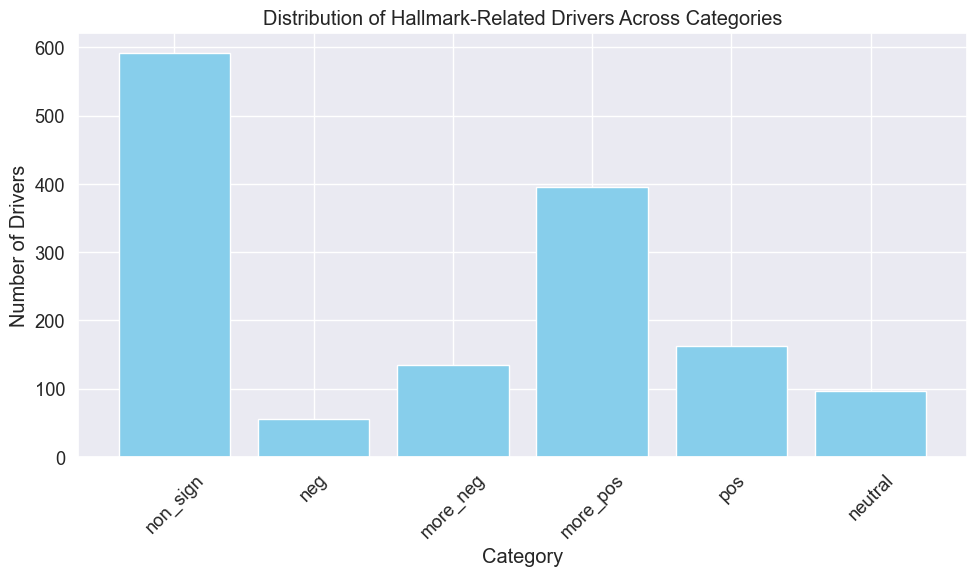

In [220]:
import matplotlib.pyplot as plt

# Step 1: Filter hallmark drivers from driver_stats
hallmark_drivers = set(all_intersections_set_drivers)

# Step 2: Filter driver_stats to include only hallmark-related drivers
hallmark_driver_stats = driver_stats[driver_stats.index.isin(hallmark_drivers)]

# Step 3: Create a dictionary to store the category counts
category_counts = hallmark_driver_stats['group'].value_counts().to_dict()

# Step 4: Fill in missing categories with zero counts (if needed)
category_order = ['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']
category_counts_ordered = {category: category_counts.get(category, 0) for category in category_order}

# Step 5: Calculate the total number of hallmark drivers
total_hallmark_drivers = sum(category_counts_ordered.values())

# Step 6: Calculate percentages
category_percentages = {cat: count / total_hallmark_drivers * 100 for cat, count in category_counts_ordered.items()}

# Step 7: Print the results
print("Distribution of hallmark-related drivers across categories:")
for cat, count in category_counts_ordered.items():
    percentage = category_percentages[cat]
    print(f"{cat}: {count} drivers ({percentage:.2f}%)")

# Step 8: Create a bar plot with the specified category order
plt.figure(figsize=(10, 6))
plt.bar(category_counts_ordered.keys(), category_counts_ordered.values(), color='skyblue')
plt.title("Distribution of Hallmark-Related Drivers Across Categories")
plt.xlabel("Category")
plt.ylabel("Number of Drivers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Proportion of hallmark-related drivers in each category:
non_sign: 45.75% (592 of 1294)
neg: 65.88% (56 of 85)
more_neg: 72.43% (134 of 185)
more_pos: 68.58% (395 of 576)
pos: 59.12% (162 of 274)
neutral: 64.24% (97 of 151)


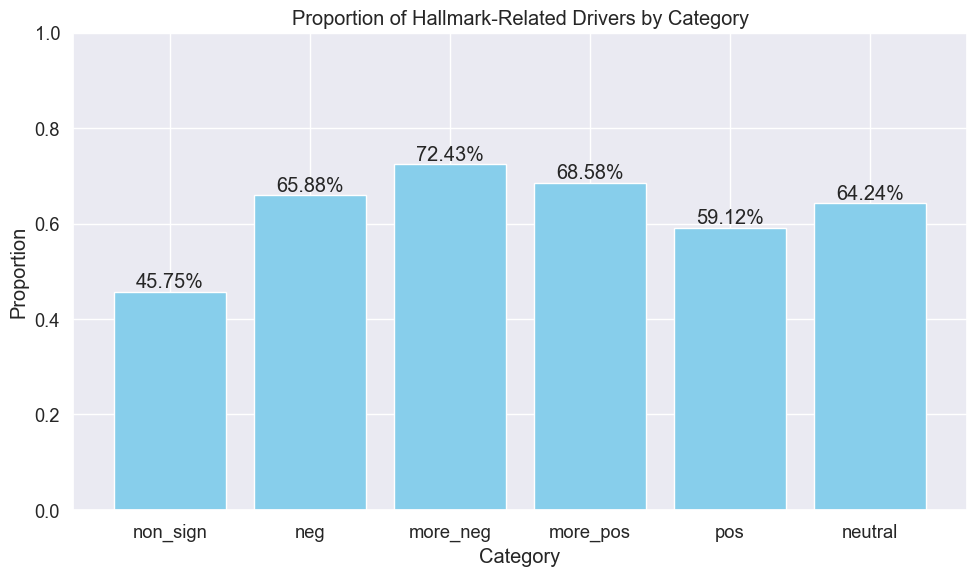

In [221]:
# Step 1: Create dictionaries to store counts for each category
category_counts = {cat: 0 for cat in category_order}
hallmark_category_counts = {cat: 0 for cat in category_order}

# Step 2: Count the drivers in each category and the hallmark drivers
for driver in driver_stats.index:
    category = driver_stats.loc[driver, 'group']
    if pd.notna(category):
        category_counts[category] += 1
        if driver in hallmark_drivers:
            hallmark_category_counts[category] += 1

# Step 3: Calculate proportions
proportions = {}
for category in category_counts.keys():
    total = category_counts[category]
    hallmark = hallmark_category_counts[category]
    proportion = hallmark / total if total > 0 else 0
    proportions[category] = proportion

# Step 4: Print results
print("Proportion of hallmark-related drivers in each category:")
for category, proportion in proportions.items():
    print(f"{category}: {proportion:.2%} ({hallmark_category_counts[category]} of {category_counts[category]})")

# Step 5: Create bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(proportions.keys(), proportions.values(), color='skyblue')
plt.title("Proportion of Hallmark-Related Drivers by Category")
plt.xlabel("Category")
plt.ylabel("Proportion")
plt.ylim(0, 1)

# Add value labels on top of each bar
for i, (category, proportion) in enumerate(proportions.items()):
    plt.text(i, proportion, f'{proportion:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



Comparison of distributions:
Category | Hallmark Drivers % | All Drivers %
---------|---------------------|---------------
non_sign |              45.75 |         50.45
neg      |              65.88 |          3.31
more_neg |              72.43 |          7.21
more_pos |              68.58 |         22.46
pos      |              59.12 |         10.68
neutral  |              64.24 |          5.89

Enrichment of hallmark drivers in each category:
non_sign: 0.91
neg: 19.88
more_neg: 10.04
more_pos: 3.05
pos: 5.53
neutral: 10.91


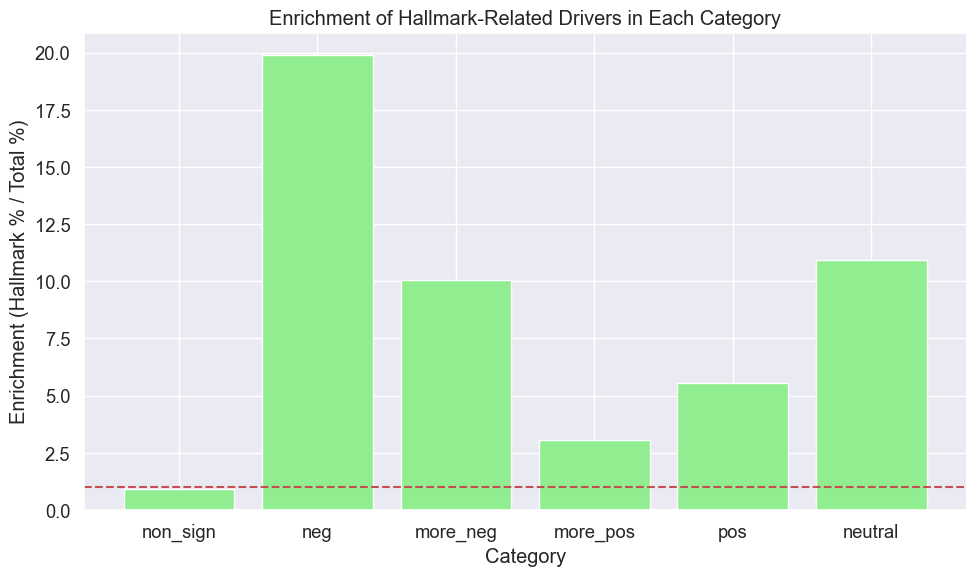

In [222]:
# Step 1: Count total drivers in each category
total_category_counts = driver_stats['group'].value_counts().to_dict()

# Step 2: Calculate percentages for all drivers
total_drivers = sum(total_category_counts.values())
total_category_percentages = {cat: count / total_drivers * 100 for cat, count in total_category_counts.items()}

print("\nComparison of distributions:")
print("Category | Hallmark Drivers % | All Drivers %")
print("---------|---------------------|---------------")
for cat in category_order:
    hallmark_percent = proportions.get(cat, 0) * 100
    total_percent = total_category_percentages.get(cat, 0)
    print(f"{cat:8} | {hallmark_percent:18.2f} | {total_percent:13.2f}")

# Step 3: Calculate enrichment of hallmark drivers
enrichment = {cat: (proportions.get(cat, 0) / (total_category_percentages.get(cat, 1) / 100)) for cat in category_order}

print("\nEnrichment of hallmark drivers in each category:")
for cat, enrich in enrichment.items():
    print(f"{cat}: {enrich:.2f}")

# Step 4: Create a bar plot for enrichment
plt.figure(figsize=(10, 6))
plt.bar(enrichment.keys(), enrichment.values(), color='lightgreen')
plt.title("Enrichment of Hallmark-Related Drivers in Each Category")
plt.xlabel("Category")
plt.ylabel("Enrichment (Hallmark % / Total %)")
plt.axhline(y=1, color='r', linestyle='--')
plt.tight_layout()
plt.show()


In [ ]:
""" with open('candidate_drivers.txt', 'r') as file:
    candidate_genes = [line.strip() for line in file]

filtered_genes = cancerdrivers.loc[cancerdrivers['type'] != 'Canonical Cancer Driver', 'symbol'].drop_duplicates()
common_genes = set(candidate_genes) & set(filtered_genes)
print(f"Genes comuns: {common_genes}")
unique_candidate_genes = set(candidate_genes) - set(filtered_genes)
print(f"Genes candidatos não presentes nos 'Non-Canonical Cancer Drivers': {unique_candidate_genes}")
non_canonical_not_in_candidates = set(filtered_genes) - set(candidate_genes)
print(f"Genes em Non-Canonical que não estão em candidate_genes: {non_canonical_not_in_candidates}")
print(len(non_canonical_not_in_candidates)) """

' with open(\'candidate_drivers.txt\', \'r\') as file:\n    candidate_genes = [line.strip() for line in file]\n\nfiltered_genes = cancerdrivers.loc[cancerdrivers[\'type\'] != \'Canonical Cancer Driver\', \'symbol\'].drop_duplicates()\ncommon_genes = set(candidate_genes) & set(filtered_genes)\nprint(f"Genes comuns: {common_genes}")\nunique_candidate_genes = set(candidate_genes) - set(filtered_genes)\nprint(f"Genes candidatos não presentes nos \'Non-Canonical Cancer Drivers\': {unique_candidate_genes}")\nnon_canonical_not_in_candidates = set(filtered_genes) - set(candidate_genes)\nprint(f"Genes em Non-Canonical que não estão em candidate_genes: {non_canonical_not_in_candidates}")\nprint(len(non_canonical_not_in_candidates)) '

In [ ]:
""" canonical = set(cancerdrivers.loc[cancerdrivers['type'] == 'Canonical Cancer Driver', 'symbol'].drop_duplicates())
in_canonical = non_canonical_not_in_candidates & canonical
print(f"Genes em Non-Canonical que estão em Canonical: {in_canonical}")
print(len(in_canonical))
 """

' canonical = set(cancerdrivers.loc[cancerdrivers[\'type\'] == \'Canonical Cancer Driver\', \'symbol\'].drop_duplicates())\nin_canonical = non_canonical_not_in_candidates & canonical\nprint(f"Genes em Non-Canonical que estão em Canonical: {in_canonical}")\nprint(len(in_canonical))\n '

### Fisher's exact test 

In [ ]:
#no fisher exact test usar os que obtive distribuição não homogénea para fazer clustering dos GO terms para semelhança semântica
#fazer clustering dos GO terms para semelhança semântica (agrupar os termos de acordo com a semelhança dos genes)
#calcular a cada 2 termos uma medida de overlap dos genes (jacard ou overlap coefficient) e fazer um dendrograma ou clustering hierárquico
#ver quais não têm uma distribuição proporcional entre essas categorias de drivers

In [ ]:
""" import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Carregar os dados
fisher_df = pd.read_csv("results_fisher_test_adjusted_2.csv")

# Selecionar termos com distribuição não homogênea (p-value ajustado < 0.05)
significant_terms = fisher_df.loc[fisher_df['adjusted.p.value'] < 0.05, 'Name'].tolist()

# Verificar os termos selecionados
print(significant_terms)
 """

' import pandas as pd\nfrom scipy.cluster.hierarchy import linkage, dendrogram\nimport matplotlib.pyplot as plt\n\n# Carregar os dados\nfisher_df = pd.read_csv("results_fisher_test_adjusted_2.csv")\n\n# Selecionar termos com distribuição não homogênea (p-value ajustado < 0.05)\nsignificant_terms = fisher_df.loc[fisher_df[\'adjusted.p.value\'] < 0.05, \'Name\'].tolist()\n\n# Verificar os termos selecionados\nprint(significant_terms)\n '

In [227]:
driver_stats = pd.read_csv('driver_stats.csv', index_col='driver')
driver_stats

n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group
driver                                                                  
A1CF              39          0          0  0.000000  0.000000  non_sign
A2ML1             91          4          3  0.043956  0.032967  more_pos
ABCA10             5          0          0  0.000000  0.000000  non_sign
ABCA13             9          3          1  0.333333  0.111111  more_pos
ABCA7             16          0          0  0.000000  0.000000  non_sign
...              ...        ...        ...       ...       ...       ...
ZSWIM3             6          0          0  0.000000  0.000000  non_sign
ZSWIM6            22          0          0  0.000000  0.000000  non_sign
ZWILCH            22          1          0  0.045455  0.000000  non_sign
ZWINT            136         22          0  0.161765  0.000000       pos
ZZEF1             89          8          2  0.089888  0.022472  more_pos

[2565 rows x 6 columns]

In [228]:
final_results_df = pd.read_csv('enrichment_results.csv')

In [229]:
combined_stat = pd.read_csv("combined_statistical_results.csv")
combined_stat_sig = combined_stat[combined_stat['adjusted.p.value'] < 0.05].copy() 
print(len(combined_stat_sig))
significant_terms = combined_stat_sig['Name'].tolist()
combined_stat_sig = final_results_df.merge(combined_stat_sig, on=['Name', 'Source'], how='inner')
print(len(combined_stat_sig))

2364
2364


In [318]:
combined_stat_sig

Source                                      Name        FE  \
882   GO:MF                        molecular_function  1.115832   
366   GO:CC                        cellular_component  1.094036   
365   GO:CC                cellular anatomical entity  1.103251   
1096  GO:BP                        biological_process  1.125522   
883   GO:MF                                   binding  1.142440   
...     ...                                       ...       ...   
1074  GO:MF  nitric-oxide synthase regulator activity  4.555730   
1049  GO:MF             ErbB-3 class receptor binding  6.378022   
859    REAC                      MET activates PTPN11  5.979396   
2297  GO:BP   oncostatin-M-mediated signaling pathway  5.979396   
1056  GO:MF            oncostatin-M receptor activity  7.972527   

                  native                                      intersections  \
882           GO:0003674  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
366           GO:0005575  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
365           GO:0110165  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
1096          GO:0008150  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
883           GO:0005488  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
...                  ...                                                ...   
1074          GO:0030235                       {AKT1, ESR1, HSP90AB1, EGFR}   
1049          GO:0043125                       {ERBB2, ERBB3, NRG1, PIK3R1}   
859   REAC:R-HSA-8865999                                 {PTPN11, HGF, MET}   
2297          GO:0038165                                {LIFR, IL6ST, OSMR}   
1056          GO:0004924                                {LIFR, IL6ST, OSMR}   

                                            description  non_sign  neg  \
882   "A molecular process that can be carried out b...      1243   85   
366   "A location, relative to cellular compartments...      1242   85   
365   "A part of a cellular organism that is either ...      1237   85   
1096  "A biological process is the execution of a ge...      1197   85   
883   "The selective, non-covalent, often stoichiome...      1136   80   
...                                                 ...       ...  ...   
1074  "Binds to and modulates the activity of nitric...         0    0   
1049  "Binding to the protein-tyrosine kinase recept...         0    1   
859                                MET activates PTPN11         0    0   
2297  "The series of molecular signals initiated by ...         0    1   
1056  "Combining with oncostatin-M and transmitting ...         0    1   

      more_neg  more_pos  pos  neutral   p.value  adjusted.p.value  \
882        182       571  269      148  0.001000          0.003337   
366        183       568  265      146  0.009495          0.022239   
365        183       566  262      145  0.003998          0.010698   
1096       181       564  260      147  0.000500          0.001899   
883        178       569  265      145  0.000500          0.001899   
...        ...       ...  ...      ...       ...               ...   
1074         3         1    0        0  0.006997          0.017152   
1049         1         1    0        1  0.018491          0.038351   
859          2         0    1        0  0.019990          0.040964   
2297         0         0    0        2  0.001499          0.004700   
1056         0         0    0        2  0.001999          0.005979   

      chi_square_p.value  cramers_v  \
882             0.002999   0.087786   
366             0.012994   0.076510   
365             0.008496   0.078591   
1096            0.000500   0.118262   
883             0.000500   0.185288   
...                  ...        ...   
1074            0.004998   0.105138   
1049            0.057471   0.069500   
859             0.021489   0.085221   
2297            0.005997   0.107683   
1056            0.004498   0.107683   

                                           distribut

In [317]:
combined_stat_sig
#ver o valor máximo em cramers_v 
combined_stat_sig['cramers_v'].max()    

0.282057352896099

In [233]:
# Sort by Fold Enrichment and Cramer's V
top_fe = combined_stat_sig.sort_values('FE', ascending=False).head(20)
top_cv = combined_stat_sig.sort_values('cramers_v', ascending=False).head(20)

# Function to calculate distribution across all categories (including neutral)
def calculate_distribution(row):
    total = row['non_sign'] + row['neg'] + row['pos'] + row['more_pos'] + row['more_neg'] + row['neutral']
    return [
        row['non_sign'] / total, 
        row['neg'] / total, 
        row['pos'] / total, 
        row['more_pos'] / total, 
        row['more_neg'] / total,
        row['neutral'] / total
    ]

# Add distribution column
combined_stat_sig['distribution'] = combined_stat_sig.apply(calculate_distribution, axis=1)

# Function to identify unusual distributions
def is_unusual_distribution(dist, threshold=0.5):
    return np.max(dist) > threshold or np.min(dist) > 0.2

# Filter for unusual distributions
unusual_dist = combined_stat_sig[combined_stat_sig['distribution'].apply(is_unusual_distribution)]


In [234]:
# Display top results
print("Top 5 terms by Fold Enrichment:")
for _, row in top_fe.head().iterrows():
    print(f"{row['Name']} (FE: {row['FE']:.2f}, Cramer's V: {row['cramers_v']:.3f})")
    print(f"Distribution: N_Sig: {row['non_sign']}, Neg: {row['neg']}, Pos: {row['pos']}, More_Pos: {row['more_pos']}, More_Neg: {row['more_neg']}, Neutral: {row['neutral']}")
    print()

Top 5 terms by Fold Enrichment:
SOS-mediated signalling (FE: 7.97, Cramer's V: 0.102)
Distribution: N_Sig: 0, Neg: 1, Pos: 0, More_Pos: 1, More_Neg: 3, Neutral: 0

oncostatin-M receptor activity (FE: 7.97, Cramer's V: 0.108)
Distribution: N_Sig: 0, Neg: 1, Pos: 0, More_Pos: 0, More_Neg: 0, Neutral: 2

mismatch repair complex (FE: 7.97, Cramer's V: 0.069)
Distribution: N_Sig: 0, Neg: 0, Pos: 1, More_Pos: 5, More_Neg: 1, Neutral: 0

phosphatidylinositol 3-kinase complex, class I (FE: 7.97, Cramer's V: 0.083)
Distribution: N_Sig: 2, Neg: 1, Pos: 1, More_Pos: 0, More_Neg: 3, Neutral: 2

Loss of Function of SMAD2/3 in Cancer (FE: 7.97, Cramer's V: 0.074)
Distribution: N_Sig: 0, Neg: 0, Pos: 0, More_Pos: 3, More_Neg: 2, Neutral: 0



In [235]:
print("Top 5 terms by Cramer's V:")
for _, row in top_cv.head().iterrows():
    print(f"{row['Name']} (Cramer's V: {row['cramers_v']:.3f}, FE: {row['FE']:.2f})")
    print(f"Distribution: N_Sig: {row['non_sign']}, Neg: {row['neg']}, Pos: {row['pos']}, More_Pos: {row['more_pos']}, More_Neg: {row['more_neg']}, Neutral: {row['neutral']}")
    print()

Top 5 terms by Cramer's V:
cellular component organization (Cramer's V: 0.282, FE: 1.46)
Distribution: N_Sig: 431, Neg: 46, Pos: 134, More_Pos: 385, More_Neg: 110, Neutral: 80

nuclear lumen (Cramer's V: 0.282, FE: 1.52)
Distribution: N_Sig: 313, Neg: 20, Pos: 131, More_Pos: 322, More_Neg: 64, Neutral: 45

cellular component organization or biogenesis (Cramer's V: 0.280, FE: 1.44)
Distribution: N_Sig: 443, Neg: 46, Pos: 138, More_Pos: 390, More_Neg: 110, Neutral: 81

intracellular non-membrane-bounded organelle (Cramer's V: 0.280, FE: 1.39)
Distribution: N_Sig: 331, Neg: 24, Pos: 126, More_Pos: 334, More_Neg: 85, Neutral: 50

non-membrane-bounded organelle (Cramer's V: 0.280, FE: 1.39)
Distribution: N_Sig: 331, Neg: 24, Pos: 126, More_Pos: 334, More_Neg: 85, Neutral: 50



In [236]:
print("Top 5 terms with unusual distributions:")
for _, row in unusual_dist.head().iterrows():
    print(f"{row['Name']} (FE: {row['FE']:.2f}, Cramer's V: {row['cramers_v']:.3f})")
    print(f"Distribution: N_Sig: {row['non_sign']}, Neg: {row['neg']}, Pos: {row['pos']}, More_Pos: {row['more_pos']}, More_Neg: {row['more_neg']}, Neutral: {row['neutral']}")
    print()

Top 5 terms with unusual distributions:
Cell cycle (FE: 2.44, Cramer's V: 0.129)
Distribution: N_Sig: 6, Neg: 0, Pos: 10, More_Pos: 26, More_Neg: 4, Neutral: 2

Cortisol synthesis and secretion (FE: 2.49, Cramer's V: 0.097)
Distribution: N_Sig: 11, Neg: 3, Pos: 0, More_Pos: 0, More_Neg: 5, Neutral: 1

Insulin secretion (FE: 2.16, Cramer's V: 0.073)
Distribution: N_Sig: 13, Neg: 2, Pos: 0, More_Pos: 2, More_Neg: 5, Neutral: 1

Fanconi anemia pathway (FE: 2.36, Cramer's V: 0.102)
Distribution: N_Sig: 1, Neg: 0, Pos: 5, More_Pos: 10, More_Neg: 0, Neutral: 0

Spliceosome (FE: 1.77, Cramer's V: 0.105)
Distribution: N_Sig: 6, Neg: 1, Pos: 7, More_Pos: 18, More_Neg: 1, Neutral: 0



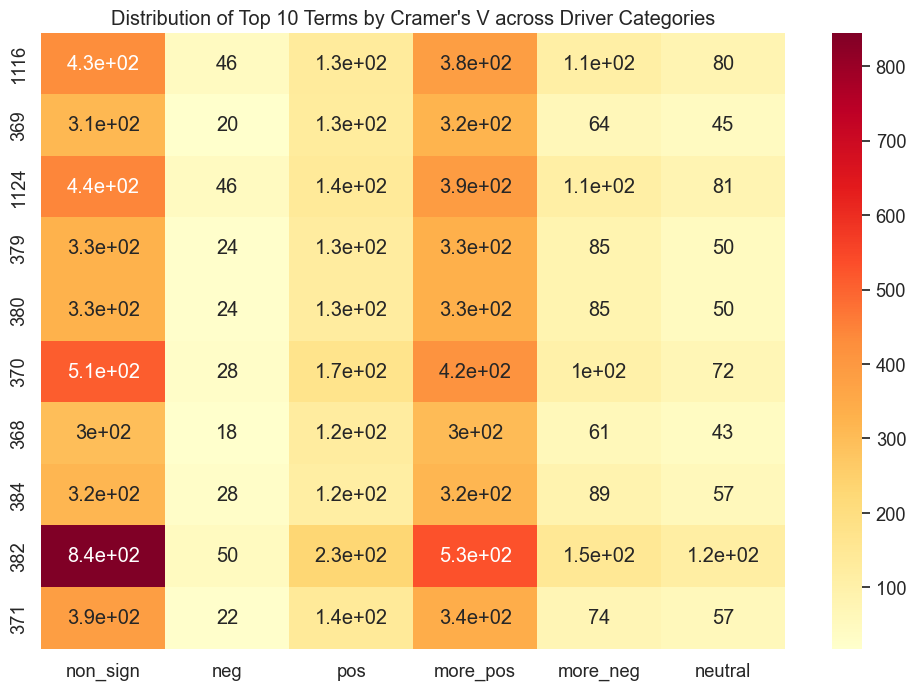

In [237]:
# Heatmap of top 10 terms by Cramer's V
plt.figure(figsize=(12, 8))
sns.heatmap(
    top_cv.head(10)[['non_sign', 'neg', 'pos', 'more_pos', 'more_neg', 'neutral']], 
    annot=True, cmap='YlOrRd'
)
plt.title('Distribution of Top 10 Terms by Cramer\'s V across Driver Categories')
plt.show()

In [319]:
#indices = [831, 808, 1019, 1012]  # The row indices from your heatmap
indices = [382]  # The row indices from your heatmap
# Retrieve the term names
terms = combined_stat_sig.loc[indices, 'Name']

print(terms)

382    intracellular organelle
Name: Name, dtype: object


#### Agglomerative Clustering 

Converting intersections to sets...
Sorting terms by the number of genes in intersections...
     Source                        Name        FE      native  \
882   GO:MF          molecular_function  1.115832  GO:0003674   
366   GO:CC          cellular_component  1.094036  GO:0005575   
365   GO:CC  cellular anatomical entity  1.103251  GO:0110165   
1096  GO:BP          biological_process  1.125522  GO:0008150   
883   GO:MF                     binding  1.142440  GO:0005488   

                                          intersections  \
882   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
366   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
365   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
1096  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
883   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   

                                            description  non_sign  neg  \
882   "A molecular process that can be carried out b...      1243   85   
366   "A loca

/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Jaccard similarity matrix calculation complete.
Jaccard matrix is now symmetric.


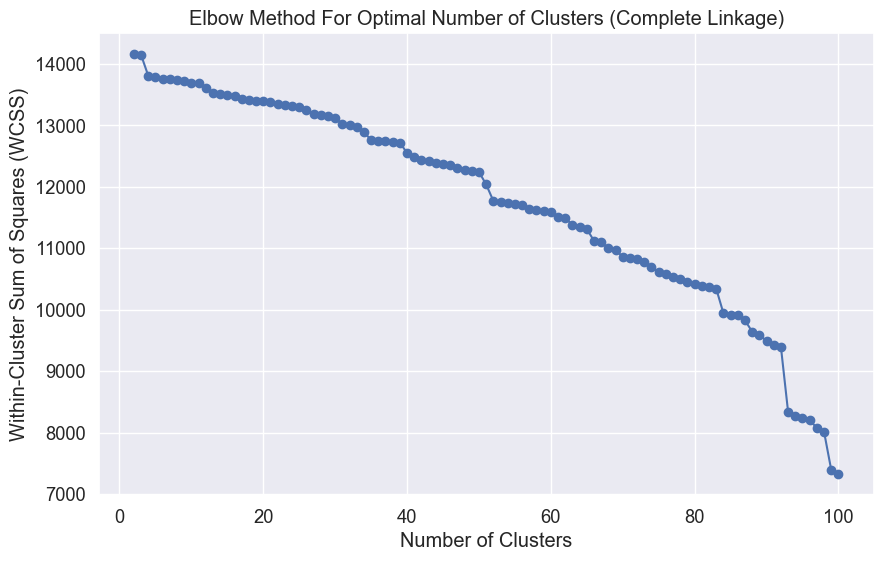

In [242]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute within-cluster sum of squares
def compute_wcss(data, labels, n_clusters):
    wcss = 0
    for i in range(n_clusters):
        cluster_data = data[labels == i]
        cluster_center = cluster_data.mean(axis=0)
        wcss += np.sum((cluster_data - cluster_center) ** 2)
    return wcss

# Function to convert string to set only if it's a string
def convert_to_set(x):
    if isinstance(x, str):
        return set(eval(x))
    return x

# Function to calculate Jaccard Similarity
def jaccard_similarity(genes_i, genes_j):
    return len(genes_i & genes_j) / len(genes_i | genes_j)

# Convert `intersections` from string representation to set if necessary
print("Converting intersections to sets...")
combined_stat_sig['intersections'] = combined_stat_sig['intersections'].apply(convert_to_set)

# Sort terms by the number of genes in the intersections
print("Sorting terms by the number of genes in intersections...")
combined_stat_sig['num_genes'] = combined_stat_sig['intersections'].apply(len)
combined_stat_sig = combined_stat_sig.sort_values('num_genes', ascending=False)
print(combined_stat_sig.head())

# Initialize the Jaccard similarity matrix
n = len(combined_stat_sig)
jaccard_matrix = np.zeros((n, n))
print(f"Initialized Jaccard matrix of size {n}x{n}")

# Calculate Jaccard Similarity in parallel
def compute_row(i):
    genes_i = combined_stat_sig.iloc[i]['intersections']
    row = np.zeros(n)
    for j in range(i+1, n):
        genes_j = combined_stat_sig.iloc[j]['intersections']
        row[j] = jaccard_similarity(genes_i, genes_j)
    return row

# Parallelize the computation
print("Calculating Jaccard similarities...")
jaccard_matrix = np.array(Parallel(n_jobs=-1)(delayed(compute_row)(i) for i in range(n)))
print("Jaccard similarity matrix calculation complete.")

# Make the matrix symmetric
jaccard_matrix = jaccard_matrix + jaccard_matrix.T
print("Jaccard matrix is now symmetric.")

# Elbow method to find the optimal number of clusters
max_clusters = 100  # You can increase this number depending on your needs
wcss_values = []

for k in range(2, max_clusters + 1):  # Start from 2 clusters
    clustering = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='complete')
    labels = clustering.fit_predict(1 - jaccard_matrix)
    wcss = compute_wcss(jaccard_matrix, labels, k)
    wcss_values.append(wcss)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), wcss_values, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters (Complete Linkage)')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()


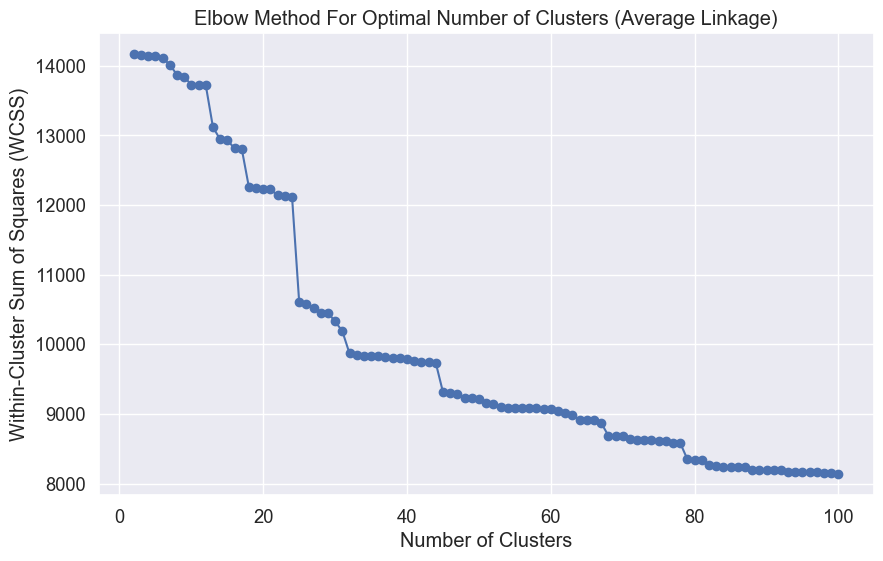

In [243]:
wcss_values = []

for k in range(2, max_clusters + 1):  # Start from 2 clusters
    clustering = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    labels = clustering.fit_predict(1 - jaccard_matrix)
    wcss = compute_wcss(jaccard_matrix, labels, k)
    wcss_values.append(wcss)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), wcss_values, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters (Average Linkage)')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()


In [244]:
from scipy.cluster.hierarchy import cophenet, linkage
from scipy.spatial.distance import pdist

# Calculate linkage matrix for the distance matrix using the 'average' linkage method
linkage_matrix = linkage(1 - jaccard_matrix, method='average')

# Calculate the cophenetic correlation coefficient
coph_corr, coph_dist = cophenet(linkage_matrix, pdist(1 - jaccard_matrix))

print(f"Cophenetic Correlation Coefficient (Average Linkage): {coph_corr:.4f}")

# Optionally, repeat for complete linkage or other methods
linkage_matrix_complete = linkage(1 - jaccard_matrix, method='complete')
coph_corr_complete, _ = cophenet(linkage_matrix_complete, pdist(1 - jaccard_matrix))

print(f"Cophenetic Correlation Coefficient (Complete Linkage): {coph_corr_complete:.4f}")


Cophenetic Correlation Coefficient (Average Linkage): 0.8313
Cophenetic Correlation Coefficient (Complete Linkage): 0.6871


Average Linkage: Silhouette Score = -0.9948, Davies-Bouldin Score = 1.8613
Complete Linkage: Silhouette Score = -0.9984, Davies-Bouldin Score = 2.2068


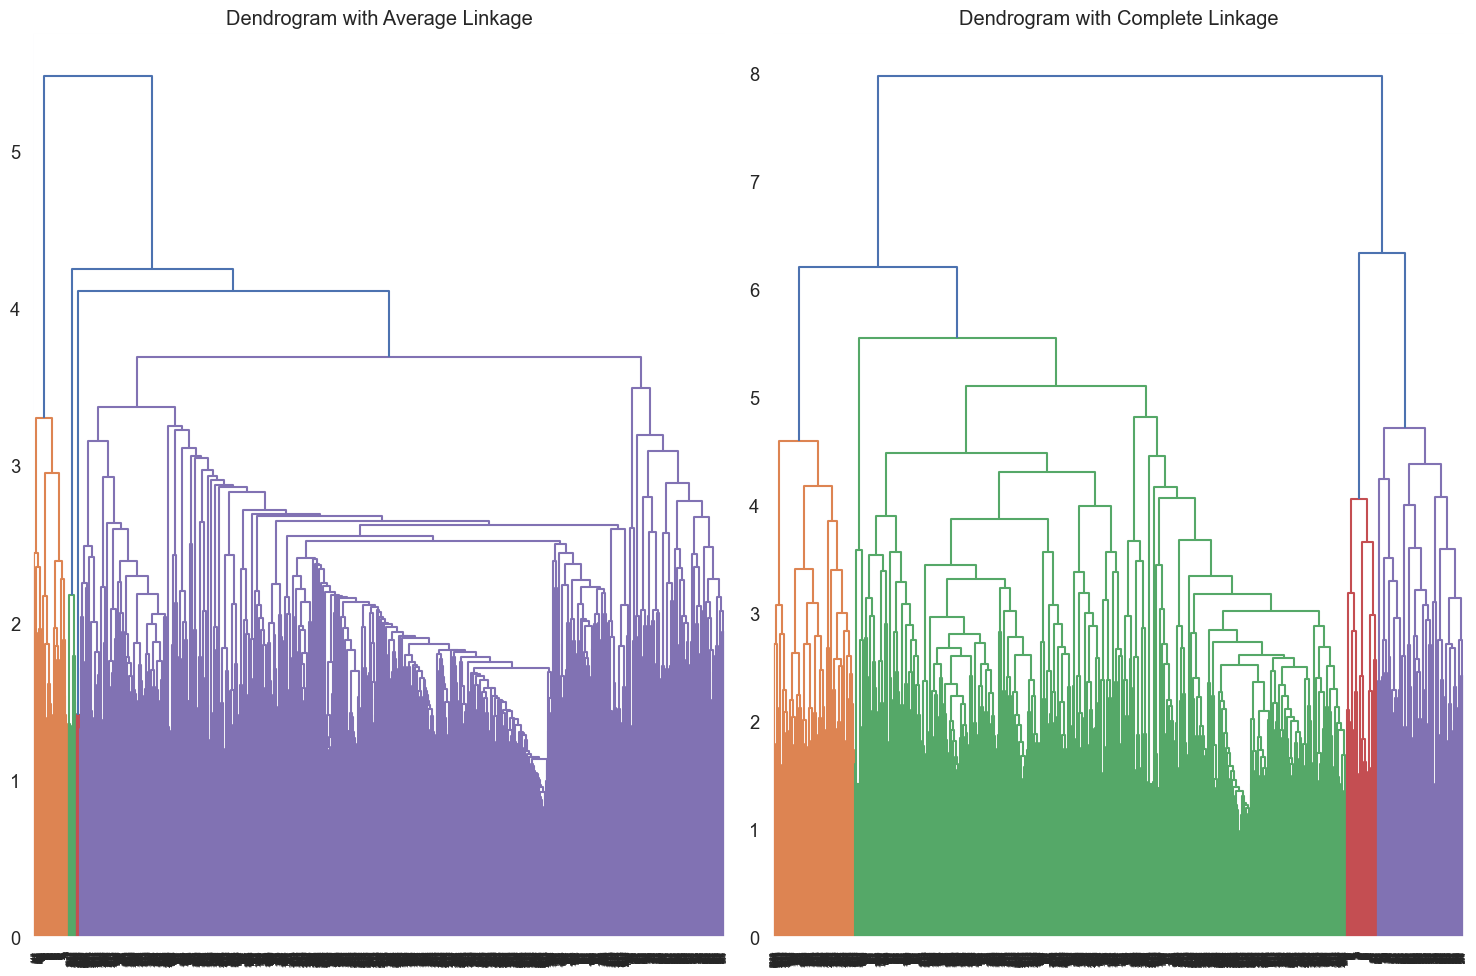

In [245]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

#  Function to perform clustering and calculate metrics
def perform_clustering(jaccard_matrix, n_clusters, linkage_method):
    distance_matrix = 1 - jaccard_matrix
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage=linkage_method)
    labels = clustering.fit_predict(distance_matrix)
    silhouette = silhouette_score(jaccard_matrix, labels, metric='precomputed')
    davies_bouldin = davies_bouldin_score(jaccard_matrix, labels)
    return labels, silhouette, davies_bouldin

n_clusters = 100

# Perform clustering with average and complete linkage
labels_avg, silhouette_avg, davies_bouldin_avg = perform_clustering(jaccard_matrix, n_clusters, 'average')
labels_complete, silhouette_complete, davies_bouldin_complete = perform_clustering(jaccard_matrix, n_clusters, 'complete')

print(f"Average Linkage: Silhouette Score = {silhouette_avg:.4f}, Davies-Bouldin Score = {davies_bouldin_avg:.4f}")
print(f"Complete Linkage: Silhouette Score = {silhouette_complete:.4f}, Davies-Bouldin Score = {davies_bouldin_complete:.4f}")

distance_matrix = 1 - jaccard_matrix
# Visual comparison of dendrograms
plt.figure(figsize=(15, 10))
plt.subplot(121)
dendrogram(linkage(distance_matrix, method='average'))
plt.title("Dendrogram with Average Linkage")
plt.subplot(122)
dendrogram(linkage(distance_matrix, method='complete'))
plt.title("Dendrogram with Complete Linkage")
plt.tight_layout()
plt.show()


In [247]:
driver_stats

n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group
driver                                                                  
A1CF              39          0          0  0.000000  0.000000  non_sign
A2ML1             91          4          3  0.043956  0.032967  more_pos
ABCA10             5          0          0  0.000000  0.000000  non_sign
ABCA13             9          3          1  0.333333  0.111111  more_pos
ABCA7             16          0          0  0.000000  0.000000  non_sign
...              ...        ...        ...       ...       ...       ...
ZSWIM3             6          0          0  0.000000  0.000000  non_sign
ZSWIM6            22          0          0  0.000000  0.000000  non_sign
ZWILCH            22          1          0  0.045455  0.000000  non_sign
ZWINT            136         22          0  0.161765  0.000000       pos
ZZEF1             89          8          2  0.089888  0.022472  more_pos

[2565 rows x 6 columns]

Performing Agglomerative Clustering with 93 clusters...
Clustering complete. Cluster labels assigned.
                            Name  Cluster
882           molecular_function        4
366           cellular_component        4
365   cellular anatomical entity        4
1096          biological_process        4
883                      binding        4
Clusters and their terms:
   Cluster                                              Terms  \
0        0  [response to stimulus, multicellular organisma...   
1        1  [anchoring junction, calcium ion binding, cell...   
2        2  [external encapsulating structure, extracellul...   
3        3  [Transcriptional Regulation by TP53, immune sy...   
4        4  [molecular_function, cellular_component, cellu...   

                                      Combined Genes  
0  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...  
1  {NOTCH2, EPHA2, ITK, PLSCR4, FBLN2, SNX19, PCD...  
2  {CTSS, EPHA2, SRPX, FBLN2, SOS1, NTRK2, COL7A1...  
3  {EPHA2

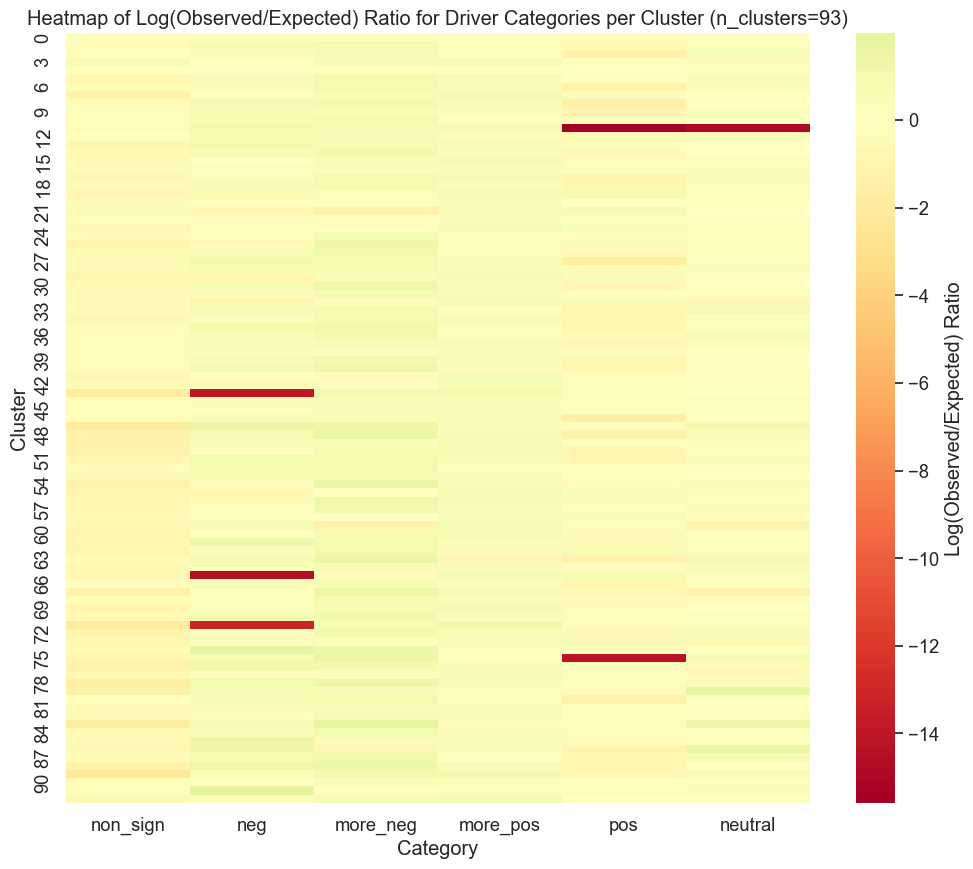

In [248]:
# Clustering
n_clusters = 93
print(f"Performing Agglomerative Clustering with {n_clusters} clusters...")
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
labels = clustering.fit_predict(1 - jaccard_matrix)  # 1 - jaccard_matrix to convert to distance matrix
print("Clustering complete. Cluster labels assigned.")

# Add the cluster labels to the dataframe
combined_stat_sig['Cluster'] = labels
print(combined_stat_sig[['Name', 'Cluster']].head())

# Group the terms by their clusters
clustered_terms = []
for cluster_label in np.unique(labels):
    cluster_terms = combined_stat_sig[combined_stat_sig['Cluster'] == cluster_label]
    term_names = cluster_terms['Name'].tolist()
    combined_genes = set().union(*cluster_terms['intersections'])
    clustered_terms.append({'Cluster': cluster_label, 'Terms': term_names, 'Combined Genes': combined_genes})

# Convert to DataFrame
cluster_df = pd.DataFrame(clustered_terms)
print("Clusters and their terms:")
print(cluster_df.head())

# Step 2: Calculate total number of drivers per category using the `group` column in driver_stats
print("Calculating total number of drivers per category...")
total_drivers = driver_stats['group'].value_counts().to_dict()
epsilon = 1e-6  # Small value to avoid division by zero in log calculations
print(total_drivers)

# Initialize data structure to store cluster information
heatmap_data = []
print("Building heatmap data...")

# Iterate over clusters and calculate category counts and log ratios
for idx, row in cluster_df.iterrows():
    cluster_label = row['Cluster']
    combined_genes = row['Combined Genes']
    num_combined_genes = len(combined_genes)    
    
    # Count the number of drivers in each category for the current cluster
    category_counts = {category: 0 for category in total_drivers.keys()}
    for gene in combined_genes:
        if gene in driver_stats.index:  # Use driver as the index
            category = driver_stats.loc[gene, 'group']  # Access the 'group' column
            if category in category_counts:
                category_counts[category] += 1
    
    print(f"Cluster {cluster_label} - Category counts: {category_counts}")
    
    # Compute the log-transformed observed/expected ratio for each category
    for category in category_counts.keys():
        observed = category_counts[category]
        expected = total_drivers[category] * (num_combined_genes / len(driver_stats))  # Scale by total drivers
        
        # Add epsilon to avoid log(0)
        log_ratio = np.log((observed + epsilon) / (expected + epsilon))
        
        heatmap_data.append({
            'Cluster': cluster_label,  # Store cluster as integer
            'Category': category,
            'LogRatio': log_ratio
        })

# Step 3: Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data)
print("Heatmap data:")
print(heatmap_df.head())

# Pivot the DataFrame to have clusters as rows and categories as columns
heatmap_pivot = heatmap_df.pivot(index="Cluster", columns="Category", values="LogRatio")

# Ensure clusters are sorted numerically and categories are in the specified order, including 'neutral'
heatmap_pivot = heatmap_pivot.sort_index(ascending=True)
heatmap_pivot = heatmap_pivot[['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']]  # Include 'neutral' in the column order
print("Pivoted heatmap data:")
print(heatmap_pivot.head())

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_pivot, annot=False, cmap="RdYlGn", center=0, cbar_kws={'label': 'Log(Observed/Expected) Ratio'})
plt.title(f"Heatmap of Log(Observed/Expected) Ratio for Driver Categories per Cluster (n_clusters={n_clusters})")
plt.show()


In [251]:
# Identify clusters with extreme values (very low and very high log-ratio values)
extreme_clusters_93 = heatmap_df[(heatmap_df['LogRatio'] <= -12) | (heatmap_df['LogRatio'] >= 1)]
print("Clusters with extreme log-ratio values:")
print(extreme_clusters_93)

Clusters with extreme log-ratio values:
     Cluster  Category   LogRatio
68        11       pos -15.586258
70        11   neutral -14.990410
71        11       neg   1.009167
153       25  more_neg   1.279431
159       26  more_neg   1.097882
167       27       neg   1.124680
183       30  more_neg   1.313681
213       35  more_neg   1.136454
219       36  more_neg   1.042909
237       39  more_neg   1.023498
243       40  more_neg   1.194273
263       43       neg -13.874185
285       47  more_neg   1.376594
287       47       neg   1.461151
291       48  more_neg   1.459286
311       51       neg   1.017466
315       52  more_neg   1.058760
327       54  more_neg   1.494378
339       56  more_neg   1.264117
345       57  more_neg   1.053821
371       61       neg   1.178585
381       63  more_neg   1.459286
395       65       neg -14.551583
405       67  more_neg   1.455238
423       70  more_neg   1.009449
427       71  more_pos   1.088141
431       71       neg -13.116500
435     

In [ ]:
# Identify clusters with extreme values (very low and very high log-ratio values)
extreme_clusters_75 = heatmap_df[(heatmap_df['LogRatio'] <= -19) | (heatmap_df['LogRatio'] >= 2)]
print("Clusters with extreme log-ratio values:")
print(extreme_clusters_75)

Clusters with extreme log-ratio values:
     Cluster  Category   LogRatio
195       39     N_Sig -21.027067
196       39  More_Pos -20.134479
197       39  More_Neg   2.176001
198       39       Pos -19.471502
224       44       Neg   2.078402
277       55  More_Neg -19.488834
288       57       Pos -19.471502
289       57       Neg   2.301546
307       61  More_Neg -19.488834
315       63     N_Sig -21.027067
316       63  More_Pos -20.134479
319       63       Neg   2.119224
355       71     N_Sig -21.027067
357       71  More_Neg -19.488834
358       71       Pos -19.471502


Converting intersections to sets...
Sorting terms by the number of genes in intersections...
     Source                        Name        FE      native  \
882   GO:MF          molecular_function  1.115832  GO:0003674   
366   GO:CC          cellular_component  1.094036  GO:0005575   
365   GO:CC  cellular anatomical entity  1.103251  GO:0110165   
1096  GO:BP          biological_process  1.125522  GO:0008150   
883   GO:MF                     binding  1.142440  GO:0005488   

                                          intersections  \
882   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
366   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
365   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
1096  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
883   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   

                                            description  non_sign  neg  \
882   "A molecular process that can be carried out b...      1243   85   
366   "A loca

/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Jaccard similarity matrix calculation complete.
Jaccard matrix is now symmetric.
Performing Agglomerative Clustering with 100 clusters...
Clustering complete. Cluster labels assigned.
                            Name  Cluster
882           molecular_function        4
366           cellular_component        4
365   cellular anatomical entity        4
1096          biological_process        4
883                      binding        4
Clusters and their terms:
   Cluster                                              Terms  \
0        0  [response to stimulus, multicellular organisma...   
1        1  [anchoring junction, calcium ion binding, cell...   
2        2  [cellular catabolic process, transferase activ...   
3        3  [external encapsulating structure, extracellul...   
4        4  [molecular_function, cellular_component, cellu...   

                                      Combined Genes  
0  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...  
1  {NOTCH2, EPHA2, ITK, PLSCR4, FBLN2

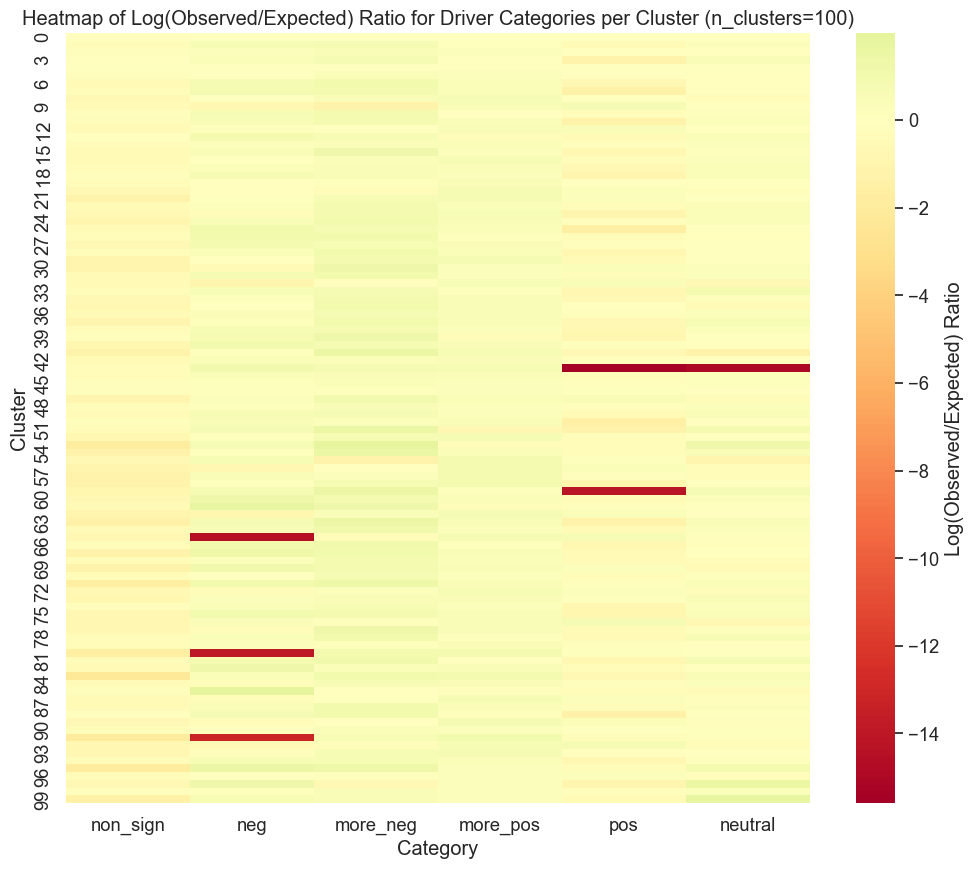

In [252]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt

# Function to convert string to set only if it's a string
def convert_to_set(x):
    if isinstance(x, str):
        return set(eval(x))
    return x
# Function to calculate Jaccard Similarity
def jaccard_similarity(genes_i, genes_j):
    return len(genes_i & genes_j) / len(genes_i | genes_j)

# Convert `intersections` from string representation to set if necessary
print("Converting intersections to sets...")
combined_stat_sig['intersections'] = combined_stat_sig['intersections'].apply(convert_to_set)

# Sort terms by the number of genes in the intersections
print("Sorting terms by the number of genes in intersections...")
combined_stat_sig['num_genes'] = combined_stat_sig['intersections'].apply(len)
combined_stat_sig = combined_stat_sig.sort_values('num_genes', ascending=False)
print(combined_stat_sig.head())

# Initialize the Jaccard similarity matrix
n = len(combined_stat_sig)
jaccard_matrix = np.zeros((n, n))
print(f"Initialized Jaccard matrix of size {n}x{n}")

# Calculate Jaccard Similarity in parallel
def compute_row(i):
    genes_i = combined_stat_sig.iloc[i]['intersections']
    row = np.zeros(n)
    for j in range(i+1, n):
        genes_j = combined_stat_sig.iloc[j]['intersections']
        row[j] = jaccard_similarity(genes_i, genes_j)
    return row

# Parallelize the computation
print("Calculating Jaccard similarities...")
jaccard_matrix = np.array(Parallel(n_jobs=-1)(delayed(compute_row)(i) for i in range(n)))
print("Jaccard similarity matrix calculation complete.")

# Make the matrix symmetric
jaccard_matrix = jaccard_matrix + jaccard_matrix.T
print("Jaccard matrix is now symmetric.")

# Clustering
n_clusters = 100
print(f"Performing Agglomerative Clustering with {n_clusters} clusters...")
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
labels = clustering.fit_predict(1 - jaccard_matrix)  # 1 - jaccard_matrix to convert to distance matrix
print("Clustering complete. Cluster labels assigned.")

# Add the cluster labels to the dataframe
combined_stat_sig['Cluster'] = labels
print(combined_stat_sig[['Name', 'Cluster']].head())

# Group the terms by their clusters
clustered_terms = []
for cluster_label in np.unique(labels):
    cluster_terms = combined_stat_sig[combined_stat_sig['Cluster'] == cluster_label]
    term_names = cluster_terms['Name'].tolist()
    combined_genes = set().union(*cluster_terms['intersections'])
    clustered_terms.append({'Cluster': cluster_label, 'Terms': term_names, 'Combined Genes': combined_genes})

# Convert to DataFrame
cluster_df = pd.DataFrame(clustered_terms)
print("Clusters and their terms:")
print(cluster_df.head())

# Step 2: Calculate total number of drivers per category using the `group` column in driver_stats
print("Calculating total number of drivers per category...")
total_drivers = driver_stats['group'].value_counts().to_dict()
epsilon = 1e-6  # Small value to avoid division by zero in log calculations
print(total_drivers)

# Initialize data structure to store cluster information
heatmap_data = []
print("Building heatmap data...")

# Iterate over clusters and calculate category counts and log ratios
for idx, row in cluster_df.iterrows():
    cluster_label = row['Cluster']
    combined_genes = row['Combined Genes']
    num_combined_genes = len(combined_genes)    
    
    # Count the number of drivers in each category for the current cluster
    category_counts = {category: 0 for category in total_drivers.keys()}
    for gene in combined_genes:
        if gene in driver_stats.index:  # Use driver as the index
            category = driver_stats.loc[gene, 'group']  # Access the 'group' column
            if category in category_counts:
                category_counts[category] += 1
    
    print(f"Cluster {cluster_label} - Category counts: {category_counts}")
    
    # Compute the log-transformed observed/expected ratio for each category
    for category in category_counts.keys():
        observed = category_counts[category]
        expected = total_drivers[category] * (num_combined_genes / len(driver_stats))  # Scale by total drivers
        
        # Add epsilon to avoid log(0)
        log_ratio = np.log((observed + epsilon) / (expected + epsilon))
        
        heatmap_data.append({
            'Cluster': cluster_label,  # Store cluster as integer
            'Category': category,
            'LogRatio': log_ratio
        })

# Step 3: Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data)
print("Heatmap data:")
print(heatmap_df.head())

# Pivot the DataFrame to have clusters as rows and categories as columns
heatmap_pivot = heatmap_df.pivot(index="Cluster", columns="Category", values="LogRatio")

# Ensure clusters are sorted numerically and categories are in the specified order, including 'neutral'
heatmap_pivot = heatmap_pivot.sort_index(ascending=True)
heatmap_pivot = heatmap_pivot[['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']]  # Include 'neutral' in the column order
print("Pivoted heatmap data:")
print(heatmap_pivot.head())

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_pivot, annot=False, cmap="RdYlGn", center=0, cbar_kws={'label': 'Log(Observed/Expected) Ratio'})
plt.title(f"Heatmap of Log(Observed/Expected) Ratio for Driver Categories per Cluster (n_clusters={n_clusters})")
plt.show()


In [ ]:
# Identify clusters with extreme values (very low and very high log-ratio values)
extreme_clusters = heatmap_df[(heatmap_df['LogRatio'] <= -19) | (heatmap_df['LogRatio'] >= 2)]
print("Clusters with extreme log-ratio values:")
print(extreme_clusters)

Clusters with extreme log-ratio values:
     Cluster  Category   LogRatio
253       50       Pos -19.474993
295       59     N_Sig -21.012946
407       81  More_Neg -19.492264
449       89       Neg   2.071750
477       95  More_Neg -19.492264
478       95       Pos -19.474993
497       99  More_Neg -19.492264


#### Hallmarks

In [264]:
import ast

for source in sources:
    if source.startswith('GO:BP'):
        dic = combined_stat_sig[combined_stat_sig['Source'] == source]
        dic_filt_hall = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                 left_on='native', right_on='GO terms', how='inner')

In [322]:
dic_filt_hall

Source                                               Name        FE  \
0   GO:BP                      cell population proliferation  1.905863   
1   GO:BP                              programmed cell death  1.756796   
2   GO:BP                                         cell cycle  1.719478   
3   GO:BP                                      cell adhesion  2.013050   
4   GO:BP                regulation of programmed cell death  1.873064   
5   GO:BP                       cell projection organization  1.736195   
6   GO:BP                                     cell migration  1.806820   
7   GO:BP                                    immune response  1.407183   
8   GO:BP         negative regulation of signal transduction  1.773747   
9   GO:BP  positive regulation of cell population prolife...  2.052001   
10  GO:BP       negative regulation of programmed cell death  1.928980   
11  GO:BP                        regulation of cell adhesion  2.188336   
12  GO:BP                         cell junction organization  1.914248   
13  GO:BP  negative regulation of cell population prolife...  2.004521   
14  GO:BP                      regulation of immune response  1.583522   
15  GO:BP                                         DNA repair  2.046639   
17  GO:BP                                       angiogenesis  2.160778   
16  GO:BP                                      cell division  1.781227   
18  GO:BP                  negative regulation of cell cycle  2.039484   
19  GO:BP                  negative regulation of cell cycle  2.039484   
20  GO:BP                  positive regulation of cell cycle  1.871811   
21  GO:BP               negative regulation of cell adhesion  2.197375   
22  GO:BP                regulation of inflammatory response  1.538933   
23  GO:BP                           regulation of DNA repair  1.919312   
24  GO:BP               epithelial to mesenchymal transition  2.512554   
25  GO:BP                positive regulation of angiogenesis  2.367599   
26  GO:BP                              telomere organization  1.898221   
27  GO:BP                               telomere maintenance  2.119279   
28  GO:BP                 DNA integrity checkpoint signaling  2.334812   
29  GO:BP                 positive regulation of cell growth  1.750067   
30  GO:BP                                     vasculogenesis  2.942242   
31  GO:BP  DNA-templated DNA replication maintenance of f...  2.562598   

        native                                      intersections  \
0   GO:0008283  {NOTCH2, LEPR, SOS1, IKZF3, ZNF503, ARID2, LMO...   
1   GO:0012501  {NOTCH2, CTSS, IKZF3, ACVR1B, PIK3CB, APC, PRK...   
2   GO:0007049  {AHCTF1, ZNF503, ARID2, ACVR1B, APC, MAP1S, RX...   
3   GO:0007155  {PCDHB6, ARID2, PIK3CB, TENM2, APC, CHL1, ST6G...   
4   GO:0043067  {NOTCH2, CTSS, IKZF3, PIK3CB, APC, PRKCI, CHL1...   
5   GO:0030030  {NOTCH2, SCN11A, SOS1, TENM2, APC, PRKCI, CHL1...   
6   GO:0016477  {SOS1, ARID2, ACVR1B, PIK3CB, APC, PRKCI, CHL1...   
7   GO:0006955  {NOTCH2, CTSS, SCN11A, SOS1, RAPGEF3, OTOP1, D...   
8   GO:0009968  {FBN2, EPHA2, MAPK7, NRG1, BCL2, PRKDC, NFATC4...   
9   GO:0008284  {NOTCH2, ODC1, OSR2, NRG1, BCL2, NTRK2, PTK2, ...   
10  GO:0043069  {NOTCH2, MAPK7, RAG1, NRG1, BCL2, PRKDC, NTRK2...   
11  GO:0030155  {EPHA2, FBLN2, MAPK7, RAG1, NRG1, BCL2, ARID2,...   
12  GO:0034330  {EPHA2, PCDH17, LRRC4C, PCDHB6, BCL2, CDH9, CD...   
13  GO:0008285  {SRPX, BCL2, ARID2, NOTCH1, APC, SLC4A2, MED1,...   
14  GO:0050776  {CTSS, ITK, SOS1, TLR7, BCL2, PRKDC, PTK2, CD7...   
15  GO:0006281  {MSH6, POLG, UBR5, MLH3, PRKDC, ARID2, FANCA, ...   
17  GO:0001525  {NOTCH2, EPHA2, LEPR, MAPK7, RAPGEF3, PTK2, NF...   
16  GO:0051301  {AHCTF1, CDC27, PIK3CB, GOLGA2, NOTCH1, APC, R...   
18  GO:0045786  {TP53BP2, BCL2, PRKDC, BRSK1, APC, MDC1, CRADD...   
19  GO:0045786  {TP53BP2, BCL2, PRKDC, BRSK1, APC, MDC1, CRADD...   
20  GO:0045787  {RXFP3, MED1, TBX3, PLRG1, FEN1, RPTOR, PHIP, ...   
21  GO:0007162  {MAPK7, PTK2, NOTCH1, SLC4

In [265]:
# Convert 'intersections' from string to list
#dic_filt_hall['intersections'] = dic_filt_hall['intersections'].apply(ast.literal_eval)

# Calculate the number of genes in each intersection and sort the DataFrame
dic_filt_hall['num_genes'] = dic_filt_hall['intersections'].apply(len)
dic_filt_hall = dic_filt_hall.sort_values('num_genes', ascending=False)

# Create a dictionary with gene sets for each term
gene_sets = {row['Name']: set(row['intersections']) for _, row in dic_filt_hall.iterrows()}

# Function to determine if terms should be grouped
def should_group_terms(max_genes_set, genes):
    intersection_size = len(max_genes_set.intersection(genes))
    return (intersection_size / len(max_genes_set) >= 0.5 and 
            intersection_size / len(genes) >= 0.5)

# Group terms based on gene set overlaps
grouped_terms = []

for term, genes in gene_sets.items():
    added_to_group = False
    for group in grouped_terms:
        max_genes_set = max((gene_sets[t] for t in group['terms']), key=len)
        if should_group_terms(max_genes_set, genes):
            group['terms'].append(term)
            group['genes'] = list(set(group['genes']).union(genes))
            added_to_group = True
            break  
    
    if not added_to_group:
        grouped_terms.append({'terms': [term], 'genes': list(genes)})

# Convert the grouped terms into a DataFrame
grouped_df = pd.DataFrame(grouped_terms)
grouped_df['num_terms'] = grouped_df['terms'].apply(len)
grouped_df['num_genes'] = grouped_df['genes'].apply(len)
grouped_df = grouped_df.sort_values('num_terms', ascending=False)

In [266]:
# Function to get Hallmarks and descriptions for a group of terms
def get_hallmarks_and_descriptions(terms, dic_filt_hall):
    hallmarks = set()
    descriptions = set()
    for term in terms:
        term_data = dic_filt_hall[dic_filt_hall['Name'] == term]
        if not term_data.empty:
            hallmarks.update(term_data['Hallmarks'].iloc[0].split(', '))
            descriptions.add(term_data['description'].iloc[0])
    return list(hallmarks), list(descriptions)

# Apply the function to each row in grouped_df
grouped_df['Hallmarks'], grouped_df['descriptions'] = zip(*grouped_df['terms'].apply(
    lambda x: get_hallmarks_and_descriptions(x, dic_filt_hall)
))

# Convert lists to strings for better visualization
grouped_df['Hallmarks'] = grouped_df['Hallmarks'].apply(lambda x: ', '.join(x))
grouped_df['descriptions'] = grouped_df['descriptions'].apply(lambda x: '; '.join(x))


In [267]:
grouped_df.head()

terms  \
1   [programmed cell death, regulation of programm...   
0   [cell population proliferation, positive regul...   
3        [cell adhesion, regulation of cell adhesion]   
6    [immune response, regulation of immune response]   
20      [telomere organization, telomere maintenance]   

                                                genes  num_terms  num_genes  \
1   [NOTCH2, CTSS, IKZF3, ACVR1B, PIK3CB, APC, PRK...          3        433   
0   [NOTCH2, LEPR, SOS1, IKZF3, ZNF503, ARID2, LMO...          2        475   
3   [EPHA2, SRPX, FBLN2, PCDHB6, LRRC4C, CDH9, ARI...          2        379   
6   [NOTCH2, CTSS, ITK, SCN11A, SOS1, TLR7, PRKDC,...          2        311   
20  [HNRNPD, PRKDC, HSP90AB1, HNRNPA2B1, SMG1, XRC...          2         45   

                             Hallmarks  \
1                    Resist Cell Death   
0   Sustaining Proliferative Signaling   
3   Activating Invasion and Metastasis   
6          Avoiding Immune Destruction   
20    Enabling Replicative Immortality   

                                         descriptions  
1   "Any process that modulates the frequency, rat...  
0   "The multiplication or reproduction of cells, ...  
3   "Any process that modulates the frequency, rat...  
6   "Any process that modulates the frequency, rat...  
20  "A process that is carried out at the cellular...

In [268]:
# Step 1: Calculate the total number of genes in each category based on 'group' column in driver_stats
total_genes_per_category = driver_stats['group'].value_counts()

# Step 2: Define a function to count the gene categories based on the 'group' column in driver_stats
def count_gene_categories(gene_list, driver_stats):
    gene_set = set(gene_list)  # Convert gene list to a set to remove duplicates
    categories = {'non_sign': 0, 'neg': 0, 'more_neg': 0, 'more_pos': 0, 'pos': 0, 'neutral': 0}  # Include 'neutral'
    
    for gene in gene_set:
        if gene in driver_stats.index:  # Check if gene is in driver_stats index
            category = driver_stats.loc[gene, 'group']  # Access the 'group' column
            if category in categories:  # Ensure the category is valid
                categories[category] += 1  # Increment the count for the respective category
    
    return categories

# Step 3: Apply the function to count the categories of genes in each row of 'grouped_df'
category_counts = grouped_df['genes'].apply(lambda x: count_gene_categories(x, driver_stats))

# Step 4: Add new columns for each category (both count and proportion) to 'grouped_df'
for category in ['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']:  # Include 'neutral'
    # Create columns for the count of genes in each category
    grouped_df[f'{category}_count'] = category_counts.apply(lambda x: x[category])
    
    # Calculate proportions based on total genes in each category
    total_genes = total_genes_per_category.get(category, 1)  # Get total number of genes in the category
    grouped_df[f'{category}_proportion'] = grouped_df[f'{category}_count'] / total_genes  # Calculate proportion

# Step 5: Display the updated DataFrame
display(grouped_df)


terms  \
1   [programmed cell death, regulation of programm...   
0   [cell population proliferation, positive regul...   
3        [cell adhesion, regulation of cell adhesion]   
6    [immune response, regulation of immune response]   
20      [telomere organization, telomere maintenance]   
14                [positive regulation of cell cycle]   
23                                   [vasculogenesis]   
22               [positive regulation of cell growth]   
21               [DNA integrity checkpoint signaling]   
19              [positive regulation of angiogenesis]   
18             [epithelial to mesenchymal transition]   
17                         [regulation of DNA repair]   
16              [regulation of inflammatory response]   
15             [negative regulation of cell adhesion]   
12                                    [cell division]   
13                [negative regulation of cell cycle]   
11                                     [angiogenesis]   
10                                       [DNA repair]   
9   [negative regulation of cell population prolif...   
8                        [cell junction organization]   
7        [negative regulation of signal transduction]   
5                                    [cell migration]   
4                      [cell projection organization]   
2                                        [cell cycle]   
24  [DNA-templated DNA replication maintenance of ...   

                                                genes  num_terms  num_genes  \
1   [NOTCH2, CTSS, IKZF3, ACVR1B, PIK3CB, APC, PRK...          3        433   
0   [NOTCH2, LEPR, SOS1, IKZF3, ZNF503, ARID2, LMO...          2        475   
3   [EPHA2, SRPX, FBLN2, PCDHB6, LRRC4C, CDH9, ARI...          2        379   
6   [NOTCH2, CTSS, ITK, SCN11A, SOS1, TLR7, PRKDC,...          2        311   
20  [HNRNPD, PRKDC, HSP90AB1, HNRNPA2B1, SMG1, XRC...          2         45   
14  [INSR, NCAPD3, SMC2, RXFP3, MED1, TBX3, PTK6, ...          1         81   
23  [EPHA2, APLNR, ZMIZ1, HDAC7, NTRK2, WT1, NOTCH...          1         31   
22  [INO80, NCBP1, MAP3K13, SMARCB1, NRG1, BCL2, A...          1         36   
21  [ERCC6, BRCA2, RAD17, FOXO4, PRKDC, BRSK1, FAN...          1         41   
19  [PIK3CD, EPHA1, RUNX1, THBS1, PLCG1, SLC39A12,...          1         49   
18  [BMP5, BMP7, EPHA3, LEF1, SMAD2, PTK2, TRIM28,...          1         52   
17  [INO80, ERCC6, TRRAP, ACTL6B, FMN2, SMARCB1, P...          1         52   
16  [MAPK7, TLR7, TNFRSF1B, ADAMTS12, GATA3, FANCA...          1         72   
15  [ALOX12, PIK3R1, MAPK7, HOXA7, ADAM22, PTK2, S...          1         78   
12  [AHCTF1, CDC27, PIK3CB, GOLGA2, NOTCH1, APC, R...          1        145   
13  [IPO7, ERCC6, ZWILCH, CDK6, TP53BP2, BCL2, PRK...          1         99   
11  [NOTCH2, EPHA2, LEPR, MAPK7, RAPGEF3, PTK2, NF...          1        145   
10  [MSH6, POLG, UBR5, MLH3, PRKDC, ARID2, FANCA, ...          1        153   
9   [SRPX, BCL2, ARID2, NOTCH1, APC, SLC4A2, MED1,...          1        176   
8   [EPHA2, PCDH17, LRRC4C, PCDHB6, BCL2, CDH9, CD...          1        182   
7   [EPHA2, PRKDC, PIK3CB, NOTCH1, OTOP1, APC, ZNF...          1        285   
5   [EPHA2, SOS1, NTRK2, ARID2, ACVR1B, PIK3CB, NO...          1        337   
4   [NOTCH2, EPHA2, SCN11A, SOS1, LRRC4C, NTRK2, N...          1        348   
2   [TP53BP2, AHCTF1, MLH3, PRKDC, ARID2, ACVR1B, ...          1        388   
24  [BRCA2, FAM111A, FANCM, NBN, BARD1, WRN, BLM, ...          1         18   

                             Hallmarks  \
1                    Resist Cell Death   
0   Sustaining Proliferative Signaling   
3   Activating Invasion and Metastasis   
6          Avoiding Immune Destruction   
20    Enabling Replicative Immortality   
14  Sustaining Proliferative Signaling   
23               Inducing Angiogenesis   
22  Sustaining Proliferative Signaling   
21     Genome Instability and Mutation   
19               Inducing Angiogenesis   
18  Activating Invasion and Metastasis   
17    

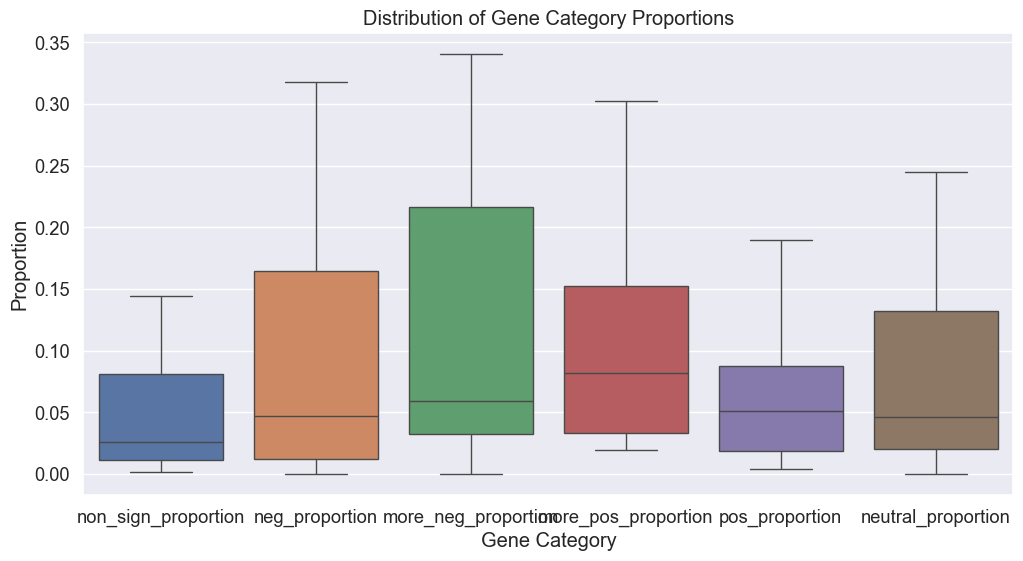

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=grouped_df[[f'{category}_proportion' for category in ['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']]])
plt.title('Distribution of Gene Category Proportions')
plt.ylabel('Proportion')
plt.xlabel('Gene Category')
plt.show()

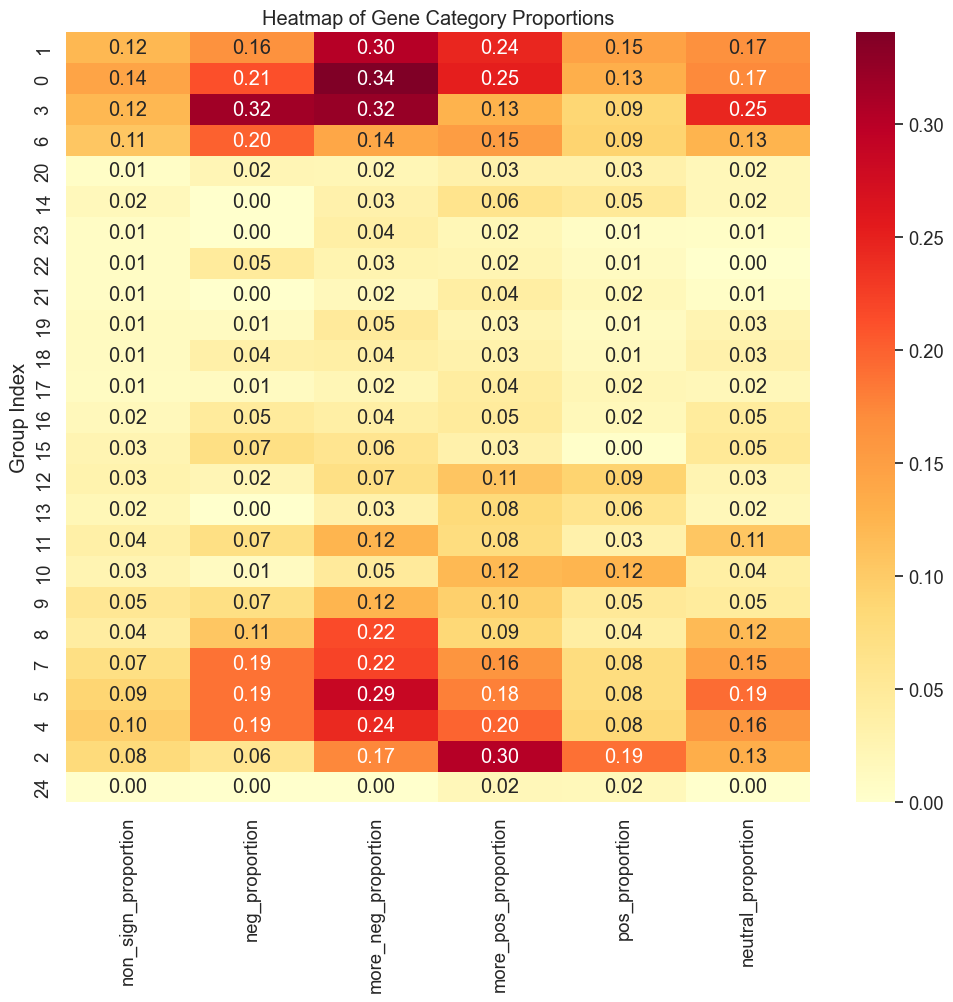

In [271]:
plt.figure(figsize=(12, 10))
sns.heatmap(grouped_df[[f'{category}_proportion' for category in ['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']]],
            cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Heatmap of Gene Category Proportions')
plt.ylabel('Group Index')
plt.show()

In [ ]:
""" import pandas as pd
import numpy as np

# Assuming dic_filt_hall is already created and contains 'cramers_v' column

# Sort dic_filt_hall by cramers_v in descending order
dic_filt_hall = dic_filt_hall.sort_values('cramers_v', ascending=False)

# Create gene_sets dictionary with cramers_v
gene_sets = {row['Name']: {'genes': set(row['intersections']), 'cramers_v': row['cramers_v']} 
             for _, row in dic_filt_hall.iterrows()}

grouped_terms = []
for term, data in gene_sets.items():
    genes = data['genes']
    cramers_v = data['cramers_v']
    added_to_group = False
    
    for group in grouped_terms:
        max_cramers_v_term = max(group['terms'], key=lambda t: gene_sets[t]['cramers_v'])
        max_cramers_v = gene_sets[max_cramers_v_term]['cramers_v']
        max_genes_set = gene_sets[max_cramers_v_term]['genes']
        
        intersection_size = len(max_genes_set.intersection(genes))
        if (intersection_size / len(max_genes_set) >= 0.5 and 
            intersection_size / len(genes) >= 0.5 and 
            cramers_v >= 0.15 * max_cramers_v):  # Adjust this threshold as needed
            
            group['terms'].append(term)
            group['genes'] = list(set(group['genes']).union(genes))
            group['max_cramers_v'] = max(group['max_cramers_v'], cramers_v)
            added_to_group = True
            break
    
    if not added_to_group:
        grouped_terms.append({'terms': [term], 'genes': list(genes), 'max_cramers_v': cramers_v})

# Create DataFrame from grouped terms
grouped_df = pd.DataFrame(grouped_terms)
grouped_df['num_terms'] = grouped_df['terms'].apply(len)
grouped_df['num_genes'] = grouped_df['genes'].apply(len)
grouped_df = grouped_df.sort_values(['max_cramers_v', 'num_terms'], ascending=[False, False])

# Function to get Hallmarks and descriptions
def get_hallmarks_and_descriptions(terms, dic_filt_hall):
    hallmarks = set()
    descriptions = set()
    for term in terms:
        term_data = dic_filt_hall[dic_filt_hall['Name'] == term]
        if not term_data.empty:
            hallmarks.update(term_data['Hallmarks'].iloc[0].split(', '))
            descriptions.add(term_data['description'].iloc[0])
    return list(hallmarks), list(descriptions)

# Apply function to each row of grouped_df
grouped_df['Hallmarks'], grouped_df['descriptions'] = zip(*grouped_df['terms'].apply(
    lambda x: get_hallmarks_and_descriptions(x, dic_filt_hall)
))

# Convert lists to strings for better visualization
grouped_df['Hallmarks'] = grouped_df['Hallmarks'].apply(lambda x: ', '.join(x))
grouped_df['descriptions'] = grouped_df['descriptions'].apply(lambda x: '; '.join(x))

# Function to count gene categories
def count_gene_categories(gene_list, driver_stats):
    gene_set = set(gene_list)
    categories = {'D0': 0, 'D1': 0, 'D2': 0, 'D3': 0, 'D4': 0}
    
    for gene in gene_set:
        if gene in driver_stats.index:
            category = driver_stats.loc[gene, 'new_category']
            if category in categories:
                categories[category] += 1
    
    return categories

# Apply function to count gene categories
category_counts = grouped_df['genes'].apply(lambda x: count_gene_categories(x, driver_stats))

# Add new columns for categories to grouped_df
for category in ['D0', 'D1', 'D2', 'D3', 'D4']:
    grouped_df[f'{category}_count'] = category_counts.apply(lambda x: x[category])

# Display the result
display(grouped_df[['terms', 'num_terms', 'num_genes', 'max_cramers_v', 'Hallmarks', 'descriptions', 
                    'D0_count', 'D1_count', 'D2_count', 'D3_count', 'D4_count']]) """

terms  num_terms  num_genes  \
0                                        [cell cycle]          1        388   
1                                        [DNA repair]          1        153   
2        [cell adhesion, regulation of cell adhesion]          2        376   
3                                    [cell migration]          1        335   
4                                     [cell division]          1        145   
5                        [cell junction organization]          1        182   
6   [programmed cell death, regulation of programm...          3        432   
7                 [negative regulation of cell cycle]          1         99   
8        [negative regulation of signal transduction]          1        284   
9                      [cell projection organization]          1        346   
10  [cell population proliferation, positive regul...          2        474   
11                [positive regulation of cell cycle]          1         81   
12                                     [angiogenesis]          1        144   
13  [DNA-templated DNA replication maintenance of ...          1         18   
14               [DNA integrity checkpoint signaling]          1         41   
15  [telomere organization, telomere maintenance, ...          3         45   
16                         [regulation of DNA repair]          1         52   
17                                   [vasculogenesis]          1         31   
18   [regulation of immune response, immune response]          2        310   
19             [epithelial to mesenchymal transition]          1         52   
20              [regulation of inflammatory response]          1         72   

    max_cramers_v                           Hallmarks  \
0        0.246717  Sustaining Proliferative Signaling   
1        0.185004     Genome Instability and Mutation   
2        0.158888  Activating Invasion and Metastasis   
3        0.157223  Activating Invasion and Metastasis   
4        0.149391  Sustaining Proliferative Signaling   
5        0.144055  Activating Invasion and Metastasis   
6        0.138784                   Resist Cell Death   
7        0.133622           Evading Growth Suppressor   
8        0.133310           Evading Growth Suppressor   
9        0.131224  Activating Invasion and Metastasis   
10       0.128071  Sustaining Proliferative Signaling   
11       0.115640  Sustaining Proliferative Signaling   
12       0.109428               Inducing Angiogenesis   
13       0.102998     Genome Instability and Mutation   
14       0.099703     Genome Instability and Mutation   
15       0.096721    Enabling Replicative Immortality   
16       0.092515     Genome Instability and Mutation   
17       0.087049               Inducing Angiogenesis   
18       0.081187         Avoiding Immune Destruction   
19       0.068851  Activating Invasion and Metastasis   
20       0.066507        Tumor promoting Inflammation   

                                         descriptions  D0_count  D1_count  \
0   "The progression of biochemical and morphologi...       119         6   
1   "The process of restoring DNA after damage. Ge...        38         1   
2   "Any process that modulates the frequency, rat...       175        25   
3   "The controlled self-propelled movement of a c...       133        14   
4   "The process resulting in division and partiti...        45         2   
5   "A process that is carried out at the cellular...        65         8   
6   "Any process that stops, prevents, or reduces ...       178        10   
7   "Any process that stops, prevents or reduces t...        29         0   
8   "Any process that stops, prevents, or reduces ...       111        12   
9   "A process that is carried out at the cellular...       141        13   
10  "The multiplication or reproduction of cells, ...       206        16   
11  "Any process that activates or increases the r...        24         1   
12  "Blood vessel formation when new vessels emerg...

In [ ]:
#which groups are more associated with specific cancer types. 

In [272]:
# Extract all unique terms
all_terms = set(term for sublist in grouped_df['terms'] for term in sublist)

# Create a DataFrame to map terms to hallmarks
hallmarks_terms = []
for term in all_terms:
    hallmarks = dic_filt_hall[dic_filt_hall['Name'].apply(lambda x: term in x)]['Hallmarks'].values
    hallmarks_terms.append([term, hallmarks])

hallmarks_terms_df = pd.DataFrame(hallmarks_terms, columns=['Term', 'Hallmarks'])

# Remove duplicated rows based on Term
hallmarks_terms_df = hallmarks_terms_df.drop_duplicates(subset=['Term'])

# Display the final DataFrame
display(hallmarks_terms_df)

Term  \
0                  positive regulation of cell growth   
1                               telomere organization   
2                 regulation of programmed cell death   
3                                     immune response   
4                 regulation of inflammatory response   
5                                      cell migration   
6   negative regulation of cell population prolife...   
7                 positive regulation of angiogenesis   
8                   positive regulation of cell cycle   
9        negative regulation of programmed cell death   
10                  negative regulation of cell cycle   
11                              programmed cell death   
12                                         cell cycle   
13                       cell projection organization   
14               epithelial to mesenchymal transition   
15                      regulation of immune response   
16         negative regulation of signal transduction   
17                 DNA integrity checkpoint signaling   
18                                         DNA repair   
19                           regulation of DNA repair   
20                                      cell division   
21                                     vasculogenesis   
22  DNA-templated DNA replication maintenance of f...   
23  positive regulation of cell population prolife...   
24                         cell junction organization   
25                                      cell adhesion   
26                        regulation of cell adhesion   
27               negative regulation of cell adhesion   
28                      cell population proliferation   
29                                       angiogenesis   
30                               telomere maintenance   

                                            Hallmarks  
0                [Sustaining Proliferative Signaling]  
1                  [Enabling Replicative Immortality]  
2              [Resist Cell Death, Resist Cell Death]  
3   [Avoiding Immune Destruction, Avoiding Immune ...  
4                      [Tumor promoting Inflammation]  
5                [Activating Invasion and Metastasis]  
6                         [Evading Growth Suppressor]  
7                             [Inducing Angiogenesis]  
8                [Sustaining Proliferative Signaling]  
9                                 [Resist Cell Death]  
10  [Sustaining Proliferative Signaling, Evading G...  
11  [Resist Cell Death, Resist Cell Death, Resist ...  
12  [Sustaining Proliferative Signaling, Sustainin...  
13               [Activating Invasion and Metastasis]  
14               [Activating Invasion and Metastasis]  
15                      [Avoiding Immune Destruction]  
16                        [Evading Growth Suppressor]  
17                  [Genome Instability and Mutation]  
18  [Genome Instability and Mutation, Genome Insta...  
19                  [Genome Instability and Mutation]  
20               [Sustaining Proliferative Signaling]  
21                            [Inducing Angiogenesis]  
22                  [Genome Instability and Mutation]  
23               [Sustaining Proliferative Signaling]  
24               [Activating Invasion and Metastasis]  
25  [Activating Invasion and Metastasis, Activatin...  
26  [Activating Invasion and Metastasis, Activatin...  
27               [Activating Invasion and Metastasis]  
28  [Sustaining Proliferative Signaling, Sustainin...  
29     [Inducing Angiogenesis, Inducing Angiogenesis]  
30                 [Enabling Replicative Immortality]

In [273]:
hallmark_counts = hallmarks_terms_df['Hallmarks'].explode().value_counts()
print(hallmark_counts)

Hallmarks
Sustaining Proliferative Signaling    10
Activating Invasion and Metastasis    10
Resist Cell Death                      6
Evading Growth Suppressor              5
Genome Instability and Mutation        5
Inducing Angiogenesis                  4
Avoiding Immune Destruction            3
Enabling Replicative Immortality       2
Tumor promoting Inflammation           1
Name: count, dtype: int64


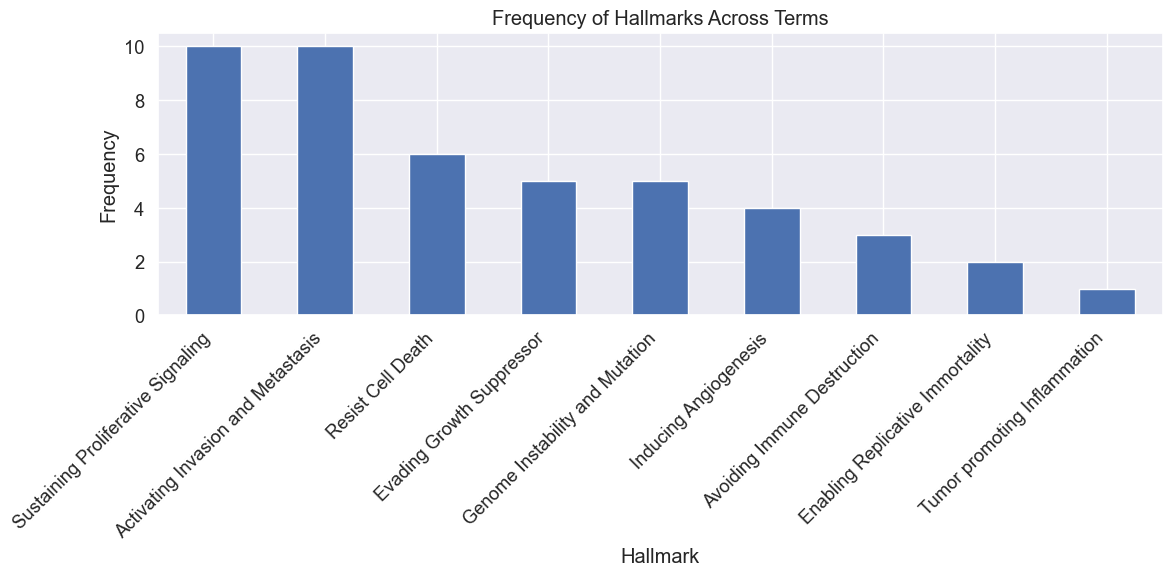

In [274]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
hallmark_counts.plot(kind='bar')
plt.title('Frequency of Hallmarks Across Terms')
plt.xlabel('Hallmark')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_88173/1030274653.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


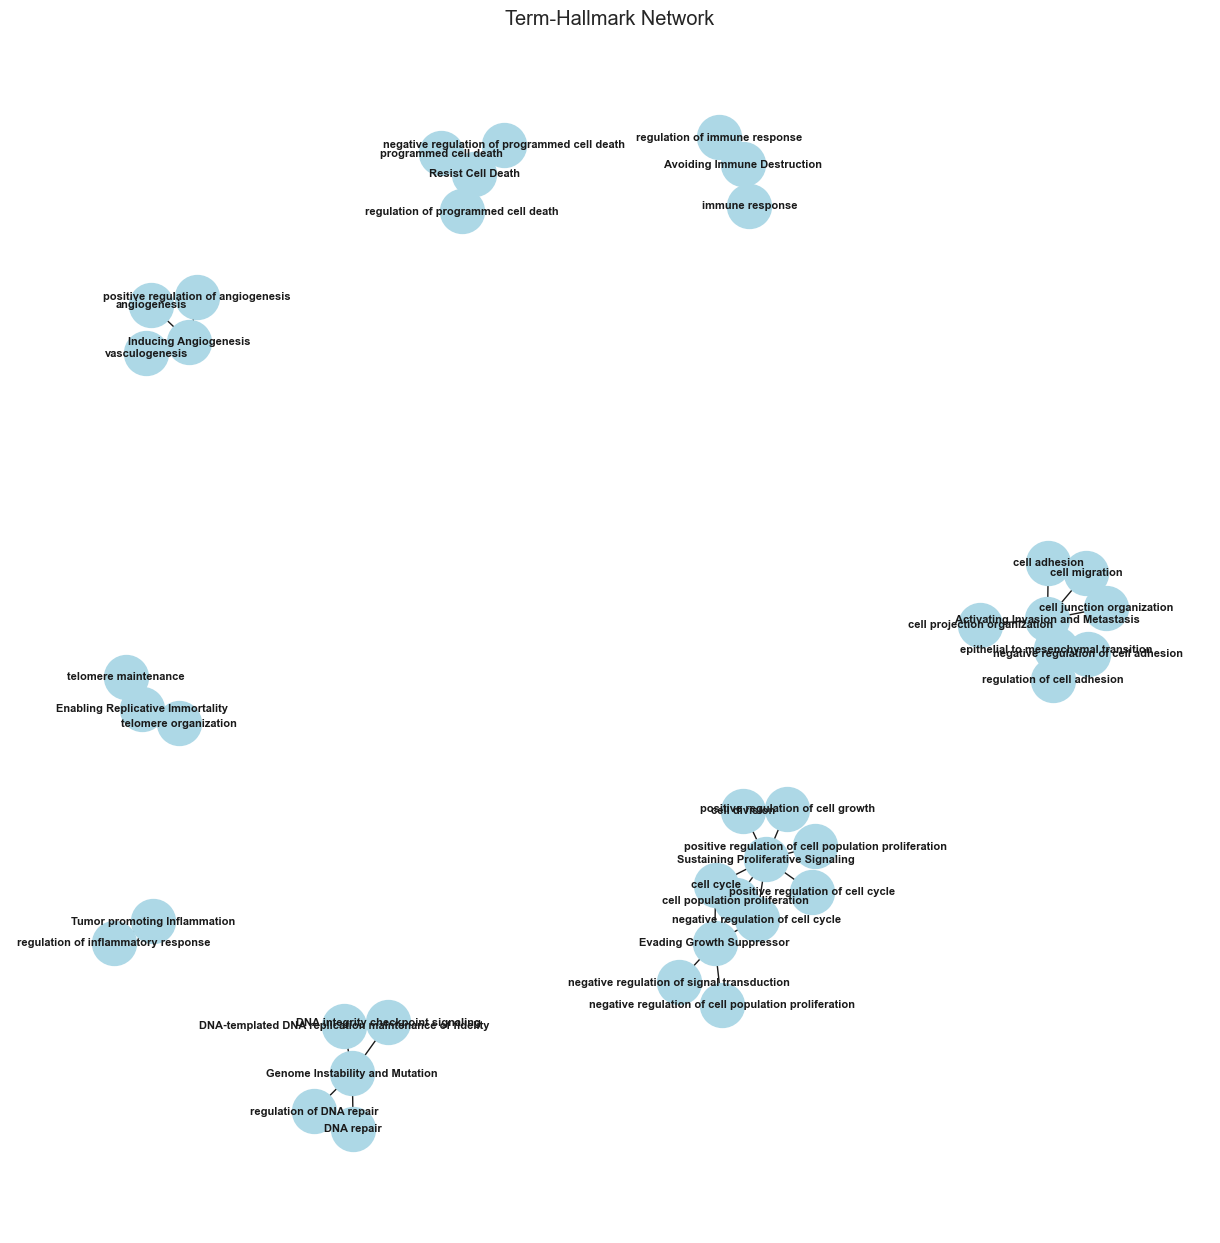

In [275]:
import networkx as nx

G = nx.Graph()
for _, row in hallmarks_terms_df.iterrows():
    term = row['Term']
    hallmarks = row['Hallmarks']
    for hallmark in hallmarks:
        G.add_edge(term, hallmark)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', 
        font_size=8, font_weight='bold')
plt.title('Term-Hallmark Network')
plt.axis('off')
plt.tight_layout()
plt.show()

In [276]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
hallmark_matrix = pd.DataFrame(mlb.fit_transform(hallmarks_terms_df['Hallmarks']),
                               columns=mlb.classes_,
                               index=hallmarks_terms_df['Term'])
print(hallmark_matrix)

                                                    Activating Invasion and Metastasis  \
Term                                                                                     
positive regulation of cell growth                                                   0   
telomere organization                                                                0   
regulation of programmed cell death                                                  0   
immune response                                                                      0   
regulation of inflammatory response                                                  0   
cell migration                                                                       1   
negative regulation of cell population prolifer...                                   0   
positive regulation of angiogenesis                                                  0   
positive regulation of cell cycle                                                    0   
negative r

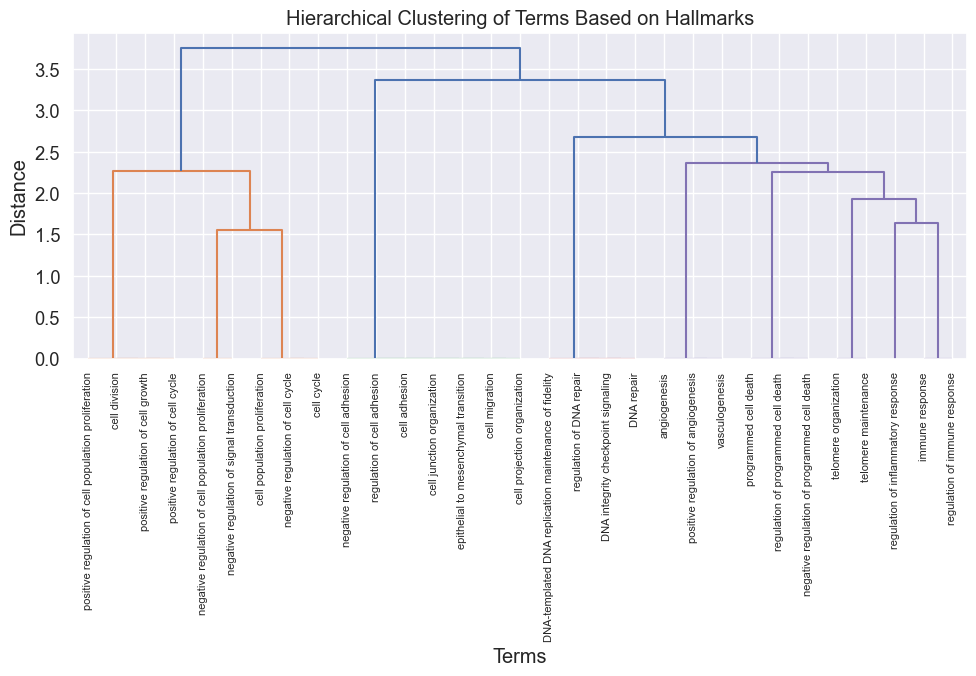

In [329]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(hallmark_matrix, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=hallmark_matrix.index, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering of Terms Based on Hallmarks')
plt.xlabel('Terms')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()